<a href="https://colab.research.google.com/github/saimani5/Notebooks_for_papers/blob/main/dkl_bo_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook applies VAE, rVAE, and DKL on the highly distorted cards dataset.  
*   VAE and rVAE uses atomai written in pyTorch: https://github.com/pycroscopy/atomai
*   DKL uses gpax written on jax and Haiku: https://github.com/ziatdinovmax/gpax
*   The DKL is applied in both static and active (BO) settings.  
*   The target functions considered for BO are both categorical (various cards suits) and continuous (shears and rotations).  
*   Results for all the cases are downloaded in their respective cells 
*   Any changes in the results from the paper are due to jax seeds which behave differently on different devices.  
  
  

Please write to valletisai.mani@gmail.com if you have any questions.

In [1]:
# Downloading required packages
!pip install -q gdown==4.5.4 atomai==0.7.4 gpax Kornia==0.6.8 jax==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.1/551.1 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 52.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [2]:
!pip install -q jaxlib==0.4.4+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 7.2 MB/s eta 0:00:00


In [4]:
# Importing the packages

import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt


import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import pickle

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

# Downloading and preparing the cards dataset

In [1]:
# Download the cards dataset
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 48.5MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


In [5]:
#@title Helper function and downloading the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)
    

    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4
    
    card1 = K.geometry.transform.resize(cards[0], (45,45), interpolation='bilinear')
    card2 = K.geometry.transform.resize(cards[1], (45,45), interpolation='bilinear')
    card3 = K.geometry.transform.resize(cards[2], (45,45), interpolation='bilinear')
    card4 = K.geometry.transform.resize(cards[3], (45,45), interpolation='bilinear')

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((30, 30)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float() 
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


# def plot_manifolds(model):   
#     fig, axes = plt.subplots(2, 2, figsize=(12, 12),
#                             subplot_kw={'xticks':[], 'yticks':[]},
#                             gridspec_kw=dict(hspace=0.1, wspace=0.05))
#     for i, ax in enumerate(axes.flat):
#         manifold = model.manifold2d(d=9, label=i, plot=False)
#         grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
#         ax.imshow(grid[0], cmap='viridis')
#     plt.show()

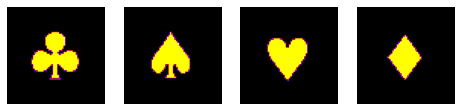

In [6]:
# Reading the initial cards data and visualizing them
cards = get_data()
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (8,2))
for i in range(4):
    ax[i].imshow(cards[i], cmap = 'gnuplot')
    ax[i].axis('off')

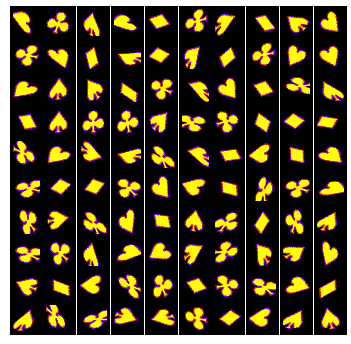

In [7]:
# Preparing the cards dataset by applying random rotations and shears. 
# Visualize a random sample from the dataset generated.
cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards, 
                                                                                angle = 120, 
                                                                                translation = 0.1,
                                                                                shear = 20,
                                                                                samples = 2000)

# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='bilinear')

# VAE on the dataset

In [ ]:
# Running the model with atomai vae
input_dim = (30,30)   # input dimensions: size of each image

# Defining the atomai VAE model, please check the documentation of atomai for more details.              
vae = aoi.models.VAE(input_dim, latent_dim=2,
                    numlayers_encoder=3, numhidden_encoder=1024,
                    numlayers_decoder=3, numhidden_decoder=1024,
                    skip=True)

# Running the model
# You can run the model if you are on GPU or load the saved weights of the trained model in the next cell.
vae.fit(cards_all, training_cycles=200, batch_size=75, loss="ce",
         filename='vae')

Epoch: 1/200, Training loss: 311.7576
Epoch: 2/200, Training loss: 261.4236
Epoch: 3/200, Training loss: 239.2508
Epoch: 4/200, Training loss: 224.3549
Epoch: 5/200, Training loss: 219.5787
Epoch: 6/200, Training loss: 215.2642
Epoch: 7/200, Training loss: 210.4019
Epoch: 8/200, Training loss: 205.6571
Epoch: 9/200, Training loss: 201.4374
Epoch: 10/200, Training loss: 197.5008
Epoch: 11/200, Training loss: 193.9141
Epoch: 12/200, Training loss: 190.7321
Epoch: 13/200, Training loss: 187.5367
Epoch: 14/200, Training loss: 184.8036
Epoch: 15/200, Training loss: 182.6227
Epoch: 16/200, Training loss: 179.9631
Epoch: 17/200, Training loss: 177.9863
Epoch: 18/200, Training loss: 176.1423
Epoch: 19/200, Training loss: 173.8871
Epoch: 20/200, Training loss: 172.0510
Epoch: 21/200, Training loss: 170.5414
Epoch: 22/200, Training loss: 169.0593
Epoch: 23/200, Training loss: 167.5222
Epoch: 24/200, Training loss: 165.9808
Epoch: 25/200, Training loss: 164.3092
Epoch: 26/200, Training loss: 162.

In [13]:
# Downloading and loading the saved model
!gdown 1fyL3_4NWsZjbxeTLUAA5LmmiyuRBLaya
vae = aoi.load_model('vae.tar')

Downloading...
From: https://drive.google.com/uc?id=1fyL3_4NWsZjbxeTLUAA5LmmiyuRBLaya
To: /content/vae.tar
100% 72.6M/72.6M [00:01<00:00, 46.5MB/s]


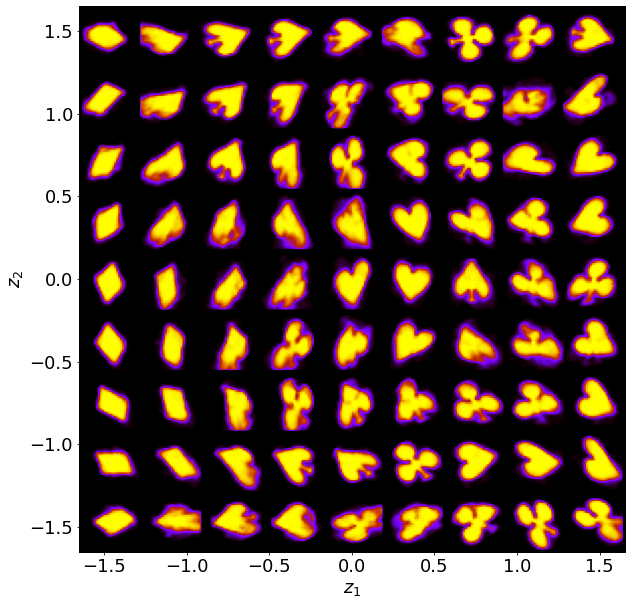

array([[8.64906511e-08, 2.44713164e-07, 2.15648257e-07, ...,
        2.37733744e-07, 1.56552442e-08, 9.68371383e-10],
       [2.85613680e-07, 3.37104638e-07, 7.44393915e-08, ...,
        3.35513192e-07, 2.26096937e-08, 1.85121909e-08],
       [1.41239070e-06, 1.69136300e-07, 2.93981628e-07, ...,
        1.47156570e-07, 1.46307713e-07, 4.10965626e-08],
       ...,
       [3.04803791e-07, 5.46847104e-07, 1.85741285e-07, ...,
        2.89698853e-03, 1.71375286e-03, 1.43940537e-03],
       [3.07342958e-07, 4.37772798e-07, 2.42466314e-07, ...,
        3.59437050e-04, 3.22421751e-04, 5.81377135e-05],
       [2.83885470e-07, 5.92549384e-07, 3.22306818e-07, ...,
        1.90712046e-04, 1.02053251e-04, 2.22954786e-05]])

In [14]:
# Visualizing Latent manifolds or Decoded latent space of the VAE
vae.manifold2d(d = 9, origin = 'upper')

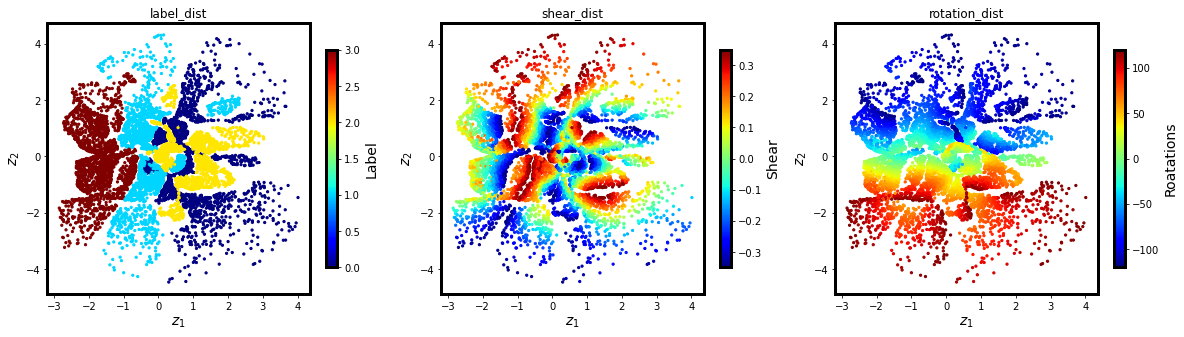

In [19]:
# Latent distributions colored using the ground truth class labels, shears, and roations.
z_mean, z_sd = vae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))



im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=5, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=5, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[2].scatter(z_mean[:,-1], z_mean[:,-2], c=angles_all, s=5, cmap='jet')
ax[2].set_title('rotation_dist')
ax[2].set_xlabel("$z_1$", fontsize=14)
ax[2].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[2], shrink=.8)
cbar.set_label("Roatations", fontsize=14)
cbar.ax.tick_params(labelsize=10)


# rVAE on the dataset

In [ ]:
# Now we use the rotationally invariant VAE (rVAE) from atomai on the cards dataset
input_dim = (30,30)   # input dimensions

# Defining the atomai model
rvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=3, numhidden_encoder=1024,
                        numlayers_decoder=3, numhidden_decoder=1024,
                        skip=True)

# Running the model, the saved model weights are donwloaded in the next cell    
rvae.fit(cards_all, training_cycles=200, batch_size=75, loss="ce", translation_prior=0.1,
         filename='rvae')

/home/cloud/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/200, Training loss: 324.6543
Epoch: 2/200, Training loss: 207.5169
Epoch: 3/200, Training loss: 194.3132
Epoch: 4/200, Training loss: 186.7886
Epoch: 5/200, Training loss: 180.9381
Epoch: 6/200, Training loss: 177.4010
Epoch: 7/200, Training loss: 171.9140
Epoch: 8/200, Training loss: 165.3214
Epoch: 9/200, Training loss: 159.0293
Epoch: 10/200, Training loss: 152.8967
Epoch: 11/200, Training loss: 145.6081
Epoch: 12/200, Training loss: 142.2711
Epoch: 13/200, Training loss: 134.4055
Epoch: 14/200, Training loss: 129.9193
Epoch: 15/200, Training loss: 128.3137
Epoch: 16/200, Training loss: 121.9128
Epoch: 17/200, Training loss: 118.6502
Epoch: 18/200, Training loss: 115.9876
Epoch: 19/200, Training loss: 112.1215
Epoch: 20/200, Training loss: 110.4704
Epoch: 21/200, Training loss: 109.9299
Epoch: 22/200, Training loss: 106.9379
Epoch: 23/200, Training loss: 104.1657
Epoch: 24/200, Training loss: 104.1340
Epoch: 25/200, Training loss: 102.0023
Epoch: 26/200, Training loss: 99.8

In [20]:
# Downloading and loading the saved model
!gdown 1vVHNeeUYPgPQXRRvcLm86ODjPMSPSlPT
rvae = aoi.load_model('rvae.tar')

Downloading...
From: https://drive.google.com/uc?id=1vVHNeeUYPgPQXRRvcLm86ODjPMSPSlPT
To: /content/rvae.tar
100% 74.3M/74.3M [00:01<00:00, 44.6MB/s]


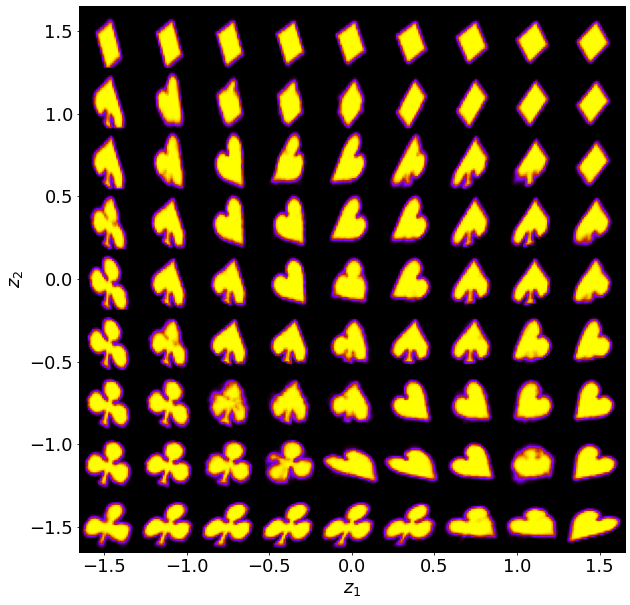

array([[8.97195374e-11, 1.00374410e-10, 1.32969677e-10, ...,
        1.24652733e-08, 1.15345618e-08, 9.83734161e-09],
       [1.09387464e-10, 1.31339079e-10, 1.74190620e-10, ...,
        1.71302226e-08, 1.50866057e-08, 1.32058133e-08],
       [1.32527336e-10, 1.75034542e-10, 2.43061932e-10, ...,
        2.47456047e-08, 2.19462351e-08, 1.74184791e-08],
       ...,
       [3.48369156e-07, 2.56829935e-07, 1.87569768e-07, ...,
        2.49358689e-09, 1.41541234e-09, 8.23496882e-10],
       [3.87290022e-08, 2.82800467e-08, 3.87349104e-08, ...,
        1.44377488e-09, 8.51922255e-10, 5.82670578e-10],
       [7.25736493e-09, 1.11102763e-08, 4.22498196e-08, ...,
        1.13266774e-09, 5.85052673e-10, 4.19290602e-10]])

In [21]:
# Visulazing the latent manifold of rVAE (Decoded latent space)
rvae.manifold2d(d = 9, origin = 'upper')

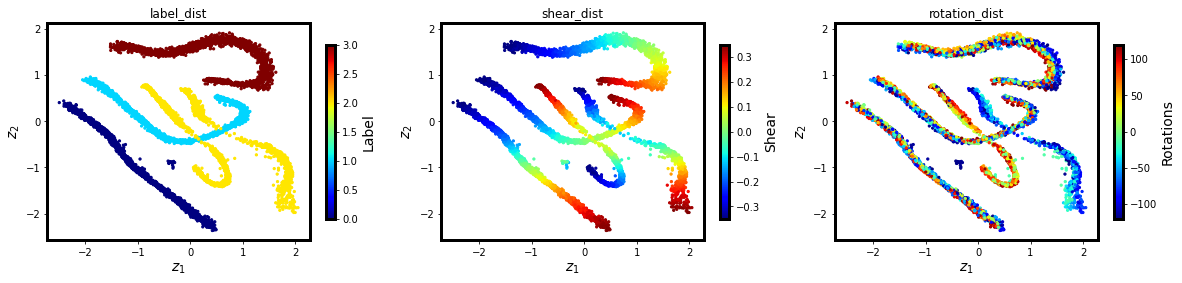

In [23]:
# Latent distributions colored using the ground truth labels, shears and rotations.

z_mean, z_sd = rvae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,4))



im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=5, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=5, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[2].scatter(z_mean[:,-1], z_mean[:,-2], c=angles_all, s=5, cmap='jet')
ax[2].set_title('rotation_dist')
ax[2].set_xlabel("$z_1$", fontsize=14)
ax[2].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[2], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Text(0.5, 1.0, 'Encoded vs. ground truth (rotations)')

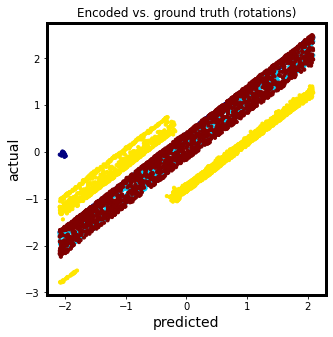

In [25]:
# Encoded angle vs. ground truth angle plot

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(torch.deg2rad(angles_all), z_mean[:,0], c = labels_all, s =10, cmap = 'jet')
# ax.set_title('Angles_plot')
ax.set_xlabel("predicted", fontsize=14)
ax.set_ylabel("actual", fontsize=14)
ax.set_title('Encoded vs. ground truth (rotations)')
# plt.savefig('rvae_predvsactual_angles.png', dpi = 300)

# DKL on cards dataset



*   Each section from here corresponds to a specific target function of the cards dataset.    
*   First we will run the DKL in the static setting and then proceed to the active setting.    
*   Only the first analysis has the comments, the rest of the notebook follows a similar workflow.



## Case-0
Target Function: 1 for Clubs and 0 for the rest of the classes

In [10]:
X = np.asarray(cards_all).reshape([-1, 900])

# First we will run the DKL on the whole dataset in one go
X0 = np.copy(X)  # Copying the entire input dataset

# Preparing the targets/outputs
targets0 = np.zeros(len(labels_all))
targets0[labels_all == 0] = 1

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data


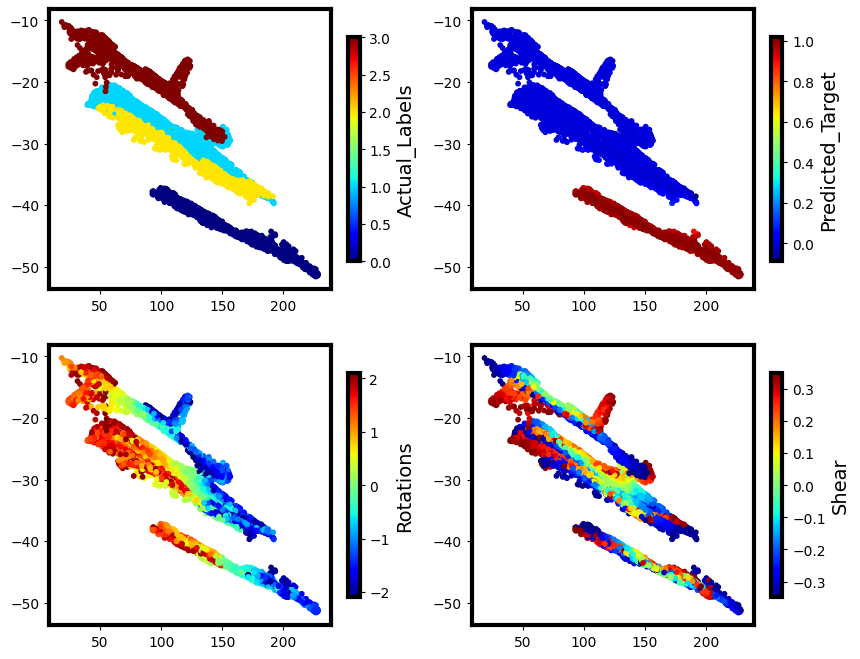

In [ ]:
# Running DKL on the whole dataset
rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()  # Seeds for reproducibility
dkl_0 = gpax.viDKL(900, 2, 'RBF')  # Initializing the model
dkl_0.fit(rng_key_0, X0, targets0)  # Fitting the model




# Visualizing DKL Latent distributions colored with ground truths and predictions

embeded_0 = dkl_0.embed(X0)  # Embedding the entire dataset
pred_mean0, pred_var0 = dkl_0.predict_in_batches(rng_key_predict_0, X0, batch_size=250)  # Target property predictions on the dataset
pred_std0 = jnp.sqrt(pred_var0)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

# Ground truth labels
im = ax[0,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Target function predictions of the DKL model
im = ax[0,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = pred_mean0, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Ground truth Rotations
im = ax[1,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Ground truth Shears
im = ax[1,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [13]:
np.random.seed(0)

# Picking the initialization points and preparing the dataset
idx0 = np.random.choice(np.arange(len(X0)), size = 100, replace = False)  
X0_train = X0[idx0]
X0_unmeasured = np.delete(X0, idx0, axis=0)

indices_total_0 = np.arange(len(X))
indices_train_0 = indices_total_0[idx0]
y0_train = targets0[idx0]
indices_unmeasured_0 = np.delete(indices_total_0, idx0)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean0, exp_std0 = [], []
dkl_mean0, dkl_std0 = [], []
embed_traj0 = []
traj_mean0, traj_std0 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key10, rng_key_predict10 = gpax.utils.get_keys()
    dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_0.fit(rng_key10, X0_train, y0_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean0.append(y_mean[id_next])
    exp_std0.append(y_std[id_next])
    
    x_next = X0_unmeasured[id_next]
    ind_next = indices_unmeasured_0[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean0.append(pred_mean0[ind_next])
    dkl_std0.append(pred_std0[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets0[ind_next]
    
    # Update training arrays
    X0_train = np.append(X0_train, x_next[None], axis=0)
    y0_train = np.append(y0_train, y_measured)
    X0_unmeasured = np.delete(X0_unmeasured, id_next, axis=0)
    indices_unmeasured_0 = np.delete(indices_unmeasured_0, id_next)
    
    embed_traj = dkl_BO_0.embed(X0_train)
    traj_m, traj_s = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_train, batch_size=100)
    
    embed_traj0.append(embed_traj)
    traj_mean0.append(traj_m)


# Saving the results into a pickle file which are loaded into the next cell
clubs_results = {}
clubs_results['X_train'] = X0_train
clubs_results['y_train'] = y0_train
clubs_results['X_unmeasured'] = X0_unmeasured
clubs_results['indices_unmeasured'] = indices_unmeasured_0
clubs_results['dkl_mean'] = dkl_mean0
clubs_results['dkl_std'] = dkl_std0
clubs_results['exp_mean'] = exp_mean0
clubs_results['exp_std'] = exp_std0
clubs_results['traj_mean'] = traj_mean0
clubs_results['traj_std'] = traj_std0
clubs_results['embed_traj'] = embed_traj0

with open('clubs_results.pickle', 'wb') as handle:
    pickle.dump(clubs_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 356.56it/s, init loss: 60204.3430, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3475 0.3666]
k_scale          0.42000000000000004
noise            0.008400000000000001

Step 2


100%|█| 1000/1000 [00:02<00:00, 420.95it/s, init loss: 60205.8481, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3686 0.3725]
k_scale          0.39
noise            0.008400000000000001

Step 3


100%|█| 1000/1000 [00:02<00:00, 418.70it/s, init loss: 60207.3461, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4063 0.4556]
k_scale          0.3685
noise            0.0082

Step 4


100%|█| 1000/1000 [00:02<00:00, 416.59it/s, init loss: 60208.7547, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3843 0.3556]
k_scale          0.42700000000000005
noise            0.008

Step 5


100%|█| 1000/1000 [00:02<00:00, 369.13it/s, init loss: 60209.9873, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5337 0.5497]
k_scale          0.3407
noise            0.0094

Step 6


100%|█| 1000/1000 [00:02<00:00, 414.22it/s, init loss: 60211.4243, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3695 0.3279]
k_scale          0.4171
noise            0.008

Step 7


100%|█| 1000/1000 [00:02<00:00, 415.34it/s, init loss: 60212.9036, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4604 0.5222]
k_scale          0.2987
noise            0.008700000000000001

Step 8


100%|█| 1000/1000 [00:02<00:00, 398.94it/s, init loss: 60214.2481, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3423 0.3602]
k_scale          0.3551
noise            0.0081

Step 9


100%|█| 1000/1000 [00:02<00:00, 408.12it/s, init loss: 60215.6704, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3889 0.4226]
k_scale          0.32980000000000004
noise            0.0091

Step 10


100%|█| 1000/1000 [00:02<00:00, 397.59it/s, init loss: 60217.1756, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4302 0.4035]
k_scale          0.37420000000000003
noise            0.008400000000000001

Step 11


100%|█| 1000/1000 [00:02<00:00, 404.81it/s, init loss: 60218.6647, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4005 0.4053]
k_scale          0.3165
noise            0.0081

Step 12


100%|█| 1000/1000 [00:02<00:00, 402.01it/s, init loss: 60219.9089, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3767 0.39  ]
k_scale          0.3693
noise            0.0081

Step 13


100%|█| 1000/1000 [00:02<00:00, 403.42it/s, init loss: 60221.3480, avg. loss [95



Inferred GP kernel parameters
k_length         [0.369  0.3606]
k_scale          0.4063
noise            0.0083

Step 14


100%|█| 1000/1000 [00:02<00:00, 396.00it/s, init loss: 60222.7385, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3619 0.3722]
k_scale          0.3603
noise            0.0079

Step 15


100%|█| 1000/1000 [00:02<00:00, 404.39it/s, init loss: 60224.2437, avg. loss [95



Inferred GP kernel parameters
k_length         [0.252  0.3256]
k_scale          0.3513
noise            0.0112

Step 16


100%|█| 1000/1000 [00:02<00:00, 402.87it/s, init loss: 60225.4802, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4853 0.4012]
k_scale          0.3367
noise            0.008

Step 17


100%|█| 1000/1000 [00:02<00:00, 401.36it/s, init loss: 60226.8079, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3717 0.394 ]
k_scale          0.31980000000000003
noise            0.0083

Step 18


100%|█| 1000/1000 [00:02<00:00, 390.31it/s, init loss: 60228.0483, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5147 0.4737]
k_scale          0.3534
noise            0.0092

Step 19


100%|█| 1000/1000 [00:02<00:00, 401.56it/s, init loss: 60229.5483, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3742 0.3587]
k_scale          0.37370000000000003
noise            0.0079

Step 20


100%|█| 1000/1000 [00:02<00:00, 398.21it/s, init loss: 60231.0308, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3947 0.403 ]
k_scale          0.432
noise            0.008

Step 21


100%|█| 1000/1000 [00:02<00:00, 399.73it/s, init loss: 60232.5309, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3692 0.3414]
k_scale          0.41950000000000004
noise            0.0079

Step 22


100%|█| 1000/1000 [00:02<00:00, 388.22it/s, init loss: 60234.0103, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4048 0.4228]
k_scale          0.3104
noise            0.0081

Step 23


100%|█| 1000/1000 [00:02<00:00, 412.63it/s, init loss: 60235.3653, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3775 0.3953]
k_scale          0.31920000000000004
noise            0.0081

Step 24


100%|█| 1000/1000 [00:02<00:00, 406.53it/s, init loss: 60236.8500, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3704 0.3356]
k_scale          0.4169
noise            0.0079

Step 25


100%|█| 1000/1000 [00:02<00:00, 409.84it/s, init loss: 60238.2539, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6887 1.0338]
k_scale          0.3027
noise            0.016300000000000002

Step 26


100%|█| 1000/1000 [00:03<00:00, 308.84it/s, init loss: 60239.5781, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4611 0.5119]
k_scale          0.3128
noise            0.008400000000000001

Step 27


100%|█| 1000/1000 [00:02<00:00, 408.03it/s, init loss: 60241.0303, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4358 0.5279]
k_scale          0.2933
noise            0.0097

Step 28


100%|█| 1000/1000 [00:02<00:00, 408.50it/s, init loss: 60242.2743, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4117 0.4139]
k_scale          0.3106
noise            0.0085

Step 29


100%|█| 1000/1000 [00:02<00:00, 412.30it/s, init loss: 60243.7774, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3771 0.3743]
k_scale          0.4082
noise            0.0079

Step 30


100%|█| 1000/1000 [00:03<00:00, 299.47it/s, init loss: 60245.0761, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5499 0.513 ]
k_scale          0.2686
noise            0.010700000000000001

Step 31


100%|█| 1000/1000 [00:02<00:00, 401.90it/s, init loss: 60246.5810, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3868 0.4031]
k_scale          0.3447
noise            0.0079

Step 32


100%|█| 1000/1000 [00:02<00:00, 409.54it/s, init loss: 60247.9587, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3759 0.378 ]
k_scale          0.40030000000000004
noise            0.008

Step 33


100%|█| 1000/1000 [00:02<00:00, 410.72it/s, init loss: 60249.2125, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6072 0.6657]
k_scale          0.2817
noise            0.0108

Step 34


100%|█| 1000/1000 [00:02<00:00, 410.00it/s, init loss: 60250.4144, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4529 0.4707]
k_scale          0.3037
noise            0.008

Step 35


100%|█| 1000/1000 [00:02<00:00, 409.35it/s, init loss: 60251.7847, avg. loss [95



Inferred GP kernel parameters
k_length         [0.413  0.3878]
k_scale          0.299
noise            0.0081

Step 36


100%|█| 1000/1000 [00:02<00:00, 411.51it/s, init loss: 60253.2895, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4087 0.3869]
k_scale          0.3301
noise            0.0082

Step 37


100%|█| 1000/1000 [00:02<00:00, 404.62it/s, init loss: 60254.7900, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4955 0.5089]
k_scale          0.30960000000000004
noise            0.009300000000000001

Step 38


100%|█| 1000/1000 [00:02<00:00, 405.11it/s, init loss: 60256.0285, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3786 0.3876]
k_scale          0.3785
noise            0.0077

Step 39


100%|█| 1000/1000 [00:02<00:00, 401.23it/s, init loss: 60257.2728, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4532 0.3899]
k_scale          0.3131
noise            0.0081

Step 40


100%|█| 1000/1000 [00:02<00:00, 407.19it/s, init loss: 60258.7449, avg. loss [95



Inferred GP kernel parameters
k_length         [0.384  0.3903]
k_scale          0.39080000000000004
noise            0.0079

Step 41


100%|█| 1000/1000 [00:02<00:00, 407.70it/s, init loss: 60260.2493, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3817 0.4062]
k_scale          0.40690000000000004
noise            0.008

Step 42


100%|█| 1000/1000 [00:02<00:00, 405.68it/s, init loss: 60261.7422, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4034 0.3301]
k_scale          0.4212
noise            0.008700000000000001

Step 43


100%|█| 1000/1000 [00:03<00:00, 332.48it/s, init loss: 60263.2245, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3802 0.3842]
k_scale          0.364
noise            0.009000000000000001

Step 44


100%|█| 1000/1000 [00:02<00:00, 405.20it/s, init loss: 60264.6074, avg. loss [95



Inferred GP kernel parameters
k_length         [0.2066 0.1785]
k_scale          0.45580000000000004
noise            0.0115

Step 45


100%|█| 1000/1000 [00:02<00:00, 407.52it/s, init loss: 60265.8516, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4213 0.4016]
k_scale          0.4027
noise            0.0076

Step 46


100%|█| 1000/1000 [00:02<00:00, 404.64it/s, init loss: 60267.0953, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4745 0.4192]
k_scale          0.3357
noise            0.009300000000000001

Step 47


100%|█| 1000/1000 [00:03<00:00, 321.70it/s, init loss: 60268.3362, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3661 0.4013]
k_scale          0.4025
noise            0.0076

Step 48


100%|█| 1000/1000 [00:02<00:00, 403.35it/s, init loss: 60269.6449, avg. loss [95



Inferred GP kernel parameters
k_length         [0.2758 0.2912]
k_scale          0.4012
noise            0.0126

Step 49


100%|█| 1000/1000 [00:02<00:00, 405.03it/s, init loss: 60270.8428, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4529 0.3929]
k_scale          0.3033
noise            0.0081

Step 50


100%|█| 1000/1000 [00:02<00:00, 405.94it/s, init loss: 60272.3118, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5147 0.4618]
k_scale          0.3083
noise            0.008400000000000001

Step 51


100%|█| 1000/1000 [00:03<00:00, 304.49it/s, init loss: 60273.7879, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6582 1.1095]
k_scale          0.18660000000000002
noise            0.011000000000000001

Step 52


100%|█| 1000/1000 [00:02<00:00, 399.08it/s, init loss: 60275.2930, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4391 0.4627]
k_scale          0.30760000000000004
noise            0.0091

Step 53


100%|█| 1000/1000 [00:02<00:00, 403.04it/s, init loss: 60276.5373, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5128 0.4804]
k_scale          0.31570000000000004
noise            0.012100000000000001

Step 54


100%|█| 1000/1000 [00:02<00:00, 407.50it/s, init loss: 60278.0140, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5301 0.5906]
k_scale          0.3024
noise            0.0092

Step 55


100%|█| 1000/1000 [00:02<00:00, 401.57it/s, init loss: 60279.5008, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3529 0.4094]
k_scale          0.40750000000000003
noise            0.0082

Step 56


100%|█| 1000/1000 [00:02<00:00, 403.77it/s, init loss: 60280.8415, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5361 0.4536]
k_scale          0.3261
noise            0.008

Step 57


100%|█| 1000/1000 [00:02<00:00, 405.67it/s, init loss: 60282.2293, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6182 0.786 ]
k_scale          0.2959
noise            0.013300000000000001

Step 58


100%|█| 1000/1000 [00:02<00:00, 405.07it/s, init loss: 60283.4714, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6127 0.5871]
k_scale          0.23120000000000002
noise            0.0091

Step 59


100%|█| 1000/1000 [00:02<00:00, 405.75it/s, init loss: 60284.9641, avg. loss [95



Inferred GP kernel parameters
k_length         [0.476  0.4694]
k_scale          0.3662
noise            0.0079

Step 60


100%|█| 1000/1000 [00:02<00:00, 401.36it/s, init loss: 60286.3351, avg. loss [95



Inferred GP kernel parameters
k_length         [0.482  0.5253]
k_scale          0.2725
noise            0.0079

Step 61


100%|█| 1000/1000 [00:02<00:00, 407.54it/s, init loss: 60287.7972, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5431 0.55  ]
k_scale          0.29660000000000003
noise            0.0106

Step 62


100%|█| 1000/1000 [00:02<00:00, 403.89it/s, init loss: 60289.2328, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5039 0.5789]
k_scale          0.2634
noise            0.008400000000000001

Step 63


100%|█| 1000/1000 [00:02<00:00, 404.52it/s, init loss: 60290.6174, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5487 0.2706]
k_scale          0.46950000000000003
noise            0.016900000000000002

Step 64


100%|█| 1000/1000 [00:02<00:00, 336.49it/s, init loss: 60291.8490, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4585 0.4086]
k_scale          0.36710000000000004
noise            0.0077

Step 65


100%|█| 1000/1000 [00:02<00:00, 403.67it/s, init loss: 60293.2444, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4411 0.4781]
k_scale          0.2989
noise            0.0083

Step 66


100%|█| 1000/1000 [00:02<00:00, 404.61it/s, init loss: 60294.7495, avg. loss [95



Inferred GP kernel parameters
k_length         [0.454  0.4014]
k_scale          0.3286
noise            0.0081

Step 67


100%|█| 1000/1000 [00:02<00:00, 407.26it/s, init loss: 60296.1787, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4043 0.3717]
k_scale          0.4224
noise            0.0077

Step 68


100%|█| 1000/1000 [00:02<00:00, 404.04it/s, init loss: 60297.3462, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4454 0.3809]
k_scale          0.3976
noise            0.0079

Step 69


100%|█| 1000/1000 [00:02<00:00, 403.19it/s, init loss: 60298.6341, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4121 0.4029]
k_scale          0.3961
noise            0.0078000000000000005

Step 70


100%|█| 1000/1000 [00:02<00:00, 405.42it/s, init loss: 60300.1437, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5107 0.5173]
k_scale          0.3195
noise            0.0081

Step 71


100%|█| 1000/1000 [00:02<00:00, 402.53it/s, init loss: 60301.3571, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4514 0.4763]
k_scale          0.367
noise            0.008400000000000001

Step 72


100%|█| 1000/1000 [00:02<00:00, 405.15it/s, init loss: 60302.6688, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4633 0.4095]
k_scale          0.312
noise            0.008

Step 73


100%|█| 1000/1000 [00:02<00:00, 395.79it/s, init loss: 60304.1577, avg. loss [95



Inferred GP kernel parameters
k_length         [0.391  0.3989]
k_scale          0.3104
noise            0.0077

Step 74


100%|█| 1000/1000 [00:02<00:00, 402.23it/s, init loss: 60305.3227, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4342 0.4789]
k_scale          0.3981
noise            0.0085

Step 75


100%|█| 1000/1000 [00:02<00:00, 403.14it/s, init loss: 60306.8195, avg. loss [95



Inferred GP kernel parameters
k_length         [0.465  0.5315]
k_scale          0.2775
noise            0.0081

Step 76


100%|█| 1000/1000 [00:02<00:00, 404.67it/s, init loss: 60308.0449, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5816 0.6289]
k_scale          0.2939
noise            0.0106

Step 77


100%|█| 1000/1000 [00:02<00:00, 333.52it/s, init loss: 60309.4860, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5154 0.5893]
k_scale          0.341
noise            0.008

Step 78


100%|█| 1000/1000 [00:02<00:00, 402.38it/s, init loss: 60310.9816, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4208 0.4195]
k_scale          0.2876
noise            0.0082

Step 79


100%|█| 1000/1000 [00:02<00:00, 401.41it/s, init loss: 60312.4180, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4737 0.4872]
k_scale          0.3158
noise            0.0083

Step 80


100%|█| 1000/1000 [00:02<00:00, 401.64it/s, init loss: 60313.7488, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4242 0.4149]
k_scale          0.3981
noise            0.0083

Step 81


100%|█| 1000/1000 [00:02<00:00, 403.47it/s, init loss: 60315.0480, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4401 0.5013]
k_scale          0.28650000000000003
noise            0.008700000000000001

Step 82


100%|█| 1000/1000 [00:02<00:00, 395.86it/s, init loss: 60316.3976, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5953 0.5438]
k_scale          0.2772
noise            0.0077

Step 83


100%|█| 1000/1000 [00:02<00:00, 402.35it/s, init loss: 60317.6109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5673 0.6937]
k_scale          0.276
noise            0.008400000000000001

Step 84


100%|█| 1000/1000 [00:02<00:00, 402.00it/s, init loss: 60319.0737, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6472 0.705 ]
k_scale          0.2752
noise            0.0095

Step 85


100%|█| 1000/1000 [00:02<00:00, 403.35it/s, init loss: 60320.3180, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4009 0.393 ]
k_scale          0.4055
noise            0.0079

Step 86


100%|█| 1000/1000 [00:02<00:00, 355.16it/s, init loss: 60321.7751, avg. loss [95



Inferred GP kernel parameters
k_length         [0.463  0.4942]
k_scale          0.28150000000000003
noise            0.0078000000000000005

Step 87


100%|█| 1000/1000 [00:02<00:00, 402.65it/s, init loss: 60323.2802, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3964 0.3667]
k_scale          0.4244
noise            0.0077

Step 88


100%|█| 1000/1000 [00:02<00:00, 401.38it/s, init loss: 60324.5033, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4353 0.4403]
k_scale          0.2942
noise            0.0079

Step 89


100%|█| 1000/1000 [00:02<00:00, 403.03it/s, init loss: 60325.8236, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5284 0.5274]
k_scale          0.3254
noise            0.0086

Step 90


100%|█| 1000/1000 [00:02<00:00, 353.45it/s, init loss: 60327.2036, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4953 0.5228]
k_scale          0.2554
noise            0.0092

Step 91


100%|█| 1000/1000 [00:02<00:00, 405.58it/s, init loss: 60328.4868, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9777 0.8023]
k_scale          0.25220000000000004
noise            0.0091

Step 92


100%|█| 1000/1000 [00:02<00:00, 404.35it/s, init loss: 60329.9175, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5507 0.6225]
k_scale          0.3163
noise            0.0083

Step 93


100%|█| 1000/1000 [00:02<00:00, 401.93it/s, init loss: 60331.2968, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7531 0.6521]
k_scale          0.2348
noise            0.008400000000000001

Step 94


100%|█| 1000/1000 [00:02<00:00, 396.72it/s, init loss: 60332.4758, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4855 0.447 ]
k_scale          0.34340000000000004
noise            0.0086

Step 95


100%|█| 1000/1000 [00:02<00:00, 393.43it/s, init loss: 60333.9722, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4983 0.5293]
k_scale          0.30910000000000004
noise            0.0089

Step 96


100%|█| 1000/1000 [00:02<00:00, 398.74it/s, init loss: 60335.3433, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6035 0.5523]
k_scale          0.36360000000000003
noise            0.0078000000000000005

Step 97


100%|█| 1000/1000 [00:02<00:00, 400.32it/s, init loss: 60336.7531, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4026 0.4207]
k_scale          0.3934
noise            0.0079

Step 98


100%|█| 1000/1000 [00:02<00:00, 398.02it/s, init loss: 60338.1734, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4998 0.4521]
k_scale          0.2914
noise            0.008400000000000001

Step 99


100%|█| 1000/1000 [00:02<00:00, 353.07it/s, init loss: 60339.4906, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4555 0.4442]
k_scale          0.4037
noise            0.0082

Step 100


100%|█| 1000/1000 [00:02<00:00, 399.20it/s, init loss: 60340.9257, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4176 0.4286]
k_scale          0.39990000000000003
noise            0.0078000000000000005

Step 101


100%|█| 1000/1000 [00:02<00:00, 399.35it/s, init loss: 60342.1359, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4837 0.5317]
k_scale          0.35800000000000004
noise            0.0086

Step 102


100%|█| 1000/1000 [00:02<00:00, 399.16it/s, init loss: 60343.4230, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4388 0.4615]
k_scale          0.29200000000000004
noise            0.0083

Step 103


100%|█| 1000/1000 [00:02<00:00, 350.48it/s, init loss: 60344.6673, avg. loss [95



Inferred GP kernel parameters
k_length         [0.423  0.4373]
k_scale          0.37220000000000003
noise            0.0079

Step 104


100%|█| 1000/1000 [00:02<00:00, 399.94it/s, init loss: 60345.8939, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4382 0.4719]
k_scale          0.3158
noise            0.0078000000000000005

Step 105


100%|█| 1000/1000 [00:02<00:00, 398.94it/s, init loss: 60347.2552, avg. loss [95



Inferred GP kernel parameters
k_length         [0.517  0.5094]
k_scale          0.3261
noise            0.0088

Step 106


100%|█| 1000/1000 [00:02<00:00, 398.63it/s, init loss: 60348.7113, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4581 0.4425]
k_scale          0.29550000000000004
noise            0.0079

Step 107


100%|█| 1000/1000 [00:02<00:00, 402.57it/s, init loss: 60350.2158, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2906 0.9252]
k_scale          0.2021
noise            0.0112

Step 108


100%|█| 1000/1000 [00:02<00:00, 346.02it/s, init loss: 60351.7035, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6694 0.6108]
k_scale          0.2556
noise            0.0081

Step 109


100%|█| 1000/1000 [00:02<00:00, 397.50it/s, init loss: 60352.8957, avg. loss [95



Inferred GP kernel parameters
k_length         [0.439 0.494]
k_scale          0.2752
noise            0.0089

Step 110


100%|█| 1000/1000 [00:02<00:00, 397.73it/s, init loss: 60354.1376, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4852 0.4639]
k_scale          0.3765
noise            0.0092

Step 111


100%|█| 1000/1000 [00:02<00:00, 396.10it/s, init loss: 60355.4822, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5833 0.5009]
k_scale          0.31930000000000003
noise            0.0083

Step 112


100%|█| 1000/1000 [00:02<00:00, 344.23it/s, init loss: 60356.9689, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6496 0.6224]
k_scale          0.2776
noise            0.009000000000000001

Step 113


100%|█| 1000/1000 [00:02<00:00, 397.64it/s, init loss: 60358.1838, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4392 0.4278]
k_scale          0.3864
noise            0.0079

Step 114


100%|█| 1000/1000 [00:02<00:00, 396.94it/s, init loss: 60359.6347, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7519 0.9302]
k_scale          0.3015
noise            0.0106

Step 115


100%|█| 1000/1000 [00:02<00:00, 396.75it/s, init loss: 60360.8719, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4434 0.4236]
k_scale          0.3915
noise            0.0078000000000000005

Step 116


100%|█| 1000/1000 [00:02<00:00, 396.67it/s, init loss: 60362.1847, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5151 0.5434]
k_scale          0.26830000000000004
noise            0.008

Step 117


100%|█| 1000/1000 [00:02<00:00, 384.00it/s, init loss: 60363.6898, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4464 0.4452]
k_scale          0.4164
noise            0.0079

Step 118


100%|█| 1000/1000 [00:02<00:00, 395.96it/s, init loss: 60364.9673, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4206 0.4191]
k_scale          0.4198
noise            0.0077

Step 119


100%|█| 1000/1000 [00:02<00:00, 395.37it/s, init loss: 60366.3136, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4856 0.5619]
k_scale          0.23070000000000002
noise            0.0086

Step 120


100%|█| 1000/1000 [00:02<00:00, 395.49it/s, init loss: 60367.5352, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4723 0.4544]
k_scale          0.28340000000000004
noise            0.008400000000000001

Step 121


100%|█| 1000/1000 [00:02<00:00, 398.67it/s, init loss: 60368.7269, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4824 0.5791]
k_scale          0.3529
noise            0.0079

Step 122


100%|█| 1000/1000 [00:02<00:00, 393.21it/s, init loss: 60370.2247, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6192 0.547 ]
k_scale          0.36050000000000004
noise            0.008400000000000001

Step 123


100%|█| 1000/1000 [00:02<00:00, 397.93it/s, init loss: 60371.4597, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5161 0.5065]
k_scale          0.32370000000000004
noise            0.0079

Step 124


100%|█| 1000/1000 [00:02<00:00, 397.43it/s, init loss: 60372.6931, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5489 0.5901]
k_scale          0.2858
noise            0.009000000000000001

Step 125


100%|█| 1000/1000 [00:02<00:00, 395.02it/s, init loss: 60374.1956, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4444 0.4848]
k_scale          0.2826
noise            0.0085

Step 126


100%|█| 1000/1000 [00:02<00:00, 350.83it/s, init loss: 60375.5642, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5494 0.5436]
k_scale          0.3345
noise            0.009000000000000001

Step 127


100%|█| 1000/1000 [00:02<00:00, 396.04it/s, init loss: 60376.8978, avg. loss [95



Inferred GP kernel parameters
k_length         [0.559  0.4874]
k_scale          0.3403
noise            0.0088

Step 128


100%|█| 1000/1000 [00:02<00:00, 394.83it/s, init loss: 60378.3779, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4624 0.5013]
k_scale          0.3378
noise            0.0098

Step 129


100%|█| 1000/1000 [00:02<00:00, 395.58it/s, init loss: 60379.7497, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6197 0.5059]
k_scale          0.3114
noise            0.0085

Step 130


100%|█| 1000/1000 [00:02<00:00, 395.93it/s, init loss: 60381.1896, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5236 0.4842]
k_scale          0.31270000000000003
noise            0.0079

Step 131


100%|█| 1000/1000 [00:02<00:00, 391.53it/s, init loss: 60382.6182, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4446 0.4166]
k_scale          0.3904
noise            0.0077

Step 132


100%|█| 1000/1000 [00:02<00:00, 396.73it/s, init loss: 60383.9922, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5613 0.5541]
k_scale          0.36000000000000004
noise            0.008

Step 133


100%|█| 1000/1000 [00:02<00:00, 395.71it/s, init loss: 60385.4693, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5123 0.5312]
k_scale          0.2879
noise            0.008

Step 134


100%|█| 1000/1000 [00:02<00:00, 395.51it/s, init loss: 60386.8111, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4657 0.4686]
k_scale          0.48910000000000003
noise            0.0128

Step 135


100%|█| 1000/1000 [00:02<00:00, 349.43it/s, init loss: 60387.9783, avg. loss [95



Inferred GP kernel parameters
k_length         [0.486  0.4861]
k_scale          0.2989
noise            0.0082

Step 136


100%|█| 1000/1000 [00:02<00:00, 395.02it/s, init loss: 60389.4368, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5874 0.6158]
k_scale          0.2691
noise            0.009000000000000001

Step 137


100%|█| 1000/1000 [00:02<00:00, 394.61it/s, init loss: 60390.7242, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4756 0.4503]
k_scale          0.4057
noise            0.0079

Step 138


100%|█| 1000/1000 [00:02<00:00, 395.47it/s, init loss: 60392.1152, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7486 0.6122]
k_scale          0.30920000000000003
noise            0.0082

Step 139


100%|█| 1000/1000 [00:02<00:00, 387.17it/s, init loss: 60393.5409, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4696 0.4688]
k_scale          0.39430000000000004
noise            0.0079

Step 140


100%|█| 1000/1000 [00:02<00:00, 381.56it/s, init loss: 60394.7416, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5424 0.5467]
k_scale          0.25670000000000004
noise            0.0118

Step 141


100%|█| 1000/1000 [00:02<00:00, 383.16it/s, init loss: 60395.9896, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5309 0.5167]
k_scale          0.3497
noise            0.0079

Step 142


100%|█| 1000/1000 [00:02<00:00, 382.84it/s, init loss: 60397.3045, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5713 0.5262]
k_scale          0.2913
noise            0.0077

Step 143


100%|█| 1000/1000 [00:02<00:00, 381.25it/s, init loss: 60398.7846, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5423 0.5907]
k_scale          0.3284
noise            0.010100000000000001

Step 144


100%|█| 1000/1000 [00:03<00:00, 317.63it/s, init loss: 60400.0695, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6573 0.5966]
k_scale          0.36200000000000004
noise            0.0078000000000000005

Step 145


100%|█| 1000/1000 [00:02<00:00, 385.21it/s, init loss: 60401.4693, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6979 0.7242]
k_scale          0.3114
noise            0.008400000000000001

Step 146


100%|█| 1000/1000 [00:02<00:00, 384.24it/s, init loss: 60402.7944, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5038 0.5396]
k_scale          0.2813
noise            0.0083

Step 147


100%|█| 1000/1000 [00:02<00:00, 384.76it/s, init loss: 60404.2995, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9489 0.871 ]
k_scale          0.24730000000000002
noise            0.0085

Step 148


100%|█| 1000/1000 [00:02<00:00, 382.59it/s, init loss: 60405.7390, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5552 0.5313]
k_scale          0.3373
noise            0.009000000000000001

Step 149


100%|█| 1000/1000 [00:02<00:00, 378.35it/s, init loss: 60406.9908, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5309 0.7292]
k_scale          0.3504
noise            0.0081

Step 150


100%|█| 1000/1000 [00:02<00:00, 383.75it/s, init loss: 60408.4644, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4737 0.4501]
k_scale          0.3473
noise            0.0079

Step 151


100%|█| 1000/1000 [00:02<00:00, 392.23it/s, init loss: 60409.7513, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6278 0.5944]
k_scale          0.27490000000000003
noise            0.008700000000000001

Step 152


100%|█| 1000/1000 [00:02<00:00, 390.95it/s, init loss: 60411.2563, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4904 0.5461]
k_scale          0.2706
noise            0.008400000000000001

Step 153


100%|█| 1000/1000 [00:03<00:00, 310.37it/s, init loss: 60412.5503, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4915 0.4977]
k_scale          0.3695
noise            0.0078000000000000005

Step 154


100%|█| 1000/1000 [00:02<00:00, 389.30it/s, init loss: 60413.7127, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7935 0.6979]
k_scale          0.3039
noise            0.0082

Step 155


100%|█| 1000/1000 [00:02<00:00, 388.27it/s, init loss: 60415.2011, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5751 0.5742]
k_scale          0.2711
noise            0.0083

Step 156


100%|█| 1000/1000 [00:02<00:00, 390.04it/s, init loss: 60416.3841, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7444 0.8166]
k_scale          0.2669
noise            0.0089

Step 157


100%|█| 1000/1000 [00:02<00:00, 390.46it/s, init loss: 60417.5256, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4742 0.4807]
k_scale          0.312
noise            0.0082

Step 158


100%|█| 1000/1000 [00:02<00:00, 378.20it/s, init loss: 60418.7680, avg. loss [95



Inferred GP kernel parameters
k_length         [0.545  0.5567]
k_scale          0.31
noise            0.0079

Step 159


100%|█| 1000/1000 [00:02<00:00, 382.59it/s, init loss: 60420.1451, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6318 0.6244]
k_scale          0.3337
noise            0.008

Step 160


100%|█| 1000/1000 [00:02<00:00, 379.66it/s, init loss: 60421.5176, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5328 0.4885]
k_scale          0.3846
noise            0.0089

Step 161


100%|█| 1000/1000 [00:02<00:00, 383.03it/s, init loss: 60422.7690, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6104 0.5692]
k_scale          0.3927
noise            0.0078000000000000005

Step 162


100%|█| 1000/1000 [00:03<00:00, 296.21it/s, init loss: 60424.2034, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5047 0.5079]
k_scale          0.3432
noise            0.008700000000000001

Step 163


100%|█| 1000/1000 [00:02<00:00, 382.78it/s, init loss: 60425.7085, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6902 0.7098]
k_scale          0.33840000000000003
noise            0.0079

Step 164


100%|█| 1000/1000 [00:02<00:00, 385.71it/s, init loss: 60427.0677, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5663 0.519 ]
k_scale          0.31720000000000004
noise            0.0082

Step 165


100%|█| 1000/1000 [00:02<00:00, 384.36it/s, init loss: 60428.4180, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5114 0.5957]
k_scale          0.2745
noise            0.0079

Step 166


100%|█| 1000/1000 [00:02<00:00, 385.01it/s, init loss: 60429.8011, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5641 0.5496]
k_scale          0.2871
noise            0.0081

Step 167


100%|█| 1000/1000 [00:03<00:00, 289.52it/s, init loss: 60431.3062, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6155 0.5311]
k_scale          0.35810000000000003
noise            0.009600000000000001

Step 168


100%|█| 1000/1000 [00:02<00:00, 383.92it/s, init loss: 60432.5029, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7381 0.6576]
k_scale          0.2999
noise            0.0086

Step 169


100%|█| 1000/1000 [00:02<00:00, 384.70it/s, init loss: 60433.8071, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5896 0.5446]
k_scale          0.30760000000000004
noise            0.0098

Step 170


100%|█| 1000/1000 [00:02<00:00, 385.23it/s, init loss: 60435.0813, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5123 0.5336]
k_scale          0.2828
noise            0.0079

Step 171


100%|█| 1000/1000 [00:02<00:00, 382.81it/s, init loss: 60436.5307, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5706 0.6989]
k_scale          0.3054
noise            0.0089

Step 172


100%|█| 1000/1000 [00:02<00:00, 377.43it/s, init loss: 60437.8479, avg. loss [95



Inferred GP kernel parameters
k_length         [0.685  0.6685]
k_scale          0.37
noise            0.0079

Step 173


100%|█| 1000/1000 [00:02<00:00, 381.26it/s, init loss: 60439.1419, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5289 0.473 ]
k_scale          0.3821
noise            0.0079

Step 174


100%|█| 1000/1000 [00:02<00:00, 382.28it/s, init loss: 60440.4290, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5208 0.5853]
k_scale          0.2716
noise            0.0082

Step 175


100%|█| 1000/1000 [00:02<00:00, 377.37it/s, init loss: 60441.7328, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7735 0.5862]
k_scale          0.36160000000000003
noise            0.0078000000000000005

Step 176


100%|█| 1000/1000 [00:03<00:00, 285.50it/s, init loss: 60443.0541, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5892 0.5639]
k_scale          0.3209
noise            0.0082

Step 177


100%|█| 1000/1000 [00:02<00:00, 382.04it/s, init loss: 60444.3856, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6015 0.6757]
k_scale          0.29760000000000003
noise            0.0079

Step 178


100%|█| 1000/1000 [00:02<00:00, 388.94it/s, init loss: 60445.7541, avg. loss [95



Inferred GP kernel parameters
k_length         [0.611  0.7831]
k_scale          0.2514
noise            0.0082

Step 179


100%|█| 1000/1000 [00:02<00:00, 386.45it/s, init loss: 60447.0824, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5629 0.4991]
k_scale          0.37070000000000003
noise            0.0091

Step 180


100%|█| 1000/1000 [00:02<00:00, 386.24it/s, init loss: 60448.3159, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5815 0.5167]
k_scale          0.3645
noise            0.0085

Step 181


100%|█| 1000/1000 [00:03<00:00, 315.72it/s, init loss: 60449.7842, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8095 0.8001]
k_scale          0.2644
noise            0.008

Step 182


100%|█| 1000/1000 [00:02<00:00, 382.39it/s, init loss: 60451.1215, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8453 0.7711]
k_scale          0.2891
noise            0.0082

Step 183


100%|█| 1000/1000 [00:02<00:00, 383.05it/s, init loss: 60452.5511, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6832 0.7285]
k_scale          0.3225
noise            0.0082

Step 184


100%|█| 1000/1000 [00:02<00:00, 382.94it/s, init loss: 60453.8007, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6687 0.7296]
k_scale          0.2967
noise            0.0083

Step 185


100%|█| 1000/1000 [00:02<00:00, 383.70it/s, init loss: 60455.2040, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5458 0.4661]
k_scale          0.3819
noise            0.0079

Step 186


100%|█| 1000/1000 [00:03<00:00, 312.18it/s, init loss: 60456.6644, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4466 0.528 ]
k_scale          0.32330000000000003
noise            0.0079

Step 187


100%|█| 1000/1000 [00:02<00:00, 380.85it/s, init loss: 60458.1581, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4908 0.5994]
k_scale          0.37470000000000003
noise            0.0089

Step 188


100%|█| 1000/1000 [00:02<00:00, 386.92it/s, init loss: 60459.3904, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7074 1.2164]
k_scale          0.2253
noise            0.008700000000000001

Step 189


100%|█| 1000/1000 [00:02<00:00, 384.46it/s, init loss: 60460.7800, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5568 0.5532]
k_scale          0.29300000000000004
noise            0.008

Step 190


100%|█| 1000/1000 [00:02<00:00, 384.01it/s, init loss: 60462.0246, avg. loss [95



Inferred GP kernel parameters
k_length         [0.486  0.4997]
k_scale          0.3773
noise            0.0079

Step 191


100%|█| 1000/1000 [00:02<00:00, 375.44it/s, init loss: 60463.4433, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6464 0.4906]
k_scale          0.38380000000000003
noise            0.008

Step 192


100%|█| 1000/1000 [00:02<00:00, 384.75it/s, init loss: 60464.9008, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6539 0.5941]
k_scale          0.32030000000000003
noise            0.0094

Step 193


100%|█| 1000/1000 [00:02<00:00, 379.99it/s, init loss: 60466.1983, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6118 0.5541]
k_scale          0.3412
noise            0.008

Step 194


100%|█| 1000/1000 [00:02<00:00, 383.84it/s, init loss: 60467.5136, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7076 0.55  ]
k_scale          0.3573
noise            0.008

Step 195


100%|█| 1000/1000 [00:03<00:00, 316.87it/s, init loss: 60468.8813, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6512 0.6321]
k_scale          0.2655
noise            0.0086

Step 196


100%|█| 1000/1000 [00:02<00:00, 384.75it/s, init loss: 60470.2629, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6217 0.7405]
k_scale          0.22260000000000002
noise            0.008400000000000001

Step 197


100%|█| 1000/1000 [00:02<00:00, 379.44it/s, init loss: 60471.7681, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4863 0.548 ]
k_scale          0.3879
noise            0.0086

Step 198


100%|█| 1000/1000 [00:02<00:00, 381.47it/s, init loss: 60472.9942, avg. loss [95



Inferred GP kernel parameters
k_length         [0.569 0.552]
k_scale          0.3019
noise            0.0079

Step 199


100%|█| 1000/1000 [00:02<00:00, 385.91it/s, init loss: 60474.2434, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9369 0.8619]
k_scale          0.2235
noise            0.0082

Step 200


100%|█| 1000/1000 [00:03<00:00, 316.58it/s, init loss: 60475.4626, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6056 0.6157]
k_scale          0.2933
noise            0.0095

Step 201


100%|█| 1000/1000 [00:02<00:00, 377.82it/s, init loss: 60476.8799, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7489 0.662 ]
k_scale          0.3068
noise            0.008

Step 202


100%|█| 1000/1000 [00:02<00:00, 380.67it/s, init loss: 60478.1120, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6135 0.5907]
k_scale          0.2686
noise            0.0078000000000000005

Step 203


100%|█| 1000/1000 [00:02<00:00, 380.20it/s, init loss: 60479.5797, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5837 0.5886]
k_scale          0.3216
noise            0.0081

Step 204


100%|█| 1000/1000 [00:02<00:00, 384.41it/s, init loss: 60480.7864, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5478 0.5145]
k_scale          0.38580000000000003
noise            0.008400000000000001

Step 205


100%|█| 1000/1000 [00:03<00:00, 278.16it/s, init loss: 60481.9650, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8841 0.7352]
k_scale          0.32070000000000004
noise            0.0082

Step 206


100%|█| 1000/1000 [00:02<00:00, 374.84it/s, init loss: 60483.3077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.848  0.6524]
k_scale          0.3372
noise            0.0079

Step 207


100%|█| 1000/1000 [00:02<00:00, 370.20it/s, init loss: 60484.5204, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6109 0.5759]
k_scale          0.2659
noise            0.008

Step 208


100%|█| 1000/1000 [00:02<00:00, 380.47it/s, init loss: 60485.8400, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6357 0.8436]
k_scale          0.3009
noise            0.0083

Step 209


100%|█| 1000/1000 [00:02<00:00, 381.30it/s, init loss: 60487.2693, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2604 1.1917]
k_scale          0.2301
noise            0.0086

Step 210


100%|█| 1000/1000 [00:03<00:00, 308.58it/s, init loss: 60488.5530, avg. loss [95



Inferred GP kernel parameters
k_length         [0.599 0.54 ]
k_scale          0.39740000000000003
noise            0.0077

Step 211


100%|█| 1000/1000 [00:02<00:00, 372.30it/s, init loss: 60489.7070, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7957 0.679 ]
k_scale          0.30260000000000004
noise            0.008400000000000001

Step 212


100%|█| 1000/1000 [00:02<00:00, 375.10it/s, init loss: 60490.9852, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5846 0.5031]
k_scale          0.3784
noise            0.0083

Step 213


100%|█| 1000/1000 [00:02<00:00, 378.27it/s, init loss: 60492.1848, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8223 0.7286]
k_scale          0.27290000000000003
noise            0.0081

Step 214


100%|█| 1000/1000 [00:02<00:00, 381.45it/s, init loss: 60493.6266, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6303 0.5421]
k_scale          0.2889
noise            0.0088

Step 215


100%|█| 1000/1000 [00:03<00:00, 305.68it/s, init loss: 60494.9195, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7421 0.6514]
k_scale          0.3599
noise            0.0081

Step 216


100%|█| 1000/1000 [00:02<00:00, 375.60it/s, init loss: 60496.2020, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5113 0.5351]
k_scale          0.2867
noise            0.0079

Step 217


100%|█| 1000/1000 [00:02<00:00, 368.97it/s, init loss: 60497.5448, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8441 0.6038]
k_scale          0.3168
noise            0.0086

Step 218


100%|█| 1000/1000 [00:02<00:00, 376.92it/s, init loss: 60498.7633, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8681 0.7881]
k_scale          0.2599
noise            0.0086

Step 219


100%|█| 1000/1000 [00:02<00:00, 377.35it/s, init loss: 60500.0035, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6503 0.5621]
k_scale          0.32070000000000004
noise            0.0083

Step 220


100%|█| 1000/1000 [00:03<00:00, 301.26it/s, init loss: 60501.5086, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1861 1.0699]
k_scale          0.2336
noise            0.0085

Step 221


100%|█| 1000/1000 [00:02<00:00, 367.41it/s, init loss: 60502.9210, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5715 0.5828]
k_scale          0.3809
noise            0.0079

Step 222


100%|█| 1000/1000 [00:02<00:00, 368.01it/s, init loss: 60504.2061, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8528 0.6439]
k_scale          0.31520000000000004
noise            0.0085

Step 223


100%|█| 1000/1000 [00:02<00:00, 372.18it/s, init loss: 60505.4579, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7059 0.7284]
k_scale          0.3063
noise            0.0083

Step 224


100%|█| 1000/1000 [00:02<00:00, 372.16it/s, init loss: 60506.6491, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8325 0.7032]
k_scale          0.2202
noise            0.008700000000000001

Step 225


100%|█| 1000/1000 [00:02<00:00, 361.05it/s, init loss: 60507.9512, avg. loss [95



Inferred GP kernel parameters
k_length         [0.66   0.6153]
k_scale          0.3442
noise            0.008

Step 226


100%|█| 1000/1000 [00:02<00:00, 366.40it/s, init loss: 60509.1577, avg. loss [95



Inferred GP kernel parameters
k_length         [0.793  0.7704]
k_scale          0.26080000000000003
noise            0.0085

Step 227


100%|█| 1000/1000 [00:02<00:00, 368.36it/s, init loss: 60510.3466, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5898 0.6318]
k_scale          0.38180000000000003
noise            0.0078000000000000005

Step 228


100%|█| 1000/1000 [00:02<00:00, 370.94it/s, init loss: 60511.5991, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5397 0.5736]
k_scale          0.28240000000000004
noise            0.0079

Step 229


100%|█| 1000/1000 [00:02<00:00, 373.23it/s, init loss: 60512.7920, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1876 0.9737]
k_scale          0.222
noise            0.0091

Step 230


100%|█| 1000/1000 [00:02<00:00, 367.86it/s, init loss: 60514.0136, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8061 0.6585]
k_scale          0.33680000000000004
noise            0.0081

Step 231


100%|█| 1000/1000 [00:02<00:00, 368.93it/s, init loss: 60515.4553, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2694 1.1778]
k_scale          0.1958
noise            0.0086

Step 232


100%|█| 1000/1000 [00:02<00:00, 369.86it/s, init loss: 60516.7376, avg. loss [95



Inferred GP kernel parameters
k_length         [0.716  0.6536]
k_scale          0.2762
noise            0.008

Step 233


100%|█| 1000/1000 [00:02<00:00, 371.78it/s, init loss: 60517.9546, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7135 0.6064]
k_scale          0.2948
noise            0.0082

Step 234


100%|█| 1000/1000 [00:03<00:00, 307.62it/s, init loss: 60519.2351, avg. loss [95



Inferred GP kernel parameters
k_length         [0.655  0.6325]
k_scale          0.27190000000000003
noise            0.008400000000000001

Step 235


100%|█| 1000/1000 [00:02<00:00, 370.83it/s, init loss: 60520.5804, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8042 0.8964]
k_scale          0.2958
noise            0.0082

Step 236


100%|█| 1000/1000 [00:02<00:00, 372.57it/s, init loss: 60521.9689, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7753 0.8451]
k_scale          0.23090000000000002
noise            0.008700000000000001

Step 237


100%|█| 1000/1000 [00:02<00:00, 370.54it/s, init loss: 60523.3876, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6195 0.8493]
k_scale          0.2803
noise            0.008700000000000001

Step 238


100%|█| 1000/1000 [00:02<00:00, 372.68it/s, init loss: 60524.8423, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1192 0.6605]
k_scale          0.2487
noise            0.0086

Step 239


100%|█| 1000/1000 [00:03<00:00, 300.97it/s, init loss: 60526.1797, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5425 0.5388]
k_scale          0.2993
noise            0.0079

Step 240


100%|█| 1000/1000 [00:02<00:00, 365.70it/s, init loss: 60527.5811, avg. loss [95



Inferred GP kernel parameters
k_length         [0.711  0.6599]
k_scale          0.3412
noise            0.0082

Step 241


100%|█| 1000/1000 [00:02<00:00, 364.80it/s, init loss: 60528.9425, avg. loss [95



Inferred GP kernel parameters
k_length         [0.753  0.8624]
k_scale          0.2647
noise            0.0082

Step 242


100%|█| 1000/1000 [00:02<00:00, 369.48it/s, init loss: 60530.1608, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8327 0.8071]
k_scale          0.2627
noise            0.0083

Step 243


100%|█| 1000/1000 [00:02<00:00, 370.11it/s, init loss: 60531.5670, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8863 0.8867]
k_scale          0.3109
noise            0.0082

Step 244


100%|█| 1000/1000 [00:03<00:00, 299.33it/s, init loss: 60532.9262, avg. loss [95



Inferred GP kernel parameters
k_length         [0.684  0.6255]
k_scale          0.3871
noise            0.0079

Step 245


100%|█| 1000/1000 [00:02<00:00, 359.34it/s, init loss: 60534.2041, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6655 0.618 ]
k_scale          0.3111
noise            0.008700000000000001

Step 246


100%|█| 1000/1000 [00:02<00:00, 367.12it/s, init loss: 60535.4368, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3945 1.1606]
k_scale          0.1872
noise            0.0089

Step 247


100%|█| 1000/1000 [00:02<00:00, 366.44it/s, init loss: 60536.6963, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8867 0.7516]
k_scale          0.32320000000000004
noise            0.0083

Step 248


100%|█| 1000/1000 [00:02<00:00, 370.67it/s, init loss: 60538.1520, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6167 0.637 ]
k_scale          0.2807
noise            0.008

Step 249


100%|█| 1000/1000 [00:03<00:00, 300.01it/s, init loss: 60539.3929, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5986 0.5186]
k_scale          0.3952
noise            0.0079

Step 250


100%|█| 1000/1000 [00:02<00:00, 360.51it/s, init loss: 60540.6073, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5967 0.6606]
k_scale          0.2691
noise            0.0078000000000000005

Step 251


100%|█| 1000/1000 [00:02<00:00, 360.67it/s, init loss: 60542.0675, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6902 0.6985]
k_scale          0.29000000000000004
noise            0.0081

Step 252


100%|█| 1000/1000 [00:02<00:00, 367.64it/s, init loss: 60543.3611, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5933 0.629 ]
k_scale          0.3754
noise            0.0079

Step 253


100%|█| 1000/1000 [00:02<00:00, 361.90it/s, init loss: 60544.6325, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6847 0.7202]
k_scale          0.3635
noise            0.0079

Step 254


100%|█| 1000/1000 [00:03<00:00, 298.98it/s, init loss: 60545.9989, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7079 0.5788]
k_scale          0.3395
noise            0.008400000000000001

Step 255


100%|█| 1000/1000 [00:02<00:00, 346.10it/s, init loss: 60547.5038, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4798 0.649 ]
k_scale          0.4138
noise            0.0086

Step 256


100%|█| 1000/1000 [00:02<00:00, 350.52it/s, init loss: 60548.6779, avg. loss [95



Inferred GP kernel parameters
k_length         [0.856  0.8936]
k_scale          0.24700000000000003
noise            0.0083

Step 257


100%|█| 1000/1000 [00:02<00:00, 353.41it/s, init loss: 60550.0927, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6498 0.5286]
k_scale          0.41240000000000004
noise            0.0089

Step 258


100%|█| 1000/1000 [00:02<00:00, 357.75it/s, init loss: 60551.5965, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7899 0.6709]
k_scale          0.2913
noise            0.009600000000000001

Step 259


100%|█| 1000/1000 [00:03<00:00, 265.00it/s, init loss: 60552.9688, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7596 0.6338]
k_scale          0.3335
noise            0.0082

Step 260


100%|█| 1000/1000 [00:02<00:00, 347.48it/s, init loss: 60554.2291, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5824 0.5294]
k_scale          0.26680000000000004
noise            0.009000000000000001

Step 261


100%|█| 1000/1000 [00:02<00:00, 349.08it/s, init loss: 60555.4761, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7675 0.7302]
k_scale          0.2876
noise            0.0086

Step 262


100%|█| 1000/1000 [00:02<00:00, 356.43it/s, init loss: 60556.9415, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7218 0.7152]
k_scale          0.3276
noise            0.008

Step 263


100%|█| 1000/1000 [00:02<00:00, 354.91it/s, init loss: 60558.1486, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5908 0.6041]
k_scale          0.3508
noise            0.0081

Step 264


100%|█| 1000/1000 [00:03<00:00, 266.48it/s, init loss: 60559.3581, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7996 0.68  ]
k_scale          0.3019
noise            0.0082

Step 265


100%|█| 1000/1000 [00:03<00:00, 329.34it/s, init loss: 60560.6811, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9562 0.7332]
k_scale          0.2582
noise            0.0086

Step 266


100%|█| 1000/1000 [00:02<00:00, 349.13it/s, init loss: 60562.0297, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7534 0.766 ]
k_scale          0.2665
noise            0.0081

Step 267


100%|█| 1000/1000 [00:02<00:00, 353.49it/s, init loss: 60563.3064, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7829 0.5865]
k_scale          0.2826
noise            0.008

Step 268


100%|█| 1000/1000 [00:02<00:00, 358.82it/s, init loss: 60564.7137, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8365 0.8853]
k_scale          0.2715
noise            0.0083

Step 269


100%|█| 1000/1000 [00:03<00:00, 257.77it/s, init loss: 60565.9372, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0722 1.8241]
k_scale          0.2146
noise            0.0095

Step 270


100%|█| 1000/1000 [00:02<00:00, 340.70it/s, init loss: 60567.2070, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8815 1.0561]
k_scale          0.2736
noise            0.0083

Step 271


100%|█| 1000/1000 [00:02<00:00, 343.35it/s, init loss: 60568.6542, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8091 0.931 ]
k_scale          0.2361
noise            0.0088

Step 272


100%|█| 1000/1000 [00:02<00:00, 351.10it/s, init loss: 60570.0830, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0129 0.8889]
k_scale          0.28500000000000003
noise            0.0081

Step 273


100%|█| 1000/1000 [00:02<00:00, 349.33it/s, init loss: 60571.2655, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7233 0.6257]
k_scale          0.3037
noise            0.009000000000000001

Step 274


100%|█| 1000/1000 [00:03<00:00, 257.97it/s, init loss: 60572.6883, avg. loss [95



Inferred GP kernel parameters
k_length         [0.694  0.6669]
k_scale          0.3294
noise            0.0079

Step 275


100%|█| 1000/1000 [00:02<00:00, 339.11it/s, init loss: 60574.0189, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8283 0.8614]
k_scale          0.2944
noise            0.008700000000000001

Step 276


100%|█| 1000/1000 [00:02<00:00, 346.78it/s, init loss: 60575.2719, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6275 0.5766]
k_scale          0.39940000000000003
noise            0.0092

Step 277


100%|█| 1000/1000 [00:02<00:00, 346.08it/s, init loss: 60576.5388, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6343 1.5505]
k_scale          0.2162
noise            0.0082

Step 278


100%|█| 1000/1000 [00:02<00:00, 350.98it/s, init loss: 60577.8225, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5301 1.3502]
k_scale          0.22
noise            0.008400000000000001

Step 279


100%|█| 1000/1000 [00:03<00:00, 256.07it/s, init loss: 60579.2226, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6908 0.584 ]
k_scale          0.36260000000000003
noise            0.0081

Step 280


100%|█| 1000/1000 [00:02<00:00, 340.62it/s, init loss: 60580.7265, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8939 0.8419]
k_scale          0.2561
noise            0.008400000000000001

Step 281


100%|█| 1000/1000 [00:02<00:00, 343.04it/s, init loss: 60582.0656, avg. loss [95



Inferred GP kernel parameters
k_length         [0.788  0.7391]
k_scale          0.2969
noise            0.0079

Step 282


100%|█| 1000/1000 [00:02<00:00, 347.90it/s, init loss: 60583.2541, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4261 1.0738]
k_scale          0.25420000000000004
noise            0.0083

Step 283


100%|█| 1000/1000 [00:02<00:00, 347.34it/s, init loss: 60584.4762, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6679 0.7047]
k_scale          0.28340000000000004
noise            0.008400000000000001

Step 284


100%|█| 1000/1000 [00:03<00:00, 332.93it/s, init loss: 60585.8409, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8073 0.7819]
k_scale          0.3133
noise            0.0082

Step 285


100%|█| 1000/1000 [00:02<00:00, 339.05it/s, init loss: 60587.0647, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7263 0.7624]
k_scale          0.279
noise            0.008400000000000001

Step 286


100%|█| 1000/1000 [00:02<00:00, 337.28it/s, init loss: 60588.3733, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9614 0.7462]
k_scale          0.24700000000000003
noise            0.0082

Step 287


100%|█| 1000/1000 [00:02<00:00, 343.79it/s, init loss: 60589.7200, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8044 0.6184]
k_scale          0.2674
noise            0.008400000000000001

Step 288


100%|█| 1000/1000 [00:02<00:00, 347.41it/s, init loss: 60591.1712, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9847 0.8004]
k_scale          0.31870000000000004
noise            0.0081

Step 289


100%|█| 1000/1000 [00:03<00:00, 329.09it/s, init loss: 60592.5564, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7199 0.6544]
k_scale          0.3009
noise            0.0083

Step 290


100%|█| 1000/1000 [00:02<00:00, 334.66it/s, init loss: 60593.7906, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7008 0.6208]
k_scale          0.3109
noise            0.008400000000000001

Step 291


100%|█| 1000/1000 [00:02<00:00, 342.45it/s, init loss: 60594.9942, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7615 0.6254]
k_scale          0.2911
noise            0.0086

Step 292


100%|█| 1000/1000 [00:02<00:00, 349.54it/s, init loss: 60596.4186, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1668 0.9296]
k_scale          0.24050000000000002
noise            0.0083

Step 293


100%|█| 1000/1000 [00:02<00:00, 345.36it/s, init loss: 60597.5893, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6127 0.6469]
k_scale          0.27890000000000004
noise            0.0079

Step 294


100%|█| 1000/1000 [00:02<00:00, 336.44it/s, init loss: 60598.8185, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9214 0.7584]
k_scale          0.2217
noise            0.0082

Step 295


100%|█| 1000/1000 [00:02<00:00, 337.21it/s, init loss: 60600.0594, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6744 0.7739]
k_scale          0.2599
noise            0.0079

Step 296


100%|█| 1000/1000 [00:02<00:00, 344.73it/s, init loss: 60601.2840, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0295 0.962 ]
k_scale          0.3063
noise            0.009000000000000001

Step 297


100%|█| 1000/1000 [00:02<00:00, 348.42it/s, init loss: 60602.5569, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8116 0.5692]
k_scale          0.38130000000000003
noise            0.0078000000000000005

Step 298


100%|█| 1000/1000 [00:02<00:00, 349.17it/s, init loss: 60603.7828, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9674 0.783 ]
k_scale          0.3225
noise            0.008

Step 299


100%|█| 1000/1000 [00:02<00:00, 335.18it/s, init loss: 60605.2479, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0286 0.8339]
k_scale          0.2607
noise            0.0081

Step 300


100%|█| 1000/1000 [00:02<00:00, 342.71it/s, init loss: 60606.7342, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9293 0.9636]
k_scale          0.3015
noise            0.0082

Step 301


100%|█| 1000/1000 [00:02<00:00, 343.25it/s, init loss: 60607.9300, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9195 0.7831]
k_scale          0.2645
noise            0.0085

Step 302


100%|█| 1000/1000 [00:02<00:00, 344.30it/s, init loss: 60609.2583, avg. loss [95



Inferred GP kernel parameters
k_length         [0.934 0.77 ]
k_scale          0.28200000000000003
noise            0.0085

Step 303


100%|█| 1000/1000 [00:02<00:00, 345.39it/s, init loss: 60610.4684, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5216 0.4834]
k_scale          0.29400000000000004
noise            0.0085

Step 304


100%|█| 1000/1000 [00:02<00:00, 336.72it/s, init loss: 60611.7802, avg. loss [95



Inferred GP kernel parameters
k_length         [0.898  0.6813]
k_scale          0.31070000000000003
noise            0.0083

Step 305


100%|█| 1000/1000 [00:02<00:00, 339.02it/s, init loss: 60613.1645, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6006 0.5609]
k_scale          0.4451
noise            0.0081

Step 306


100%|█| 1000/1000 [00:02<00:00, 349.43it/s, init loss: 60614.3306, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7373 0.5591]
k_scale          0.3125
noise            0.008

Step 307


100%|█| 1000/1000 [00:02<00:00, 345.41it/s, init loss: 60615.6565, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9422 0.8073]
k_scale          0.2439
noise            0.0083

Step 308


100%|█| 1000/1000 [00:03<00:00, 283.62it/s, init loss: 60616.8675, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7982 0.7371]
k_scale          0.2998
noise            0.008

Step 309


100%|█| 1000/1000 [00:02<00:00, 338.06it/s, init loss: 60618.0180, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7473 0.8378]
k_scale          0.3279
noise            0.0085

Step 310


100%|█| 1000/1000 [00:02<00:00, 344.78it/s, init loss: 60619.3636, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6878 0.6823]
k_scale          0.3185
noise            0.0079

Step 311


100%|█| 1000/1000 [00:02<00:00, 341.23it/s, init loss: 60620.6245, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0321 1.0183]
k_scale          0.26380000000000003
noise            0.008400000000000001

Step 312


100%|█| 1000/1000 [00:02<00:00, 347.08it/s, init loss: 60622.0467, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5985 0.5536]
k_scale          0.3768
noise            0.0078000000000000005

Step 313


100%|█| 1000/1000 [00:02<00:00, 346.90it/s, init loss: 60623.2953, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6629 0.668 ]
k_scale          0.3698
noise            0.008

Step 314


100%|█| 1000/1000 [00:02<00:00, 337.60it/s, init loss: 60624.7136, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6665 0.6502]
k_scale          0.2742
noise            0.008

Step 315


100%|█| 1000/1000 [00:02<00:00, 340.89it/s, init loss: 60625.9995, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3851 1.4864]
k_scale          0.2447
noise            0.0091

Step 316


100%|█| 1000/1000 [00:02<00:00, 344.79it/s, init loss: 60627.4548, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6825 0.8071]
k_scale          0.35710000000000003
noise            0.0079

Step 317


100%|█| 1000/1000 [00:02<00:00, 344.73it/s, init loss: 60628.9255, avg. loss [95



Inferred GP kernel parameters
k_length         [1.428  1.5487]
k_scale          0.1996
noise            0.009000000000000001

Step 318


100%|█| 1000/1000 [00:03<00:00, 284.76it/s, init loss: 60630.1223, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9758 0.9126]
k_scale          0.2456
noise            0.0082

Step 319


100%|█| 1000/1000 [00:02<00:00, 335.52it/s, init loss: 60631.4019, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4875 0.5124]
k_scale          0.3471
noise            0.0086

Step 320


100%|█| 1000/1000 [00:02<00:00, 340.07it/s, init loss: 60632.9069, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8503 0.7118]
k_scale          0.2805
noise            0.01

Step 321


100%|█| 1000/1000 [00:02<00:00, 342.25it/s, init loss: 60634.1398, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7452 0.6782]
k_scale          0.299
noise            0.0079

Step 322


100%|█| 1000/1000 [00:02<00:00, 345.50it/s, init loss: 60635.3359, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8778 0.6362]
k_scale          0.3023
noise            0.008

Step 323


100%|█| 1000/1000 [00:03<00:00, 282.29it/s, init loss: 60636.5272, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9047 1.0033]
k_scale          0.2604
noise            0.0081

Step 324


100%|█| 1000/1000 [00:02<00:00, 336.03it/s, init loss: 60637.7407, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7492 0.5749]
k_scale          0.3292
noise            0.0081

Step 325


100%|█| 1000/1000 [00:02<00:00, 338.46it/s, init loss: 60638.9227, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9979 0.9717]
k_scale          0.2432
noise            0.0083

Step 326


100%|█| 1000/1000 [00:02<00:00, 345.06it/s, init loss: 60640.2109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.967  0.9589]
k_scale          0.27540000000000003
noise            0.008400000000000001

Step 327


100%|█| 1000/1000 [00:02<00:00, 342.05it/s, init loss: 60641.6764, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8355 0.8084]
k_scale          0.2756
noise            0.008400000000000001

Step 328


100%|█| 1000/1000 [00:03<00:00, 297.14it/s, init loss: 60642.9576, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1738 0.7925]
k_scale          0.2908
noise            0.008

Step 329


100%|█| 1000/1000 [00:02<00:00, 333.91it/s, init loss: 60644.2185, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4405 1.2774]
k_scale          0.25680000000000003
noise            0.0086

Step 330


100%|█| 1000/1000 [00:02<00:00, 339.88it/s, init loss: 60645.5058, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8978 0.7301]
k_scale          0.30870000000000003
noise            0.0082

Step 331


100%|█| 1000/1000 [00:02<00:00, 342.11it/s, init loss: 60646.9003, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6587 0.593 ]
k_scale          0.2904
noise            0.0079

Step 332


100%|█| 1000/1000 [00:02<00:00, 343.16it/s, init loss: 60648.0904, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9833 0.9555]
k_scale          0.2882
noise            0.0081

Step 333


100%|█| 1000/1000 [00:03<00:00, 276.75it/s, init loss: 60649.3114, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1265 0.9693]
k_scale          0.24980000000000002
noise            0.0089

Step 334


100%|█| 1000/1000 [00:02<00:00, 334.72it/s, init loss: 60650.5330, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2488 0.8073]
k_scale          0.306
noise            0.0083

Step 335


100%|█| 1000/1000 [00:02<00:00, 346.12it/s, init loss: 60651.7650, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6927 0.6347]
k_scale          0.2933
noise            0.008

Step 336


100%|█| 1000/1000 [00:02<00:00, 351.00it/s, init loss: 60652.9456, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0476 1.1289]
k_scale          0.22840000000000002
noise            0.0083

Step 337


100%|█| 1000/1000 [00:02<00:00, 344.79it/s, init loss: 60654.4191, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5496 1.0653]
k_scale          0.20450000000000002
noise            0.0082

Step 338


100%|█| 1000/1000 [00:03<00:00, 253.88it/s, init loss: 60655.8201, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9168 0.9259]
k_scale          0.27740000000000004
noise            0.0085

Step 339


100%|█| 1000/1000 [00:02<00:00, 336.17it/s, init loss: 60657.0672, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9715 0.9916]
k_scale          0.2383
noise            0.0081

Step 340


100%|█| 1000/1000 [00:02<00:00, 341.28it/s, init loss: 60658.4517, avg. loss [95



Inferred GP kernel parameters
k_length         [0.793  0.7453]
k_scale          0.3553
noise            0.008

Step 341


100%|█| 1000/1000 [00:02<00:00, 343.31it/s, init loss: 60659.7639, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1411 0.8638]
k_scale          0.3156
noise            0.0081

Step 342


100%|█| 1000/1000 [00:02<00:00, 349.16it/s, init loss: 60661.0037, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0449 0.8325]
k_scale          0.2525
noise            0.0082

Step 343


100%|█| 1000/1000 [00:03<00:00, 253.66it/s, init loss: 60662.3201, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1541 1.0892]
k_scale          0.25680000000000003
noise            0.0083

Step 344


100%|█| 1000/1000 [00:02<00:00, 337.40it/s, init loss: 60663.8096, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5188 1.1977]
k_scale          0.19210000000000002
noise            0.008700000000000001

Step 345


100%|█| 1000/1000 [00:02<00:00, 340.73it/s, init loss: 60664.9545, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2998 1.8861]
k_scale          0.23620000000000002
noise            0.008400000000000001

Step 346


100%|█| 1000/1000 [00:02<00:00, 346.45it/s, init loss: 60666.1237, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5391 1.3644]
k_scale          0.2462
noise            0.0083

Step 347


100%|█| 1000/1000 [00:02<00:00, 344.32it/s, init loss: 60667.2713, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7814 1.1083]
k_scale          0.2514
noise            0.0083

Step 348


100%|█| 1000/1000 [00:02<00:00, 347.15it/s, init loss: 60668.5338, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7737 0.7307]
k_scale          0.264
noise            0.0079

Step 349


100%|█| 1000/1000 [00:02<00:00, 334.20it/s, init loss: 60669.7548, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8199 0.9373]
k_scale          0.2952
noise            0.008

Step 350


100%|█| 1000/1000 [00:03<00:00, 333.13it/s, init loss: 60671.0637, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6857 0.6907]
k_scale          0.3441
noise            0.008400000000000001

Step 351


100%|█| 1000/1000 [00:02<00:00, 340.53it/s, init loss: 60672.2701, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0907 0.7918]
k_scale          0.24830000000000002
noise            0.008

Step 352


100%|█| 1000/1000 [00:02<00:00, 339.27it/s, init loss: 60673.6069, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9573 0.7366]
k_scale          0.2745
noise            0.0086

Step 353


100%|█| 1000/1000 [00:03<00:00, 256.11it/s, init loss: 60674.8614, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9059 1.1049]
k_scale          0.2528
noise            0.0092

Step 354


100%|█| 1000/1000 [00:02<00:00, 333.99it/s, init loss: 60676.3187, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3131 0.71  ]
k_scale          0.28240000000000004
noise            0.008

Step 355


100%|█| 1000/1000 [00:02<00:00, 339.60it/s, init loss: 60677.6367, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3324 1.1836]
k_scale          0.2268
noise            0.0082

Step 356


100%|█| 1000/1000 [00:02<00:00, 342.77it/s, init loss: 60678.8306, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9578 0.8737]
k_scale          0.3115
noise            0.008

Step 357


100%|█| 1000/1000 [00:02<00:00, 345.45it/s, init loss: 60680.1537, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0567 0.9386]
k_scale          0.2586
noise            0.0086

Step 358


100%|█| 1000/1000 [00:02<00:00, 344.69it/s, init loss: 60681.3147, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8402 0.8225]
k_scale          0.334
noise            0.008400000000000001

Step 359


100%|█| 1000/1000 [00:02<00:00, 336.36it/s, init loss: 60682.7405, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0777 1.0561]
k_scale          0.2389
noise            0.0085

Step 360


100%|█| 1000/1000 [00:02<00:00, 339.68it/s, init loss: 60683.9287, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0736 0.9861]
k_scale          0.2477
noise            0.0081

Step 361


100%|█| 1000/1000 [00:02<00:00, 345.11it/s, init loss: 60685.1420, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1597 0.8783]
k_scale          0.2666
noise            0.0082

Step 362


100%|█| 1000/1000 [00:02<00:00, 349.49it/s, init loss: 60686.4077, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2179 1.0401]
k_scale          0.2645
noise            0.008400000000000001

Step 363


100%|█| 1000/1000 [00:03<00:00, 282.37it/s, init loss: 60687.6205, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9374 0.6237]
k_scale          0.2928
noise            0.0079

Step 364


100%|█| 1000/1000 [00:02<00:00, 339.37it/s, init loss: 60688.9608, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1907 0.8378]
k_scale          0.228
noise            0.0083

Step 365


100%|█| 1000/1000 [00:02<00:00, 347.48it/s, init loss: 60690.4656, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1058 0.9807]
k_scale          0.3146
noise            0.008

Step 366


100%|█| 1000/1000 [00:02<00:00, 346.36it/s, init loss: 60691.7077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8138 0.619 ]
k_scale          0.2896
noise            0.0079

Step 367


100%|█| 1000/1000 [00:02<00:00, 339.60it/s, init loss: 60692.9123, avg. loss [95



Inferred GP kernel parameters
k_length         [1.202 1.062]
k_scale          0.2451
noise            0.0082

Step 368


100%|█| 1000/1000 [00:02<00:00, 343.86it/s, init loss: 60694.3326, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7081 0.671 ]
k_scale          0.31
noise            0.0082

Step 369


100%|█| 1000/1000 [00:03<00:00, 331.06it/s, init loss: 60695.5586, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7306 0.615 ]
k_scale          0.33530000000000004
noise            0.0098

Step 370


100%|█| 1000/1000 [00:02<00:00, 336.74it/s, init loss: 60696.7880, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0723 0.7726]
k_scale          0.3174
noise            0.0079

Step 371


100%|█| 1000/1000 [00:02<00:00, 339.89it/s, init loss: 60698.0243, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7191 1.341 ]
k_scale          0.2404
noise            0.008700000000000001

Step 372


100%|█| 1000/1000 [00:02<00:00, 339.99it/s, init loss: 60699.1768, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7394 0.6006]
k_scale          0.3085
noise            0.008

Step 373


100%|█| 1000/1000 [00:03<00:00, 280.90it/s, init loss: 60700.5032, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1134 0.7087]
k_scale          0.3261
noise            0.008700000000000001

Step 374


100%|█| 1000/1000 [00:02<00:00, 335.63it/s, init loss: 60701.8189, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1604 0.9495]
k_scale          0.26680000000000004
noise            0.0085

Step 375


100%|█| 1000/1000 [00:02<00:00, 340.46it/s, init loss: 60703.0268, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0082 0.9951]
k_scale          0.2484
noise            0.0082

Step 376


100%|█| 1000/1000 [00:02<00:00, 338.06it/s, init loss: 60704.1763, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9151 0.8028]
k_scale          0.2701
noise            0.0081

Step 377


100%|█| 1000/1000 [00:02<00:00, 339.46it/s, init loss: 60705.4010, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1298 0.924 ]
k_scale          0.2977
noise            0.0081

Step 378


100%|█| 1000/1000 [00:03<00:00, 279.63it/s, init loss: 60706.5571, avg. loss [95



Inferred GP kernel parameters
k_length         [1.28   0.8395]
k_scale          0.23620000000000002
noise            0.0081

Step 379


100%|█| 1000/1000 [00:02<00:00, 336.38it/s, init loss: 60708.0498, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9176 0.741 ]
k_scale          0.316
noise            0.008

Step 380


100%|█| 1000/1000 [00:02<00:00, 340.65it/s, init loss: 60709.2934, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4484 1.0997]
k_scale          0.23450000000000001
noise            0.0083

Step 381


100%|█| 1000/1000 [00:02<00:00, 348.45it/s, init loss: 60710.7828, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9701 0.9706]
k_scale          0.26780000000000004
noise            0.0082

Step 382


100%|█| 1000/1000 [00:02<00:00, 333.99it/s, init loss: 60712.0048, avg. loss [95



Inferred GP kernel parameters
k_length         [0.977  0.9071]
k_scale          0.22010000000000002
noise            0.0094

Step 383


100%|█| 1000/1000 [00:02<00:00, 338.62it/s, init loss: 60713.3790, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8308 0.8759]
k_scale          0.3135
noise            0.008

Step 384


100%|█| 1000/1000 [00:03<00:00, 327.06it/s, init loss: 60714.6966, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1627 0.966 ]
k_scale          0.272
noise            0.0082

Step 385


100%|█| 1000/1000 [00:03<00:00, 332.38it/s, init loss: 60716.0688, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9709 0.85  ]
k_scale          0.2447
noise            0.0082

Step 386


100%|█| 1000/1000 [00:02<00:00, 335.86it/s, init loss: 60717.4563, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7902 0.59  ]
k_scale          0.34800000000000003
noise            0.0079

Step 387


100%|█| 1000/1000 [00:03<00:00, 331.27it/s, init loss: 60718.8686, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3356 0.8429]
k_scale          0.3226
noise            0.008

Step 388


100%|█| 1000/1000 [00:03<00:00, 280.68it/s, init loss: 60720.2781, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1522 1.1046]
k_scale          0.2661
noise            0.0081

Step 389


100%|█| 1000/1000 [00:03<00:00, 331.09it/s, init loss: 60721.6524, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4655 1.0133]
k_scale          0.26730000000000004
noise            0.0081

Step 390


100%|█| 1000/1000 [00:02<00:00, 336.38it/s, init loss: 60723.1048, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0966 0.8437]
k_scale          0.2798
noise            0.0081

Step 391


100%|█| 1000/1000 [00:02<00:00, 336.14it/s, init loss: 60724.3862, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0768 0.9677]
k_scale          0.2938
noise            0.008400000000000001

Step 392


100%|█| 1000/1000 [00:02<00:00, 338.49it/s, init loss: 60725.6682, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8364 0.7567]
k_scale          0.3315
noise            0.0081

Step 393


100%|█| 1000/1000 [00:02<00:00, 337.92it/s, init loss: 60727.1207, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0303 0.7611]
k_scale          0.2401
noise            0.0089

Step 394


100%|█| 1000/1000 [00:03<00:00, 327.04it/s, init loss: 60728.4764, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2038 0.8817]
k_scale          0.2281
noise            0.0083

Step 395


100%|█| 1000/1000 [00:03<00:00, 330.70it/s, init loss: 60729.7242, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7631 0.7673]
k_scale          0.27290000000000003
noise            0.008700000000000001

Step 396


100%|█| 1000/1000 [00:03<00:00, 330.88it/s, init loss: 60730.8869, avg. loss [95



Inferred GP kernel parameters
k_length         [0.852 0.74 ]
k_scale          0.32320000000000004
noise            0.0083

Step 397


100%|█| 1000/1000 [00:02<00:00, 342.56it/s, init loss: 60732.0792, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9291 0.966 ]
k_scale          0.24380000000000002
noise            0.008

Step 398


100%|█| 1000/1000 [00:03<00:00, 278.61it/s, init loss: 60733.3642, avg. loss [95



Inferred GP kernel parameters
k_length         [1.095  1.0717]
k_scale          0.2942
noise            0.0081

Step 399


100%|█| 1000/1000 [00:03<00:00, 326.22it/s, init loss: 60734.6117, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5339 1.1357]
k_scale          0.20520000000000002
noise            0.0085

Step 400


100%|█| 1000/1000 [00:03<00:00, 332.02it/s, init loss: 60735.9887, avg. loss [95



Inferred GP kernel parameters
k_length         [0.821  0.7481]
k_scale          0.3014
noise            0.0083

Step 401


100%|█| 1000/1000 [00:02<00:00, 333.61it/s, init loss: 60737.1644, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6975 0.7771]
k_scale          0.3748
noise            0.0089

Step 402


100%|█| 1000/1000 [00:03<00:00, 329.51it/s, init loss: 60738.3739, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6807 0.6693]
k_scale          0.2876
noise            0.0079

Step 403


100%|█| 1000/1000 [00:03<00:00, 328.36it/s, init loss: 60739.6486, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8794 0.7507]
k_scale          0.26180000000000003
noise            0.008

Step 404


100%|█| 1000/1000 [00:03<00:00, 320.52it/s, init loss: 60741.0480, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1557 0.7598]
k_scale          0.2982
noise            0.0081

Step 405


100%|█| 1000/1000 [00:03<00:00, 326.65it/s, init loss: 60742.2916, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8274 0.7101]
k_scale          0.24150000000000002
noise            0.008400000000000001

Step 406


100%|█| 1000/1000 [00:03<00:00, 326.05it/s, init loss: 60743.5473, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1126 0.7046]
k_scale          0.2756
noise            0.0079

Step 407


100%|█| 1000/1000 [00:03<00:00, 322.97it/s, init loss: 60744.7697, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7819 0.6753]
k_scale          0.28450000000000003
noise            0.0079

Step 408


100%|█| 1000/1000 [00:03<00:00, 325.63it/s, init loss: 60746.0661, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7726 0.7221]
k_scale          0.28190000000000004
noise            0.0079

Step 409


100%|█| 1000/1000 [00:03<00:00, 322.15it/s, init loss: 60747.2572, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9872 0.7786]
k_scale          0.2589
noise            0.0082

Step 410


100%|█| 1000/1000 [00:03<00:00, 322.26it/s, init loss: 60748.4700, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0073 0.9544]
k_scale          0.28200000000000003
noise            0.0081

Step 411


100%|█| 1000/1000 [00:03<00:00, 324.46it/s, init loss: 60749.7489, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0386 0.8821]
k_scale          0.2677
noise            0.008

Step 412


100%|█| 1000/1000 [00:03<00:00, 323.44it/s, init loss: 60750.9445, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2607 0.9546]
k_scale          0.2313
noise            0.0083

Step 413


100%|█| 1000/1000 [00:03<00:00, 277.06it/s, init loss: 60752.2278, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6377 0.6483]
k_scale          0.3919
noise            0.0083

Step 414


100%|█| 1000/1000 [00:03<00:00, 314.41it/s, init loss: 60753.5112, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0795 0.9287]
k_scale          0.23850000000000002
noise            0.0085

Step 415


100%|█| 1000/1000 [00:03<00:00, 315.02it/s, init loss: 60754.6672, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1535 0.9628]
k_scale          0.2511
noise            0.0082

Step 416


100%|█| 1000/1000 [00:03<00:00, 315.62it/s, init loss: 60755.9526, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8645 0.7185]
k_scale          0.3014
noise            0.008400000000000001

Step 417


100%|█| 1000/1000 [00:03<00:00, 316.25it/s, init loss: 60757.2041, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9941 0.9094]
k_scale          0.2612
noise            0.0083

Step 418


100%|█| 1000/1000 [00:03<00:00, 316.75it/s, init loss: 60758.4772, avg. loss [95



Inferred GP kernel parameters
k_length         [1.668  0.7856]
k_scale          0.2906
noise            0.0081

Step 419


100%|█| 1000/1000 [00:03<00:00, 310.82it/s, init loss: 60759.6158, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9362 0.5976]
k_scale          0.3451
noise            0.0082

Step 420


100%|█| 1000/1000 [00:03<00:00, 312.25it/s, init loss: 60760.8187, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8727 0.733 ]
k_scale          0.3098
noise            0.0083

Step 421


100%|█| 1000/1000 [00:03<00:00, 314.53it/s, init loss: 60762.0661, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6664 0.6323]
k_scale          0.3239
noise            0.009000000000000001

Step 422


100%|█| 1000/1000 [00:03<00:00, 313.83it/s, init loss: 60763.3066, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7484 1.5493]
k_scale          0.1976
noise            0.008400000000000001

Step 423


100%|█| 1000/1000 [00:03<00:00, 315.64it/s, init loss: 60764.6142, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2521 1.1899]
k_scale          0.2008
noise            0.009000000000000001

Step 424


100%|█| 1000/1000 [00:03<00:00, 310.76it/s, init loss: 60765.7705, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0229 0.7902]
k_scale          0.2549
noise            0.008

Step 425


100%|█| 1000/1000 [00:03<00:00, 312.65it/s, init loss: 60767.1181, avg. loss [95



Inferred GP kernel parameters
k_length         [1.277  1.3081]
k_scale          0.2296
noise            0.0085

Step 426


100%|█| 1000/1000 [00:03<00:00, 312.80it/s, init loss: 60768.2796, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7976 0.7383]
k_scale          0.3679
noise            0.008

Step 427


100%|█| 1000/1000 [00:03<00:00, 313.86it/s, init loss: 60769.4632, avg. loss [95



Inferred GP kernel parameters
k_length         [1.648  1.1539]
k_scale          0.2197
noise            0.008400000000000001

Step 428


100%|█| 1000/1000 [00:03<00:00, 265.25it/s, init loss: 60770.8706, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0938 0.8071]
k_scale          0.3428
noise            0.0086

Step 429


100%|█| 1000/1000 [00:03<00:00, 319.45it/s, init loss: 60772.1187, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0379 0.9585]
k_scale          0.2813
noise            0.0088

Step 430


100%|█| 1000/1000 [00:03<00:00, 308.30it/s, init loss: 60773.6011, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2188 1.1808]
k_scale          0.2464
noise            0.0083

Step 431


100%|█| 1000/1000 [00:03<00:00, 308.49it/s, init loss: 60774.8391, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2869 1.0413]
k_scale          0.2625
noise            0.0083

Step 432


100%|█| 1000/1000 [00:03<00:00, 309.96it/s, init loss: 60775.9841, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9553 0.7159]
k_scale          0.2792
noise            0.0081

Step 433


100%|█| 1000/1000 [00:03<00:00, 310.83it/s, init loss: 60777.1499, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7616 0.6894]
k_scale          0.3763
noise            0.0083

Step 434


100%|█| 1000/1000 [00:03<00:00, 303.08it/s, init loss: 60778.3867, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1986 1.2643]
k_scale          0.20370000000000002
noise            0.008700000000000001

Step 435


100%|█| 1000/1000 [00:03<00:00, 306.32it/s, init loss: 60779.6441, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8772 0.7984]
k_scale          0.2881
noise            0.0081

Step 436


100%|█| 1000/1000 [00:03<00:00, 306.56it/s, init loss: 60780.8880, avg. loss [95



Inferred GP kernel parameters
k_length         [0.819  0.6691]
k_scale          0.3486
noise            0.0079

Step 437


100%|█| 1000/1000 [00:03<00:00, 309.32it/s, init loss: 60782.1424, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0393 0.8029]
k_scale          0.3201
noise            0.0081

Step 438


100%|█| 1000/1000 [00:03<00:00, 309.96it/s, init loss: 60783.3043, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3825 1.1863]
k_scale          0.2808
noise            0.0086

Step 439


100%|█| 1000/1000 [00:03<00:00, 305.10it/s, init loss: 60784.4867, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2681 1.0124]
k_scale          0.24930000000000002
noise            0.008400000000000001

Step 440


100%|█| 1000/1000 [00:03<00:00, 306.29it/s, init loss: 60785.6500, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0842 1.1333]
k_scale          0.2237
noise            0.008400000000000001

Step 441


100%|█| 1000/1000 [00:03<00:00, 307.42it/s, init loss: 60786.9812, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8378 0.789 ]
k_scale          0.311
noise            0.008

Step 442


100%|█| 1000/1000 [00:03<00:00, 307.06it/s, init loss: 60788.2519, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0655 0.9938]
k_scale          0.2894
noise            0.0082

Step 443


100%|█| 1000/1000 [00:03<00:00, 259.54it/s, init loss: 60789.4673, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1836 1.2379]
k_scale          0.2877
noise            0.0082

Step 444


100%|█| 1000/1000 [00:03<00:00, 301.77it/s, init loss: 60790.7899, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1467 0.866 ]
k_scale          0.2577
noise            0.0081

Step 445


100%|█| 1000/1000 [00:03<00:00, 316.01it/s, init loss: 60791.9117, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3381 1.3673]
k_scale          0.2232
noise            0.0082

Step 446


100%|█| 1000/1000 [00:03<00:00, 299.82it/s, init loss: 60793.1322, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2805 1.5174]
k_scale          0.2354
noise            0.0088

Step 447


100%|█| 1000/1000 [00:03<00:00, 302.24it/s, init loss: 60794.3124, avg. loss [95



Inferred GP kernel parameters
k_length         [0.954  0.8605]
k_scale          0.2711
noise            0.008700000000000001

Step 448


100%|█| 1000/1000 [00:03<00:00, 303.24it/s, init loss: 60795.4741, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0779 0.9505]
k_scale          0.311
noise            0.0086

Step 449


100%|█| 1000/1000 [00:03<00:00, 299.71it/s, init loss: 60796.6409, avg. loss [95



Inferred GP kernel parameters
k_length         [1.257 0.866]
k_scale          0.31570000000000004
noise            0.0079

Step 450


100%|█| 1000/1000 [00:03<00:00, 298.67it/s, init loss: 60797.9922, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6815 0.7572]
k_scale          0.3355
noise            0.008400000000000001

Step 451


100%|█| 1000/1000 [00:03<00:00, 299.83it/s, init loss: 60799.3057, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7793 0.6952]
k_scale          0.3754
noise            0.008400000000000001

Step 452


100%|█| 1000/1000 [00:03<00:00, 300.04it/s, init loss: 60800.4947, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9127 0.8304]
k_scale          0.29100000000000004
noise            0.0082

Step 453


100%|█| 1000/1000 [00:03<00:00, 303.64it/s, init loss: 60801.6542, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9855 1.0384]
k_scale          0.2594
noise            0.0086

Step 454


100%|█| 1000/1000 [00:03<00:00, 298.23it/s, init loss: 60802.8102, avg. loss [95



Inferred GP kernel parameters
k_length         [0.838  0.6592]
k_scale          0.3264
noise            0.0079

Step 455


100%|█| 1000/1000 [00:03<00:00, 296.61it/s, init loss: 60803.9735, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7226 0.766 ]
k_scale          0.2805
noise            0.008

Step 456


100%|█| 1000/1000 [00:03<00:00, 300.12it/s, init loss: 60805.4168, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1963 0.9793]
k_scale          0.2361
noise            0.0081

Step 457


100%|█| 1000/1000 [00:03<00:00, 301.15it/s, init loss: 60806.6984, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0001 0.9407]
k_scale          0.2601
noise            0.008400000000000001

Step 458


100%|█| 1000/1000 [00:03<00:00, 301.24it/s, init loss: 60808.0484, avg. loss [95



Inferred GP kernel parameters
k_length         [1.021  0.8985]
k_scale          0.26380000000000003
noise            0.008700000000000001

Step 459


100%|█| 1000/1000 [00:03<00:00, 296.91it/s, init loss: 60809.5535, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1353 0.903 ]
k_scale          0.26380000000000003
noise            0.0081

Step 460


100%|█| 1000/1000 [00:03<00:00, 299.02it/s, init loss: 60810.9172, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4086 1.2203]
k_scale          0.22590000000000002
noise            0.009000000000000001

Step 461


100%|█| 1000/1000 [00:03<00:00, 309.60it/s, init loss: 60812.2202, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9535 0.8846]
k_scale          0.2726
noise            0.008

Step 462


100%|█| 1000/1000 [00:03<00:00, 295.92it/s, init loss: 60813.4667, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1597 1.3304]
k_scale          0.2096
noise            0.008400000000000001

Step 463


100%|█| 1000/1000 [00:03<00:00, 252.94it/s, init loss: 60814.6978, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7893 1.1138]
k_scale          0.2762
noise            0.008

Step 464


100%|█| 1000/1000 [00:03<00:00, 293.94it/s, init loss: 60815.9037, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1995 1.0605]
k_scale          0.29150000000000004
noise            0.0081

Step 465


100%|█| 1000/1000 [00:03<00:00, 295.40it/s, init loss: 60817.2153, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8301 0.8208]
k_scale          0.2846
noise            0.008

Step 466


100%|█| 1000/1000 [00:03<00:00, 288.87it/s, init loss: 60818.3856, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8597 0.7712]
k_scale          0.2897
noise            0.008400000000000001

Step 467


100%|█| 1000/1000 [00:03<00:00, 293.75it/s, init loss: 60819.5358, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9239 0.8219]
k_scale          0.3531
noise            0.0079

Step 468


100%|█| 1000/1000 [00:04<00:00, 227.26it/s, init loss: 60820.6760, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5792 1.1903]
k_scale          0.2291
noise            0.0085

Step 469


100%|█| 1000/1000 [00:03<00:00, 287.15it/s, init loss: 60821.8963, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9767 1.0934]
k_scale          0.3035
noise            0.0081

Step 470


100%|█| 1000/1000 [00:03<00:00, 287.99it/s, init loss: 60823.1546, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8156 0.7005]
k_scale          0.29860000000000003
noise            0.008400000000000001

Step 471


100%|█| 1000/1000 [00:03<00:00, 288.63it/s, init loss: 60824.4323, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1365 0.8159]
k_scale          0.2421
noise            0.0082

Step 472


100%|█| 1000/1000 [00:03<00:00, 290.38it/s, init loss: 60825.6096, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0874 0.8735]
k_scale          0.2765
noise            0.0085

Step 473


100%|█| 1000/1000 [00:03<00:00, 291.09it/s, init loss: 60826.8434, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9003 1.0623]
k_scale          0.3412
noise            0.0089

Step 474


100%|█| 1000/1000 [00:03<00:00, 287.07it/s, init loss: 60828.0081, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1687 1.2812]
k_scale          0.2632
noise            0.0083

Step 475


100%|█| 1000/1000 [00:03<00:00, 286.49it/s, init loss: 60829.2455, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9674 0.7626]
k_scale          0.26930000000000004
noise            0.008

Step 476


100%|█| 1000/1000 [00:03<00:00, 288.29it/s, init loss: 60830.4914, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4652 1.3002]
k_scale          0.2132
noise            0.0085

Step 477


100%|█| 1000/1000 [00:03<00:00, 303.86it/s, init loss: 60831.6970, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8975 0.7132]
k_scale          0.3129
noise            0.008

Step 478


100%|█| 1000/1000 [00:03<00:00, 288.20it/s, init loss: 60833.0199, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9875 0.7119]
k_scale          0.27090000000000003
noise            0.0079

Step 479


100%|█| 1000/1000 [00:03<00:00, 284.68it/s, init loss: 60834.3085, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8284 0.7487]
k_scale          0.37170000000000003
noise            0.0091

Step 480


100%|█| 1000/1000 [00:03<00:00, 285.08it/s, init loss: 60835.7207, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9855 0.8606]
k_scale          0.34690000000000004
noise            0.0082

Step 481


100%|█| 1000/1000 [00:03<00:00, 286.98it/s, init loss: 60836.9299, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8542 0.8605]
k_scale          0.325
noise            0.0082

Step 482


100%|█| 1000/1000 [00:03<00:00, 286.73it/s, init loss: 60838.0572, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5073 1.8921]
k_scale          0.2233
noise            0.0082

Step 483


100%|█| 1000/1000 [00:03<00:00, 288.22it/s, init loss: 60839.5594, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3612 1.5403]
k_scale          0.21760000000000002
noise            0.008400000000000001

Step 484


100%|█| 1000/1000 [00:03<00:00, 284.27it/s, init loss: 60840.7509, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2923 0.9521]
k_scale          0.2776
noise            0.0088

Step 485


100%|█| 1000/1000 [00:03<00:00, 287.65it/s, init loss: 60842.1878, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3637 1.019 ]
k_scale          0.2313
noise            0.0081

Step 486


100%|█| 1000/1000 [00:03<00:00, 287.20it/s, init loss: 60843.3370, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0071 0.8501]
k_scale          0.261
noise            0.0082

Step 487


100%|█| 1000/1000 [00:03<00:00, 287.66it/s, init loss: 60844.8216, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0901 0.8353]
k_scale          0.29910000000000003
noise            0.008700000000000001

Step 488


100%|█| 1000/1000 [00:03<00:00, 286.42it/s, init loss: 60845.9525, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9974 1.1455]
k_scale          0.276
noise            0.0083

Step 489


100%|█| 1000/1000 [00:03<00:00, 285.75it/s, init loss: 60847.3183, avg. loss [95



Inferred GP kernel parameters
k_length         [1.116  0.9576]
k_scale          0.3027
noise            0.0089

Step 490


100%|█| 1000/1000 [00:03<00:00, 284.34it/s, init loss: 60848.4888, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9601 0.8238]
k_scale          0.3084
noise            0.0082

Step 491


100%|█| 1000/1000 [00:03<00:00, 285.75it/s, init loss: 60849.6758, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9618 0.8686]
k_scale          0.2989
noise            0.0081

Step 492


100%|█| 1000/1000 [00:03<00:00, 286.31it/s, init loss: 60850.7879, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9079 0.7164]
k_scale          0.3255
noise            0.0081

Step 493


100%|█| 1000/1000 [00:03<00:00, 297.74it/s, init loss: 60852.0251, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7796 1.1018]
k_scale          0.2848
noise            0.0081

Step 494


100%|█| 1000/1000 [00:03<00:00, 280.31it/s, init loss: 60853.3098, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1583 0.9052]
k_scale          0.2671
noise            0.0085

Step 495


100%|█| 1000/1000 [00:03<00:00, 280.85it/s, init loss: 60854.4431, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0494 1.0408]
k_scale          0.2753
noise            0.0086

Step 496


100%|█| 1000/1000 [00:03<00:00, 282.31it/s, init loss: 60855.6332, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8025 0.607 ]
k_scale          0.3306
noise            0.0079

Step 497


100%|█| 1000/1000 [00:03<00:00, 284.96it/s, init loss: 60857.0198, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9272 1.2447]
k_scale          0.2305
noise            0.009000000000000001

Step 498


100%|█| 1000/1000 [00:04<00:00, 243.88it/s, init loss: 60858.5138, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8575 0.7564]
k_scale          0.3452
noise            0.0081

Step 499


100%|█| 1000/1000 [00:03<00:00, 282.04it/s, init loss: 60859.6878, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0185 0.7437]
k_scale          0.2922
noise            0.0081

Step 500


100%|█| 1000/1000 [00:03<00:00, 282.05it/s, init loss: 60860.9980, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8046 0.7918]
k_scale          0.2893
noise            0.0081


In [19]:
# Loading the saved results 1oK-leEj4LbX8I_qtu5Z5tiSylp_Z7o2K
!gdown 1SFAVNRd1L295HmKA2Wf9KJ2noo6d0bw6

with open('clubs_results.pickle', 'rb') as f:
    clubs_results = pickle.load(f)

X0_train = clubs_results['X_train']   # Explored input dataset, first 100 are the initialization points
y0_train = clubs_results['y_train']   # Targets of the explored points
X0_unmeasured = clubs_results['X_unmeasured']   # Unexplored points, we will predict the targets on these points
indices_unmeasured_0 = clubs_results['indices_unmeasured']   # Indices of the unmeasured points from the whole dataset


# The rest of the items in the file will fill up the GPU memory on colab
f.close()

Downloading...
From: https://drive.google.com/uc?id=1SFAVNRd1L295HmKA2Wf9KJ2noo6d0bw6
To: /content/clubs_results.pickle
100% 33.2M/33.2M [00:00<00:00, 199MB/s]


In [20]:
# Training a new DKL model on the 600 explored poits
# This reproduces the dkl_BO model at the end of exploration steps

rng_key10, rng_key_predict10 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_0.fit(rng_key10, X0_train, y0_train)


# Target prediction on the explored, unexplored and the enitre dataset 
predmean_train0, predstd_train0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_train, batch_size=50)
predmean_unmeas0, predstd_unmeas0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_unmeasured, batch_size=50)
predmean10, predstd10 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0, batch_size=50)


# Latent space embeddings of the explored, unexplored and the enitre dataset 
embeded_train0 = dkl_BO_0.embed(X0_train)  # Measured points
embeded_unmeasured0 = dkl_BO_0.embed(X0_unmeasured)  # Unmeasured points
embeded10 = dkl_BO_0.embed(X0)   # All points

100%|██████████| 1000/1000 [00:15<00:00, 65.77it/s, init loss: 60862.3143, avg. loss [951-1000]: 56109.5376]



Inferred GP kernel parameters
k_length         [1.2301 0.7498]
k_scale          0.27
noise            0.008


The first row corresponds to explored, unexplored, and all datapoints colored using the predicted target property  
Second row is the latent space distributions colored with various ground truths

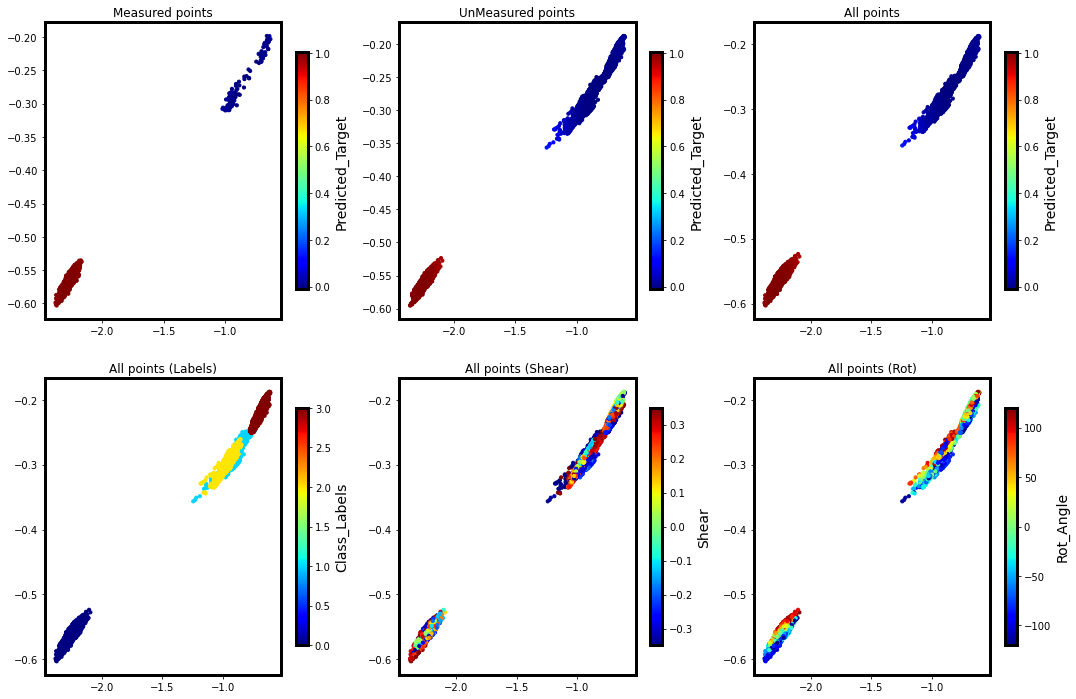

In [22]:
# Visualizing the latent space embeddings of the DKL at the end of the exploration

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train0[:, 1], embeded_train0[:, 0], s=10, c = predmean_train0, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured0[:, 1], embeded_unmeasured0[:, 0], s=10,
                c = predmean_unmeas0, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = predmean10, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Case-1 
Target Function: 1 for Spades and 0 for the rest of the classes

In [25]:
# First we will run the DKL on the whole dataset in one go
X1 = np.copy(X)   # Copying the entire input dataset

# Preparing the targets/outputs
targets1 = np.zeros(len(labels_all))
targets1[labels_all == 1] = 1

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

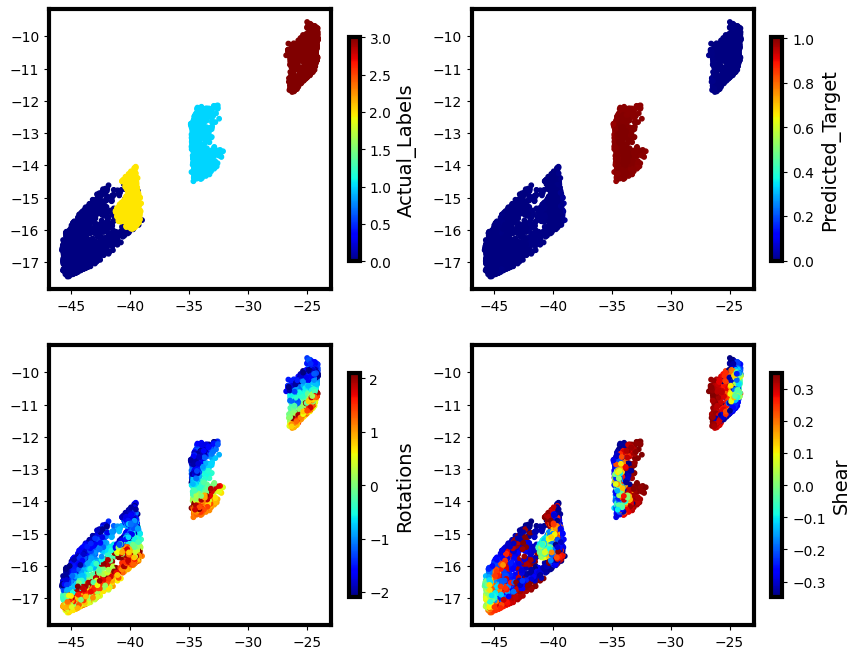

In [ ]:
# Running the DKL on the whole dataset
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(900, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)


# Latent space Embedding and prediction on the whole input dataset
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=250)
pred_std1 = jnp.sqrt(pred_var1)


# Visualization of latent space distributions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO

np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = 100, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])
    
    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets1[ind_next]
    
    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)
    
    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=100)
    
    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)


# Saving the results
spades_results = {}
spades_results['X_train'] = X1_train
spades_results['y_train'] = y1_train
spades_results['X_unmeasured'] = X1_unmeasured
spades_results['indices_unmeasured'] = indices_unmeasured_1
spades_results['dkl_mean'] = dkl_mean1
spades_results['dkl_std'] = dkl_std1
spades_results['exp_mean'] = exp_mean1
spades_results['exp_std'] = exp_std1
spades_results['traj_mean'] = traj_mean1
spades_results['traj_std'] = traj_std1
spades_results['embed_traj'] = embed_traj1

with open('spades_results.pickle', 'wb') as handle:
    pickle.dump(spades_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 387.81it/s, init loss: 60204.9053, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4237 0.5388]
k_scale          0.3795
noise            0.0115

Step 2


100%|█| 1000/1000 [00:02<00:00, 388.93it/s, init loss: 60206.4104, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6614 0.5681]
k_scale          0.3647
noise            0.0128

Step 3


100%|█| 1000/1000 [00:03<00:00, 304.71it/s, init loss: 60207.6476, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4018 0.3967]
k_scale          0.3708
noise            0.0117

Step 4


100%|█| 1000/1000 [00:02<00:00, 385.22it/s, init loss: 60208.8742, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6027 0.4997]
k_scale          0.3785
noise            0.0105

Step 5


100%|█| 1000/1000 [00:02<00:00, 386.33it/s, init loss: 60210.1185, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4803 0.5626]
k_scale          0.37510000000000004
noise            0.013000000000000001

Step 6


100%|█| 1000/1000 [00:02<00:00, 389.69it/s, init loss: 60211.4698, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4484 0.4218]
k_scale          0.34800000000000003
noise            0.0117

Step 7


100%|█| 1000/1000 [00:02<00:00, 390.71it/s, init loss: 60212.7141, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4671 0.4336]
k_scale          0.39630000000000004
noise            0.011300000000000001

Step 8


100%|█| 1000/1000 [00:02<00:00, 391.54it/s, init loss: 60214.2192, avg. loss [95



Inferred GP kernel parameters
k_length         [0.414  0.4418]
k_scale          0.27
noise            0.0125

Step 9


100%|█| 1000/1000 [00:02<00:00, 382.25it/s, init loss: 60215.4635, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4536 0.4195]
k_scale          0.4031
noise            0.0095

Step 10


100%|█| 1000/1000 [00:02<00:00, 385.67it/s, init loss: 60216.7057, avg. loss [95



Inferred GP kernel parameters
k_length         [0.491  0.6134]
k_scale          0.3062
noise            0.018500000000000003

Step 11


100%|█| 1000/1000 [00:02<00:00, 386.85it/s, init loss: 60218.2095, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4814 0.4026]
k_scale          0.34900000000000003
noise            0.0128

Step 12


100%|█| 1000/1000 [00:02<00:00, 388.42it/s, init loss: 60219.4538, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4988 0.4656]
k_scale          0.2627
noise            0.0145

Step 13


100%|█| 1000/1000 [00:02<00:00, 387.65it/s, init loss: 60220.6658, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4199 0.3867]
k_scale          0.36200000000000004
noise            0.012

Step 14


100%|█| 1000/1000 [00:03<00:00, 327.57it/s, init loss: 60221.9101, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5973 0.6713]
k_scale          0.3128
noise            0.0114

Step 15


100%|█| 1000/1000 [00:02<00:00, 382.07it/s, init loss: 60223.3435, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6351 0.673 ]
k_scale          0.262
noise            0.0145

Step 16


100%|█| 1000/1000 [00:02<00:00, 385.09it/s, init loss: 60224.5766, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5669 0.5058]
k_scale          0.4328
noise            0.0098

Step 17


100%|█| 1000/1000 [00:02<00:00, 389.02it/s, init loss: 60225.7768, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4459 0.3801]
k_scale          0.32220000000000004
noise            0.0134

Step 18


100%|█| 1000/1000 [00:02<00:00, 388.15it/s, init loss: 60227.2014, avg. loss [95



Inferred GP kernel parameters
k_length         [0.308  0.3355]
k_scale          0.3129
noise            0.0132

Step 19


100%|█| 1000/1000 [00:02<00:00, 391.24it/s, init loss: 60228.5800, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6834 0.7396]
k_scale          0.2967
noise            0.0145

Step 20


100%|█| 1000/1000 [00:03<00:00, 324.83it/s, init loss: 60229.7803, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4168 0.5525]
k_scale          0.2847
noise            0.0164

Step 21


100%|█| 1000/1000 [00:02<00:00, 383.64it/s, init loss: 60231.0227, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0513 0.574 ]
k_scale          0.2349
noise            0.013000000000000001

Step 22


100%|█| 1000/1000 [00:02<00:00, 385.27it/s, init loss: 60232.1898, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5858 0.6332]
k_scale          0.29100000000000004
noise            0.0143

Step 23


100%|█| 1000/1000 [00:02<00:00, 387.21it/s, init loss: 60233.4094, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3629 0.4874]
k_scale          0.2359
noise            0.0137

Step 24


100%|█| 1000/1000 [00:02<00:00, 384.53it/s, init loss: 60234.5944, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3569 0.2618]
k_scale          0.335
noise            0.0115

Step 25


100%|█| 1000/1000 [00:02<00:00, 388.23it/s, init loss: 60235.9533, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5151 0.5648]
k_scale          0.3136
noise            0.0122

Step 26


100%|█| 1000/1000 [00:02<00:00, 375.21it/s, init loss: 60237.1864, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3948 0.357 ]
k_scale          0.29910000000000003
noise            0.011300000000000001

Step 27


100%|█| 1000/1000 [00:02<00:00, 379.58it/s, init loss: 60238.6343, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4035 0.4028]
k_scale          0.26830000000000004
noise            0.0115

Step 28


100%|█| 1000/1000 [00:02<00:00, 382.19it/s, init loss: 60239.7856, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6677 0.6088]
k_scale          0.4234
noise            0.0095

Step 29


100%|█| 1000/1000 [00:02<00:00, 386.01it/s, init loss: 60241.1075, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4888 0.4896]
k_scale          0.4334
noise            0.010400000000000001

Step 30


100%|█| 1000/1000 [00:02<00:00, 376.91it/s, init loss: 60242.2836, avg. loss [95



Inferred GP kernel parameters
k_length         [0.56 0.61]
k_scale          0.3395
noise            0.0111

Step 31


100%|█| 1000/1000 [00:03<00:00, 321.31it/s, init loss: 60243.5242, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6966 0.7475]
k_scale          0.3665
noise            0.010400000000000001

Step 32


100%|█| 1000/1000 [00:02<00:00, 379.32it/s, init loss: 60244.7682, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5373 0.7301]
k_scale          0.2752
noise            0.0128

Step 33


100%|█| 1000/1000 [00:02<00:00, 377.18it/s, init loss: 60246.2584, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9296 0.6797]
k_scale          0.3027
noise            0.0145

Step 34


100%|█| 1000/1000 [00:02<00:00, 381.05it/s, init loss: 60247.7636, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6858 0.5585]
k_scale          0.29350000000000004
noise            0.013000000000000001

Step 35


100%|█| 1000/1000 [00:02<00:00, 383.09it/s, init loss: 60249.0078, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1241 0.9966]
k_scale          0.30670000000000003
noise            0.0105

Step 36


100%|█| 1000/1000 [00:02<00:00, 386.66it/s, init loss: 60250.5044, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6057 0.7886]
k_scale          0.2853
noise            0.013000000000000001

Step 37


100%|█| 1000/1000 [00:03<00:00, 302.57it/s, init loss: 60251.6684, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6009 0.5369]
k_scale          0.33140000000000003
noise            0.0142

Step 38


100%|█| 1000/1000 [00:02<00:00, 376.71it/s, init loss: 60253.1733, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8099 0.8164]
k_scale          0.29000000000000004
noise            0.0111

Step 39


100%|█| 1000/1000 [00:02<00:00, 379.57it/s, init loss: 60254.3904, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7991 0.8409]
k_scale          0.3528
noise            0.0118

Step 40


100%|█| 1000/1000 [00:02<00:00, 382.98it/s, init loss: 60255.5554, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3881 0.4558]
k_scale          0.3774
noise            0.012

Step 41


100%|█| 1000/1000 [00:02<00:00, 383.61it/s, init loss: 60257.0523, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6545 0.4456]
k_scale          0.4259
noise            0.0109

Step 42


100%|█| 1000/1000 [00:02<00:00, 381.03it/s, init loss: 60258.5575, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4837 0.5519]
k_scale          0.3426
noise            0.0108

Step 43


100%|█| 1000/1000 [00:02<00:00, 371.19it/s, init loss: 60259.8017, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9662 0.6861]
k_scale          0.3623
noise            0.013000000000000001

Step 44


100%|█| 1000/1000 [00:02<00:00, 377.05it/s, init loss: 60261.0100, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6529 0.6502]
k_scale          0.30360000000000004
noise            0.0108

Step 45


100%|█| 1000/1000 [00:02<00:00, 380.04it/s, init loss: 60262.2076, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6458 0.6045]
k_scale          0.39380000000000004
noise            0.0105

Step 46


100%|█| 1000/1000 [00:02<00:00, 376.24it/s, init loss: 60263.7098, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8386 0.8352]
k_scale          0.2882
noise            0.0128

Step 47


100%|█| 1000/1000 [00:02<00:00, 379.01it/s, init loss: 60264.9181, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7823 0.8188]
k_scale          0.3956
noise            0.012

Step 48


100%|█| 1000/1000 [00:02<00:00, 381.23it/s, init loss: 60266.4230, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4773 0.4008]
k_scale          0.3284
noise            0.014700000000000001

Step 49


100%|█| 1000/1000 [00:02<00:00, 371.55it/s, init loss: 60267.9234, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8314 0.918 ]
k_scale          0.29100000000000004
noise            0.0131

Step 50


100%|█| 1000/1000 [00:02<00:00, 377.29it/s, init loss: 60269.1255, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3131 0.6832]
k_scale          0.2629
noise            0.012400000000000001

Step 51


100%|█| 1000/1000 [00:02<00:00, 377.24it/s, init loss: 60270.3696, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6857 0.7329]
k_scale          0.3337
noise            0.0119

Step 52


100%|█| 1000/1000 [00:02<00:00, 380.45it/s, init loss: 60271.5992, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9509 0.7439]
k_scale          0.2461
noise            0.013800000000000002

Step 53


100%|█| 1000/1000 [00:02<00:00, 381.40it/s, init loss: 60272.8248, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1852 1.1318]
k_scale          0.364
noise            0.0109

Step 54


100%|█| 1000/1000 [00:03<00:00, 308.15it/s, init loss: 60274.3292, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6558 0.7212]
k_scale          0.2432
noise            0.0122

Step 55


100%|█| 1000/1000 [00:02<00:00, 376.64it/s, init loss: 60275.8094, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4583 0.5377]
k_scale          0.34440000000000004
noise            0.0128

Step 56


100%|█| 1000/1000 [00:02<00:00, 379.09it/s, init loss: 60276.9956, avg. loss [95



Inferred GP kernel parameters
k_length         [0.899  0.9958]
k_scale          0.27240000000000003
noise            0.0125

Step 57


100%|█| 1000/1000 [00:02<00:00, 379.32it/s, init loss: 60278.2219, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7087 0.9391]
k_scale          0.2891
noise            0.0125

Step 58


100%|█| 1000/1000 [00:02<00:00, 382.96it/s, init loss: 60279.4662, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8994 0.6448]
k_scale          0.2677
noise            0.014400000000000001

Step 59


100%|█| 1000/1000 [00:02<00:00, 380.96it/s, init loss: 60280.9713, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3886 0.4252]
k_scale          0.43160000000000004
noise            0.0123

Step 60


100%|█| 1000/1000 [00:03<00:00, 300.37it/s, init loss: 60282.1164, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6707 0.6181]
k_scale          0.4062
noise            0.0109

Step 61


100%|█| 1000/1000 [00:02<00:00, 375.86it/s, init loss: 60283.5563, avg. loss [95



Inferred GP kernel parameters
k_length         [0.65   0.7665]
k_scale          0.339
noise            0.014400000000000001

Step 62


100%|█| 1000/1000 [00:02<00:00, 374.36it/s, init loss: 60284.7634, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6896 0.8731]
k_scale          0.2666
noise            0.0109

Step 63


100%|█| 1000/1000 [00:02<00:00, 378.63it/s, init loss: 60285.9537, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5231 0.6299]
k_scale          0.3209
noise            0.012400000000000001

Step 64


100%|█| 1000/1000 [00:02<00:00, 379.71it/s, init loss: 60287.4123, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5804 0.5743]
k_scale          0.38680000000000003
noise            0.0099

Step 65


100%|█| 1000/1000 [00:02<00:00, 379.20it/s, init loss: 60288.9061, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2009 1.0815]
k_scale          0.27440000000000003
noise            0.012400000000000001

Step 66


100%|█| 1000/1000 [00:02<00:00, 359.52it/s, init loss: 60290.0838, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0024 0.8319]
k_scale          0.2679
noise            0.014

Step 67


100%|█| 1000/1000 [00:02<00:00, 373.72it/s, init loss: 60291.2987, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6126 0.5753]
k_scale          0.4166
noise            0.0108

Step 68


100%|█| 1000/1000 [00:02<00:00, 374.84it/s, init loss: 60292.6873, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5032 0.5845]
k_scale          0.3769
noise            0.0105

Step 69


100%|█| 1000/1000 [00:02<00:00, 368.12it/s, init loss: 60293.9103, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0207 0.7744]
k_scale          0.3497
noise            0.0108

Step 70


100%|█| 1000/1000 [00:02<00:00, 369.27it/s, init loss: 60295.0899, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8544 1.0802]
k_scale          0.2831
noise            0.0125

Step 71


100%|█| 1000/1000 [00:02<00:00, 368.75it/s, init loss: 60296.3306, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0041 0.9228]
k_scale          0.3468
noise            0.0122

Step 72


100%|█| 1000/1000 [00:02<00:00, 363.82it/s, init loss: 60297.4948, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6573 0.7258]
k_scale          0.2859
noise            0.014400000000000001

Step 73


100%|█| 1000/1000 [00:02<00:00, 361.83it/s, init loss: 60298.7336, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8406 0.83  ]
k_scale          0.3196
noise            0.0119

Step 74


100%|█| 1000/1000 [00:02<00:00, 367.64it/s, init loss: 60300.2373, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5276 0.5561]
k_scale          0.3753
noise            0.0125

Step 75


100%|█| 1000/1000 [00:02<00:00, 369.96it/s, init loss: 60301.4609, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9464 0.663 ]
k_scale          0.2733
noise            0.014700000000000001

Step 76


100%|█| 1000/1000 [00:02<00:00, 369.92it/s, init loss: 60302.6685, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7724 0.767 ]
k_scale          0.3539
noise            0.01

Step 77


100%|█| 1000/1000 [00:02<00:00, 372.55it/s, init loss: 60303.8390, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6829 0.6308]
k_scale          0.4053
noise            0.010400000000000001

Step 78


100%|█| 1000/1000 [00:02<00:00, 362.21it/s, init loss: 60305.0523, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7694 0.799 ]
k_scale          0.2549
noise            0.012400000000000001

Step 79


100%|█| 1000/1000 [00:02<00:00, 367.09it/s, init loss: 60306.2963, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5635 0.7179]
k_scale          0.2604
noise            0.014100000000000001

Step 80


100%|█| 1000/1000 [00:02<00:00, 367.28it/s, init loss: 60307.5270, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3145 0.4291]
k_scale          0.28350000000000003
noise            0.0117

Step 81


100%|█| 1000/1000 [00:02<00:00, 368.28it/s, init loss: 60308.6928, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5079 0.5312]
k_scale          0.2474
noise            0.012400000000000001

Step 82


100%|█| 1000/1000 [00:02<00:00, 372.55it/s, init loss: 60310.1665, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6188 0.6275]
k_scale          0.2775
noise            0.011300000000000001

Step 83


100%|█| 1000/1000 [00:03<00:00, 267.87it/s, init loss: 60311.3983, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1336 1.2021]
k_scale          0.2076
noise            0.0171

Step 84


100%|█| 1000/1000 [00:02<00:00, 365.43it/s, init loss: 60312.9034, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8569 0.6014]
k_scale          0.26280000000000003
noise            0.010400000000000001

Step 85


100%|█| 1000/1000 [00:02<00:00, 368.31it/s, init loss: 60314.1022, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5946 0.7078]
k_scale          0.3114
noise            0.0112

Step 86


100%|█| 1000/1000 [00:02<00:00, 369.61it/s, init loss: 60315.3211, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4985 0.8531]
k_scale          0.3941
noise            0.009300000000000001

Step 87


100%|█| 1000/1000 [00:02<00:00, 367.72it/s, init loss: 60316.4976, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7418 0.6564]
k_scale          0.20040000000000002
noise            0.011600000000000001

Step 88


100%|█| 1000/1000 [00:02<00:00, 369.76it/s, init loss: 60317.9855, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8462 0.9672]
k_scale          0.186
noise            0.009600000000000001

Step 89


100%|█| 1000/1000 [00:03<00:00, 263.61it/s, init loss: 60319.3596, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5362 0.4757]
k_scale          0.3521
noise            0.0114

Step 90


100%|█| 1000/1000 [00:02<00:00, 364.86it/s, init loss: 60320.5243, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7332 0.7165]
k_scale          0.3286
noise            0.013000000000000001

Step 91


100%|█| 1000/1000 [00:02<00:00, 368.99it/s, init loss: 60321.7207, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1237 1.2102]
k_scale          0.2918
noise            0.0123

Step 92


100%|█| 1000/1000 [00:02<00:00, 368.57it/s, init loss: 60322.8947, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6123 0.4699]
k_scale          0.25520000000000004
noise            0.0106

Step 93


100%|█| 1000/1000 [00:02<00:00, 366.62it/s, init loss: 60324.3992, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9848 0.7875]
k_scale          0.2816
noise            0.012

Step 94


100%|█| 1000/1000 [00:02<00:00, 364.12it/s, init loss: 60325.5641, avg. loss [95



Inferred GP kernel parameters
k_length         [0.963  1.2676]
k_scale          0.1748
noise            0.011000000000000001

Step 95


100%|█| 1000/1000 [00:02<00:00, 354.92it/s, init loss: 60326.8319, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7919 0.8575]
k_scale          0.224
noise            0.0094

Step 96


100%|█| 1000/1000 [00:02<00:00, 364.77it/s, init loss: 60328.1577, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5448 0.5159]
k_scale          0.2874
noise            0.0082

Step 97


100%|█| 1000/1000 [00:02<00:00, 366.86it/s, init loss: 60329.3594, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3935 0.353 ]
k_scale          0.26880000000000004
noise            0.011600000000000001

Step 98


100%|█| 1000/1000 [00:02<00:00, 368.49it/s, init loss: 60330.5770, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6864 0.7013]
k_scale          0.272
noise            0.011300000000000001

Step 99


100%|█| 1000/1000 [00:02<00:00, 367.12it/s, init loss: 60332.0631, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6349 0.5105]
k_scale          0.37870000000000004
noise            0.0115

Step 100


100%|█| 1000/1000 [00:02<00:00, 366.60it/s, init loss: 60333.1753, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5515 0.5522]
k_scale          0.2657
noise            0.0081

Step 101


100%|█| 1000/1000 [00:02<00:00, 353.82it/s, init loss: 60334.4188, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5042 0.6617]
k_scale          0.31770000000000004
noise            0.0114

Step 102


100%|█| 1000/1000 [00:02<00:00, 361.68it/s, init loss: 60335.5559, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8401 0.6838]
k_scale          0.2533
noise            0.011600000000000001

Step 103


100%|█| 1000/1000 [00:02<00:00, 361.81it/s, init loss: 60336.8504, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0534 0.9069]
k_scale          0.21810000000000002
noise            0.013800000000000002

Step 104


100%|█| 1000/1000 [00:02<00:00, 367.23it/s, init loss: 60338.0884, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4951 0.5176]
k_scale          0.266
noise            0.0126

Step 105


100%|█| 1000/1000 [00:02<00:00, 366.53it/s, init loss: 60339.3015, avg. loss [95



Inferred GP kernel parameters
k_length         [0.632  0.6982]
k_scale          0.2655
noise            0.011600000000000001

Step 106


100%|█| 1000/1000 [00:03<00:00, 263.67it/s, init loss: 60340.6260, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1079 1.0205]
k_scale          0.27490000000000003
noise            0.0097

Step 107


100%|█| 1000/1000 [00:02<00:00, 360.40it/s, init loss: 60341.8666, avg. loss [95



Inferred GP kernel parameters
k_length         [0.841  0.9406]
k_scale          0.2751
noise            0.011000000000000001

Step 108


100%|█| 1000/1000 [00:02<00:00, 361.09it/s, init loss: 60343.2963, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2066 1.0995]
k_scale          0.22290000000000001
noise            0.0092

Step 109


100%|█| 1000/1000 [00:02<00:00, 362.70it/s, init loss: 60344.4515, avg. loss [95



Inferred GP kernel parameters
k_length         [0.526  0.7136]
k_scale          0.2142
noise            0.0108

Step 110


100%|█| 1000/1000 [00:02<00:00, 360.82it/s, init loss: 60345.6939, avg. loss [95



Inferred GP kernel parameters
k_length         [0.812  1.0686]
k_scale          0.19410000000000002
noise            0.0114

Step 111


100%|█| 1000/1000 [00:02<00:00, 363.94it/s, init loss: 60347.1837, avg. loss [95



Inferred GP kernel parameters
k_length         [1.279 1.026]
k_scale          0.1693
noise            0.0112

Step 112


100%|█| 1000/1000 [00:03<00:00, 253.94it/s, init loss: 60348.5958, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1322 0.9353]
k_scale          0.22840000000000002
noise            0.0099

Step 113


100%|█| 1000/1000 [00:02<00:00, 354.58it/s, init loss: 60350.0485, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9245 0.5946]
k_scale          0.312
noise            0.013600000000000001

Step 114


100%|█| 1000/1000 [00:02<00:00, 356.82it/s, init loss: 60351.2595, avg. loss [95



Inferred GP kernel parameters
k_length         [1.128  0.8483]
k_scale          0.2021
noise            0.0095

Step 115


100%|█| 1000/1000 [00:02<00:00, 358.54it/s, init loss: 60352.7488, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7999 0.9187]
k_scale          0.34790000000000004
noise            0.0091

Step 116


100%|█| 1000/1000 [00:02<00:00, 360.15it/s, init loss: 60354.1023, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8688 0.7342]
k_scale          0.3473
noise            0.0111

Step 117


100%|█| 1000/1000 [00:02<00:00, 360.39it/s, init loss: 60355.5844, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6646 0.7426]
k_scale          0.29960000000000003
noise            0.0126

Step 118


100%|█| 1000/1000 [00:02<00:00, 347.06it/s, init loss: 60356.7464, avg. loss [95



Inferred GP kernel parameters
k_length         [0.447  0.4729]
k_scale          0.2922
noise            0.0126

Step 119


100%|█| 1000/1000 [00:02<00:00, 353.96it/s, init loss: 60357.9110, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6584 0.7042]
k_scale          0.33340000000000003
noise            0.0109

Step 120


100%|█| 1000/1000 [00:02<00:00, 357.90it/s, init loss: 60359.3116, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6089 3.3177]
k_scale          0.13040000000000002
noise            0.0115

Step 121


100%|█| 1000/1000 [00:02<00:00, 368.07it/s, init loss: 60360.7668, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8146 0.9016]
k_scale          0.2151
noise            0.0175

Step 122


100%|█| 1000/1000 [00:02<00:00, 361.29it/s, init loss: 60361.9813, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7688 0.8242]
k_scale          0.3032
noise            0.0126

Step 123


100%|█| 1000/1000 [00:02<00:00, 366.90it/s, init loss: 60363.2103, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6838 0.6748]
k_scale          0.298
noise            0.01

Step 124


100%|█| 1000/1000 [00:02<00:00, 349.94it/s, init loss: 60364.4502, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6708 0.5175]
k_scale          0.2725
noise            0.0083

Step 125


100%|█| 1000/1000 [00:02<00:00, 354.03it/s, init loss: 60365.9223, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6526 0.7741]
k_scale          0.23770000000000002
noise            0.0085

Step 126


100%|█| 1000/1000 [00:02<00:00, 356.54it/s, init loss: 60367.3923, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0981 1.1027]
k_scale          0.1937
noise            0.0117

Step 127


100%|█| 1000/1000 [00:02<00:00, 359.93it/s, init loss: 60368.6366, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2587 0.9723]
k_scale          0.2803
noise            0.0114

Step 128


100%|█| 1000/1000 [00:02<00:00, 361.48it/s, init loss: 60369.8648, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7355 1.2471]
k_scale          0.2223
noise            0.010400000000000001

Step 129


100%|█| 1000/1000 [00:02<00:00, 363.94it/s, init loss: 60371.3698, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9354 1.0844]
k_scale          0.1797
noise            0.0111

Step 130


100%|█| 1000/1000 [00:02<00:00, 355.79it/s, init loss: 60372.8750, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8674 0.7149]
k_scale          0.2541
noise            0.0091

Step 131


100%|█| 1000/1000 [00:02<00:00, 359.18it/s, init loss: 60374.3800, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0187 0.9   ]
k_scale          0.24020000000000002
noise            0.0126

Step 132


100%|█| 1000/1000 [00:02<00:00, 360.68it/s, init loss: 60375.8547, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8457 0.9047]
k_scale          0.24810000000000001
noise            0.0086

Step 133


100%|█| 1000/1000 [00:02<00:00, 359.52it/s, init loss: 60377.2504, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0026 0.7162]
k_scale          0.24130000000000001
noise            0.0129

Step 134


100%|█| 1000/1000 [00:02<00:00, 367.10it/s, init loss: 60378.4721, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5323 1.2392]
k_scale          0.1688
noise            0.0109

Step 135


100%|█| 1000/1000 [00:03<00:00, 288.05it/s, init loss: 60379.8933, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8934 0.6765]
k_scale          0.2439
noise            0.009300000000000001

Step 136


100%|█| 1000/1000 [00:02<00:00, 354.89it/s, init loss: 60381.3764, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2966 0.867 ]
k_scale          0.1553
noise            0.0135

Step 137


100%|█| 1000/1000 [00:02<00:00, 356.33it/s, init loss: 60382.8732, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8909 0.9776]
k_scale          0.2513
noise            0.0094

Step 138


100%|█| 1000/1000 [00:02<00:00, 354.61it/s, init loss: 60384.0860, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9011 0.8816]
k_scale          0.2288
noise            0.0094

Step 139


100%|█| 1000/1000 [00:02<00:00, 359.04it/s, init loss: 60385.5571, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8713 0.9855]
k_scale          0.2978
noise            0.0106

Step 140


100%|█| 1000/1000 [00:02<00:00, 361.03it/s, init loss: 60386.7344, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8066 1.1656]
k_scale          0.225
noise            0.013600000000000001

Step 141


100%|█| 1000/1000 [00:03<00:00, 257.77it/s, init loss: 60387.8968, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0939 1.2363]
k_scale          0.1819
noise            0.011300000000000001

Step 142


100%|█| 1000/1000 [00:02<00:00, 360.05it/s, init loss: 60389.0808, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1221 1.3426]
k_scale          0.1882
noise            0.0091

Step 143


100%|█| 1000/1000 [00:02<00:00, 365.29it/s, init loss: 60390.4865, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6957 0.9869]
k_scale          0.20800000000000002
noise            0.0128

Step 144


100%|█| 1000/1000 [00:02<00:00, 368.29it/s, init loss: 60391.6656, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2568 1.7259]
k_scale          0.154
noise            0.010100000000000001

Step 145


100%|█| 1000/1000 [00:02<00:00, 368.94it/s, init loss: 60393.1712, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2185 1.1177]
k_scale          0.1831
noise            0.009600000000000001

Step 146


100%|█| 1000/1000 [00:02<00:00, 370.06it/s, init loss: 60394.5563, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5104 1.7094]
k_scale          0.1855
noise            0.009000000000000001

Step 147


100%|█| 1000/1000 [00:03<00:00, 288.23it/s, init loss: 60395.8308, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2196 0.8794]
k_scale          0.1778
noise            0.0115

Step 148


100%|█| 1000/1000 [00:02<00:00, 360.92it/s, init loss: 60397.0566, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6625 0.7636]
k_scale          0.2129
noise            0.0114

Step 149


100%|█| 1000/1000 [00:02<00:00, 363.20it/s, init loss: 60398.3005, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0932 0.8432]
k_scale          0.2349
noise            0.0083

Step 150


100%|█| 1000/1000 [00:02<00:00, 366.79it/s, init loss: 60399.7868, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9665 0.7484]
k_scale          0.2877
noise            0.013600000000000001

Step 151


100%|█| 1000/1000 [00:02<00:00, 363.33it/s, init loss: 60400.9664, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7912 1.3443]
k_scale          0.23800000000000002
noise            0.009000000000000001

Step 152


100%|█| 1000/1000 [00:02<00:00, 366.99it/s, init loss: 60402.4634, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1402 0.9781]
k_scale          0.22160000000000002
noise            0.0091

Step 153


100%|█| 1000/1000 [00:02<00:00, 355.41it/s, init loss: 60403.7145, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8788 1.2326]
k_scale          0.154
noise            0.0118

Step 154


100%|█| 1000/1000 [00:02<00:00, 358.88it/s, init loss: 60405.0497, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8766 0.7386]
k_scale          0.2409
noise            0.0103

Step 155


100%|█| 1000/1000 [00:02<00:00, 361.13it/s, init loss: 60406.1908, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2314 1.2201]
k_scale          0.1691
noise            0.0106

Step 156


100%|█| 1000/1000 [00:02<00:00, 362.54it/s, init loss: 60407.6683, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7446 0.6804]
k_scale          0.2452
noise            0.01

Step 157


100%|█| 1000/1000 [00:02<00:00, 363.10it/s, init loss: 60408.9262, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7436 0.9089]
k_scale          0.23750000000000002
noise            0.016300000000000002

Step 158


100%|█| 1000/1000 [00:02<00:00, 363.19it/s, init loss: 60410.1133, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5528 2.0699]
k_scale          0.19460000000000002
noise            0.0092

Step 159


100%|█| 1000/1000 [00:02<00:00, 352.07it/s, init loss: 60411.4388, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9374 0.6812]
k_scale          0.2625
noise            0.0079

Step 160


100%|█| 1000/1000 [00:02<00:00, 357.30it/s, init loss: 60412.8789, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9905 1.1818]
k_scale          0.1978
noise            0.0115

Step 161


100%|█| 1000/1000 [00:02<00:00, 357.40it/s, init loss: 60414.0143, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3381 1.1146]
k_scale          0.2076
noise            0.010100000000000001

Step 162


100%|█| 1000/1000 [00:02<00:00, 360.68it/s, init loss: 60415.4124, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9383 0.658 ]
k_scale          0.2733
noise            0.0117

Step 163


100%|█| 1000/1000 [00:02<00:00, 361.01it/s, init loss: 60416.8498, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9136 1.0905]
k_scale          0.17880000000000001
noise            0.0131

Step 164


100%|█| 1000/1000 [00:03<00:00, 286.39it/s, init loss: 60418.0326, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8972 1.4728]
k_scale          0.22840000000000002
noise            0.0097

Step 165


100%|█| 1000/1000 [00:02<00:00, 355.63it/s, init loss: 60419.4403, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5168 0.5264]
k_scale          0.3166
noise            0.0154

Step 166


100%|█| 1000/1000 [00:02<00:00, 359.80it/s, init loss: 60420.8419, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4889 2.8933]
k_scale          0.1754
noise            0.0128

Step 167


100%|█| 1000/1000 [00:02<00:00, 362.04it/s, init loss: 60422.1561, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0249 1.1079]
k_scale          0.18910000000000002
noise            0.0099

Step 168


100%|█| 1000/1000 [00:02<00:00, 361.92it/s, init loss: 60423.3448, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6124 0.6598]
k_scale          0.3033
noise            0.0117

Step 169


100%|█| 1000/1000 [00:02<00:00, 362.92it/s, init loss: 60424.7512, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2597 1.0873]
k_scale          0.18530000000000002
noise            0.010700000000000001

Step 170


100%|█| 1000/1000 [00:03<00:00, 285.02it/s, init loss: 60426.2466, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7501 0.8553]
k_scale          0.2574
noise            0.010400000000000001

Step 171


100%|█| 1000/1000 [00:02<00:00, 354.93it/s, init loss: 60427.7514, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9475 2.703 ]
k_scale          0.15380000000000002
noise            0.0106

Step 172


100%|█| 1000/1000 [00:02<00:00, 359.43it/s, init loss: 60429.2478, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2041 1.726 ]
k_scale          0.17700000000000002
noise            0.009600000000000001

Step 173


100%|█| 1000/1000 [00:02<00:00, 360.40it/s, init loss: 60430.4675, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2221 1.8022]
k_scale          0.17550000000000002
noise            0.0097

Step 174


100%|█| 1000/1000 [00:02<00:00, 358.78it/s, init loss: 60431.8398, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1439 1.2823]
k_scale          0.1947
noise            0.0105

Step 175


100%|█| 1000/1000 [00:02<00:00, 359.36it/s, init loss: 60433.3441, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7626 0.8063]
k_scale          0.2351
noise            0.008700000000000001

Step 176


100%|█| 1000/1000 [00:03<00:00, 280.50it/s, init loss: 60434.6730, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6766 1.9316]
k_scale          0.2721
noise            0.0114

Step 177


100%|█| 1000/1000 [00:02<00:00, 352.76it/s, init loss: 60436.0618, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6921 0.5444]
k_scale          0.3896
noise            0.011000000000000001

Step 178


100%|█| 1000/1000 [00:02<00:00, 359.22it/s, init loss: 60437.2220, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9247 0.9492]
k_scale          0.22030000000000002
noise            0.0125

Step 179


100%|█| 1000/1000 [00:02<00:00, 360.65it/s, init loss: 60438.3975, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1714 0.877 ]
k_scale          0.2741
noise            0.0088

Step 180


100%|█| 1000/1000 [00:02<00:00, 362.02it/s, init loss: 60439.6962, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8359 0.9352]
k_scale          0.2068
noise            0.0091

Step 181


100%|█| 1000/1000 [00:02<00:00, 362.67it/s, init loss: 60440.9212, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5154 3.0555]
k_scale          0.15410000000000001
noise            0.0109

Step 182


100%|█| 1000/1000 [00:03<00:00, 283.55it/s, init loss: 60442.2061, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5073 1.6321]
k_scale          0.1698
noise            0.009300000000000001

Step 183


100%|█| 1000/1000 [00:02<00:00, 355.63it/s, init loss: 60443.6996, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2282 1.1992]
k_scale          0.2121
noise            0.011300000000000001

Step 184


100%|█| 1000/1000 [00:02<00:00, 359.37it/s, init loss: 60444.8356, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3562 1.4695]
k_scale          0.18000000000000002
noise            0.0099

Step 185


100%|█| 1000/1000 [00:02<00:00, 358.85it/s, init loss: 60446.1598, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9263 1.2007]
k_scale          0.1656
noise            0.0106

Step 186


100%|█| 1000/1000 [00:02<00:00, 360.36it/s, init loss: 60447.4960, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7384 2.5974]
k_scale          0.13390000000000002
noise            0.0097

Step 187


100%|█| 1000/1000 [00:02<00:00, 363.05it/s, init loss: 60449.0011, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2326 1.2952]
k_scale          0.1723
noise            0.009300000000000001

Step 188


100%|█| 1000/1000 [00:02<00:00, 349.82it/s, init loss: 60450.4460, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8833 0.9501]
k_scale          0.2484
noise            0.0106

Step 189


100%|█| 1000/1000 [00:02<00:00, 354.17it/s, init loss: 60451.6866, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1335 1.1093]
k_scale          0.18810000000000002
noise            0.008700000000000001

Step 190


100%|█| 1000/1000 [00:02<00:00, 355.88it/s, init loss: 60453.0620, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4553 1.2176]
k_scale          0.2078
noise            0.0092

Step 191


100%|█| 1000/1000 [00:02<00:00, 354.91it/s, init loss: 60454.4356, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8947 0.7737]
k_scale          0.24580000000000002
noise            0.0083

Step 192


100%|█| 1000/1000 [00:02<00:00, 356.82it/s, init loss: 60455.8762, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7648 0.6753]
k_scale          0.3821
noise            0.0152

Step 193


100%|█| 1000/1000 [00:02<00:00, 357.79it/s, init loss: 60457.0253, avg. loss [95



Inferred GP kernel parameters
k_length         [0.611  0.7869]
k_scale          0.24930000000000002
noise            0.008400000000000001

Step 194


100%|█| 1000/1000 [00:02<00:00, 347.30it/s, init loss: 60458.2951, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9713 1.2681]
k_scale          0.22890000000000002
noise            0.0082

Step 195


100%|█| 1000/1000 [00:02<00:00, 350.16it/s, init loss: 60459.7642, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9387 2.5592]
k_scale          0.1463
noise            0.0103

Step 196


100%|█| 1000/1000 [00:02<00:00, 356.53it/s, init loss: 60461.2691, avg. loss [95



Inferred GP kernel parameters
k_length         [2.044  1.1946]
k_scale          0.19990000000000002
noise            0.0097

Step 197


100%|█| 1000/1000 [00:02<00:00, 356.39it/s, init loss: 60462.7268, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7221 1.8519]
k_scale          0.1683
noise            0.010100000000000001

Step 198


100%|█| 1000/1000 [00:02<00:00, 359.97it/s, init loss: 60463.9713, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0886 1.3291]
k_scale          0.198
noise            0.0081

Step 199


100%|█| 1000/1000 [00:03<00:00, 282.77it/s, init loss: 60465.4187, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2335 2.9345]
k_scale          0.1613
noise            0.0097

Step 200


100%|█| 1000/1000 [00:02<00:00, 351.18it/s, init loss: 60466.6485, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0377 0.9313]
k_scale          0.20700000000000002
noise            0.0092

Step 201


100%|█| 1000/1000 [00:02<00:00, 352.44it/s, init loss: 60467.8747, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9712 1.1069]
k_scale          0.1752
noise            0.0108

Step 202


100%|█| 1000/1000 [00:02<00:00, 354.89it/s, init loss: 60469.1823, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2039 1.643 ]
k_scale          0.21710000000000002
noise            0.012100000000000001

Step 203


100%|█| 1000/1000 [00:02<00:00, 356.24it/s, init loss: 60470.5364, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1701 2.6406]
k_scale          0.1874
noise            0.0129

Step 204


100%|█| 1000/1000 [00:02<00:00, 356.31it/s, init loss: 60471.6528, avg. loss [95



Inferred GP kernel parameters
k_length         [1.983 1.263]
k_scale          0.1773
noise            0.0085

Step 205


100%|█| 1000/1000 [00:03<00:00, 277.55it/s, init loss: 60473.1596, avg. loss [95



Inferred GP kernel parameters
k_length         [1.733  1.7233]
k_scale          0.1524
noise            0.0112

Step 206


100%|█| 1000/1000 [00:02<00:00, 348.69it/s, init loss: 60474.6237, avg. loss [95



Inferred GP kernel parameters
k_length         [1.521  1.0554]
k_scale          0.23600000000000002
noise            0.0094

Step 207


100%|█| 1000/1000 [00:02<00:00, 351.15it/s, init loss: 60475.7977, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3744 2.4109]
k_scale          0.152
noise            0.0099

Step 208


100%|█| 1000/1000 [00:02<00:00, 354.38it/s, init loss: 60477.0848, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2383 1.087 ]
k_scale          0.2064
noise            0.011000000000000001

Step 209


100%|█| 1000/1000 [00:02<00:00, 354.95it/s, init loss: 60478.2620, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0953 2.6546]
k_scale          0.1736
noise            0.0111

Step 210


100%|█| 1000/1000 [00:02<00:00, 357.88it/s, init loss: 60479.4774, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5556 2.4147]
k_scale          0.1637
noise            0.009300000000000001

Step 211


100%|█| 1000/1000 [00:03<00:00, 275.32it/s, init loss: 60480.7252, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1841 2.0302]
k_scale          0.1689
noise            0.0091

Step 212


100%|█| 1000/1000 [00:02<00:00, 349.77it/s, init loss: 60482.0708, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5546 1.4616]
k_scale          0.2581
noise            0.0175

Step 213


100%|█| 1000/1000 [00:02<00:00, 350.34it/s, init loss: 60483.2542, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5255 1.2582]
k_scale          0.1958
noise            0.0085

Step 214


100%|█| 1000/1000 [00:02<00:00, 355.17it/s, init loss: 60484.6889, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3226 1.7018]
k_scale          0.193
noise            0.0081

Step 215


100%|█| 1000/1000 [00:02<00:00, 354.71it/s, init loss: 60486.1132, avg. loss [95



Inferred GP kernel parameters
k_length         [0.894  0.9012]
k_scale          0.2627
noise            0.012

Step 216


100%|█| 1000/1000 [00:02<00:00, 355.56it/s, init loss: 60487.5446, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3979 2.2816]
k_scale          0.16840000000000002
noise            0.009600000000000001

Step 217


100%|█| 1000/1000 [00:03<00:00, 275.26it/s, init loss: 60489.0470, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1362 1.1369]
k_scale          0.2006
noise            0.0106

Step 218


100%|█| 1000/1000 [00:02<00:00, 350.66it/s, init loss: 60490.2388, avg. loss [95



Inferred GP kernel parameters
k_length         [1.524  2.0964]
k_scale          0.1899
noise            0.0094

Step 219


100%|█| 1000/1000 [00:02<00:00, 351.75it/s, init loss: 60491.5730, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5172 1.2972]
k_scale          0.1789
noise            0.009600000000000001

Step 220


100%|█| 1000/1000 [00:02<00:00, 353.59it/s, init loss: 60492.9768, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9268 0.8203]
k_scale          0.21530000000000002
noise            0.0128

Step 221


100%|█| 1000/1000 [00:02<00:00, 355.06it/s, init loss: 60494.1243, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0733 1.8283]
k_scale          0.1904
noise            0.011000000000000001

Step 222


100%|█| 1000/1000 [00:02<00:00, 351.87it/s, init loss: 60495.2672, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8166 3.8802]
k_scale          0.153
noise            0.010100000000000001

Step 223


100%|█| 1000/1000 [00:02<00:00, 339.26it/s, init loss: 60496.5437, avg. loss [95



Inferred GP kernel parameters
k_length         [3.456  2.3107]
k_scale          0.1193
noise            0.0125

Step 224


100%|█| 1000/1000 [00:02<00:00, 346.47it/s, init loss: 60497.7918, avg. loss [95



Inferred GP kernel parameters
k_length         [1.078 1.197]
k_scale          0.2134
noise            0.0085

Step 225


100%|█| 1000/1000 [00:02<00:00, 347.79it/s, init loss: 60499.1076, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3874 0.9687]
k_scale          0.2263
noise            0.0095

Step 226


100%|█| 1000/1000 [00:02<00:00, 351.76it/s, init loss: 60500.3253, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5479 2.1405]
k_scale          0.2232
noise            0.0123

Step 227


100%|█| 1000/1000 [00:02<00:00, 350.68it/s, init loss: 60501.5050, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3197 1.2545]
k_scale          0.2134
noise            0.0094

Step 228


100%|█| 1000/1000 [00:02<00:00, 354.64it/s, init loss: 60502.9367, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1305 1.275 ]
k_scale          0.22
noise            0.0085

Step 229


100%|█| 1000/1000 [00:02<00:00, 339.99it/s, init loss: 60504.3841, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3558 1.5196]
k_scale          0.1971
noise            0.010400000000000001

Step 230


100%|█| 1000/1000 [00:02<00:00, 347.45it/s, init loss: 60505.5726, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7887 2.175 ]
k_scale          0.15130000000000002
noise            0.0098

Step 231


100%|█| 1000/1000 [00:02<00:00, 347.72it/s, init loss: 60506.8558, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0273 1.4129]
k_scale          0.22660000000000002
noise            0.008400000000000001

Step 232


100%|█| 1000/1000 [00:02<00:00, 351.50it/s, init loss: 60508.3180, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2537 1.606 ]
k_scale          0.2053
noise            0.0081

Step 233


100%|█| 1000/1000 [00:02<00:00, 348.26it/s, init loss: 60509.8108, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8758 2.6393]
k_scale          0.13240000000000002
noise            0.010400000000000001

Step 234


100%|█| 1000/1000 [00:02<00:00, 353.34it/s, init loss: 60511.0872, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7291 1.4239]
k_scale          0.15360000000000001
noise            0.011300000000000001

Step 235


100%|█| 1000/1000 [00:02<00:00, 338.45it/s, init loss: 60512.5018, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4522 3.0144]
k_scale          0.1492
noise            0.0095

Step 236


100%|█| 1000/1000 [00:02<00:00, 346.67it/s, init loss: 60513.9587, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6758 1.1674]
k_scale          0.1822
noise            0.0092

Step 237


100%|█| 1000/1000 [00:02<00:00, 347.26it/s, init loss: 60515.3225, avg. loss [95



Inferred GP kernel parameters
k_length         [1.636 1.263]
k_scale          0.1973
noise            0.0085

Step 238


100%|█| 1000/1000 [00:02<00:00, 349.19it/s, init loss: 60516.5220, avg. loss [95



Inferred GP kernel parameters
k_length         [3.434  3.1903]
k_scale          0.1406
noise            0.0097

Step 239


100%|█| 1000/1000 [00:02<00:00, 347.08it/s, init loss: 60517.8339, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9215 1.0948]
k_scale          0.2179
noise            0.0115

Step 240


100%|█| 1000/1000 [00:03<00:00, 276.91it/s, init loss: 60519.0565, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1521 1.8424]
k_scale          0.1628
noise            0.0091

Step 241


100%|█| 1000/1000 [00:02<00:00, 344.20it/s, init loss: 60520.3155, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0848 1.6081]
k_scale          0.20750000000000002
noise            0.0083

Step 242


100%|█| 1000/1000 [00:02<00:00, 348.86it/s, init loss: 60521.5747, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0971 1.1801]
k_scale          0.231
noise            0.009000000000000001

Step 243


100%|█| 1000/1000 [00:02<00:00, 346.67it/s, init loss: 60522.9938, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9712 1.2064]
k_scale          0.19640000000000002
noise            0.0092

Step 244


100%|█| 1000/1000 [00:02<00:00, 351.82it/s, init loss: 60524.4864, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2889 1.3183]
k_scale          0.2154
noise            0.0088

Step 245


100%|█| 1000/1000 [00:02<00:00, 350.56it/s, init loss: 60525.7881, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1364 2.8823]
k_scale          0.16190000000000002
noise            0.009300000000000001

Step 246


100%|█| 1000/1000 [00:03<00:00, 276.34it/s, init loss: 60527.1287, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0195 0.975 ]
k_scale          0.1905
noise            0.0094

Step 247


100%|█| 1000/1000 [00:02<00:00, 343.11it/s, init loss: 60528.2993, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8669 1.4918]
k_scale          0.1787
noise            0.01

Step 248


100%|█| 1000/1000 [00:02<00:00, 347.87it/s, init loss: 60529.5634, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3777 0.8214]
k_scale          0.3259
noise            0.0135

Step 249


100%|█| 1000/1000 [00:02<00:00, 347.19it/s, init loss: 60530.7495, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2653 1.2392]
k_scale          0.20320000000000002
noise            0.0089

Step 250


100%|█| 1000/1000 [00:02<00:00, 349.50it/s, init loss: 60532.0502, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2761 1.2988]
k_scale          0.183
noise            0.010700000000000001

Step 251


100%|█| 1000/1000 [00:02<00:00, 348.96it/s, init loss: 60533.3169, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6945 1.9241]
k_scale          0.1767
noise            0.0097

Step 252


100%|█| 1000/1000 [00:03<00:00, 250.99it/s, init loss: 60534.5612, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0614 1.8531]
k_scale          0.1898
noise            0.0089

Step 253


100%|█| 1000/1000 [00:02<00:00, 336.05it/s, init loss: 60535.7567, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2979 2.3872]
k_scale          0.2205
noise            0.011600000000000001

Step 254


100%|█| 1000/1000 [00:02<00:00, 347.59it/s, init loss: 60536.9852, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9505 1.1934]
k_scale          0.2164
noise            0.009000000000000001

Step 255


100%|█| 1000/1000 [00:02<00:00, 347.69it/s, init loss: 60538.3657, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1263 1.7954]
k_scale          0.1981
noise            0.01

Step 256


100%|█| 1000/1000 [00:02<00:00, 348.50it/s, init loss: 60539.6535, avg. loss [95



Inferred GP kernel parameters
k_length         [3.185  3.5679]
k_scale          0.165
noise            0.009000000000000001

Step 257


100%|█| 1000/1000 [00:02<00:00, 349.57it/s, init loss: 60540.9689, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9    1.7065]
k_scale          0.2127
noise            0.0123

Step 258


100%|█| 1000/1000 [00:03<00:00, 274.24it/s, init loss: 60542.1669, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4838 1.4385]
k_scale          0.1811
noise            0.0092

Step 259


100%|█| 1000/1000 [00:02<00:00, 340.02it/s, init loss: 60543.3767, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3887 1.1921]
k_scale          0.2018
noise            0.0083

Step 260


100%|█| 1000/1000 [00:02<00:00, 346.69it/s, init loss: 60544.8461, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9343 4.859 ]
k_scale          0.161
noise            0.0085

Step 261


100%|█| 1000/1000 [00:02<00:00, 345.15it/s, init loss: 60546.2688, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8035 2.1802]
k_scale          0.1695
noise            0.0091

Step 262


100%|█| 1000/1000 [00:02<00:00, 348.01it/s, init loss: 60547.6047, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6904 1.6832]
k_scale          0.2348
noise            0.0129

Step 263


100%|█| 1000/1000 [00:02<00:00, 347.92it/s, init loss: 60548.7316, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6179 1.6601]
k_scale          0.19870000000000002
noise            0.0085

Step 264


100%|█| 1000/1000 [00:03<00:00, 273.50it/s, init loss: 60550.1817, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4041 1.719 ]
k_scale          0.19890000000000002
noise            0.009300000000000001

Step 265


100%|█| 1000/1000 [00:02<00:00, 340.42it/s, init loss: 60551.4231, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5838 1.5106]
k_scale          0.20120000000000002
noise            0.011600000000000001

Step 266


100%|█| 1000/1000 [00:02<00:00, 344.81it/s, init loss: 60552.6928, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4222 1.6714]
k_scale          0.1928
noise            0.009600000000000001

Step 267


100%|█| 1000/1000 [00:02<00:00, 344.16it/s, init loss: 60554.0383, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1105 1.3742]
k_scale          0.23550000000000001
noise            0.0091

Step 268


100%|█| 1000/1000 [00:02<00:00, 348.16it/s, init loss: 60555.2193, avg. loss [95



Inferred GP kernel parameters
k_length         [2.25   1.7786]
k_scale          0.1623
noise            0.009300000000000001

Step 269


100%|█| 1000/1000 [00:02<00:00, 347.97it/s, init loss: 60556.7207, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4074 0.961 ]
k_scale          0.2581
noise            0.013000000000000001

Step 270


100%|█| 1000/1000 [00:03<00:00, 273.11it/s, init loss: 60558.0099, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5556 1.425 ]
k_scale          0.20040000000000002
noise            0.0085

Step 271


100%|█| 1000/1000 [00:02<00:00, 340.83it/s, init loss: 60559.3849, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1278 2.5993]
k_scale          0.16970000000000002
noise            0.0105

Step 272


100%|█| 1000/1000 [00:02<00:00, 346.00it/s, init loss: 60560.6343, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8617 1.3938]
k_scale          0.18150000000000002
noise            0.008700000000000001

Step 273


100%|█| 1000/1000 [00:02<00:00, 344.16it/s, init loss: 60561.8529, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0727 3.7118]
k_scale          0.1439
noise            0.011600000000000001

Step 274


100%|█| 1000/1000 [00:02<00:00, 348.71it/s, init loss: 60563.1644, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3784 1.1247]
k_scale          0.221
noise            0.012700000000000001

Step 275


100%|█| 1000/1000 [00:02<00:00, 348.17it/s, init loss: 60564.3551, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3869 1.2777]
k_scale          0.2207
noise            0.0097

Step 276


100%|█| 1000/1000 [00:02<00:00, 336.94it/s, init loss: 60565.5439, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3547 1.3207]
k_scale          0.1695
noise            0.009600000000000001

Step 277


100%|█| 1000/1000 [00:02<00:00, 338.96it/s, init loss: 60566.8957, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6677 1.4121]
k_scale          0.1908
noise            0.009300000000000001

Step 278


100%|█| 1000/1000 [00:02<00:00, 346.13it/s, init loss: 60568.1104, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5355 1.3447]
k_scale          0.1626
noise            0.009600000000000001

Step 279


100%|█| 1000/1000 [00:02<00:00, 347.43it/s, init loss: 60569.4066, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1053 1.4315]
k_scale          0.2223
noise            0.0119

Step 280


100%|█| 1000/1000 [00:02<00:00, 348.67it/s, init loss: 60570.7740, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4855 1.7517]
k_scale          0.1781
noise            0.009000000000000001

Step 281


100%|█| 1000/1000 [00:02<00:00, 343.45it/s, init loss: 60572.0517, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0732 1.0619]
k_scale          0.2146
noise            0.010400000000000001

Step 282


100%|█| 1000/1000 [00:02<00:00, 337.44it/s, init loss: 60573.1916, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3844 1.1081]
k_scale          0.2288
noise            0.0098

Step 283


100%|█| 1000/1000 [00:02<00:00, 339.70it/s, init loss: 60574.4166, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7571 1.5861]
k_scale          0.21380000000000002
noise            0.0115

Step 284


100%|█| 1000/1000 [00:02<00:00, 343.59it/s, init loss: 60575.5549, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8989 1.3498]
k_scale          0.2157
noise            0.008

Step 285


100%|█| 1000/1000 [00:02<00:00, 346.67it/s, init loss: 60576.7744, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1473 2.0984]
k_scale          0.17950000000000002
noise            0.0091

Step 286


100%|█| 1000/1000 [00:02<00:00, 345.39it/s, init loss: 60578.2212, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1775 1.9392]
k_scale          0.1948
noise            0.0099

Step 287


100%|█| 1000/1000 [00:03<00:00, 274.88it/s, init loss: 60579.5651, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0773 1.2769]
k_scale          0.197
noise            0.0102

Step 288


100%|█| 1000/1000 [00:02<00:00, 342.03it/s, init loss: 60580.9320, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5637 1.3756]
k_scale          0.2058
noise            0.0086

Step 289


100%|█| 1000/1000 [00:02<00:00, 343.16it/s, init loss: 60582.3301, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5441 1.6496]
k_scale          0.2088
noise            0.0108

Step 290


100%|█| 1000/1000 [00:02<00:00, 343.26it/s, init loss: 60583.4929, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4497 1.1503]
k_scale          0.1968
noise            0.009300000000000001

Step 291


100%|█| 1000/1000 [00:02<00:00, 341.65it/s, init loss: 60584.9403, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0822 1.5791]
k_scale          0.1691
noise            0.0088

Step 292


100%|█| 1000/1000 [00:02<00:00, 344.70it/s, init loss: 60586.3040, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7637 1.7436]
k_scale          0.16790000000000002
noise            0.009000000000000001

Step 293


100%|█| 1000/1000 [00:03<00:00, 271.04it/s, init loss: 60587.7475, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8861 3.5706]
k_scale          0.15410000000000001
noise            0.009000000000000001

Step 294


100%|█| 1000/1000 [00:02<00:00, 340.71it/s, init loss: 60589.1043, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7271 2.3355]
k_scale          0.17930000000000001
noise            0.0097

Step 295


100%|█| 1000/1000 [00:02<00:00, 341.02it/s, init loss: 60590.4335, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7258 1.979 ]
k_scale          0.167
noise            0.009000000000000001

Step 296


100%|█| 1000/1000 [00:02<00:00, 344.38it/s, init loss: 60591.7021, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2328 1.4246]
k_scale          0.19340000000000002
noise            0.0117

Step 297


100%|█| 1000/1000 [00:02<00:00, 344.38it/s, init loss: 60592.8865, avg. loss [95



Inferred GP kernel parameters
k_length         [2.225  1.9628]
k_scale          0.17200000000000001
noise            0.0088

Step 298


100%|█| 1000/1000 [00:02<00:00, 346.69it/s, init loss: 60594.3022, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8807 2.1122]
k_scale          0.19
noise            0.010100000000000001

Step 299


100%|█| 1000/1000 [00:03<00:00, 270.48it/s, init loss: 60595.5456, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5866 1.3692]
k_scale          0.21130000000000002
noise            0.0088

Step 300


100%|█| 1000/1000 [00:02<00:00, 338.16it/s, init loss: 60596.8022, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4592 2.085 ]
k_scale          0.14550000000000002
noise            0.009000000000000001

Step 301


100%|█| 1000/1000 [00:02<00:00, 337.47it/s, init loss: 60598.1999, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6375 3.0838]
k_scale          0.1481
noise            0.011000000000000001

Step 302


100%|█| 1000/1000 [00:02<00:00, 340.74it/s, init loss: 60599.3846, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9122 2.2226]
k_scale          0.2253
noise            0.0126

Step 303


100%|█| 1000/1000 [00:02<00:00, 339.29it/s, init loss: 60600.5767, avg. loss [95



Inferred GP kernel parameters
k_length         [4.514  2.2125]
k_scale          0.17800000000000002
noise            0.0099

Step 304


100%|█| 1000/1000 [00:02<00:00, 342.35it/s, init loss: 60601.7907, avg. loss [95



Inferred GP kernel parameters
k_length         [2.727  1.3568]
k_scale          0.1923
noise            0.010100000000000001

Step 305


100%|█| 1000/1000 [00:03<00:00, 269.17it/s, init loss: 60602.9186, avg. loss [95



Inferred GP kernel parameters
k_length         [3.609 2.719]
k_scale          0.12380000000000001
noise            0.0108

Step 306


100%|█| 1000/1000 [00:02<00:00, 335.74it/s, init loss: 60604.2410, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5513 2.217 ]
k_scale          0.1341
noise            0.009600000000000001

Step 307


100%|█| 1000/1000 [00:02<00:00, 338.39it/s, init loss: 60605.5659, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2644 4.796 ]
k_scale          0.1405
noise            0.0099

Step 308


100%|█| 1000/1000 [00:02<00:00, 341.16it/s, init loss: 60606.8341, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0296 3.3257]
k_scale          0.1778
noise            0.0088

Step 309


100%|█| 1000/1000 [00:02<00:00, 338.04it/s, init loss: 60608.0950, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0796 2.3071]
k_scale          0.18710000000000002
noise            0.010400000000000001

Step 310


100%|█| 1000/1000 [00:02<00:00, 341.10it/s, init loss: 60609.5742, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9463 1.0373]
k_scale          0.24380000000000002
noise            0.0081

Step 311


100%|█| 1000/1000 [00:03<00:00, 329.39it/s, init loss: 60610.7580, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2792 1.1747]
k_scale          0.2149
noise            0.0083

Step 312


100%|█| 1000/1000 [00:02<00:00, 335.31it/s, init loss: 60612.0837, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1697 3.3663]
k_scale          0.1573
noise            0.0088

Step 313


100%|█| 1000/1000 [00:02<00:00, 335.98it/s, init loss: 60613.5879, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0399 1.8136]
k_scale          0.219
noise            0.011300000000000001

Step 314


100%|█| 1000/1000 [00:02<00:00, 340.59it/s, init loss: 60614.7871, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1321 1.1465]
k_scale          0.1968
noise            0.0103

Step 315


100%|█| 1000/1000 [00:02<00:00, 338.02it/s, init loss: 60616.2246, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8656 1.1432]
k_scale          0.152
noise            0.010700000000000001

Step 316


100%|█| 1000/1000 [00:02<00:00, 341.40it/s, init loss: 60617.5497, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7161 1.1871]
k_scale          0.1877
noise            0.008700000000000001

Step 317


100%|█| 1000/1000 [00:03<00:00, 331.74it/s, init loss: 60618.7799, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2225 2.5082]
k_scale          0.1899
noise            0.0092

Step 318


100%|█| 1000/1000 [00:03<00:00, 332.70it/s, init loss: 60619.9330, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6707 1.3756]
k_scale          0.198
noise            0.0089

Step 319


100%|█| 1000/1000 [00:02<00:00, 335.03it/s, init loss: 60621.0851, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5357 2.6326]
k_scale          0.15910000000000002
noise            0.0092

Step 320


100%|█| 1000/1000 [00:02<00:00, 337.76it/s, init loss: 60622.4317, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3179 2.3251]
k_scale          0.2073
noise            0.009000000000000001

Step 321


100%|█| 1000/1000 [00:02<00:00, 335.44it/s, init loss: 60623.6696, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2849 1.6935]
k_scale          0.18100000000000002
noise            0.0088

Step 322


100%|█| 1000/1000 [00:02<00:00, 338.83it/s, init loss: 60625.0269, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2253 2.7196]
k_scale          0.1671
noise            0.0088

Step 323


100%|█| 1000/1000 [00:03<00:00, 327.37it/s, init loss: 60626.4778, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9989 2.3504]
k_scale          0.16140000000000002
noise            0.010400000000000001

Step 324


100%|█| 1000/1000 [00:03<00:00, 332.24it/s, init loss: 60627.8983, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0756 2.6877]
k_scale          0.1554
noise            0.009300000000000001

Step 325


100%|█| 1000/1000 [00:02<00:00, 337.34it/s, init loss: 60629.3477, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3541 1.4784]
k_scale          0.20980000000000001
noise            0.008700000000000001

Step 326


100%|█| 1000/1000 [00:02<00:00, 337.55it/s, init loss: 60630.8117, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6732 1.8383]
k_scale          0.163
noise            0.0095

Step 327


100%|█| 1000/1000 [00:02<00:00, 336.45it/s, init loss: 60632.0515, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1712 1.442 ]
k_scale          0.17450000000000002
noise            0.0088

Step 328


100%|█| 1000/1000 [00:02<00:00, 336.98it/s, init loss: 60633.2530, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3    1.9348]
k_scale          0.1258
noise            0.0103

Step 329


100%|█| 1000/1000 [00:03<00:00, 329.26it/s, init loss: 60634.5308, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6778 3.9435]
k_scale          0.14930000000000002
noise            0.0095

Step 330


100%|█| 1000/1000 [00:02<00:00, 333.45it/s, init loss: 60636.0359, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1073 2.7241]
k_scale          0.1633
noise            0.0092

Step 331


100%|█| 1000/1000 [00:02<00:00, 335.33it/s, init loss: 60637.4137, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7495 1.9252]
k_scale          0.1728
noise            0.008700000000000001

Step 332


100%|█| 1000/1000 [00:02<00:00, 337.53it/s, init loss: 60638.9188, avg. loss [95



Inferred GP kernel parameters
k_length         [4.506  2.8705]
k_scale          0.1726
noise            0.0091

Step 333


100%|█| 1000/1000 [00:02<00:00, 336.68it/s, init loss: 60640.4161, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2033 3.2716]
k_scale          0.13670000000000002
noise            0.009300000000000001

Step 334


100%|█| 1000/1000 [00:02<00:00, 338.63it/s, init loss: 60641.6983, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3832 2.0742]
k_scale          0.14700000000000002
noise            0.009600000000000001

Step 335


100%|█| 1000/1000 [00:03<00:00, 329.87it/s, init loss: 60642.8683, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0714 1.4392]
k_scale          0.2228
noise            0.0086

Step 336


100%|█| 1000/1000 [00:02<00:00, 333.47it/s, init loss: 60644.1114, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5921 4.017 ]
k_scale          0.14150000000000001
noise            0.0091

Step 337


100%|█| 1000/1000 [00:02<00:00, 334.76it/s, init loss: 60645.4808, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7124 3.1209]
k_scale          0.164
noise            0.0092

Step 338


100%|█| 1000/1000 [00:02<00:00, 338.54it/s, init loss: 60646.9052, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0817 3.1812]
k_scale          0.155
noise            0.0094

Step 339


100%|█| 1000/1000 [00:02<00:00, 336.67it/s, init loss: 60648.2541, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0805 2.5561]
k_scale          0.1763
noise            0.0092

Step 340


100%|█| 1000/1000 [00:02<00:00, 336.94it/s, init loss: 60649.5577, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3145 1.6883]
k_scale          0.18180000000000002
noise            0.0088

Step 341


100%|█| 1000/1000 [00:03<00:00, 328.60it/s, init loss: 60651.0021, avg. loss [95



Inferred GP kernel parameters
k_length         [2.069  1.3467]
k_scale          0.1899
noise            0.01

Step 342


100%|█| 1000/1000 [00:02<00:00, 334.48it/s, init loss: 60652.1922, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5773 2.0449]
k_scale          0.1695
noise            0.0081

Step 343


100%|█| 1000/1000 [00:02<00:00, 333.41it/s, init loss: 60653.3388, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6627 1.848 ]
k_scale          0.18050000000000002
noise            0.010400000000000001

Step 344


100%|█| 1000/1000 [00:02<00:00, 337.24it/s, init loss: 60654.5214, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4466 4.2296]
k_scale          0.1422
noise            0.0092

Step 345


100%|█| 1000/1000 [00:02<00:00, 335.81it/s, init loss: 60655.7575, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2002 1.8308]
k_scale          0.1794
noise            0.0135

Step 346


100%|█| 1000/1000 [00:03<00:00, 274.54it/s, init loss: 60656.9610, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3532 1.6108]
k_scale          0.1743
noise            0.0081

Step 347


100%|█| 1000/1000 [00:03<00:00, 331.64it/s, init loss: 60658.3905, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9    1.4852]
k_scale          0.1708
noise            0.01

Step 348


100%|█| 1000/1000 [00:03<00:00, 332.76it/s, init loss: 60659.5421, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7249 2.0372]
k_scale          0.1467
noise            0.010400000000000001

Step 349


100%|█| 1000/1000 [00:02<00:00, 337.31it/s, init loss: 60660.6910, avg. loss [95



Inferred GP kernel parameters
k_length         [2.399  2.0064]
k_scale          0.1904
noise            0.0091

Step 350


100%|█| 1000/1000 [00:03<00:00, 331.81it/s, init loss: 60662.1956, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6059 2.8028]
k_scale          0.1468
noise            0.0088

Step 351


100%|█| 1000/1000 [00:02<00:00, 338.24it/s, init loss: 60663.5457, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1766 2.9826]
k_scale          0.16
noise            0.0091

Step 352


100%|█| 1000/1000 [00:03<00:00, 269.95it/s, init loss: 60664.7244, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7937 3.6786]
k_scale          0.1583
noise            0.0083

Step 353


100%|█| 1000/1000 [00:03<00:00, 329.92it/s, init loss: 60666.1743, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5839 1.6006]
k_scale          0.21710000000000002
noise            0.0095

Step 354


100%|█| 1000/1000 [00:03<00:00, 332.69it/s, init loss: 60667.3203, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7212 2.3627]
k_scale          0.17370000000000002
noise            0.008400000000000001

Step 355


100%|█| 1000/1000 [00:02<00:00, 334.30it/s, init loss: 60668.6133, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0069 2.6156]
k_scale          0.1582
noise            0.009300000000000001

Step 356


100%|█| 1000/1000 [00:02<00:00, 338.21it/s, init loss: 60669.9836, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0114 2.292 ]
k_scale          0.1573
noise            0.0085

Step 357


100%|█| 1000/1000 [00:02<00:00, 337.64it/s, init loss: 60671.2267, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4149 1.415 ]
k_scale          0.2726
noise            0.013600000000000001

Step 358


100%|█| 1000/1000 [00:03<00:00, 266.57it/s, init loss: 60672.3814, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1028 2.6198]
k_scale          0.14120000000000002
noise            0.0099

Step 359


100%|█| 1000/1000 [00:03<00:00, 330.13it/s, init loss: 60673.7873, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0296 1.5629]
k_scale          0.17420000000000002
noise            0.0088

Step 360


100%|█| 1000/1000 [00:02<00:00, 334.98it/s, init loss: 60675.0398, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8533 3.0394]
k_scale          0.1585
noise            0.0098

Step 361


100%|█| 1000/1000 [00:02<00:00, 335.04it/s, init loss: 60676.4593, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3668 2.5967]
k_scale          0.2069
noise            0.009000000000000001

Step 362


100%|█| 1000/1000 [00:02<00:00, 337.54it/s, init loss: 60677.7063, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7988 1.4559]
k_scale          0.1804
noise            0.0089

Step 363


100%|█| 1000/1000 [00:02<00:00, 338.73it/s, init loss: 60679.1066, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3866 2.2705]
k_scale          0.1562
noise            0.0089

Step 364


100%|█| 1000/1000 [00:03<00:00, 266.37it/s, init loss: 60680.5064, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6249 1.9589]
k_scale          0.1265
noise            0.0098

Step 365


100%|█| 1000/1000 [00:03<00:00, 329.76it/s, init loss: 60681.6831, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6368 5.2518]
k_scale          0.12490000000000001
noise            0.0099

Step 366


100%|█| 1000/1000 [00:03<00:00, 330.98it/s, init loss: 60683.0450, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7661 1.3063]
k_scale          0.1983
noise            0.0086

Step 367


100%|█| 1000/1000 [00:03<00:00, 332.17it/s, init loss: 60684.2842, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7052 3.0198]
k_scale          0.16060000000000002
noise            0.009000000000000001

Step 368


100%|█| 1000/1000 [00:03<00:00, 332.32it/s, init loss: 60685.4313, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4137 2.2276]
k_scale          0.1428
noise            0.0091

Step 369


100%|█| 1000/1000 [00:02<00:00, 334.96it/s, init loss: 60686.7153, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1199 3.0792]
k_scale          0.1703
noise            0.0091

Step 370


100%|█| 1000/1000 [00:03<00:00, 279.17it/s, init loss: 60688.0877, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8549 2.2605]
k_scale          0.1355
noise            0.0098

Step 371


100%|█| 1000/1000 [00:03<00:00, 324.01it/s, init loss: 60689.3132, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9652 2.2048]
k_scale          0.1608
noise            0.009300000000000001

Step 372


100%|█| 1000/1000 [00:03<00:00, 330.10it/s, init loss: 60690.8176, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4985 1.8173]
k_scale          0.1973
noise            0.0088

Step 373


100%|█| 1000/1000 [00:03<00:00, 332.48it/s, init loss: 60692.0060, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9141 2.6831]
k_scale          0.15130000000000002
noise            0.008700000000000001

Step 374


100%|█| 1000/1000 [00:03<00:00, 331.94it/s, init loss: 60693.4101, avg. loss [95



Inferred GP kernel parameters
k_length         [3.507  3.2863]
k_scale          0.139
noise            0.009000000000000001

Step 375


100%|█| 1000/1000 [00:02<00:00, 337.22it/s, init loss: 60694.7489, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8906 1.1382]
k_scale          0.228
noise            0.008

Step 376


100%|█| 1000/1000 [00:03<00:00, 323.45it/s, init loss: 60695.9867, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6314 1.9025]
k_scale          0.1552
noise            0.0091

Step 377


100%|█| 1000/1000 [00:03<00:00, 323.78it/s, init loss: 60697.2817, avg. loss [95



Inferred GP kernel parameters
k_length         [2.293  2.3783]
k_scale          0.1762
noise            0.008700000000000001

Step 378


100%|█| 1000/1000 [00:03<00:00, 326.90it/s, init loss: 60698.5425, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5197 1.9775]
k_scale          0.17550000000000002
noise            0.0088

Step 379


100%|█| 1000/1000 [00:03<00:00, 330.88it/s, init loss: 60699.9390, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1547 1.9786]
k_scale          0.1501
noise            0.0109

Step 380


100%|█| 1000/1000 [00:03<00:00, 330.24it/s, init loss: 60701.3339, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7736 1.576 ]
k_scale          0.2197
noise            0.0086

Step 381


100%|█| 1000/1000 [00:02<00:00, 336.75it/s, init loss: 60702.6860, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6597 3.3884]
k_scale          0.1554
noise            0.0086

Step 382


100%|█| 1000/1000 [00:03<00:00, 320.56it/s, init loss: 60703.9865, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4544 2.9263]
k_scale          0.1507
noise            0.0097

Step 383


100%|█| 1000/1000 [00:03<00:00, 325.29it/s, init loss: 60705.2483, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9799 2.1896]
k_scale          0.1656
noise            0.0089

Step 384


100%|█| 1000/1000 [00:03<00:00, 324.84it/s, init loss: 60706.5110, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9405 5.0576]
k_scale          0.1341
noise            0.009600000000000001

Step 385


100%|█| 1000/1000 [00:03<00:00, 328.63it/s, init loss: 60707.8845, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8738 1.8792]
k_scale          0.1822
noise            0.009000000000000001

Step 386


100%|█| 1000/1000 [00:03<00:00, 326.21it/s, init loss: 60709.0966, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9088 2.398 ]
k_scale          0.17020000000000002
noise            0.0092

Step 387


100%|█| 1000/1000 [00:03<00:00, 331.84it/s, init loss: 60710.5232, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3096 2.2871]
k_scale          0.17750000000000002
noise            0.010100000000000001

Step 388


100%|█| 1000/1000 [00:03<00:00, 318.92it/s, init loss: 60711.7357, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5108 2.5018]
k_scale          0.1459
noise            0.008700000000000001

Step 389


100%|█| 1000/1000 [00:03<00:00, 324.98it/s, init loss: 60713.2342, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4956 1.3848]
k_scale          0.1839
noise            0.008400000000000001

Step 390


100%|█| 1000/1000 [00:03<00:00, 324.55it/s, init loss: 60714.5923, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3554 2.3407]
k_scale          0.1569
noise            0.0089

Step 391


100%|█| 1000/1000 [00:03<00:00, 328.75it/s, init loss: 60715.9017, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4134 1.8714]
k_scale          0.1482
noise            0.009300000000000001

Step 392


100%|█| 1000/1000 [00:03<00:00, 326.67it/s, init loss: 60717.0474, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6646 1.7682]
k_scale          0.16540000000000002
noise            0.01

Step 393


100%|█| 1000/1000 [00:03<00:00, 331.90it/s, init loss: 60718.5380, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2109 2.6857]
k_scale          0.1932
noise            0.010700000000000001

Step 394


100%|█| 1000/1000 [00:03<00:00, 319.12it/s, init loss: 60720.0124, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1457 2.8989]
k_scale          0.1605
noise            0.0089

Step 395


100%|█| 1000/1000 [00:03<00:00, 322.91it/s, init loss: 60721.2842, avg. loss [95



Inferred GP kernel parameters
k_length         [2.319  3.6051]
k_scale          0.1471
noise            0.0102

Step 396


100%|█| 1000/1000 [00:03<00:00, 324.38it/s, init loss: 60722.5449, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7015 3.0152]
k_scale          0.1762
noise            0.0106

Step 397


100%|█| 1000/1000 [00:03<00:00, 330.42it/s, init loss: 60723.7603, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5619 3.1909]
k_scale          0.1468
noise            0.008400000000000001

Step 398


100%|█| 1000/1000 [00:03<00:00, 323.38it/s, init loss: 60724.9948, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0133 2.2161]
k_scale          0.18080000000000002
noise            0.008700000000000001

Step 399


100%|█| 1000/1000 [00:04<00:00, 235.71it/s, init loss: 60726.3095, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3032 1.1751]
k_scale          0.17830000000000001
noise            0.009600000000000001

Step 400


100%|█| 1000/1000 [00:03<00:00, 313.58it/s, init loss: 60727.5656, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6635 5.1434]
k_scale          0.139
noise            0.0092

Step 401


100%|█| 1000/1000 [00:03<00:00, 317.11it/s, init loss: 60728.7104, avg. loss [95



Inferred GP kernel parameters
k_length         [3.181  4.0162]
k_scale          0.1401
noise            0.0092

Step 402


100%|█| 1000/1000 [00:03<00:00, 321.61it/s, init loss: 60729.9895, avg. loss [95



Inferred GP kernel parameters
k_length         [1.628  2.0448]
k_scale          0.2089
noise            0.011000000000000001

Step 403


100%|█| 1000/1000 [00:03<00:00, 325.55it/s, init loss: 60731.2474, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6065 1.4152]
k_scale          0.18860000000000002
noise            0.0083

Step 404


100%|█| 1000/1000 [00:03<00:00, 324.45it/s, init loss: 60732.5783, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8212 2.1437]
k_scale          0.18030000000000002
noise            0.0085

Step 405


100%|█| 1000/1000 [00:03<00:00, 261.28it/s, init loss: 60733.8013, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4628 2.2316]
k_scale          0.1675
noise            0.009300000000000001

Step 406


100%|█| 1000/1000 [00:03<00:00, 317.43it/s, init loss: 60735.0115, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1846 1.7444]
k_scale          0.1814
noise            0.0091

Step 407


100%|█| 1000/1000 [00:03<00:00, 321.72it/s, init loss: 60736.4645, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3998 1.5976]
k_scale          0.1731
noise            0.0095

Step 408


100%|█| 1000/1000 [00:03<00:00, 314.88it/s, init loss: 60737.7069, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0293 1.7553]
k_scale          0.18180000000000002
noise            0.009000000000000001

Step 409


100%|█| 1000/1000 [00:03<00:00, 318.50it/s, init loss: 60739.1041, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7107 1.7971]
k_scale          0.1726
noise            0.0086

Step 410


100%|█| 1000/1000 [00:03<00:00, 317.37it/s, init loss: 60740.3437, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1756 2.037 ]
k_scale          0.16840000000000002
noise            0.0098

Step 411


100%|█| 1000/1000 [00:04<00:00, 232.21it/s, init loss: 60741.5398, avg. loss [95



Inferred GP kernel parameters
k_length         [2.419 1.688]
k_scale          0.16440000000000002
noise            0.0083

Step 412


100%|█| 1000/1000 [00:03<00:00, 310.70it/s, init loss: 60742.8292, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1607 2.3138]
k_scale          0.1535
noise            0.0095

Step 413


100%|█| 1000/1000 [00:03<00:00, 320.52it/s, init loss: 60744.1764, avg. loss [95



Inferred GP kernel parameters
k_length         [2.064  1.2011]
k_scale          0.20520000000000002
noise            0.0105

Step 414


100%|█| 1000/1000 [00:03<00:00, 308.00it/s, init loss: 60745.3943, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1238 2.9744]
k_scale          0.1472
noise            0.0085

Step 415


100%|█| 1000/1000 [00:03<00:00, 309.40it/s, init loss: 60746.6997, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5764 2.8214]
k_scale          0.17700000000000002
noise            0.0089

Step 416


100%|█| 1000/1000 [00:03<00:00, 309.36it/s, init loss: 60747.9887, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7959 4.1783]
k_scale          0.1438
noise            0.0111

Step 417


100%|█| 1000/1000 [00:04<00:00, 227.88it/s, init loss: 60749.3430, avg. loss [95



Inferred GP kernel parameters
k_length         [6.2062 5.256 ]
k_scale          0.1356
noise            0.0097

Step 418


100%|█| 1000/1000 [00:03<00:00, 301.36it/s, init loss: 60750.7553, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0957 3.5411]
k_scale          0.1363
noise            0.0106

Step 419


100%|█| 1000/1000 [00:03<00:00, 305.54it/s, init loss: 60751.9996, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2849 2.5491]
k_scale          0.1673
noise            0.0083

Step 420


100%|█| 1000/1000 [00:03<00:00, 305.95it/s, init loss: 60753.2546, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5684 2.0336]
k_scale          0.16820000000000002
noise            0.0081

Step 421


100%|█| 1000/1000 [00:03<00:00, 311.69it/s, init loss: 60754.4076, avg. loss [95



Inferred GP kernel parameters
k_length         [2.53  2.045]
k_scale          0.16640000000000002
noise            0.0081

Step 422


100%|█| 1000/1000 [00:03<00:00, 309.35it/s, init loss: 60755.7207, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1478 1.6764]
k_scale          0.1652
noise            0.0091

Step 423


100%|█| 1000/1000 [00:04<00:00, 227.71it/s, init loss: 60757.0178, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7158 2.5484]
k_scale          0.1698
noise            0.0083

Step 424


100%|█| 1000/1000 [00:03<00:00, 301.60it/s, init loss: 60758.3021, avg. loss [95



Inferred GP kernel parameters
k_length         [2.42   1.9079]
k_scale          0.1549
noise            0.008700000000000001

Step 425


100%|█| 1000/1000 [00:03<00:00, 307.08it/s, init loss: 60759.5251, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6878 4.6265]
k_scale          0.1464
noise            0.008700000000000001

Step 426


100%|█| 1000/1000 [00:03<00:00, 305.52it/s, init loss: 60760.8861, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4822 1.9706]
k_scale          0.18100000000000002
noise            0.008

Step 427


100%|█| 1000/1000 [00:03<00:00, 309.56it/s, init loss: 60762.1175, avg. loss [95



Inferred GP kernel parameters
k_length         [1.986  2.4581]
k_scale          0.171
noise            0.009000000000000001

Step 428


100%|█| 1000/1000 [00:03<00:00, 308.25it/s, init loss: 60763.4162, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1737 2.0835]
k_scale          0.1794
noise            0.0083

Step 429


100%|█| 1000/1000 [00:04<00:00, 229.85it/s, init loss: 60764.6703, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8104 2.1926]
k_scale          0.17270000000000002
noise            0.0081

Step 430


100%|█| 1000/1000 [00:03<00:00, 295.80it/s, init loss: 60765.9788, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0681 1.903 ]
k_scale          0.2313
noise            0.0111

Step 431


100%|█| 1000/1000 [00:03<00:00, 301.10it/s, init loss: 60767.1582, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8579 1.3819]
k_scale          0.2015
noise            0.0088

Step 432


100%|█| 1000/1000 [00:03<00:00, 300.74it/s, init loss: 60768.5214, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5627 3.3796]
k_scale          0.14020000000000002
noise            0.010100000000000001

Step 433


100%|█| 1000/1000 [00:03<00:00, 305.90it/s, init loss: 60769.7970, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7524 2.975 ]
k_scale          0.1558
noise            0.0091

Step 434


100%|█| 1000/1000 [00:03<00:00, 301.57it/s, init loss: 60770.9538, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3285 2.3855]
k_scale          0.1675
noise            0.0088

Step 435


100%|█| 1000/1000 [00:04<00:00, 222.73it/s, init loss: 60772.3153, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4638 1.1552]
k_scale          0.21680000000000002
noise            0.008

Step 436


100%|█| 1000/1000 [00:03<00:00, 296.03it/s, init loss: 60773.8034, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0652 2.7722]
k_scale          0.15330000000000002
noise            0.0086

Step 437


100%|█| 1000/1000 [00:03<00:00, 303.56it/s, init loss: 60775.1629, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5571 1.9358]
k_scale          0.2
noise            0.009600000000000001

Step 438


100%|█| 1000/1000 [00:03<00:00, 301.40it/s, init loss: 60776.3052, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9212 1.7   ]
k_scale          0.1802
noise            0.0083

Step 439


100%|█| 1000/1000 [00:03<00:00, 305.45it/s, init loss: 60777.4287, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1632 3.5902]
k_scale          0.1438
noise            0.0086

Step 440


100%|█| 1000/1000 [00:03<00:00, 302.38it/s, init loss: 60778.7841, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4556 1.3741]
k_scale          0.2281
noise            0.01

Step 441


100%|█| 1000/1000 [00:04<00:00, 226.90it/s, init loss: 60780.1182, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0578 2.1838]
k_scale          0.1744
noise            0.0086

Step 442


100%|█| 1000/1000 [00:03<00:00, 295.45it/s, init loss: 60781.3534, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4751 2.0261]
k_scale          0.17320000000000002
noise            0.0085

Step 443


100%|█| 1000/1000 [00:03<00:00, 301.88it/s, init loss: 60782.6544, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0431 2.3156]
k_scale          0.1726
noise            0.0089

Step 444


100%|█| 1000/1000 [00:03<00:00, 298.75it/s, init loss: 60783.7836, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1907 2.4329]
k_scale          0.1726
noise            0.008700000000000001

Step 445


100%|█| 1000/1000 [00:03<00:00, 313.84it/s, init loss: 60785.0740, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6165 2.372 ]
k_scale          0.1335
noise            0.009000000000000001

Step 446


100%|█| 1000/1000 [00:03<00:00, 296.85it/s, init loss: 60786.3188, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4504 2.1996]
k_scale          0.16570000000000001
noise            0.0083

Step 447


100%|█| 1000/1000 [00:04<00:00, 217.40it/s, init loss: 60787.8237, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0103 3.0882]
k_scale          0.1656
noise            0.008400000000000001

Step 448


100%|█| 1000/1000 [00:03<00:00, 289.83it/s, init loss: 60788.9604, avg. loss [95



Inferred GP kernel parameters
k_length         [1.909  1.2652]
k_scale          0.203
noise            0.008400000000000001

Step 449


100%|█| 1000/1000 [00:03<00:00, 294.39it/s, init loss: 60790.0836, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0287 2.2798]
k_scale          0.171
noise            0.0086

Step 450


100%|█| 1000/1000 [00:03<00:00, 293.25it/s, init loss: 60791.3599, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5436 2.0009]
k_scale          0.1852
noise            0.009000000000000001

Step 451


100%|█| 1000/1000 [00:03<00:00, 298.09it/s, init loss: 60792.6342, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1552 1.3523]
k_scale          0.19740000000000002
noise            0.0094

Step 452


100%|█| 1000/1000 [00:03<00:00, 295.65it/s, init loss: 60793.9100, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6536 2.4283]
k_scale          0.16490000000000002
noise            0.009000000000000001

Step 453


100%|█| 1000/1000 [00:04<00:00, 218.52it/s, init loss: 60795.1903, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2023 2.3318]
k_scale          0.1714
noise            0.0089

Step 454


100%|█| 1000/1000 [00:03<00:00, 288.89it/s, init loss: 60796.4360, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6371 2.6713]
k_scale          0.1769
noise            0.0089

Step 455


100%|█| 1000/1000 [00:03<00:00, 293.82it/s, init loss: 60797.6304, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1323 1.9527]
k_scale          0.1675
noise            0.0082

Step 456


100%|█| 1000/1000 [00:03<00:00, 293.97it/s, init loss: 60799.0209, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6551 1.7968]
k_scale          0.1557
noise            0.008400000000000001

Step 457


100%|█| 1000/1000 [00:03<00:00, 298.24it/s, init loss: 60800.2061, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6372 1.7978]
k_scale          0.2101
noise            0.0083

Step 458


100%|█| 1000/1000 [00:03<00:00, 295.42it/s, init loss: 60801.5042, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6983 4.1517]
k_scale          0.16010000000000002
noise            0.0085

Step 459


100%|█| 1000/1000 [00:04<00:00, 217.48it/s, init loss: 60802.8645, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1031 2.0587]
k_scale          0.1681
noise            0.0111

Step 460


100%|█| 1000/1000 [00:03<00:00, 287.35it/s, init loss: 60804.2473, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5102 1.5366]
k_scale          0.1802
noise            0.0088

Step 461


100%|█| 1000/1000 [00:03<00:00, 308.22it/s, init loss: 60805.5001, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6556 1.4771]
k_scale          0.2564
noise            0.0122

Step 462


100%|█| 1000/1000 [00:03<00:00, 290.68it/s, init loss: 60806.7280, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4408 1.6632]
k_scale          0.163
noise            0.008700000000000001

Step 463


100%|█| 1000/1000 [00:03<00:00, 291.82it/s, init loss: 60808.2328, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3165 4.8255]
k_scale          0.1312
noise            0.0092

Step 464


100%|█| 1000/1000 [00:03<00:00, 291.36it/s, init loss: 60809.4801, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4138 3.0522]
k_scale          0.14450000000000002
noise            0.0106

Step 465


100%|█| 1000/1000 [00:04<00:00, 213.48it/s, init loss: 60810.7080, avg. loss [95



Inferred GP kernel parameters
k_length         [5.661  3.0565]
k_scale          0.1356
noise            0.009000000000000001

Step 466


100%|█| 1000/1000 [00:03<00:00, 283.92it/s, init loss: 60811.9951, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3481 2.932 ]
k_scale          0.1464
noise            0.0095

Step 467


100%|█| 1000/1000 [00:03<00:00, 288.33it/s, init loss: 60813.4923, avg. loss [95



Inferred GP kernel parameters
k_length         [2.589  2.5755]
k_scale          0.1647
noise            0.0097

Step 468


100%|█| 1000/1000 [00:03<00:00, 288.05it/s, init loss: 60814.7653, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6675 2.3097]
k_scale          0.1893
noise            0.011300000000000001

Step 469


100%|█| 1000/1000 [00:03<00:00, 292.86it/s, init loss: 60815.9307, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8209 4.6036]
k_scale          0.1573
noise            0.0095

Step 470


100%|█| 1000/1000 [00:03<00:00, 297.67it/s, init loss: 60817.1016, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2846 1.9021]
k_scale          0.1608
noise            0.01

Step 471


100%|█| 1000/1000 [00:04<00:00, 242.05it/s, init loss: 60818.4282, avg. loss [95



Inferred GP kernel parameters
k_length         [2.129  3.3052]
k_scale          0.1466
noise            0.0089

Step 472


100%|█| 1000/1000 [00:03<00:00, 291.08it/s, init loss: 60819.7268, avg. loss [95



Inferred GP kernel parameters
k_length         [2.185  3.5314]
k_scale          0.1422
noise            0.008400000000000001

Step 473


100%|█| 1000/1000 [00:03<00:00, 296.37it/s, init loss: 60820.8855, avg. loss [95



Inferred GP kernel parameters
k_length         [3.116 2.144]
k_scale          0.16870000000000002
noise            0.0082

Step 474


100%|█| 1000/1000 [00:03<00:00, 295.22it/s, init loss: 60822.1837, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3659 2.334 ]
k_scale          0.1764
noise            0.008700000000000001

Step 475


100%|█| 1000/1000 [00:03<00:00, 297.77it/s, init loss: 60823.5198, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7363 2.8455]
k_scale          0.16490000000000002
noise            0.0081

Step 476


100%|█| 1000/1000 [00:03<00:00, 297.33it/s, init loss: 60824.7558, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7245 1.2982]
k_scale          0.1627
noise            0.0082

Step 477


100%|█| 1000/1000 [00:03<00:00, 252.88it/s, init loss: 60825.9550, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5485 2.097 ]
k_scale          0.2031
noise            0.009300000000000001

Step 478


100%|█| 1000/1000 [00:03<00:00, 285.39it/s, init loss: 60827.1867, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0098 4.9448]
k_scale          0.1628
noise            0.008400000000000001

Step 479


100%|█| 1000/1000 [00:03<00:00, 288.63it/s, init loss: 60828.3636, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7541 1.5732]
k_scale          0.1597
noise            0.008700000000000001

Step 480


100%|█| 1000/1000 [00:03<00:00, 288.05it/s, init loss: 60829.5664, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9042 1.7301]
k_scale          0.2094
noise            0.009000000000000001

Step 481


100%|█| 1000/1000 [00:03<00:00, 291.78it/s, init loss: 60830.8015, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0992 1.8693]
k_scale          0.1847
noise            0.0082

Step 482


100%|█| 1000/1000 [00:03<00:00, 289.18it/s, init loss: 60832.0559, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2458 2.2681]
k_scale          0.1511
noise            0.0086

Step 483


100%|█| 1000/1000 [00:04<00:00, 236.14it/s, init loss: 60833.5235, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2435 3.4444]
k_scale          0.1635
noise            0.0085

Step 484


100%|█| 1000/1000 [00:03<00:00, 283.12it/s, init loss: 60834.8452, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3228 1.5359]
k_scale          0.2726
noise            0.012100000000000001

Step 485


100%|█| 1000/1000 [00:03<00:00, 284.94it/s, init loss: 60836.0625, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5394 3.156 ]
k_scale          0.156
noise            0.008400000000000001

Step 486


100%|█| 1000/1000 [00:03<00:00, 283.16it/s, init loss: 60837.3374, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0712 3.5279]
k_scale          0.1484
noise            0.0094

Step 487


100%|█| 1000/1000 [00:03<00:00, 290.38it/s, init loss: 60838.4976, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9215 3.1495]
k_scale          0.1585
noise            0.0102

Step 488


100%|█| 1000/1000 [00:03<00:00, 289.13it/s, init loss: 60839.7314, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2872 3.2462]
k_scale          0.16790000000000002
noise            0.0102

Step 489


100%|█| 1000/1000 [00:04<00:00, 237.23it/s, init loss: 60840.9353, avg. loss [95



Inferred GP kernel parameters
k_length         [6.3712 3.715 ]
k_scale          0.14400000000000002
noise            0.0091

Step 490


100%|█| 1000/1000 [00:03<00:00, 283.55it/s, init loss: 60842.1936, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9897 3.0695]
k_scale          0.171
noise            0.0085

Step 491


100%|█| 1000/1000 [00:03<00:00, 289.19it/s, init loss: 60843.5332, avg. loss [95



Inferred GP kernel parameters
k_length         [6.1623 4.657 ]
k_scale          0.1322
noise            0.008700000000000001

Step 492


100%|█| 1000/1000 [00:03<00:00, 287.50it/s, init loss: 60844.8072, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5358 2.7181]
k_scale          0.16770000000000002
noise            0.0085

Step 493


100%|█| 1000/1000 [00:03<00:00, 308.77it/s, init loss: 60846.0996, avg. loss [95



Inferred GP kernel parameters
k_length         [3.655  3.4205]
k_scale          0.1544
noise            0.0095

Step 494


100%|█| 1000/1000 [00:03<00:00, 285.96it/s, init loss: 60847.3134, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2216 2.6346]
k_scale          0.1892
noise            0.0083

Step 495


100%|█| 1000/1000 [00:04<00:00, 234.16it/s, init loss: 60848.5756, avg. loss [95



Inferred GP kernel parameters
k_length         [3.022  1.3332]
k_scale          0.1247
noise            0.0125

Step 496


100%|█| 1000/1000 [00:03<00:00, 279.37it/s, init loss: 60849.8041, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2008 1.4561]
k_scale          0.17320000000000002
noise            0.0086

Step 497


100%|█| 1000/1000 [00:03<00:00, 284.20it/s, init loss: 60851.1842, avg. loss [95



Inferred GP kernel parameters
k_length         [6.4201 6.1844]
k_scale          0.1422
noise            0.0088

Step 498


100%|█| 1000/1000 [00:03<00:00, 284.14it/s, init loss: 60852.4534, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0281 2.0386]
k_scale          0.1767
noise            0.0082

Step 499


100%|█| 1000/1000 [00:03<00:00, 286.85it/s, init loss: 60853.6087, avg. loss [95



Inferred GP kernel parameters
k_length         [3.88   3.2207]
k_scale          0.136
noise            0.0088

Step 500


100%|█| 1000/1000 [00:03<00:00, 284.96it/s, init loss: 60854.7512, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3591 2.7257]
k_scale          0.1658
noise            0.0086


In [23]:
# Downloading the results
!gdown 10Udbkj9ZQlmWcffvDN6S0d_MXonQ4gIP

# Reading the results
with open('spades_results.pickle', 'rb') as f:
    spades_results = pickle.load(f)

X1_train = spades_results['X_train']
y1_train = spades_results['y_train']
X1_unmeasured = spades_results['X_unmeasured']
indices_unmeasured_1 = spades_results['indices_unmeasured']
## Loading the following items might flood the GPU memory
# dkl_mean1 = spades_results['dkl_mean']
# dkl_std1 = spades_results['dkl_std']
# exp_mean1 = spades_results['exp_mean'] 
# exp_std1 = spades_results['exp_std']
# traj_mean1 = spades_results['traj_mean']
# traj_std1 = spades_results['traj_std']
# embed_traj1 = spades_results['embed_traj']
f.close

Downloading...
From: https://drive.google.com/uc?id=10Udbkj9ZQlmWcffvDN6S0d_MXonQ4gIP
To: /content/spades_results.pickle
100% 33.2M/33.2M [00:00<00:00, 82.3MB/s]


<function BufferedReader.close>

In [26]:
# Re creating the DKL at the end of the exploration steps
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)


# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_train, batch_size=250)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_unmeasured, batch_size=250)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1, batch_size=250)

# Latent space embeddings of the explored, unexplored and the enitre dataset 
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

100%|██████████| 1000/1000 [00:14<00:00, 70.41it/s, init loss: 60856.0436, avg. loss [951-1000]: 56187.4319]



Inferred GP kernel parameters
k_length         [3.5093 2.5424]
k_scale          0.156
noise            0.0089


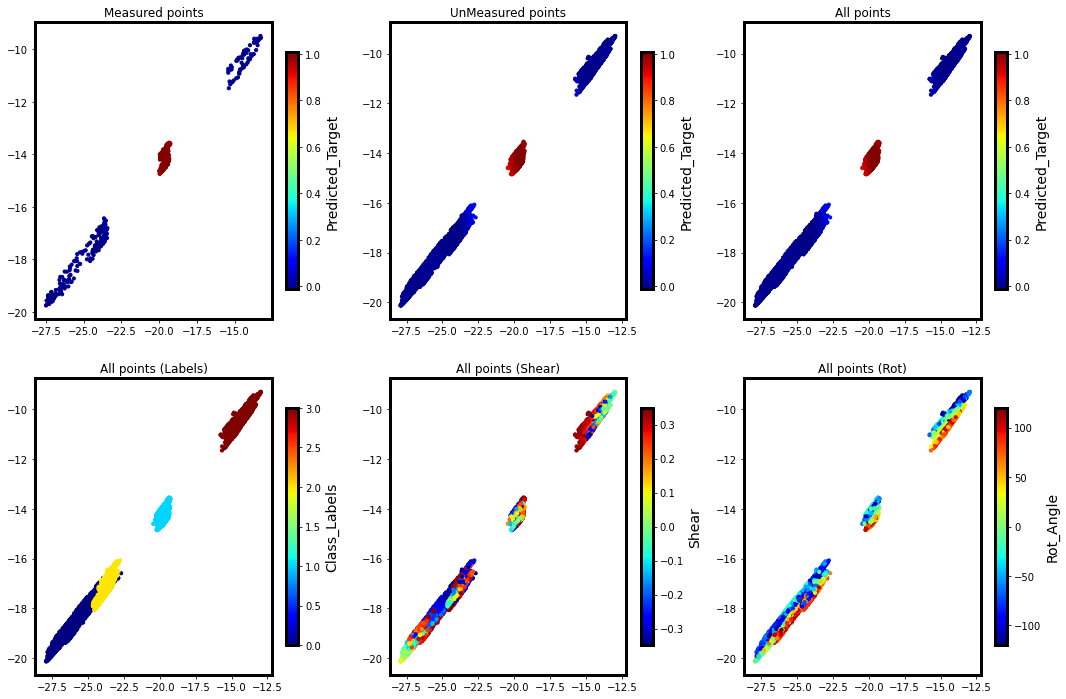

In [27]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Target Function: 1 for Hearts and 0 for the rest of the classes

In [28]:
X2 = np.copy(X) # Copying the entire input dataset
# Preparing the targets/outputs
targets2 = np.zeros(len(labels_all))
targets2[labels_all == 2] = 1

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

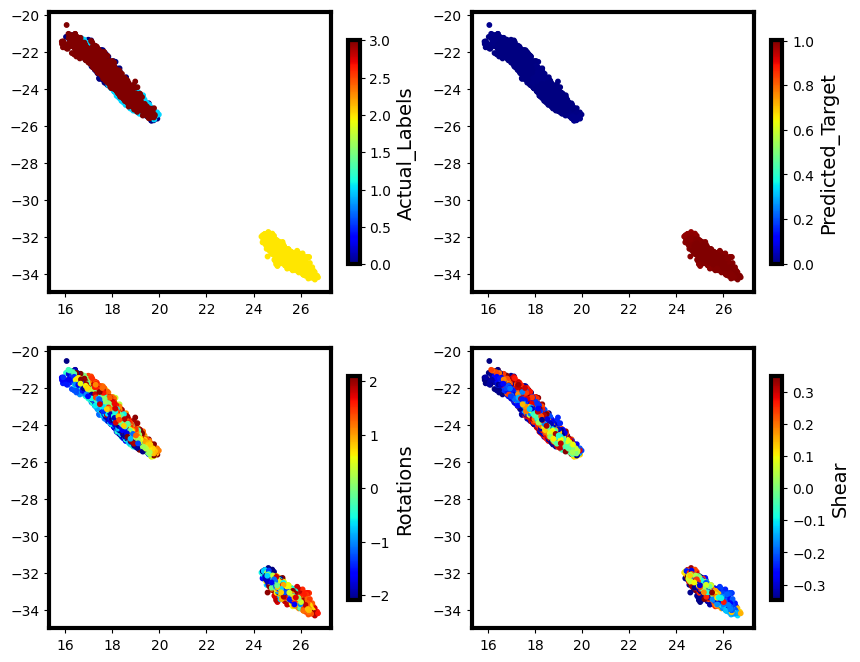

In [ ]:
# Running the DKL on the entire dataset
rng_key_2, rng_key_predict_2 = gpax.utils.get_keys()
dkl_2 = gpax.viDKL(900, 2, 'RBF')
dkl_2.fit(rng_key_2, X2, targets2)

# latent space embeddings and prediction of targets on the entire dataset
embeded_2 = dkl_2.embed(X2)
pred_mean2, pred_var2 = dkl_2.predict_in_batches(rng_key_predict_2, X2, batch_size=250)
pred_std2 = jnp.sqrt(pred_var2)


# Visualization of the Latent space distributions colored with ground-truths and predictions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = pred_mean2, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = torch.deg2rad(angles_all), cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [ ]:
# Preparing the dataset for BO
np.random.seed(0)

# Choosing the intial 100 points
idx2 = np.random.choice(np.arange(len(X2)), size = 100, replace = False)
X2_train = X2[idx2]
X2_unmeasured = np.delete(X2, idx2, axis=0)

indices_total_2 = np.arange(len(X))
indices_train_2 = indices_total_2[idx2]
y2_train = targets2[idx2]
indices_unmeasured_2 = np.delete(indices_total_2, idx2)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean2, exp_std2 = [], []
dkl_mean2, dkl_std2 = [], []
embed_traj2 = []
traj_mean2, traj_std2 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key12, rng_key_predict12 = gpax.utils.get_keys(seed = 15)
    dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_2.fit(rng_key12, X2_train, y2_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean2.append(y_mean[id_next])
    exp_std2.append(y_std[id_next])
    
    x_next = X2_unmeasured[id_next]
    ind_next = indices_unmeasured_2[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean2.append(pred_mean2[ind_next])
    dkl_std2.append(pred_std2[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets2[ind_next]
    
    # Update training arrays
    X2_train = np.append(X2_train, x_next[None], axis=0)
    y2_train = np.append(y2_train, y_measured)
    X2_unmeasured = np.delete(X2_unmeasured, id_next, axis=0)
    indices_unmeasured_2 = np.delete(indices_unmeasured_2, id_next)
    
    embed_traj = dkl_BO_2.embed(X2_train)
    traj_m, traj_s = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_train, batch_size=100)
    
    embed_traj2.append(embed_traj)
    traj_mean2.append(traj_m)


# Saving the results of exploration
hearts_results = {}
hearts_results['X_train'] = X2_train
hearts_results['y_train'] = y2_train
hearts_results['X_unmeasured'] = X2_unmeasured
hearts_results['indices_unmeasured'] = indices_unmeasured_2
hearts_results['dkl_mean'] = dkl_mean2
hearts_results['dkl_std'] = dkl_std2
hearts_results['exp_mean'] = exp_mean2
hearts_results['exp_std'] = exp_std2
hearts_results['traj_mean'] = traj_mean2
hearts_results['traj_std'] = traj_std2
hearts_results['embed_traj'] = embed_traj2

with open('hearts_results.pickle', 'wb') as handle:
    pickle.dump(hearts_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 358.90it/s, init loss: 60229.7864, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6159 0.667 ]
k_scale          0.46480000000000005
noise            0.0064

Step 2


100%|█| 1000/1000 [00:02<00:00, 362.42it/s, init loss: 60231.3167, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8714 0.874 ]
k_scale          0.2165
noise            0.009600000000000001

Step 3


100%|█| 1000/1000 [00:02<00:00, 366.46it/s, init loss: 60232.5603, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5382 0.5566]
k_scale          0.35450000000000004
noise            0.006200000000000001

Step 4


100%|█| 1000/1000 [00:02<00:00, 374.58it/s, init loss: 60233.8324, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6782 1.3082]
k_scale          0.3563
noise            0.0078000000000000005

Step 5


100%|█| 1000/1000 [00:02<00:00, 349.74it/s, init loss: 60235.2975, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6186 0.5147]
k_scale          0.45580000000000004
noise            0.0061

Step 6


100%|█| 1000/1000 [00:02<00:00, 364.01it/s, init loss: 60236.7267, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7432 0.7298]
k_scale          0.3914
noise            0.0071

Step 7


100%|█| 1000/1000 [00:02<00:00, 362.73it/s, init loss: 60237.9995, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5051 0.5417]
k_scale          0.2807
noise            0.0079

Step 8


100%|█| 1000/1000 [00:02<00:00, 363.04it/s, init loss: 60239.5236, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4713 0.5468]
k_scale          0.3551
noise            0.0064

Step 9


100%|█| 1000/1000 [00:02<00:00, 366.51it/s, init loss: 60241.0151, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5098 0.6041]
k_scale          0.298
noise            0.0076

Step 10


100%|█| 1000/1000 [00:02<00:00, 371.01it/s, init loss: 60242.5060, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3985 0.4221]
k_scale          0.38680000000000003
noise            0.0053

Step 11


100%|█| 1000/1000 [00:02<00:00, 375.38it/s, init loss: 60243.7998, avg. loss [95



Inferred GP kernel parameters
k_length         [0.722  0.7748]
k_scale          0.3053
noise            0.0077

Step 12


100%|█| 1000/1000 [00:02<00:00, 349.32it/s, init loss: 60244.9157, avg. loss [95



Inferred GP kernel parameters
k_length         [1.238  1.0415]
k_scale          0.30010000000000003
noise            0.0102

Step 13


100%|█| 1000/1000 [00:02<00:00, 356.35it/s, init loss: 60246.3710, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7725 0.6786]
k_scale          0.318
noise            0.0074

Step 14


100%|█| 1000/1000 [00:02<00:00, 357.48it/s, init loss: 60247.6873, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5987 0.6407]
k_scale          0.3265
noise            0.006

Step 15


100%|█| 1000/1000 [00:02<00:00, 362.19it/s, init loss: 60248.8605, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6007 0.6716]
k_scale          0.252
noise            0.008700000000000001

Step 16


100%|█| 1000/1000 [00:02<00:00, 367.15it/s, init loss: 60250.1417, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5101 0.5647]
k_scale          0.3906
noise            0.0061

Step 17


100%|█| 1000/1000 [00:02<00:00, 367.68it/s, init loss: 60251.4328, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6029 0.8685]
k_scale          0.3799
noise            0.006200000000000001

Step 18


100%|█| 1000/1000 [00:03<00:00, 268.32it/s, init loss: 60252.7238, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6497 0.5324]
k_scale          0.3594
noise            0.0077

Step 19


100%|█| 1000/1000 [00:02<00:00, 360.09it/s, init loss: 60253.9082, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6747 0.5921]
k_scale          0.2636
noise            0.007200000000000001

Step 20


100%|█| 1000/1000 [00:02<00:00, 363.13it/s, init loss: 60255.2035, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6358 0.4968]
k_scale          0.319
noise            0.0067

Step 21


100%|█| 1000/1000 [00:02<00:00, 363.24it/s, init loss: 60256.3852, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8789 0.6883]
k_scale          0.24350000000000002
noise            0.0109

Step 22


100%|█| 1000/1000 [00:02<00:00, 367.09it/s, init loss: 60257.6498, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9231 0.8868]
k_scale          0.3652
noise            0.007

Step 23


100%|█| 1000/1000 [00:02<00:00, 370.54it/s, init loss: 60258.7998, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6321 0.5595]
k_scale          0.47000000000000003
noise            0.0063

Step 24


100%|█| 1000/1000 [00:02<00:00, 373.45it/s, init loss: 60259.9893, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7992 0.727 ]
k_scale          0.29860000000000003
noise            0.0068000000000000005

Step 25


100%|█| 1000/1000 [00:03<00:00, 270.04it/s, init loss: 60261.2845, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6267 0.8737]
k_scale          0.32320000000000004
noise            0.0061

Step 26


100%|█| 1000/1000 [00:02<00:00, 355.87it/s, init loss: 60262.4529, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3669 0.3588]
k_scale          0.43920000000000003
noise            0.0061

Step 27


100%|█| 1000/1000 [00:02<00:00, 357.56it/s, init loss: 60263.7390, avg. loss [95



Inferred GP kernel parameters
k_length         [0.533 0.677]
k_scale          0.45080000000000003
noise            0.0071

Step 28


100%|█| 1000/1000 [00:02<00:00, 356.76it/s, init loss: 60265.2016, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4492 0.3906]
k_scale          0.3488
noise            0.006

Step 29


100%|█| 1000/1000 [00:02<00:00, 361.83it/s, init loss: 60266.5875, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0976 0.8893]
k_scale          0.2773
noise            0.006500000000000001

Step 30


100%|█| 1000/1000 [00:02<00:00, 359.52it/s, init loss: 60267.6612, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8119 0.7395]
k_scale          0.2882
noise            0.006500000000000001

Step 31


100%|█| 1000/1000 [00:02<00:00, 367.63it/s, init loss: 60268.7277, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4743 0.3703]
k_scale          0.3557
noise            0.0068000000000000005

Step 32


100%|█| 1000/1000 [00:02<00:00, 370.81it/s, init loss: 60270.2433, avg. loss [95



Inferred GP kernel parameters
k_length         [0.88   1.2463]
k_scale          0.2535
noise            0.0085

Step 33


100%|█| 1000/1000 [00:02<00:00, 341.75it/s, init loss: 60271.4826, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3717 0.4689]
k_scale          0.31770000000000004
noise            0.0076

Step 34


100%|█| 1000/1000 [00:02<00:00, 346.68it/s, init loss: 60272.9322, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7158 0.7269]
k_scale          0.4591
noise            0.006900000000000001

Step 35


100%|█| 1000/1000 [00:02<00:00, 339.19it/s, init loss: 60273.9517, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0196 0.8722]
k_scale          0.2874
noise            0.007

Step 36


100%|█| 1000/1000 [00:02<00:00, 340.40it/s, init loss: 60275.2109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6893 0.9059]
k_scale          0.3205
noise            0.0067

Step 37


100%|█| 1000/1000 [00:02<00:00, 362.20it/s, init loss: 60276.3420, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6576 0.5363]
k_scale          0.35810000000000003
noise            0.006

Step 38


100%|█| 1000/1000 [00:02<00:00, 362.07it/s, init loss: 60277.4196, avg. loss [95



Inferred GP kernel parameters
k_length         [0.549  0.5422]
k_scale          0.2923
noise            0.0074

Step 39


100%|█| 1000/1000 [00:02<00:00, 363.92it/s, init loss: 60278.9713, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2964 0.8338]
k_scale          0.37060000000000004
noise            0.0066

Step 40


100%|█| 1000/1000 [00:02<00:00, 340.63it/s, init loss: 60280.2077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.672  0.7413]
k_scale          0.3039
noise            0.0073

Step 41


100%|█| 1000/1000 [00:02<00:00, 348.84it/s, init loss: 60281.4536, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8939 0.9074]
k_scale          0.3806
noise            0.0064

Step 42


100%|█| 1000/1000 [00:02<00:00, 348.74it/s, init loss: 60282.9178, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6126 0.5521]
k_scale          0.3337
noise            0.0079

Step 43


100%|█| 1000/1000 [00:02<00:00, 357.14it/s, init loss: 60284.4472, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9786 0.8391]
k_scale          0.2904
noise            0.0081

Step 44


100%|█| 1000/1000 [00:02<00:00, 361.41it/s, init loss: 60285.7424, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8351 0.7567]
k_scale          0.2582
noise            0.008

Step 45


100%|█| 1000/1000 [00:02<00:00, 361.14it/s, init loss: 60286.9794, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7806 0.7994]
k_scale          0.27
noise            0.0079

Step 46


100%|█| 1000/1000 [00:03<00:00, 286.32it/s, init loss: 60288.2471, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5639 0.8484]
k_scale          0.38220000000000004
noise            0.0077

Step 47


100%|█| 1000/1000 [00:02<00:00, 335.96it/s, init loss: 60289.7299, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5904 0.5831]
k_scale          0.4995
noise            0.006

Step 48


100%|█| 1000/1000 [00:02<00:00, 336.90it/s, init loss: 60290.9938, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5848 0.7535]
k_scale          0.3542
noise            0.0066

Step 49


100%|█| 1000/1000 [00:02<00:00, 345.93it/s, init loss: 60292.1526, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2457 1.3348]
k_scale          0.23
noise            0.007500000000000001

Step 50


100%|█| 1000/1000 [00:02<00:00, 351.96it/s, init loss: 60293.6594, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7444 0.7985]
k_scale          0.27190000000000003
noise            0.008400000000000001

Step 51


100%|█| 1000/1000 [00:02<00:00, 355.94it/s, init loss: 60295.1764, avg. loss [95



Inferred GP kernel parameters
k_length         [0.982  1.3375]
k_scale          0.2594
noise            0.008700000000000001

Step 52


100%|█| 1000/1000 [00:02<00:00, 357.28it/s, init loss: 60296.4154, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0144 0.9881]
k_scale          0.3053
noise            0.006900000000000001

Step 53


100%|█| 1000/1000 [00:04<00:00, 227.77it/s, init loss: 60297.6999, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8123 0.99  ]
k_scale          0.2761
noise            0.006900000000000001

Step 54


100%|█| 1000/1000 [00:02<00:00, 345.28it/s, init loss: 60298.8239, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5646 0.5519]
k_scale          0.3003
noise            0.0067

Step 55


100%|█| 1000/1000 [00:02<00:00, 353.17it/s, init loss: 60300.1586, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1217 1.1405]
k_scale          0.27690000000000003
noise            0.0085

Step 56


100%|█| 1000/1000 [00:02<00:00, 355.97it/s, init loss: 60301.5893, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7503 0.6968]
k_scale          0.306
noise            0.0083

Step 57


100%|█| 1000/1000 [00:02<00:00, 361.04it/s, init loss: 60302.8796, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0252 0.792 ]
k_scale          0.3115
noise            0.0061

Step 58


100%|█| 1000/1000 [00:02<00:00, 365.02it/s, init loss: 60303.8637, avg. loss [95



Inferred GP kernel parameters
k_length         [0.896  0.7932]
k_scale          0.3214
noise            0.0068000000000000005

Step 59


100%|█| 1000/1000 [00:02<00:00, 363.82it/s, init loss: 60305.3945, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7213 0.5112]
k_scale          0.3219
noise            0.0068000000000000005

Step 60


100%|█| 1000/1000 [00:03<00:00, 267.46it/s, init loss: 60306.7263, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0012 0.8954]
k_scale          0.3533
noise            0.0067

Step 61


100%|█| 1000/1000 [00:02<00:00, 343.20it/s, init loss: 60307.9992, avg. loss [95



Inferred GP kernel parameters
k_length         [1.205  1.1165]
k_scale          0.3403
noise            0.0073

Step 62


100%|█| 1000/1000 [00:02<00:00, 351.35it/s, init loss: 60309.3079, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3297 1.1693]
k_scale          0.2773
noise            0.0071

Step 63


100%|█| 1000/1000 [00:02<00:00, 354.54it/s, init loss: 60310.5841, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7155 1.2988]
k_scale          0.3183
noise            0.0063

Step 64


100%|█| 1000/1000 [00:02<00:00, 358.38it/s, init loss: 60311.7082, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0476 0.7633]
k_scale          0.341
noise            0.007200000000000001

Step 65


100%|█| 1000/1000 [00:02<00:00, 361.75it/s, init loss: 60312.8220, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1361 1.2028]
k_scale          0.3118
noise            0.0073

Step 66


100%|█| 1000/1000 [00:02<00:00, 363.40it/s, init loss: 60314.2591, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7022 0.9685]
k_scale          0.33690000000000003
noise            0.0059

Step 67


100%|█| 1000/1000 [00:03<00:00, 263.91it/s, init loss: 60315.3319, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0795 0.941 ]
k_scale          0.30410000000000004
noise            0.0066

Step 68


100%|█| 1000/1000 [00:02<00:00, 339.99it/s, init loss: 60316.6130, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8567 0.7372]
k_scale          0.34500000000000003
noise            0.0056

Step 69


100%|█| 1000/1000 [00:02<00:00, 348.72it/s, init loss: 60317.7995, avg. loss [95



Inferred GP kernel parameters
k_length         [1.391  1.4631]
k_scale          0.2651
noise            0.006900000000000001

Step 70


100%|█| 1000/1000 [00:02<00:00, 350.54it/s, init loss: 60319.3302, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7889 1.1807]
k_scale          0.31370000000000003
noise            0.006

Step 71


100%|█| 1000/1000 [00:02<00:00, 357.66it/s, init loss: 60320.4109, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2108 0.8933]
k_scale          0.3322
noise            0.006500000000000001

Step 72


100%|█| 1000/1000 [00:02<00:00, 357.26it/s, init loss: 60321.6341, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0743 0.9594]
k_scale          0.2464
noise            0.0089

Step 73


100%|█| 1000/1000 [00:02<00:00, 357.50it/s, init loss: 60322.8794, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9547 0.9807]
k_scale          0.324
noise            0.0064

Step 74


100%|█| 1000/1000 [00:04<00:00, 226.12it/s, init loss: 60324.4072, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6764 0.8013]
k_scale          0.3808
noise            0.0058000000000000005

Step 75


100%|█| 1000/1000 [00:03<00:00, 326.09it/s, init loss: 60325.8589, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9094 1.248 ]
k_scale          0.30760000000000004
noise            0.0061

Step 76


100%|█| 1000/1000 [00:02<00:00, 335.13it/s, init loss: 60327.2215, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3102 2.9173]
k_scale          0.22790000000000002
noise            0.0083

Step 77


100%|█| 1000/1000 [00:02<00:00, 352.17it/s, init loss: 60328.7529, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4785 0.4601]
k_scale          0.3962
noise            0.0066

Step 78


100%|█| 1000/1000 [00:02<00:00, 356.48it/s, init loss: 60330.0481, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0946 1.0626]
k_scale          0.2916
noise            0.0063

Step 79


100%|█| 1000/1000 [00:02<00:00, 353.82it/s, init loss: 60331.4674, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9298 1.2115]
k_scale          0.24180000000000001
noise            0.0086

Step 80


100%|█| 1000/1000 [00:02<00:00, 359.82it/s, init loss: 60332.7405, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6476 0.7438]
k_scale          0.3573
noise            0.0067

Step 81


100%|█| 1000/1000 [00:02<00:00, 358.06it/s, init loss: 60334.0285, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0035 1.6213]
k_scale          0.2597
noise            0.0077

Step 82


100%|█| 1000/1000 [00:02<00:00, 334.59it/s, init loss: 60335.3078, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7955 0.6139]
k_scale          0.4022
noise            0.0063

Step 83


100%|█| 1000/1000 [00:02<00:00, 340.37it/s, init loss: 60336.5996, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8132 0.7081]
k_scale          0.3633
noise            0.0059

Step 84


100%|█| 1000/1000 [00:02<00:00, 352.12it/s, init loss: 60337.7781, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2117 1.8792]
k_scale          0.2539
noise            0.007200000000000001

Step 85


100%|█| 1000/1000 [00:02<00:00, 354.08it/s, init loss: 60339.0672, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2501 1.2952]
k_scale          0.2927
noise            0.007200000000000001

Step 86


100%|█| 1000/1000 [00:02<00:00, 357.71it/s, init loss: 60340.3447, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8782 0.9366]
k_scale          0.34400000000000003
noise            0.0068000000000000005

Step 87


100%|█| 1000/1000 [00:02<00:00, 358.45it/s, init loss: 60341.7259, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4286 1.8626]
k_scale          0.2417
noise            0.0081

Step 88


100%|█| 1000/1000 [00:02<00:00, 349.58it/s, init loss: 60342.8362, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6464 0.8832]
k_scale          0.3104
noise            0.0086

Step 89


100%|█| 1000/1000 [00:03<00:00, 318.73it/s, init loss: 60344.0923, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6537 0.6201]
k_scale          0.3256
noise            0.0118

Step 90


100%|█| 1000/1000 [00:03<00:00, 325.78it/s, init loss: 60345.2182, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1678 2.2199]
k_scale          0.2728
noise            0.0077

Step 91


100%|█| 1000/1000 [00:02<00:00, 336.43it/s, init loss: 60346.5390, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0415 1.3267]
k_scale          0.27040000000000003
noise            0.008

Step 92


100%|█| 1000/1000 [00:02<00:00, 339.55it/s, init loss: 60347.7933, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1068 1.3562]
k_scale          0.3249
noise            0.0097

Step 93


100%|█| 1000/1000 [00:02<00:00, 343.92it/s, init loss: 60349.3241, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9831 1.2487]
k_scale          0.30110000000000003
noise            0.006200000000000001

Step 94


100%|█| 1000/1000 [00:02<00:00, 353.67it/s, init loss: 60350.7423, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4743 2.019 ]
k_scale          0.254
noise            0.0076

Step 95


100%|█| 1000/1000 [00:02<00:00, 361.01it/s, init loss: 60352.0318, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7054 1.0181]
k_scale          0.3763
noise            0.0077

Step 96


100%|█| 1000/1000 [00:02<00:00, 337.34it/s, init loss: 60353.3271, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9682 0.8945]
k_scale          0.3173
noise            0.0098

Step 97


100%|█| 1000/1000 [00:02<00:00, 342.87it/s, init loss: 60354.6223, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7344 1.8097]
k_scale          0.2591
noise            0.0078000000000000005

Step 98


100%|█| 1000/1000 [00:02<00:00, 349.92it/s, init loss: 60355.7251, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1978 1.1115]
k_scale          0.2931
noise            0.0067

Step 99


100%|█| 1000/1000 [00:02<00:00, 355.48it/s, init loss: 60357.1860, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4758 0.987 ]
k_scale          0.275
noise            0.0064

Step 100


100%|█| 1000/1000 [00:02<00:00, 359.87it/s, init loss: 60358.5152, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3858 1.3602]
k_scale          0.2782
noise            0.006500000000000001

Step 101


100%|█| 1000/1000 [00:02<00:00, 357.12it/s, init loss: 60359.4939, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3113 1.2355]
k_scale          0.2787
noise            0.0067

Step 102


100%|█| 1000/1000 [00:02<00:00, 361.45it/s, init loss: 60360.6452, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5057 1.3159]
k_scale          0.28650000000000003
noise            0.0068000000000000005

Step 103


100%|█| 1000/1000 [00:02<00:00, 339.14it/s, init loss: 60362.1659, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9871 0.989 ]
k_scale          0.32480000000000003
noise            0.007200000000000001

Step 104


100%|█| 1000/1000 [00:02<00:00, 348.58it/s, init loss: 60363.6797, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8696 1.6599]
k_scale          0.2695
noise            0.0081

Step 105


100%|█| 1000/1000 [00:02<00:00, 354.62it/s, init loss: 60364.8505, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4622 1.8593]
k_scale          0.2436
noise            0.0081

Step 106


100%|█| 1000/1000 [00:02<00:00, 357.33it/s, init loss: 60366.0328, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2724 0.7176]
k_scale          0.2974
noise            0.0077

Step 107


100%|█| 1000/1000 [00:02<00:00, 358.50it/s, init loss: 60367.1579, avg. loss [95



Inferred GP kernel parameters
k_length         [1.199  1.4811]
k_scale          0.25
noise            0.0082

Step 108


100%|█| 1000/1000 [00:02<00:00, 349.60it/s, init loss: 60368.4689, avg. loss [95



Inferred GP kernel parameters
k_length         [1.38   1.2676]
k_scale          0.3195
noise            0.006900000000000001

Step 109


100%|█| 1000/1000 [00:02<00:00, 357.88it/s, init loss: 60369.9997, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0315 1.3893]
k_scale          0.2651
noise            0.0067

Step 110


100%|█| 1000/1000 [00:02<00:00, 336.61it/s, init loss: 60371.0405, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5918 1.3698]
k_scale          0.23270000000000002
noise            0.0076

Step 111


100%|█| 1000/1000 [00:02<00:00, 345.61it/s, init loss: 60372.5657, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5    1.3901]
k_scale          0.2796
noise            0.007200000000000001

Step 112


100%|█| 1000/1000 [00:02<00:00, 348.08it/s, init loss: 60373.6850, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6577 0.9121]
k_scale          0.4048
noise            0.0054

Step 113


100%|█| 1000/1000 [00:02<00:00, 351.35it/s, init loss: 60375.0409, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8908 0.9658]
k_scale          0.3805
noise            0.0063

Step 114


100%|█| 1000/1000 [00:02<00:00, 353.99it/s, init loss: 60376.4934, avg. loss [95



Inferred GP kernel parameters
k_length         [0.824  0.7421]
k_scale          0.2626
noise            0.008

Step 115


100%|█| 1000/1000 [00:02<00:00, 356.75it/s, init loss: 60377.7584, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9683 1.1757]
k_scale          0.3538
noise            0.0073

Step 116


100%|█| 1000/1000 [00:02<00:00, 358.33it/s, init loss: 60378.9053, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2455 2.686 ]
k_scale          0.22690000000000002
noise            0.0085

Step 117


100%|█| 1000/1000 [00:02<00:00, 339.31it/s, init loss: 60380.2306, avg. loss [95



Inferred GP kernel parameters
k_length         [1.913  2.0552]
k_scale          0.2228
noise            0.0089

Step 118


100%|█| 1000/1000 [00:02<00:00, 348.44it/s, init loss: 60381.5925, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9387 2.1611]
k_scale          0.249
noise            0.0077

Step 119


100%|█| 1000/1000 [00:02<00:00, 349.06it/s, init loss: 60382.8633, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1164 0.9983]
k_scale          0.3034
noise            0.0071

Step 120


100%|█| 1000/1000 [00:02<00:00, 351.88it/s, init loss: 60384.1569, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3731 2.0257]
k_scale          0.3012
noise            0.0082

Step 121


100%|█| 1000/1000 [00:02<00:00, 358.31it/s, init loss: 60385.4514, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4968 1.8507]
k_scale          0.2528
noise            0.006900000000000001

Step 122


100%|█| 1000/1000 [00:02<00:00, 357.89it/s, init loss: 60386.5965, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7587 2.5602]
k_scale          0.2988
noise            0.0078000000000000005

Step 123


100%|█| 1000/1000 [00:02<00:00, 358.00it/s, init loss: 60388.1252, avg. loss [95



Inferred GP kernel parameters
k_length         [2.466 2.537]
k_scale          0.29650000000000004
noise            0.008400000000000001

Step 124


100%|█| 1000/1000 [00:02<00:00, 337.17it/s, init loss: 60389.6513, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9006 2.0206]
k_scale          0.2923
noise            0.0073

Step 125


100%|█| 1000/1000 [00:02<00:00, 344.58it/s, init loss: 60390.6910, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8311 1.3379]
k_scale          0.2933
noise            0.006200000000000001

Step 126


100%|█| 1000/1000 [00:02<00:00, 348.90it/s, init loss: 60392.1660, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7019 1.9041]
k_scale          0.30260000000000004
noise            0.0068000000000000005

Step 127


100%|█| 1000/1000 [00:02<00:00, 352.65it/s, init loss: 60393.5001, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1135 1.5018]
k_scale          0.3178
noise            0.0066

Step 128


100%|█| 1000/1000 [00:02<00:00, 353.86it/s, init loss: 60394.7814, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3767 3.4026]
k_scale          0.2406
noise            0.0086

Step 129


100%|█| 1000/1000 [00:02<00:00, 353.73it/s, init loss: 60396.0767, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1417 0.9865]
k_scale          0.5321
noise            0.007200000000000001

Step 130


100%|█| 1000/1000 [00:02<00:00, 358.04it/s, init loss: 60397.3221, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2668 1.4186]
k_scale          0.2701
noise            0.0095

Step 131


100%|█| 1000/1000 [00:02<00:00, 336.47it/s, init loss: 60398.7808, avg. loss [95



Inferred GP kernel parameters
k_length         [1.183  1.3631]
k_scale          0.3234
noise            0.0077

Step 132


100%|█| 1000/1000 [00:02<00:00, 345.71it/s, init loss: 60399.9920, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3211 1.1069]
k_scale          0.3124
noise            0.0059

Step 133


100%|█| 1000/1000 [00:02<00:00, 347.34it/s, init loss: 60401.3039, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6941 1.4626]
k_scale          0.2822
noise            0.0067

Step 134


100%|█| 1000/1000 [00:02<00:00, 353.28it/s, init loss: 60402.7246, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6183 2.087 ]
k_scale          0.2692
noise            0.0071

Step 135


100%|█| 1000/1000 [00:02<00:00, 354.71it/s, init loss: 60404.2532, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9453 0.9266]
k_scale          0.4151
noise            0.0077

Step 136


100%|█| 1000/1000 [00:02<00:00, 356.76it/s, init loss: 60405.2599, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5695 2.1975]
k_scale          0.2121
noise            0.0074

Step 137


100%|█| 1000/1000 [00:02<00:00, 358.90it/s, init loss: 60406.4573, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0733 1.0879]
k_scale          0.3053
noise            0.0059

Step 138


100%|█| 1000/1000 [00:03<00:00, 333.00it/s, init loss: 60407.6608, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3805 2.0093]
k_scale          0.2548
noise            0.0064

Step 139


100%|█| 1000/1000 [00:02<00:00, 339.49it/s, init loss: 60408.9379, avg. loss [95



Inferred GP kernel parameters
k_length         [1.73   2.9643]
k_scale          0.2853
noise            0.0077

Step 140


100%|█| 1000/1000 [00:02<00:00, 351.51it/s, init loss: 60410.2078, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2226 2.3557]
k_scale          0.29300000000000004
noise            0.006500000000000001

Step 141


100%|█| 1000/1000 [00:02<00:00, 352.99it/s, init loss: 60411.2792, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7595 2.1835]
k_scale          0.2169
noise            0.0081

Step 142


100%|█| 1000/1000 [00:02<00:00, 352.02it/s, init loss: 60412.6490, avg. loss [95



Inferred GP kernel parameters
k_length         [2.206  1.2374]
k_scale          0.30610000000000004
noise            0.006

Step 143


100%|█| 1000/1000 [00:02<00:00, 354.20it/s, init loss: 60413.7676, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7223 1.5081]
k_scale          0.30360000000000004
noise            0.0095

Step 144


100%|█| 1000/1000 [00:02<00:00, 357.69it/s, init loss: 60414.8646, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9409 3.0255]
k_scale          0.25880000000000003
noise            0.0067

Step 145


100%|█| 1000/1000 [00:02<00:00, 334.30it/s, init loss: 60416.3572, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6721 1.8575]
k_scale          0.2582
noise            0.006900000000000001

Step 146


100%|█| 1000/1000 [00:02<00:00, 338.22it/s, init loss: 60417.6480, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4072 1.9398]
k_scale          0.2903
noise            0.0078000000000000005

Step 147


100%|█| 1000/1000 [00:02<00:00, 344.80it/s, init loss: 60418.8623, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2159 1.9146]
k_scale          0.3062
noise            0.0059

Step 148


100%|█| 1000/1000 [00:02<00:00, 348.80it/s, init loss: 60420.2918, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3419 1.9609]
k_scale          0.2559
noise            0.0066

Step 149


100%|█| 1000/1000 [00:02<00:00, 349.40it/s, init loss: 60421.4582, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4615 2.2234]
k_scale          0.2553
noise            0.007

Step 150


100%|█| 1000/1000 [00:02<00:00, 353.90it/s, init loss: 60422.5583, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9057 1.9361]
k_scale          0.2932
noise            0.009300000000000001

Step 151


100%|█| 1000/1000 [00:02<00:00, 357.99it/s, init loss: 60423.7727, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2857 2.4856]
k_scale          0.3297
noise            0.007500000000000001

Step 152


100%|█| 1000/1000 [00:03<00:00, 331.98it/s, init loss: 60425.0022, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5276 1.8142]
k_scale          0.26080000000000003
noise            0.0098

Step 153


100%|█| 1000/1000 [00:02<00:00, 336.97it/s, init loss: 60426.2783, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6977 1.7349]
k_scale          0.24760000000000001
noise            0.0073

Step 154


100%|█| 1000/1000 [00:02<00:00, 342.62it/s, init loss: 60427.5717, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5108 2.2817]
k_scale          0.2521
noise            0.0076

Step 155


100%|█| 1000/1000 [00:02<00:00, 345.78it/s, init loss: 60429.0989, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4462 2.2849]
k_scale          0.2291
noise            0.007500000000000001

Step 156


100%|█| 1000/1000 [00:02<00:00, 347.46it/s, init loss: 60430.4680, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6434 2.0068]
k_scale          0.2816
noise            0.0066

Step 157


100%|█| 1000/1000 [00:02<00:00, 348.12it/s, init loss: 60431.5004, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6378 4.5962]
k_scale          0.21350000000000002
noise            0.0079

Step 158


100%|█| 1000/1000 [00:02<00:00, 350.16it/s, init loss: 60432.9565, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3884 1.3437]
k_scale          0.2873
noise            0.0109

Step 159


100%|█| 1000/1000 [00:03<00:00, 328.38it/s, init loss: 60434.2502, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2807 2.1642]
k_scale          0.29100000000000004
noise            0.007

Step 160


100%|█| 1000/1000 [00:02<00:00, 333.87it/s, init loss: 60435.5464, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4069 1.2957]
k_scale          0.3247
noise            0.0078000000000000005

Step 161


100%|█| 1000/1000 [00:02<00:00, 341.39it/s, init loss: 60436.7807, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3475 1.4523]
k_scale          0.2696
noise            0.0118

Step 162


100%|█| 1000/1000 [00:02<00:00, 342.41it/s, init loss: 60437.7902, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2349 1.4562]
k_scale          0.3093
noise            0.006200000000000001

Step 163


100%|█| 1000/1000 [00:02<00:00, 345.51it/s, init loss: 60438.8201, avg. loss [95



Inferred GP kernel parameters
k_length         [1.423  2.6849]
k_scale          0.278
noise            0.007200000000000001

Step 164


100%|█| 1000/1000 [00:02<00:00, 348.70it/s, init loss: 60439.8489, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8881 1.558 ]
k_scale          0.3088
noise            0.0083

Step 165


100%|█| 1000/1000 [00:02<00:00, 350.65it/s, init loss: 60441.0743, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4023 1.4086]
k_scale          0.2841
noise            0.008700000000000001

Step 166


100%|█| 1000/1000 [00:03<00:00, 327.87it/s, init loss: 60442.2904, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4871 1.6494]
k_scale          0.2778
noise            0.006500000000000001

Step 167


100%|█| 1000/1000 [00:03<00:00, 332.50it/s, init loss: 60443.3475, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6941 1.446 ]
k_scale          0.2922
noise            0.0068000000000000005

Step 168


100%|█| 1000/1000 [00:02<00:00, 337.49it/s, init loss: 60444.5815, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7712 1.3814]
k_scale          0.3164
noise            0.0081

Step 169


100%|█| 1000/1000 [00:02<00:00, 344.02it/s, init loss: 60445.7082, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4689 1.3544]
k_scale          0.34750000000000003
noise            0.0085

Step 170


100%|█| 1000/1000 [00:02<00:00, 344.81it/s, init loss: 60446.7172, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0044 1.7905]
k_scale          0.273
noise            0.006500000000000001

Step 171


100%|█| 1000/1000 [00:02<00:00, 347.41it/s, init loss: 60447.8356, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3442 1.4727]
k_scale          0.2852
noise            0.0098

Step 172


100%|█| 1000/1000 [00:02<00:00, 351.54it/s, init loss: 60449.1276, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1715 2.0849]
k_scale          0.3109
noise            0.0081

Step 173


100%|█| 1000/1000 [00:03<00:00, 256.82it/s, init loss: 60450.4493, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1096 2.1051]
k_scale          0.2421
noise            0.007200000000000001

Step 174


100%|█| 1000/1000 [00:03<00:00, 333.23it/s, init loss: 60451.7445, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8379 1.6803]
k_scale          0.3176
noise            0.0078000000000000005

Step 175


100%|█| 1000/1000 [00:02<00:00, 341.10it/s, init loss: 60453.0334, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1472 3.0159]
k_scale          0.29860000000000003
noise            0.008400000000000001

Step 176


100%|█| 1000/1000 [00:02<00:00, 343.86it/s, init loss: 60454.2629, avg. loss [95



Inferred GP kernel parameters
k_length         [2.907  2.0642]
k_scale          0.24450000000000002
noise            0.007500000000000001

Step 177


100%|█| 1000/1000 [00:02<00:00, 343.46it/s, init loss: 60455.3064, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0011 2.5268]
k_scale          0.2697
noise            0.0074

Step 178


100%|█| 1000/1000 [00:02<00:00, 348.11it/s, init loss: 60456.4225, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8432 1.4267]
k_scale          0.3035
noise            0.0064

Step 179


100%|█| 1000/1000 [00:02<00:00, 350.04it/s, init loss: 60457.5034, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8704 1.7197]
k_scale          0.25730000000000003
noise            0.0066

Step 180


100%|█| 1000/1000 [00:04<00:00, 246.18it/s, init loss: 60458.8949, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9853 1.9391]
k_scale          0.2548
noise            0.0067

Step 181


100%|█| 1000/1000 [00:03<00:00, 333.21it/s, init loss: 60460.3004, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3834 1.572 ]
k_scale          0.2414
noise            0.0083

Step 182


100%|█| 1000/1000 [00:02<00:00, 340.88it/s, init loss: 60461.5115, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8825 2.7277]
k_scale          0.2606
noise            0.0083

Step 183


100%|█| 1000/1000 [00:02<00:00, 342.49it/s, init loss: 60462.7481, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9794 1.9324]
k_scale          0.2644
noise            0.0076

Step 184


100%|█| 1000/1000 [00:02<00:00, 345.08it/s, init loss: 60463.9356, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4677 1.4049]
k_scale          0.4141
noise            0.0091

Step 185


100%|█| 1000/1000 [00:02<00:00, 344.74it/s, init loss: 60465.2533, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8927 2.7897]
k_scale          0.2777
noise            0.0074

Step 186


100%|█| 1000/1000 [00:02<00:00, 348.35it/s, init loss: 60466.6779, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4715 1.6064]
k_scale          0.2777
noise            0.007

Step 187


100%|█| 1000/1000 [00:03<00:00, 263.46it/s, init loss: 60468.0392, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0102 2.1476]
k_scale          0.22990000000000002
noise            0.0078000000000000005

Step 188


100%|█| 1000/1000 [00:03<00:00, 331.34it/s, init loss: 60469.4345, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2094 1.6535]
k_scale          0.3019
noise            0.0071

Step 189


100%|█| 1000/1000 [00:02<00:00, 338.59it/s, init loss: 60470.4986, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9239 1.7683]
k_scale          0.2641
noise            0.0066

Step 190


100%|█| 1000/1000 [00:02<00:00, 342.62it/s, init loss: 60471.6593, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6873 1.4137]
k_scale          0.2579
noise            0.0067

Step 191


100%|█| 1000/1000 [00:02<00:00, 343.23it/s, init loss: 60472.7289, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2532 0.9391]
k_scale          0.38170000000000004
noise            0.0076

Step 192


100%|█| 1000/1000 [00:02<00:00, 347.04it/s, init loss: 60473.9797, avg. loss [95



Inferred GP kernel parameters
k_length         [1.251  1.8937]
k_scale          0.29860000000000003
noise            0.006

Step 193


100%|█| 1000/1000 [00:02<00:00, 347.53it/s, init loss: 60475.0438, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5886 1.9664]
k_scale          0.253
noise            0.006900000000000001

Step 194


100%|█| 1000/1000 [00:02<00:00, 352.65it/s, init loss: 60476.0539, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7855 2.1773]
k_scale          0.3005
noise            0.008700000000000001

Step 195


100%|█| 1000/1000 [00:03<00:00, 326.28it/s, init loss: 60477.3491, avg. loss [95



Inferred GP kernel parameters
k_length         [1.983  1.7236]
k_scale          0.2977
noise            0.0061

Step 196


100%|█| 1000/1000 [00:02<00:00, 334.56it/s, init loss: 60478.5619, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6728 1.2766]
k_scale          0.2859
noise            0.006200000000000001

Step 197


100%|█| 1000/1000 [00:03<00:00, 332.34it/s, init loss: 60479.6364, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7498 2.1825]
k_scale          0.2923
noise            0.0073

Step 198


100%|█| 1000/1000 [00:02<00:00, 336.15it/s, init loss: 60480.7318, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6152 2.754 ]
k_scale          0.2533
noise            0.0067

Step 199


100%|█| 1000/1000 [00:02<00:00, 341.62it/s, init loss: 60482.0092, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3767 1.3161]
k_scale          0.25320000000000004
noise            0.0082

Step 200


100%|█| 1000/1000 [00:02<00:00, 343.75it/s, init loss: 60483.2742, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1463 1.8365]
k_scale          0.2785
noise            0.0082

Step 201


100%|█| 1000/1000 [00:02<00:00, 340.56it/s, init loss: 60484.5639, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8906 1.752 ]
k_scale          0.2592
noise            0.009000000000000001

Step 202


100%|█| 1000/1000 [00:03<00:00, 314.09it/s, init loss: 60485.5962, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2357 1.1181]
k_scale          0.2974
noise            0.0077

Step 203


100%|█| 1000/1000 [00:03<00:00, 313.20it/s, init loss: 60487.1308, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7063 1.9592]
k_scale          0.32530000000000003
noise            0.0073

Step 204


100%|█| 1000/1000 [00:03<00:00, 330.02it/s, init loss: 60488.6292, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9369 2.4033]
k_scale          0.2963
noise            0.0071

Step 205


100%|█| 1000/1000 [00:03<00:00, 332.17it/s, init loss: 60490.0654, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5737 2.512 ]
k_scale          0.2632
noise            0.006900000000000001

Step 206


100%|█| 1000/1000 [00:03<00:00, 331.93it/s, init loss: 60491.2672, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9528 1.489 ]
k_scale          0.3027
noise            0.006500000000000001

Step 207


100%|█| 1000/1000 [00:02<00:00, 334.53it/s, init loss: 60492.2248, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2915 0.7247]
k_scale          0.5309
noise            0.0079

Step 208


100%|█| 1000/1000 [00:02<00:00, 337.55it/s, init loss: 60493.4803, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1563 1.2164]
k_scale          0.3121
noise            0.006900000000000001

Step 209


100%|█| 1000/1000 [00:03<00:00, 323.52it/s, init loss: 60494.4255, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3481 1.8093]
k_scale          0.3022
noise            0.0071

Step 210


100%|█| 1000/1000 [00:03<00:00, 317.34it/s, init loss: 60495.7027, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9992 2.4632]
k_scale          0.22030000000000002
noise            0.0079

Step 211


100%|█| 1000/1000 [00:03<00:00, 325.28it/s, init loss: 60496.7498, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5192 1.5251]
k_scale          0.3038
noise            0.006

Step 212


100%|█| 1000/1000 [00:03<00:00, 332.43it/s, init loss: 60497.8835, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0164 2.5501]
k_scale          0.2192
noise            0.008400000000000001

Step 213


100%|█| 1000/1000 [00:03<00:00, 329.57it/s, init loss: 60499.0423, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5351 1.7244]
k_scale          0.3627
noise            0.0094

Step 214


100%|█| 1000/1000 [00:02<00:00, 335.25it/s, init loss: 60500.1225, avg. loss [95



Inferred GP kernel parameters
k_length         [1.256  1.7234]
k_scale          0.4364
noise            0.009300000000000001

Step 215


100%|█| 1000/1000 [00:02<00:00, 336.67it/s, init loss: 60501.4092, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5832 1.5128]
k_scale          0.3159
noise            0.0078000000000000005

Step 216


100%|█| 1000/1000 [00:03<00:00, 311.84it/s, init loss: 60502.7543, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9918 1.2746]
k_scale          0.3524
noise            0.0068000000000000005

Step 217


100%|█| 1000/1000 [00:03<00:00, 315.20it/s, init loss: 60503.9232, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3074 1.9733]
k_scale          0.3553
noise            0.0081

Step 218


100%|█| 1000/1000 [00:03<00:00, 325.71it/s, init loss: 60505.0772, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5149 1.9953]
k_scale          0.3738
noise            0.0109

Step 219


100%|█| 1000/1000 [00:03<00:00, 328.29it/s, init loss: 60506.5753, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8065 2.4439]
k_scale          0.2871
noise            0.007200000000000001

Step 220


100%|█| 1000/1000 [00:03<00:00, 329.38it/s, init loss: 60507.5647, avg. loss [95



Inferred GP kernel parameters
k_length         [2.003  1.7801]
k_scale          0.3255
noise            0.0074

Step 221


100%|█| 1000/1000 [00:02<00:00, 341.33it/s, init loss: 60508.9463, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3593 1.0552]
k_scale          0.36970000000000003
noise            0.0077

Step 222


100%|█| 1000/1000 [00:02<00:00, 342.26it/s, init loss: 60510.2150, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2337 2.4474]
k_scale          0.377
noise            0.0068000000000000005

Step 223


100%|█| 1000/1000 [00:03<00:00, 319.18it/s, init loss: 60511.3328, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4552 2.6063]
k_scale          0.32080000000000003
noise            0.0061

Step 224


100%|█| 1000/1000 [00:03<00:00, 316.87it/s, init loss: 60512.4242, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1938 4.5461]
k_scale          0.2398
noise            0.0076

Step 225


100%|█| 1000/1000 [00:03<00:00, 323.76it/s, init loss: 60513.6679, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6833 1.9358]
k_scale          0.29300000000000004
noise            0.0092

Step 226


100%|█| 1000/1000 [00:03<00:00, 327.82it/s, init loss: 60515.1235, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6317 2.9535]
k_scale          0.2576
noise            0.0074

Step 227


100%|█| 1000/1000 [00:02<00:00, 334.66it/s, init loss: 60516.3950, avg. loss [95



Inferred GP kernel parameters
k_length         [1.843  3.4192]
k_scale          0.231
noise            0.007500000000000001

Step 228


100%|█| 1000/1000 [00:02<00:00, 338.71it/s, init loss: 60517.7287, avg. loss [95



Inferred GP kernel parameters
k_length         [1.787  2.8112]
k_scale          0.23290000000000002
noise            0.0067

Step 229


100%|█| 1000/1000 [00:02<00:00, 333.62it/s, init loss: 60518.8039, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9664 2.0512]
k_scale          0.2867
noise            0.007

Step 230


100%|█| 1000/1000 [00:03<00:00, 322.75it/s, init loss: 60519.8837, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4582 1.9658]
k_scale          0.2851
noise            0.0066

Step 231


100%|█| 1000/1000 [00:03<00:00, 331.86it/s, init loss: 60520.9920, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6309 2.009 ]
k_scale          0.22010000000000002
noise            0.007200000000000001

Step 232


100%|█| 1000/1000 [00:02<00:00, 335.59it/s, init loss: 60522.1650, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7368 2.3812]
k_scale          0.2637
noise            0.0067

Step 233


100%|█| 1000/1000 [00:02<00:00, 337.22it/s, init loss: 60523.1980, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8895 1.0367]
k_scale          0.3764
noise            0.0081

Step 234


100%|█| 1000/1000 [00:02<00:00, 339.33it/s, init loss: 60524.4999, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5911 1.6004]
k_scale          0.32270000000000004
noise            0.0076

Step 235


100%|█| 1000/1000 [00:02<00:00, 339.16it/s, init loss: 60525.4837, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4857 1.2425]
k_scale          0.3009
noise            0.008

Step 236


100%|█| 1000/1000 [00:02<00:00, 341.89it/s, init loss: 60526.7276, avg. loss [95



Inferred GP kernel parameters
k_length         [1.919  2.2388]
k_scale          0.2832
noise            0.0105

Step 237


100%|█| 1000/1000 [00:03<00:00, 256.05it/s, init loss: 60527.9386, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3527 2.7803]
k_scale          0.2182
noise            0.009000000000000001

Step 238


100%|█| 1000/1000 [00:03<00:00, 329.28it/s, init loss: 60529.1674, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9578 1.3878]
k_scale          0.33480000000000004
noise            0.009000000000000001

Step 239


100%|█| 1000/1000 [00:02<00:00, 336.49it/s, init loss: 60530.4995, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8941 1.5903]
k_scale          0.2924
noise            0.0089

Step 240


100%|█| 1000/1000 [00:02<00:00, 338.20it/s, init loss: 60531.6635, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7757 2.7933]
k_scale          0.25070000000000003
noise            0.0081

Step 241


100%|█| 1000/1000 [00:02<00:00, 335.78it/s, init loss: 60532.8776, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1765 2.436 ]
k_scale          0.2947
noise            0.0079

Step 242


100%|█| 1000/1000 [00:02<00:00, 341.82it/s, init loss: 60534.1543, avg. loss [95



Inferred GP kernel parameters
k_length         [1.958  2.0192]
k_scale          0.2152
noise            0.0077

Step 243


100%|█| 1000/1000 [00:02<00:00, 338.55it/s, init loss: 60535.6506, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2017 2.1347]
k_scale          0.2457
noise            0.0076

Step 244


100%|█| 1000/1000 [00:03<00:00, 258.66it/s, init loss: 60536.7327, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2365 3.0725]
k_scale          0.27030000000000004
noise            0.007500000000000001

Step 245


100%|█| 1000/1000 [00:03<00:00, 330.23it/s, init loss: 60538.0050, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2    1.2417]
k_scale          0.34190000000000004
noise            0.007200000000000001

Step 246


100%|█| 1000/1000 [00:02<00:00, 336.32it/s, init loss: 60539.1423, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7001 2.3458]
k_scale          0.3519
noise            0.011300000000000001

Step 247


100%|█| 1000/1000 [00:02<00:00, 336.28it/s, init loss: 60540.3298, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3303 2.5039]
k_scale          0.2474
noise            0.006500000000000001

Step 248


100%|█| 1000/1000 [00:03<00:00, 331.08it/s, init loss: 60541.3353, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9232 2.1192]
k_scale          0.2217
noise            0.0071

Step 249


100%|█| 1000/1000 [00:02<00:00, 337.37it/s, init loss: 60542.8729, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3111 2.1098]
k_scale          0.2982
noise            0.0082

Step 250


100%|█| 1000/1000 [00:02<00:00, 342.44it/s, init loss: 60544.1790, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6463 2.6807]
k_scale          0.2857
noise            0.0092

Step 251


100%|█| 1000/1000 [00:03<00:00, 257.73it/s, init loss: 60545.3320, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3405 1.7399]
k_scale          0.2771
noise            0.0066

Step 252


100%|█| 1000/1000 [00:03<00:00, 332.98it/s, init loss: 60546.4700, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2802 3.6182]
k_scale          0.24910000000000002
noise            0.008

Step 253


100%|█| 1000/1000 [00:02<00:00, 333.39it/s, init loss: 60547.7295, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4085 1.4326]
k_scale          0.3506
noise            0.0135

Step 254


100%|█| 1000/1000 [00:02<00:00, 334.90it/s, init loss: 60548.9730, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9836 2.2138]
k_scale          0.2661
noise            0.0077

Step 255


100%|█| 1000/1000 [00:02<00:00, 334.49it/s, init loss: 60550.0867, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2496 6.1685]
k_scale          0.2139
noise            0.0078000000000000005

Step 256


100%|█| 1000/1000 [00:02<00:00, 338.41it/s, init loss: 60551.1780, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8376 1.4978]
k_scale          0.2833
noise            0.008

Step 257


100%|█| 1000/1000 [00:02<00:00, 339.98it/s, init loss: 60552.3022, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9645 1.5938]
k_scale          0.36110000000000003
noise            0.0078000000000000005

Step 258


100%|█| 1000/1000 [00:02<00:00, 344.55it/s, init loss: 60553.4969, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7908 3.1141]
k_scale          0.2273
noise            0.0079

Step 259


100%|█| 1000/1000 [00:03<00:00, 321.45it/s, init loss: 60554.5831, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2633 2.154 ]
k_scale          0.3145
noise            0.006200000000000001

Step 260


100%|█| 1000/1000 [00:03<00:00, 332.61it/s, init loss: 60556.0693, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4842 3.2614]
k_scale          0.23920000000000002
noise            0.0071

Step 261


100%|█| 1000/1000 [00:03<00:00, 333.00it/s, init loss: 60557.1377, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3369 2.911 ]
k_scale          0.3166
noise            0.0061

Step 262


100%|█| 1000/1000 [00:02<00:00, 336.17it/s, init loss: 60558.1742, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2083 3.0273]
k_scale          0.3163
noise            0.007200000000000001

Step 263


100%|█| 1000/1000 [00:03<00:00, 331.37it/s, init loss: 60559.4970, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5529 3.4757]
k_scale          0.3287
noise            0.0091

Step 264


100%|█| 1000/1000 [00:02<00:00, 338.54it/s, init loss: 60560.7606, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8219 2.4465]
k_scale          0.2728
noise            0.007200000000000001

Step 265


100%|█| 1000/1000 [00:02<00:00, 339.78it/s, init loss: 60561.7698, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1097 2.167 ]
k_scale          0.2733
noise            0.0064

Step 266


100%|█| 1000/1000 [00:03<00:00, 321.34it/s, init loss: 60563.0955, avg. loss [95



Inferred GP kernel parameters
k_length         [3.352  1.8661]
k_scale          0.2503
noise            0.0068000000000000005

Step 267


100%|█| 1000/1000 [00:03<00:00, 323.77it/s, init loss: 60564.0606, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4833 1.1791]
k_scale          0.3654
noise            0.0078000000000000005

Step 268


100%|█| 1000/1000 [00:03<00:00, 331.75it/s, init loss: 60565.2626, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4312 2.5328]
k_scale          0.2939
noise            0.006200000000000001

Step 269


100%|█| 1000/1000 [00:03<00:00, 332.90it/s, init loss: 60566.7212, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9395 3.2713]
k_scale          0.2508
noise            0.0073

Step 270


100%|█| 1000/1000 [00:02<00:00, 336.60it/s, init loss: 60567.7924, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5145 2.5596]
k_scale          0.2823
noise            0.0058000000000000005

Step 271


100%|█| 1000/1000 [00:02<00:00, 334.35it/s, init loss: 60568.8657, avg. loss [95



Inferred GP kernel parameters
k_length         [1.912  2.7005]
k_scale          0.29860000000000003
noise            0.0071

Step 272


100%|█| 1000/1000 [00:02<00:00, 339.91it/s, init loss: 60570.3042, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4547 2.482 ]
k_scale          0.2396
noise            0.0078000000000000005

Step 273


100%|█| 1000/1000 [00:03<00:00, 317.28it/s, init loss: 60571.4064, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6935 1.6489]
k_scale          0.33530000000000004
noise            0.0089

Step 274


100%|█| 1000/1000 [00:03<00:00, 326.70it/s, init loss: 60572.9308, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4268 1.3884]
k_scale          0.27590000000000003
noise            0.0063

Step 275


100%|█| 1000/1000 [00:03<00:00, 331.85it/s, init loss: 60574.0609, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6597 1.3173]
k_scale          0.3336
noise            0.007200000000000001

Step 276


100%|█| 1000/1000 [00:02<00:00, 336.50it/s, init loss: 60575.5098, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8432 3.0605]
k_scale          0.2902
noise            0.0085

Step 277


100%|█| 1000/1000 [00:02<00:00, 334.61it/s, init loss: 60576.8294, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2557 3.4157]
k_scale          0.23220000000000002
noise            0.0066

Step 278


100%|█| 1000/1000 [00:02<00:00, 341.89it/s, init loss: 60577.9983, avg. loss [95



Inferred GP kernel parameters
k_length         [1.706  1.6672]
k_scale          0.2756
noise            0.0079

Step 279


100%|█| 1000/1000 [00:02<00:00, 336.02it/s, init loss: 60579.0753, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7488 2.6047]
k_scale          0.2039
noise            0.009000000000000001

Step 280


100%|█| 1000/1000 [00:03<00:00, 252.88it/s, init loss: 60580.2050, avg. loss [95



Inferred GP kernel parameters
k_length         [2.186  1.8658]
k_scale          0.28290000000000004
noise            0.0073

Step 281


100%|█| 1000/1000 [00:03<00:00, 323.05it/s, init loss: 60581.1647, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4027 1.1911]
k_scale          0.3161
noise            0.008

Step 282


100%|█| 1000/1000 [00:03<00:00, 331.04it/s, init loss: 60582.3559, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1822 2.4685]
k_scale          0.3214
noise            0.0056

Step 283


100%|█| 1000/1000 [00:03<00:00, 327.69it/s, init loss: 60583.4548, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5979 2.8391]
k_scale          0.3412
noise            0.0085

Step 284


100%|█| 1000/1000 [00:02<00:00, 337.14it/s, init loss: 60584.7131, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4632 3.9603]
k_scale          0.25730000000000003
noise            0.006500000000000001

Step 285


100%|█| 1000/1000 [00:02<00:00, 336.38it/s, init loss: 60585.8516, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0009 2.2306]
k_scale          0.2881
noise            0.0091

Step 286


100%|█| 1000/1000 [00:02<00:00, 334.14it/s, init loss: 60587.1103, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8231 3.0083]
k_scale          0.2984
noise            0.0073

Step 287


100%|█| 1000/1000 [00:03<00:00, 250.58it/s, init loss: 60588.4033, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4947 1.831 ]
k_scale          0.3146
noise            0.0068000000000000005

Step 288


100%|█| 1000/1000 [00:03<00:00, 303.18it/s, init loss: 60589.5062, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7027 1.9067]
k_scale          0.27490000000000003
noise            0.006900000000000001

Step 289


100%|█| 1000/1000 [00:03<00:00, 311.29it/s, init loss: 60590.7427, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6901 1.8916]
k_scale          0.3622
noise            0.0095

Step 290


100%|█| 1000/1000 [00:03<00:00, 318.59it/s, init loss: 60592.1721, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1996 2.5749]
k_scale          0.24760000000000001
noise            0.0081

Step 291


100%|█| 1000/1000 [00:03<00:00, 321.53it/s, init loss: 60593.2483, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9328 4.1172]
k_scale          0.2777
noise            0.006900000000000001

Step 292


100%|█| 1000/1000 [00:03<00:00, 323.19it/s, init loss: 60594.4630, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3593 5.452 ]
k_scale          0.264
noise            0.006900000000000001

Step 293


100%|█| 1000/1000 [00:03<00:00, 324.92it/s, init loss: 60595.9557, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1528 2.7298]
k_scale          0.2918
noise            0.0064

Step 294


100%|█| 1000/1000 [00:03<00:00, 329.95it/s, init loss: 60597.3701, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8058 2.5182]
k_scale          0.2721
noise            0.008

Step 295


100%|█| 1000/1000 [00:03<00:00, 301.56it/s, init loss: 60598.6166, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0925 3.5   ]
k_scale          0.265
noise            0.0088

Step 296


100%|█| 1000/1000 [00:03<00:00, 304.94it/s, init loss: 60599.9119, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6042 2.5603]
k_scale          0.27190000000000003
noise            0.006900000000000001

Step 297


100%|█| 1000/1000 [00:03<00:00, 313.39it/s, init loss: 60601.0412, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3398 3.2018]
k_scale          0.1723
noise            0.0106

Step 298


100%|█| 1000/1000 [00:03<00:00, 318.92it/s, init loss: 60602.1044, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8998 1.896 ]
k_scale          0.32580000000000003
noise            0.008

Step 299


100%|█| 1000/1000 [00:03<00:00, 317.95it/s, init loss: 60603.2372, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3991 1.5952]
k_scale          0.47790000000000005
noise            0.0112

Step 300


100%|█| 1000/1000 [00:03<00:00, 320.63it/s, init loss: 60604.7012, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6533 1.926 ]
k_scale          0.28240000000000004
noise            0.0092

Step 301


100%|█| 1000/1000 [00:03<00:00, 315.25it/s, init loss: 60605.9964, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9761 1.9196]
k_scale          0.2575
noise            0.0083

Step 302


100%|█| 1000/1000 [00:03<00:00, 300.44it/s, init loss: 60607.0413, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6966 1.8268]
k_scale          0.3032
noise            0.0073

Step 303


100%|█| 1000/1000 [00:03<00:00, 300.64it/s, init loss: 60608.2356, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0215 3.0969]
k_scale          0.2416
noise            0.007200000000000001

Step 304


100%|█| 1000/1000 [00:03<00:00, 312.51it/s, init loss: 60609.4406, avg. loss [95



Inferred GP kernel parameters
k_length         [1.868  1.5847]
k_scale          0.2462
noise            0.0085

Step 305


100%|█| 1000/1000 [00:03<00:00, 314.74it/s, init loss: 60610.6945, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0938 1.8847]
k_scale          0.27030000000000004
noise            0.0091

Step 306


100%|█| 1000/1000 [00:03<00:00, 329.57it/s, init loss: 60612.1283, avg. loss [95



Inferred GP kernel parameters
k_length         [1.716  3.4404]
k_scale          0.2822
noise            0.0076

Step 307


100%|█| 1000/1000 [00:03<00:00, 329.00it/s, init loss: 60613.4214, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9469 3.1483]
k_scale          0.1889
noise            0.0088

Step 308


100%|█| 1000/1000 [00:02<00:00, 334.99it/s, init loss: 60614.6922, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1411 2.0585]
k_scale          0.29150000000000004
noise            0.0082

Step 309


100%|█| 1000/1000 [00:03<00:00, 250.50it/s, init loss: 60615.8109, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8636 1.9348]
k_scale          0.3015
noise            0.0071

Step 310


100%|█| 1000/1000 [00:03<00:00, 316.67it/s, init loss: 60617.0402, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8673 2.107 ]
k_scale          0.335
noise            0.0074

Step 311


100%|█| 1000/1000 [00:03<00:00, 321.94it/s, init loss: 60618.0492, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8918 2.0575]
k_scale          0.2772
noise            0.0073

Step 312


100%|█| 1000/1000 [00:03<00:00, 329.64it/s, init loss: 60619.1897, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5746 2.5873]
k_scale          0.24650000000000002
noise            0.0077

Step 313


100%|█| 1000/1000 [00:03<00:00, 329.56it/s, init loss: 60620.2271, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0273 4.3864]
k_scale          0.1952
noise            0.008400000000000001

Step 314


100%|█| 1000/1000 [00:03<00:00, 329.23it/s, init loss: 60621.3277, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2124 1.4868]
k_scale          0.4864
noise            0.01

Step 315


100%|█| 1000/1000 [00:03<00:00, 332.05it/s, init loss: 60622.4230, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9258 1.7827]
k_scale          0.2881
noise            0.009000000000000001

Step 316


100%|█| 1000/1000 [00:03<00:00, 251.17it/s, init loss: 60623.5343, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0874 3.0246]
k_scale          0.35500000000000004
noise            0.006900000000000001

Step 317


100%|█| 1000/1000 [00:03<00:00, 316.28it/s, init loss: 60624.5132, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3008 1.709 ]
k_scale          0.23040000000000002
noise            0.007

Step 318


100%|█| 1000/1000 [00:03<00:00, 317.02it/s, init loss: 60625.8362, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2166 2.0621]
k_scale          0.2686
noise            0.006500000000000001

Step 319


100%|█| 1000/1000 [00:03<00:00, 326.70it/s, init loss: 60627.2514, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1932 3.1481]
k_scale          0.23070000000000002
noise            0.009300000000000001

Step 320


100%|█| 1000/1000 [00:03<00:00, 328.48it/s, init loss: 60628.4208, avg. loss [95



Inferred GP kernel parameters
k_length         [3.825  1.4555]
k_scale          0.2893
noise            0.006

Step 321


100%|█| 1000/1000 [00:03<00:00, 328.59it/s, init loss: 60629.5277, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9603 5.6807]
k_scale          0.2605
noise            0.0079

Step 322


100%|█| 1000/1000 [00:03<00:00, 332.56it/s, init loss: 60631.0170, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5202 2.2933]
k_scale          0.3511
noise            0.0099

Step 323


100%|█| 1000/1000 [00:04<00:00, 249.19it/s, init loss: 60632.1330, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8688 1.9365]
k_scale          0.3345
noise            0.0103

Step 324


100%|█| 1000/1000 [00:03<00:00, 316.35it/s, init loss: 60633.2285, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9097 1.9766]
k_scale          0.2748
noise            0.0118

Step 325


100%|█| 1000/1000 [00:03<00:00, 320.79it/s, init loss: 60634.6395, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7148 1.8395]
k_scale          0.24280000000000002
noise            0.008

Step 326


100%|█| 1000/1000 [00:03<00:00, 326.37it/s, init loss: 60635.9631, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7735 2.9798]
k_scale          0.2131
noise            0.0074

Step 327


100%|█| 1000/1000 [00:03<00:00, 326.41it/s, init loss: 60637.1651, avg. loss [95



Inferred GP kernel parameters
k_length         [2.352  2.9461]
k_scale          0.2716
noise            0.0089

Step 328


100%|█| 1000/1000 [00:03<00:00, 327.35it/s, init loss: 60638.1730, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7092 3.539 ]
k_scale          0.2776
noise            0.0066

Step 329


100%|█| 1000/1000 [00:03<00:00, 326.62it/s, init loss: 60639.2028, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9646 1.4927]
k_scale          0.3078
noise            0.006500000000000001

Step 330


100%|█| 1000/1000 [00:03<00:00, 330.49it/s, init loss: 60640.2040, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1568 3.137 ]
k_scale          0.2556
noise            0.0091

Step 331


100%|█| 1000/1000 [00:03<00:00, 300.76it/s, init loss: 60641.3883, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1865 3.1438]
k_scale          0.2775
noise            0.0082

Step 332


100%|█| 1000/1000 [00:03<00:00, 304.51it/s, init loss: 60642.7732, avg. loss [95



Inferred GP kernel parameters
k_length         [2.227  1.8021]
k_scale          0.2615
noise            0.0067

Step 333


100%|█| 1000/1000 [00:03<00:00, 311.16it/s, init loss: 60643.7898, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1259 2.9496]
k_scale          0.2565
noise            0.0077

Step 334


100%|█| 1000/1000 [00:03<00:00, 316.89it/s, init loss: 60644.7639, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4976 1.4817]
k_scale          0.2018
noise            0.0091

Step 335


100%|█| 1000/1000 [00:03<00:00, 318.22it/s, init loss: 60646.0276, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8093 2.2426]
k_scale          0.3685
noise            0.0077

Step 336


100%|█| 1000/1000 [00:03<00:00, 322.09it/s, init loss: 60647.1781, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5077 1.676 ]
k_scale          0.31010000000000004
noise            0.009600000000000001

Step 337


100%|█| 1000/1000 [00:03<00:00, 320.39it/s, init loss: 60648.4718, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4749 1.6137]
k_scale          0.33630000000000004
noise            0.0059

Step 338


100%|█| 1000/1000 [00:03<00:00, 301.87it/s, init loss: 60649.6289, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7052 2.4131]
k_scale          0.306
noise            0.0063

Step 339


100%|█| 1000/1000 [00:03<00:00, 301.36it/s, init loss: 60650.5807, avg. loss [95



Inferred GP kernel parameters
k_length         [1.929  2.6519]
k_scale          0.2868
noise            0.0086

Step 340


100%|█| 1000/1000 [00:03<00:00, 314.59it/s, init loss: 60651.7752, avg. loss [95



Inferred GP kernel parameters
k_length         [5.447  1.6604]
k_scale          0.32170000000000004
noise            0.006900000000000001

Step 341


100%|█| 1000/1000 [00:03<00:00, 315.78it/s, init loss: 60652.7269, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6241 2.1411]
k_scale          0.2577
noise            0.0103

Step 342


100%|█| 1000/1000 [00:03<00:00, 320.80it/s, init loss: 60654.0097, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4446 1.2627]
k_scale          0.3991
noise            0.007500000000000001

Step 343


100%|█| 1000/1000 [00:03<00:00, 316.37it/s, init loss: 60655.0402, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5998 1.3927]
k_scale          0.309
noise            0.006200000000000001

Step 344


100%|█| 1000/1000 [00:03<00:00, 321.93it/s, init loss: 60656.1991, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5137 2.9377]
k_scale          0.2529
noise            0.0068000000000000005

Step 345


100%|█| 1000/1000 [00:03<00:00, 300.34it/s, init loss: 60657.4481, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5038 2.791 ]
k_scale          0.2767
noise            0.007500000000000001

Step 346


100%|█| 1000/1000 [00:03<00:00, 303.79it/s, init loss: 60658.4271, avg. loss [95



Inferred GP kernel parameters
k_length         [3.31   2.0492]
k_scale          0.2501
noise            0.0081

Step 347


100%|█| 1000/1000 [00:03<00:00, 318.43it/s, init loss: 60659.7077, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9831 1.5963]
k_scale          0.3084
noise            0.007500000000000001

Step 348


100%|█| 1000/1000 [00:03<00:00, 324.30it/s, init loss: 60660.7753, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0544 1.4387]
k_scale          0.336
noise            0.0073

Step 349


100%|█| 1000/1000 [00:03<00:00, 324.79it/s, init loss: 60661.7641, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4262 2.8028]
k_scale          0.26030000000000003
noise            0.0088

Step 350


100%|█| 1000/1000 [00:03<00:00, 323.95it/s, init loss: 60662.7311, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6144 1.8254]
k_scale          0.3347
noise            0.0078000000000000005

Step 351


100%|█| 1000/1000 [00:03<00:00, 322.55it/s, init loss: 60663.7327, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5732 1.9893]
k_scale          0.464
noise            0.012700000000000001

Step 352


100%|█| 1000/1000 [00:04<00:00, 245.16it/s, init loss: 60664.7757, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4198 4.0055]
k_scale          0.2296
noise            0.0078000000000000005

Step 353


100%|█| 1000/1000 [00:03<00:00, 308.49it/s, init loss: 60665.9151, avg. loss [95



Inferred GP kernel parameters
k_length         [2.21   2.2528]
k_scale          0.3682
noise            0.0097

Step 354


100%|█| 1000/1000 [00:03<00:00, 314.07it/s, init loss: 60667.1300, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1173 2.2263]
k_scale          0.2939
noise            0.0094

Step 355


100%|█| 1000/1000 [00:03<00:00, 320.51it/s, init loss: 60668.2860, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0395 3.1711]
k_scale          0.2616
noise            0.0067

Step 356


100%|█| 1000/1000 [00:03<00:00, 323.10it/s, init loss: 60669.4938, avg. loss [95



Inferred GP kernel parameters
k_length         [1.508  1.5508]
k_scale          0.34500000000000003
noise            0.0073

Step 357


100%|█| 1000/1000 [00:03<00:00, 326.64it/s, init loss: 60670.7134, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2091 1.8792]
k_scale          0.2097
noise            0.0083

Step 358


100%|█| 1000/1000 [00:03<00:00, 327.69it/s, init loss: 60671.7148, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0446 1.8468]
k_scale          0.16970000000000002
noise            0.0095

Step 359


100%|█| 1000/1000 [00:04<00:00, 249.34it/s, init loss: 60673.0536, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6656 2.4563]
k_scale          0.24400000000000002
noise            0.0077

Step 360


100%|█| 1000/1000 [00:03<00:00, 312.60it/s, init loss: 60674.4134, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9321 2.1108]
k_scale          0.3411
noise            0.0094

Step 361


100%|█| 1000/1000 [00:03<00:00, 318.47it/s, init loss: 60675.6709, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6972 2.5075]
k_scale          0.3335
noise            0.008700000000000001

Step 362


100%|█| 1000/1000 [00:03<00:00, 323.27it/s, init loss: 60676.8794, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1119 2.0416]
k_scale          0.2222
noise            0.0081

Step 363


100%|█| 1000/1000 [00:03<00:00, 324.93it/s, init loss: 60677.9855, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9393 1.3349]
k_scale          0.5062
noise            0.0091

Step 364


100%|█| 1000/1000 [00:03<00:00, 328.31it/s, init loss: 60679.2682, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6316 1.7937]
k_scale          0.3975
noise            0.0078000000000000005

Step 365


100%|█| 1000/1000 [00:03<00:00, 329.73it/s, init loss: 60680.5784, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2455 3.3509]
k_scale          0.2212
noise            0.0085

Step 366


100%|█| 1000/1000 [00:03<00:00, 329.58it/s, init loss: 60681.8565, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7922 1.6012]
k_scale          0.2748
noise            0.0108

Step 367


100%|█| 1000/1000 [00:03<00:00, 307.00it/s, init loss: 60683.0395, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2679 2.7601]
k_scale          0.3643
noise            0.0088

Step 368


100%|█| 1000/1000 [00:03<00:00, 308.03it/s, init loss: 60684.2129, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9713 2.16  ]
k_scale          0.326
noise            0.007500000000000001

Step 369


100%|█| 1000/1000 [00:03<00:00, 314.96it/s, init loss: 60685.3849, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6707 2.2926]
k_scale          0.3089
noise            0.0094

Step 370


100%|█| 1000/1000 [00:03<00:00, 320.42it/s, init loss: 60686.4512, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5294 1.9637]
k_scale          0.3078
noise            0.0078000000000000005

Step 371


100%|█| 1000/1000 [00:03<00:00, 319.98it/s, init loss: 60687.6194, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1003 2.1995]
k_scale          0.2398
noise            0.0076

Step 372


100%|█| 1000/1000 [00:03<00:00, 325.01it/s, init loss: 60688.7615, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8002 2.2077]
k_scale          0.26680000000000004
noise            0.0085

Step 373


100%|█| 1000/1000 [00:03<00:00, 323.03it/s, init loss: 60690.0100, avg. loss [95



Inferred GP kernel parameters
k_length         [1.702 1.939]
k_scale          0.35910000000000003
noise            0.0126

Step 374


100%|█| 1000/1000 [00:03<00:00, 311.06it/s, init loss: 60690.9815, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3743 2.0725]
k_scale          0.30360000000000004
noise            0.0067

Step 375


100%|█| 1000/1000 [00:03<00:00, 308.12it/s, init loss: 60692.1403, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8709 2.7748]
k_scale          0.2738
noise            0.0095

Step 376


100%|█| 1000/1000 [00:03<00:00, 316.08it/s, init loss: 60693.5805, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1188 2.4201]
k_scale          0.23970000000000002
noise            0.008

Step 377


100%|█| 1000/1000 [00:03<00:00, 320.54it/s, init loss: 60694.6843, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9346 3.08  ]
k_scale          0.23500000000000001
noise            0.007200000000000001

Step 378


100%|█| 1000/1000 [00:03<00:00, 324.45it/s, init loss: 60695.7907, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9259 3.162 ]
k_scale          0.3064
noise            0.006200000000000001

Step 379


100%|█| 1000/1000 [00:03<00:00, 325.19it/s, init loss: 60696.8772, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2887 2.2819]
k_scale          0.2883
noise            0.008400000000000001

Step 380


100%|█| 1000/1000 [00:03<00:00, 327.38it/s, init loss: 60697.9963, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6563 3.367 ]
k_scale          0.23020000000000002
noise            0.0079

Step 381


100%|█| 1000/1000 [00:04<00:00, 249.86it/s, init loss: 60699.3548, avg. loss [95



Inferred GP kernel parameters
k_length         [4.319  2.3044]
k_scale          0.1831
noise            0.0071

Step 382


100%|█| 1000/1000 [00:03<00:00, 311.16it/s, init loss: 60700.5866, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8183 3.6363]
k_scale          0.2368
noise            0.0064

Step 383


100%|█| 1000/1000 [00:03<00:00, 318.13it/s, init loss: 60701.7909, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4457 3.7219]
k_scale          0.3206
noise            0.0118

Step 384


100%|█| 1000/1000 [00:03<00:00, 318.86it/s, init loss: 60702.7949, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9826 1.9499]
k_scale          0.28700000000000003
noise            0.0082

Step 385


100%|█| 1000/1000 [00:03<00:00, 323.65it/s, init loss: 60703.9253, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6871 2.0139]
k_scale          0.2461
noise            0.0088

Step 386


100%|█| 1000/1000 [00:03<00:00, 322.15it/s, init loss: 60705.3827, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5003 1.6353]
k_scale          0.2437
noise            0.006200000000000001

Step 387


100%|█| 1000/1000 [00:03<00:00, 326.17it/s, init loss: 60706.3320, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1199 1.9577]
k_scale          0.39930000000000004
noise            0.012400000000000001

Step 388


100%|█| 1000/1000 [00:04<00:00, 247.93it/s, init loss: 60707.5121, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6946 2.685 ]
k_scale          0.2831
noise            0.0098

Step 389


100%|█| 1000/1000 [00:03<00:00, 311.06it/s, init loss: 60708.8063, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6026 1.7469]
k_scale          0.3074
noise            0.0071

Step 390


100%|█| 1000/1000 [00:03<00:00, 315.21it/s, init loss: 60710.0904, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8892 1.6099]
k_scale          0.3065
noise            0.0057

Step 391


100%|█| 1000/1000 [00:03<00:00, 320.03it/s, init loss: 60711.3955, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1732 2.3886]
k_scale          0.3393
noise            0.0059

Step 392


100%|█| 1000/1000 [00:03<00:00, 321.57it/s, init loss: 60712.7106, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5833 1.8662]
k_scale          0.2898
noise            0.0088

Step 393


100%|█| 1000/1000 [00:03<00:00, 326.49it/s, init loss: 60713.8864, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4219 2.9049]
k_scale          0.23920000000000002
noise            0.0088

Step 394


100%|█| 1000/1000 [00:03<00:00, 325.21it/s, init loss: 60715.3651, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9172 1.9052]
k_scale          0.3135
noise            0.0077

Step 395


100%|█| 1000/1000 [00:03<00:00, 326.25it/s, init loss: 60716.4201, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8209 1.7019]
k_scale          0.32230000000000003
noise            0.0148

Step 396


100%|█| 1000/1000 [00:03<00:00, 308.12it/s, init loss: 60717.6071, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0418 2.1719]
k_scale          0.3583
noise            0.007

Step 397


100%|█| 1000/1000 [00:03<00:00, 315.10it/s, init loss: 60719.0311, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3613 1.7159]
k_scale          0.3267
noise            0.0071

Step 398


100%|█| 1000/1000 [00:03<00:00, 313.71it/s, init loss: 60719.9917, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6295 2.6247]
k_scale          0.23320000000000002
noise            0.0074

Step 399


100%|█| 1000/1000 [00:03<00:00, 316.13it/s, init loss: 60721.2257, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4658 2.2928]
k_scale          0.2998
noise            0.0068000000000000005

Step 400


100%|█| 1000/1000 [00:03<00:00, 317.15it/s, init loss: 60722.5998, avg. loss [95



Inferred GP kernel parameters
k_length         [3.298  2.7972]
k_scale          0.2305
noise            0.0085

Step 401


100%|█| 1000/1000 [00:03<00:00, 321.77it/s, init loss: 60723.9067, avg. loss [95



Inferred GP kernel parameters
k_length         [1.742  2.1048]
k_scale          0.3289
noise            0.012400000000000001

Step 402


100%|█| 1000/1000 [00:03<00:00, 321.03it/s, init loss: 60725.0708, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1467 2.1218]
k_scale          0.3361
noise            0.0097

Step 403


100%|█| 1000/1000 [00:03<00:00, 305.82it/s, init loss: 60726.3088, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4283 2.7171]
k_scale          0.24880000000000002
noise            0.007500000000000001

Step 404


100%|█| 1000/1000 [00:03<00:00, 308.92it/s, init loss: 60727.5809, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9713 4.0417]
k_scale          0.3557
noise            0.0073

Step 405


100%|█| 1000/1000 [00:03<00:00, 315.23it/s, init loss: 60728.9607, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4714 3.527 ]
k_scale          0.2104
noise            0.008400000000000001

Step 406


100%|█| 1000/1000 [00:03<00:00, 315.47it/s, init loss: 60730.4912, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1723 1.7613]
k_scale          0.31980000000000003
noise            0.010100000000000001

Step 407


100%|█| 1000/1000 [00:03<00:00, 318.68it/s, init loss: 60731.5802, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1685 1.9258]
k_scale          0.2672
noise            0.0063

Step 408


100%|█| 1000/1000 [00:03<00:00, 318.77it/s, init loss: 60732.9961, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2476 3.376 ]
k_scale          0.2548
noise            0.0076

Step 409


100%|█| 1000/1000 [00:03<00:00, 323.59it/s, init loss: 60733.9826, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6593 1.6828]
k_scale          0.28700000000000003
noise            0.0079

Step 410


100%|█| 1000/1000 [00:04<00:00, 245.16it/s, init loss: 60735.0591, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7493 1.8675]
k_scale          0.2846
noise            0.0077

Step 411


100%|█| 1000/1000 [00:03<00:00, 307.16it/s, init loss: 60736.2176, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1373 2.1203]
k_scale          0.2846
noise            0.006200000000000001

Step 412


100%|█| 1000/1000 [00:03<00:00, 309.93it/s, init loss: 60737.1463, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3782 2.827 ]
k_scale          0.3063
noise            0.0066

Step 413


100%|█| 1000/1000 [00:03<00:00, 318.13it/s, init loss: 60738.4315, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2965 2.0163]
k_scale          0.2591
noise            0.007500000000000001

Step 414


100%|█| 1000/1000 [00:03<00:00, 307.46it/s, init loss: 60739.6187, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3966 3.636 ]
k_scale          0.22030000000000002
noise            0.0091

Step 415


100%|█| 1000/1000 [00:03<00:00, 310.82it/s, init loss: 60740.6871, avg. loss [95



Inferred GP kernel parameters
k_length         [2.373  2.2954]
k_scale          0.2388
noise            0.0105

Step 416


100%|█| 1000/1000 [00:03<00:00, 310.57it/s, init loss: 60741.9109, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2846 3.2544]
k_scale          0.3037
noise            0.008400000000000001

Step 417


100%|█| 1000/1000 [00:04<00:00, 242.09it/s, init loss: 60743.1850, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5042 4.1831]
k_scale          0.24070000000000003
noise            0.0079

Step 418


100%|█| 1000/1000 [00:03<00:00, 295.96it/s, init loss: 60744.5223, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1363 1.7447]
k_scale          0.42560000000000003
noise            0.011300000000000001

Step 419


100%|█| 1000/1000 [00:03<00:00, 302.21it/s, init loss: 60745.6978, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3641 3.3611]
k_scale          0.22590000000000002
noise            0.0077

Step 420


100%|█| 1000/1000 [00:03<00:00, 303.63it/s, init loss: 60746.9193, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1686 2.3062]
k_scale          0.23290000000000002
noise            0.0079

Step 421


100%|█| 1000/1000 [00:03<00:00, 309.58it/s, init loss: 60748.2092, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0928 2.0675]
k_scale          0.24380000000000002
noise            0.0071

Step 422


100%|█| 1000/1000 [00:03<00:00, 308.28it/s, init loss: 60749.4978, avg. loss [95



Inferred GP kernel parameters
k_length         [6.4429 3.5783]
k_scale          0.17120000000000002
noise            0.0079

Step 423


100%|█| 1000/1000 [00:03<00:00, 310.91it/s, init loss: 60750.6023, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5347 2.1969]
k_scale          0.3628
noise            0.0102

Step 424


100%|█| 1000/1000 [00:03<00:00, 310.69it/s, init loss: 60752.0687, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3874 1.852 ]
k_scale          0.275
noise            0.006500000000000001

Step 425


100%|█| 1000/1000 [00:03<00:00, 296.37it/s, init loss: 60753.1021, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2502 4.4196]
k_scale          0.2159
noise            0.007

Step 426


100%|█| 1000/1000 [00:03<00:00, 295.87it/s, init loss: 60754.1283, avg. loss [95



Inferred GP kernel parameters
k_length         [3.442  3.1606]
k_scale          0.2499
noise            0.007200000000000001

Step 427


100%|█| 1000/1000 [00:03<00:00, 302.41it/s, init loss: 60755.5119, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6529 2.0215]
k_scale          0.29150000000000004
noise            0.0089

Step 428


100%|█| 1000/1000 [00:03<00:00, 303.13it/s, init loss: 60756.5342, avg. loss [95



Inferred GP kernel parameters
k_length         [2.565 2.587]
k_scale          0.27
noise            0.006500000000000001

Step 429


100%|█| 1000/1000 [00:03<00:00, 302.81it/s, init loss: 60757.5080, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6491 2.0766]
k_scale          0.24330000000000002
noise            0.0081

Step 430


100%|█| 1000/1000 [00:03<00:00, 295.58it/s, init loss: 60758.8374, avg. loss [95



Inferred GP kernel parameters
k_length         [2.335  3.0802]
k_scale          0.3496
noise            0.013800000000000002

Step 431


100%|█| 1000/1000 [00:03<00:00, 299.94it/s, init loss: 60759.9610, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9637 3.0143]
k_scale          0.24550000000000002
noise            0.0095

Step 432


100%|█| 1000/1000 [00:04<00:00, 201.40it/s, init loss: 60761.1105, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1621 2.0847]
k_scale          0.29660000000000003
noise            0.0089

Step 433


100%|█| 1000/1000 [00:03<00:00, 283.23it/s, init loss: 60762.4130, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2003 1.3825]
k_scale          0.41040000000000004
noise            0.011300000000000001

Step 434


100%|█| 1000/1000 [00:03<00:00, 287.69it/s, init loss: 60763.7335, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6007 3.0148]
k_scale          0.2513
noise            0.0088

Step 435


100%|█| 1000/1000 [00:03<00:00, 292.80it/s, init loss: 60765.0530, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8087 2.4546]
k_scale          0.3373
noise            0.0094

Step 436


100%|█| 1000/1000 [00:03<00:00, 291.68it/s, init loss: 60766.0286, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0506 3.052 ]
k_scale          0.2649
noise            0.0082

Step 437


100%|█| 1000/1000 [00:03<00:00, 299.23it/s, init loss: 60767.4007, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8093 3.8418]
k_scale          0.2664
noise            0.006900000000000001

Step 438


100%|█| 1000/1000 [00:03<00:00, 293.72it/s, init loss: 60768.3322, avg. loss [95



Inferred GP kernel parameters
k_length         [6.0542 3.5954]
k_scale          0.2184
noise            0.0071

Step 439


100%|█| 1000/1000 [00:04<00:00, 205.51it/s, init loss: 60769.3572, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2911 2.2024]
k_scale          0.2587
noise            0.0079

Step 440


100%|█| 1000/1000 [00:03<00:00, 279.95it/s, init loss: 60770.3882, avg. loss [95



Inferred GP kernel parameters
k_length         [1.845  3.3548]
k_scale          0.2602
noise            0.0068000000000000005

Step 441


100%|█| 1000/1000 [00:03<00:00, 289.12it/s, init loss: 60771.4722, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2764 1.9163]
k_scale          0.3934
noise            0.0117

Step 442


100%|█| 1000/1000 [00:03<00:00, 289.46it/s, init loss: 60772.5040, avg. loss [95



Inferred GP kernel parameters
k_length         [2.239  2.2315]
k_scale          0.20270000000000002
noise            0.008400000000000001

Step 443


100%|█| 1000/1000 [00:03<00:00, 293.78it/s, init loss: 60773.6007, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0503 4.098 ]
k_scale          0.2403
noise            0.0086

Step 444


100%|█| 1000/1000 [00:03<00:00, 293.51it/s, init loss: 60774.7389, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0594 2.0182]
k_scale          0.3215
noise            0.007500000000000001

Step 445


100%|█| 1000/1000 [00:03<00:00, 309.57it/s, init loss: 60775.9072, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0095 1.8768]
k_scale          0.2921
noise            0.0094

Step 446


100%|█| 1000/1000 [00:03<00:00, 292.93it/s, init loss: 60777.0525, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0999 1.768 ]
k_scale          0.47490000000000004
noise            0.0083

Step 447


100%|█| 1000/1000 [00:03<00:00, 273.68it/s, init loss: 60778.2109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.992  1.2505]
k_scale          0.5352
noise            0.0092

Step 448


100%|█| 1000/1000 [00:03<00:00, 276.87it/s, init loss: 60779.2902, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8733 2.0728]
k_scale          0.3022
noise            0.010400000000000001

Step 449


100%|█| 1000/1000 [00:03<00:00, 285.25it/s, init loss: 60780.4723, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4627 1.6629]
k_scale          0.26130000000000003
noise            0.0064

Step 450


100%|█| 1000/1000 [00:03<00:00, 284.89it/s, init loss: 60781.6222, avg. loss [95



Inferred GP kernel parameters
k_length         [3.611 3.379]
k_scale          0.2551
noise            0.008400000000000001

Step 451


100%|█| 1000/1000 [00:03<00:00, 289.66it/s, init loss: 60782.5943, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7624 1.995 ]
k_scale          0.3129
noise            0.007500000000000001

Step 452


100%|█| 1000/1000 [00:03<00:00, 289.68it/s, init loss: 60783.7012, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1499 1.877 ]
k_scale          0.2847
noise            0.007200000000000001

Step 453


100%|█| 1000/1000 [00:03<00:00, 294.50it/s, init loss: 60784.8671, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3165 1.9762]
k_scale          0.25570000000000004
noise            0.0086

Step 454


100%|█| 1000/1000 [00:03<00:00, 272.48it/s, init loss: 60785.9716, avg. loss [95



Inferred GP kernel parameters
k_length         [2.604  2.7134]
k_scale          0.2505
noise            0.0082

Step 455


100%|█| 1000/1000 [00:03<00:00, 280.36it/s, init loss: 60787.0650, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6204 3.6959]
k_scale          0.22240000000000001
noise            0.007500000000000001

Step 456


100%|█| 1000/1000 [00:03<00:00, 281.46it/s, init loss: 60788.1206, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7591 2.1626]
k_scale          0.2291
noise            0.009300000000000001

Step 457


100%|█| 1000/1000 [00:03<00:00, 286.45it/s, init loss: 60789.1231, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8725 2.2122]
k_scale          0.2858
noise            0.009000000000000001

Step 458


100%|█| 1000/1000 [00:03<00:00, 286.68it/s, init loss: 60790.4173, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5355 2.3896]
k_scale          0.22360000000000002
noise            0.007500000000000001

Step 459


100%|█| 1000/1000 [00:03<00:00, 291.22it/s, init loss: 60791.6876, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8401 1.786 ]
k_scale          0.3285
noise            0.0066

Step 460


100%|█| 1000/1000 [00:03<00:00, 290.10it/s, init loss: 60793.0543, avg. loss [95



Inferred GP kernel parameters
k_length         [2.677  1.9626]
k_scale          0.23500000000000001
noise            0.0081

Step 461


100%|█| 1000/1000 [00:04<00:00, 202.32it/s, init loss: 60794.0886, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8261 2.5608]
k_scale          0.2755
noise            0.0085

Step 462


100%|█| 1000/1000 [00:03<00:00, 272.87it/s, init loss: 60795.2983, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8625 2.6312]
k_scale          0.2505
noise            0.0095

Step 463


100%|█| 1000/1000 [00:03<00:00, 280.94it/s, init loss: 60796.5060, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3283 4.4629]
k_scale          0.2189
noise            0.0068000000000000005

Step 464


100%|█| 1000/1000 [00:03<00:00, 281.62it/s, init loss: 60797.7394, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9448 2.4225]
k_scale          0.35500000000000004
noise            0.008400000000000001

Step 465


100%|█| 1000/1000 [00:03<00:00, 285.95it/s, init loss: 60798.7405, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6875 3.083 ]
k_scale          0.2659
noise            0.008

Step 466


100%|█| 1000/1000 [00:03<00:00, 285.05it/s, init loss: 60799.8718, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5637 2.1176]
k_scale          0.30860000000000004
noise            0.0074

Step 467


100%|█| 1000/1000 [00:03<00:00, 288.77it/s, init loss: 60801.1243, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4375 2.3171]
k_scale          0.2773
noise            0.0077

Step 468


100%|█| 1000/1000 [00:04<00:00, 200.31it/s, init loss: 60802.0849, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2091 4.2994]
k_scale          0.2461
noise            0.006500000000000001

Step 469


100%|█| 1000/1000 [00:03<00:00, 276.49it/s, init loss: 60803.1877, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8194 3.1313]
k_scale          0.2523
noise            0.0098

Step 470


100%|█| 1000/1000 [00:03<00:00, 278.53it/s, init loss: 60804.2040, avg. loss [95



Inferred GP kernel parameters
k_length         [2.134  2.0049]
k_scale          0.34340000000000004
noise            0.01

Step 471


100%|█| 1000/1000 [00:03<00:00, 280.77it/s, init loss: 60805.4193, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8565 1.4499]
k_scale          0.2978
noise            0.0068000000000000005

Step 472


100%|█| 1000/1000 [00:03<00:00, 282.39it/s, init loss: 60806.7018, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9728 1.8689]
k_scale          0.2642
noise            0.0079

Step 473


100%|█| 1000/1000 [00:03<00:00, 284.54it/s, init loss: 60807.8540, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1259 2.8677]
k_scale          0.25370000000000004
noise            0.007

Step 474


100%|█| 1000/1000 [00:03<00:00, 284.54it/s, init loss: 60808.9375, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8125 4.2477]
k_scale          0.22390000000000002
noise            0.0082

Step 475


100%|█| 1000/1000 [00:04<00:00, 204.18it/s, init loss: 60810.0756, avg. loss [95



Inferred GP kernel parameters
k_length         [1.038  1.1086]
k_scale          0.5003000000000001
noise            0.009600000000000001

Step 476


100%|█| 1000/1000 [00:03<00:00, 267.22it/s, init loss: 60811.3485, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7663 3.5039]
k_scale          0.253
noise            0.0085

Step 477


100%|█| 1000/1000 [00:03<00:00, 285.09it/s, init loss: 60812.4679, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5086 2.0252]
k_scale          0.23320000000000002
noise            0.0082

Step 478


100%|█| 1000/1000 [00:03<00:00, 274.64it/s, init loss: 60813.5223, avg. loss [95



Inferred GP kernel parameters
k_length         [2.624  2.2813]
k_scale          0.1869
noise            0.006900000000000001

Step 479


100%|█| 1000/1000 [00:03<00:00, 277.30it/s, init loss: 60814.7515, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0869 1.836 ]
k_scale          0.2487
noise            0.007200000000000001

Step 480


100%|█| 1000/1000 [00:03<00:00, 279.99it/s, init loss: 60815.7385, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4586 2.8694]
k_scale          0.25320000000000004
noise            0.0091

Step 481


100%|█| 1000/1000 [00:03<00:00, 283.88it/s, init loss: 60816.9142, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8092 3.3173]
k_scale          0.2958
noise            0.006200000000000001

Step 482


100%|█| 1000/1000 [00:03<00:00, 280.74it/s, init loss: 60818.0238, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7337 2.3252]
k_scale          0.2328
noise            0.0091

Step 483


100%|█| 1000/1000 [00:03<00:00, 263.95it/s, init loss: 60819.2137, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2623 2.0581]
k_scale          0.2353
noise            0.0079

Step 484


100%|█| 1000/1000 [00:03<00:00, 266.04it/s, init loss: 60820.2200, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6971 2.9801]
k_scale          0.2442
noise            0.0078000000000000005

Step 485


100%|█| 1000/1000 [00:03<00:00, 275.44it/s, init loss: 60821.2545, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0951 2.3399]
k_scale          0.2858
noise            0.007200000000000001

Step 486


100%|█| 1000/1000 [00:03<00:00, 274.67it/s, init loss: 60822.4733, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0266 4.1466]
k_scale          0.2373
noise            0.006900000000000001

Step 487


100%|█| 1000/1000 [00:03<00:00, 278.92it/s, init loss: 60823.5530, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6207 1.5059]
k_scale          0.2695
noise            0.0067

Step 488


100%|█| 1000/1000 [00:03<00:00, 279.60it/s, init loss: 60824.7366, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6961 2.6191]
k_scale          0.24930000000000002
noise            0.007

Step 489


100%|█| 1000/1000 [00:03<00:00, 281.95it/s, init loss: 60826.0143, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3578 3.1481]
k_scale          0.2632
noise            0.0078000000000000005

Step 490


100%|█| 1000/1000 [00:03<00:00, 262.35it/s, init loss: 60827.2366, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6758 2.0119]
k_scale          0.45730000000000004
noise            0.0088

Step 491


100%|█| 1000/1000 [00:03<00:00, 267.91it/s, init loss: 60828.5125, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7018 2.8143]
k_scale          0.259
noise            0.01

Step 492


100%|█| 1000/1000 [00:03<00:00, 271.31it/s, init loss: 60829.5558, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8405 1.7122]
k_scale          0.2762
noise            0.0089

Step 493


100%|█| 1000/1000 [00:03<00:00, 292.93it/s, init loss: 60830.6790, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3469 2.4363]
k_scale          0.25570000000000004
noise            0.0089

Step 494


100%|█| 1000/1000 [00:03<00:00, 279.33it/s, init loss: 60831.7556, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2307 2.4624]
k_scale          0.3131
noise            0.0074

Step 495


100%|█| 1000/1000 [00:03<00:00, 282.41it/s, init loss: 60833.0026, avg. loss [95



Inferred GP kernel parameters
k_length         [2.228  3.4387]
k_scale          0.2757
noise            0.0064

Step 496


100%|█| 1000/1000 [00:03<00:00, 280.76it/s, init loss: 60834.0028, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0576 2.214 ]
k_scale          0.2474
noise            0.007

Step 497


100%|█| 1000/1000 [00:04<00:00, 223.97it/s, init loss: 60834.9881, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2607 3.6101]
k_scale          0.2612
noise            0.006900000000000001

Step 498


100%|█| 1000/1000 [00:03<00:00, 270.94it/s, init loss: 60836.1707, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4859 2.8063]
k_scale          0.27340000000000003
noise            0.007

Step 499


100%|█| 1000/1000 [00:03<00:00, 277.49it/s, init loss: 60837.2232, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8923 2.4351]
k_scale          0.2937
noise            0.0055000000000000005

Step 500


100%|█| 1000/1000 [00:03<00:00, 277.15it/s, init loss: 60838.5261, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1967 1.1249]
k_scale          0.3546
noise            0.008700000000000001


In [29]:
# Downloading the results
!gdown 1CrnwHdY9lYP0Fc1S6X7xAA3sB2Tjmaqk


# Reading the downloaded results
with open('hearts_results.pickle', 'rb') as f:
    hearts_results = pickle.load(f)

X2_train = hearts_results['X_train']
y2_train = hearts_results['y_train']
X2_unmeasured = hearts_results['X_unmeasured']
indices_unmeasured_2 = hearts_results['indices_unmeasured']
# dkl_mean2 = hearts_results['dkl_mean']
# dkl_std2 = hearts_results['dkl_std']
# exp_mean2 = hearts_results['exp_mean'] 
# exp_std2 = hearts_results['exp_std']
# traj_mean2 = hearts_results['traj_mean']
# traj_std2 = hearts_results['traj_std']
# embed_traj2 = hearts_results['embed_traj']

f.close()

Downloading...
From: https://drive.google.com/uc?id=1CrnwHdY9lYP0Fc1S6X7xAA3sB2Tjmaqk
To: /content/hearts_results.pickle
100% 33.2M/33.2M [00:00<00:00, 60.8MB/s]


In [30]:
# Re creating the DKL at the end of the exploration steps
rng_key12, rng_key_predict12 = gpax.utils.get_keys()
dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_2.fit(rng_key12, X2_train, y2_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train2, predstd_train2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_train, batch_size=250)
predmean_unmeas2, predstd_unmeas2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_unmeasured, batch_size=250)
predmean12, predstd12 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2, batch_size=250)


# Latent space embeddings of the explored, unexplored and the enitre dataset 
embeded_train2 = dkl_BO_2.embed(X2_train)  # Measured points
embeded_unmeasured2 = dkl_BO_2.embed(X2_unmeasured)  # Unmeasured points
embeded12 = dkl_BO_2.embed(X2)   # All points

100%|██████████| 1000/1000 [00:15<00:00, 64.61it/s, init loss: 60838.1013, avg. loss [951-1000]: 56417.1092]



Inferred GP kernel parameters
k_length         [2.5893 2.3914]
k_scale          0.2126
noise            0.0119


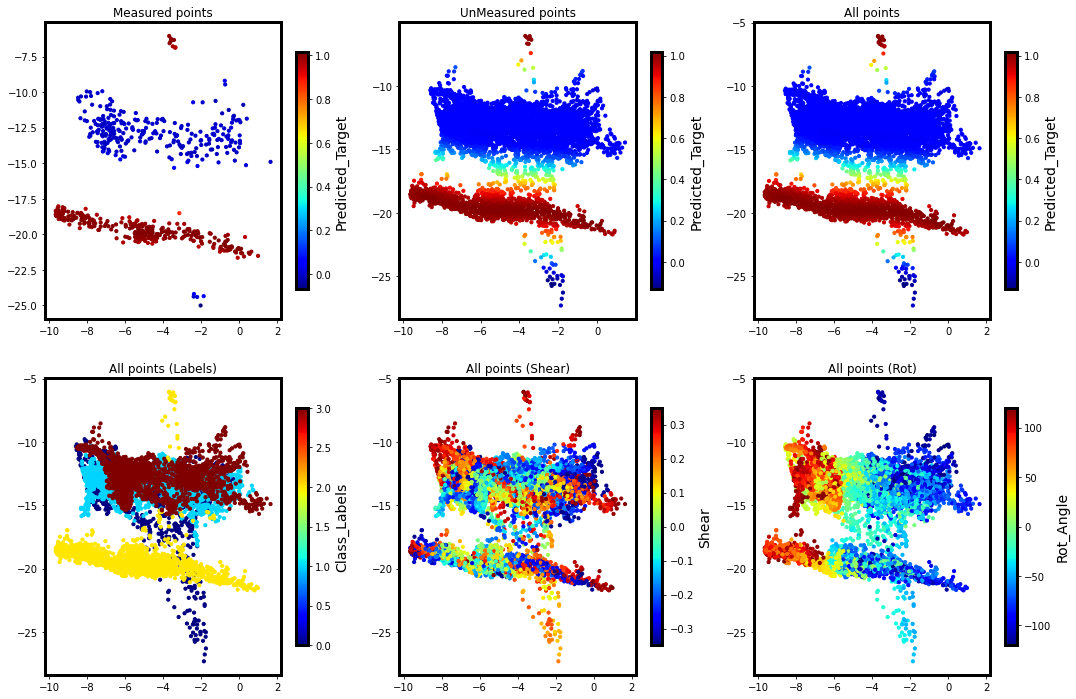

In [31]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train2[:, 1], embeded_train2[:, 0], s=10, c = predmean_train2, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured2[:, 1], embeded_unmeasured2[:, 0], s=10,
                c = predmean_unmeas2, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = predmean12, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Case-3
Target Function: 1 for Diamonds and 0 for the rest of the classes


In [32]:
# First we will run the DKL on the whole dataset in one go
X3 = np.copy(X) # Copying the entire input dataset

# Preparing the targets/outputs
targets3 = np.zeros(len(labels_all))
targets3[labels_all == 3] = 1

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

In [ ]:
# Running the DKL on the whole dataset
rng_key_3, rng_key_predict_3 = gpax.utils.get_keys()
dkl_3 = gpax.viDKL(900, 2, 'RBF')
dkl_3.fit(rng_key_3, X3, targets3)

# Latent space Embedding and prediction on the whole input dataset
embeded_3 = dkl_3.embed(X3)
pred_mean3, pred_var3 = dkl_3.predict_in_batches(rng_key_predict_3, X3, batch_size=250)
pred_std3 = jnp.sqrt(pred_var3)

# Visualization of latent space distributions colored with ground truth and predictions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=50, c = pred_mean3, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=50, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

NameError: name 'dkl_3' is not defined

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO

np.random.seed(0)
idx3 = np.random.choice(np.arange(len(X3)), size = 100, replace = False)
X3_train = X3[idx3]
X3_unmeasured = np.delete(X3, idx3, axis=0)

indices_total_3 = np.arange(len(X))
indices_train_3 = indices_total_3[idx3]
y3_train = targets3[idx3]
indices_unmeasured_3 = np.delete(indices_total_3, idx3)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean3, exp_std3 = [], []
dkl_mean3, dkl_std3 = [], []
embed_traj3 = []
traj_mean3, traj_std3 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key13, rng_key_predict13 = gpax.utils.get_keys()
    dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_3.fit(rng_key13, X3_train, y3_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean3.append(y_mean[id_next])
    exp_std3.append(y_std[id_next])
    
    x_next = X3_unmeasured[id_next]
    ind_next = indices_unmeasured_3[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean3.append(pred_mean3[ind_next])
    dkl_std3.append(pred_std3[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets3[ind_next]
    
    # Update training arrays
    X3_train = np.append(X3_train, x_next[None], axis=0)
    y3_train = np.append(y3_train, y_measured)
    X3_unmeasured = np.delete(X3_unmeasured, id_next, axis=0)
    indices_unmeasured_3 = np.delete(indices_unmeasured_3, id_next)
    
    embed_traj = dkl_BO_3.embed(X3_train)
    traj_m, traj_s = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_train, batch_size=100)
    
    embed_traj3.append(embed_traj)
    traj_mean3.append(traj_m)

# Saving the results
diams_results = {}
diams_results['X_train'] = X3_train
diams_results['y_train'] = y3_train
diams_results['X_unmeasured'] = X3_unmeasured
diams_results['indices_unmeasured'] = indices_unmeasured_3
diams_results['dkl_mean'] = dkl_mean3
diams_results['dkl_std'] = dkl_std3
diams_results['exp_mean'] = exp_mean3
diams_results['exp_std'] = exp_std3
diams_results['traj_mean'] = traj_mean3
diams_results['traj_std'] = traj_std3
diams_results['embed_traj'] = embed_traj3

with open('diams_results.pickle', 'wb') as handle:
    pickle.dump(diams_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 366.74it/s, init loss: 60203.0962, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4492 0.4892]
k_scale          0.28650000000000003
noise            0.010700000000000001

Step 2


100%|█| 1000/1000 [00:02<00:00, 368.21it/s, init loss: 60204.2850, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4066 0.4119]
k_scale          0.3345
noise            0.0091

Step 3


100%|█| 1000/1000 [00:02<00:00, 373.30it/s, init loss: 60205.4963, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6372 0.8627]
k_scale          0.19640000000000002
noise            0.0134

Step 4


100%|█| 1000/1000 [00:03<00:00, 285.46it/s, init loss: 60206.9779, avg. loss [95



Inferred GP kernel parameters
k_length         [0.361  0.4278]
k_scale          0.3553
noise            0.0089

Step 5


100%|█| 1000/1000 [00:02<00:00, 361.37it/s, init loss: 60208.2222, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3201 0.3619]
k_scale          0.4292
noise            0.0083

Step 6


100%|█| 1000/1000 [00:02<00:00, 368.50it/s, init loss: 60209.7283, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3923 0.3703]
k_scale          0.4186
noise            0.008700000000000001

Step 7


100%|█| 1000/1000 [00:02<00:00, 369.56it/s, init loss: 60211.2195, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3388 0.368 ]
k_scale          0.42360000000000003
noise            0.008400000000000001

Step 8


100%|█| 1000/1000 [00:02<00:00, 372.59it/s, init loss: 60212.7217, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7791 0.5777]
k_scale          0.2577
noise            0.010100000000000001

Step 9


100%|█| 1000/1000 [00:02<00:00, 378.26it/s, init loss: 60214.1970, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5218 0.4728]
k_scale          0.3453
noise            0.0103

Step 10


100%|█| 1000/1000 [00:02<00:00, 381.12it/s, init loss: 60215.5802, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3618 0.3326]
k_scale          0.4278
noise            0.0082

Step 11


100%|█| 1000/1000 [00:02<00:00, 354.69it/s, init loss: 60216.7930, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3622 0.359 ]
k_scale          0.41960000000000003
noise            0.0081

Step 12


100%|█| 1000/1000 [00:02<00:00, 364.57it/s, init loss: 60218.1694, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5253 0.7733]
k_scale          0.2605
noise            0.0092

Step 13


100%|█| 1000/1000 [00:02<00:00, 364.97it/s, init loss: 60219.5772, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4283 0.5019]
k_scale          0.2967
noise            0.0106

Step 14


100%|█| 1000/1000 [00:02<00:00, 363.30it/s, init loss: 60221.0699, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3754 0.3433]
k_scale          0.4263
noise            0.0083

Step 15


100%|█| 1000/1000 [00:02<00:00, 369.34it/s, init loss: 60222.5090, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5088 0.4945]
k_scale          0.29300000000000004
noise            0.0105

Step 16


100%|█| 1000/1000 [00:02<00:00, 373.96it/s, init loss: 60223.9811, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4111 0.4221]
k_scale          0.36810000000000004
noise            0.011300000000000001

Step 17


100%|█| 1000/1000 [00:02<00:00, 352.77it/s, init loss: 60225.2178, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3879 0.4834]
k_scale          0.3674
noise            0.0091

Step 18


100%|█| 1000/1000 [00:02<00:00, 363.34it/s, init loss: 60226.7158, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4851 0.5087]
k_scale          0.35750000000000004
noise            0.0086

Step 19


100%|█| 1000/1000 [00:02<00:00, 364.01it/s, init loss: 60228.2190, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3646 0.3602]
k_scale          0.4188
noise            0.0082

Step 20


100%|█| 1000/1000 [00:02<00:00, 360.16it/s, init loss: 60229.5218, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6943 0.7252]
k_scale          0.2574
noise            0.0112

Step 21


100%|█| 1000/1000 [00:02<00:00, 368.51it/s, init loss: 60230.7409, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4938 0.4031]
k_scale          0.24230000000000002
noise            0.0122

Step 22


100%|█| 1000/1000 [00:02<00:00, 371.92it/s, init loss: 60232.0448, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3922 0.4145]
k_scale          0.4091
noise            0.0083

Step 23


100%|█| 1000/1000 [00:02<00:00, 349.05it/s, init loss: 60233.4032, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4203 0.3848]
k_scale          0.3519
noise            0.0086

Step 24


100%|█| 1000/1000 [00:02<00:00, 358.00it/s, init loss: 60234.6391, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4604 0.4735]
k_scale          0.3793
noise            0.0082

Step 25


100%|█| 1000/1000 [00:02<00:00, 359.84it/s, init loss: 60235.8521, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5379 0.5054]
k_scale          0.3161
noise            0.0089

Step 26


100%|█| 1000/1000 [00:02<00:00, 360.11it/s, init loss: 60237.3574, avg. loss [95



Inferred GP kernel parameters
k_length         [0.384 0.392]
k_scale          0.42050000000000004
noise            0.0088

Step 27


100%|█| 1000/1000 [00:02<00:00, 364.45it/s, init loss: 60238.8627, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3606 0.4051]
k_scale          0.37670000000000003
noise            0.0081

Step 28


100%|█| 1000/1000 [00:02<00:00, 365.20it/s, init loss: 60240.0595, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3904 0.4005]
k_scale          0.42300000000000004
noise            0.0081

Step 29


100%|█| 1000/1000 [00:04<00:00, 249.01it/s, init loss: 60241.3598, avg. loss [95



Inferred GP kernel parameters
k_length         [0.452  0.5537]
k_scale          0.2962
noise            0.0095

Step 30


100%|█| 1000/1000 [00:02<00:00, 346.66it/s, init loss: 60242.8012, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4437 0.4361]
k_scale          0.36610000000000004
noise            0.008700000000000001

Step 31


100%|█| 1000/1000 [00:02<00:00, 351.96it/s, init loss: 60244.0079, avg. loss [95



Inferred GP kernel parameters
k_length         [0.2732 0.3367]
k_scale          0.5137
noise            0.0095

Step 32


100%|█| 1000/1000 [00:02<00:00, 355.61it/s, init loss: 60245.3740, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4701 0.4636]
k_scale          0.3497
noise            0.008700000000000001

Step 33


100%|█| 1000/1000 [00:02<00:00, 359.85it/s, init loss: 60246.5786, avg. loss [95



Inferred GP kernel parameters
k_length         [0.379  0.4121]
k_scale          0.34950000000000003
noise            0.0081

Step 34


100%|█| 1000/1000 [00:02<00:00, 354.94it/s, init loss: 60247.7892, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7781 0.667 ]
k_scale          0.22610000000000002
noise            0.010700000000000001

Step 35


100%|█| 1000/1000 [00:02<00:00, 362.63it/s, init loss: 60249.1991, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6291 0.5428]
k_scale          0.3003
noise            0.0094

Step 36


100%|█| 1000/1000 [00:02<00:00, 343.46it/s, init loss: 60250.3797, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6792 0.7902]
k_scale          0.25220000000000004
noise            0.009000000000000001

Step 37


100%|█| 1000/1000 [00:02<00:00, 351.89it/s, init loss: 60251.7125, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8123 0.8885]
k_scale          0.17700000000000002
noise            0.013800000000000002

Step 38


100%|█| 1000/1000 [00:02<00:00, 355.97it/s, init loss: 60253.2135, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3749 0.4842]
k_scale          0.3402
noise            0.008700000000000001

Step 39


100%|█| 1000/1000 [00:02<00:00, 360.27it/s, init loss: 60254.4653, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4084 0.5147]
k_scale          0.34290000000000004
noise            0.0098

Step 40


100%|█| 1000/1000 [00:02<00:00, 358.96it/s, init loss: 60255.6253, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5618 0.5047]
k_scale          0.2705
noise            0.0095

Step 41


100%|█| 1000/1000 [00:02<00:00, 361.71it/s, init loss: 60256.8258, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8919 0.75  ]
k_scale          0.2386
noise            0.008700000000000001

Step 42


100%|█| 1000/1000 [00:02<00:00, 345.56it/s, init loss: 60258.2154, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3701 0.4204]
k_scale          0.3466
noise            0.0085

Step 43


100%|█| 1000/1000 [00:02<00:00, 351.66it/s, init loss: 60259.5386, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4183 0.4678]
k_scale          0.2559
noise            0.010100000000000001

Step 44


100%|█| 1000/1000 [00:02<00:00, 355.31it/s, init loss: 60260.8979, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4374 0.378 ]
k_scale          0.327
noise            0.008700000000000001

Step 45


100%|█| 1000/1000 [00:02<00:00, 353.61it/s, init loss: 60262.1422, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6548 0.6424]
k_scale          0.2691
noise            0.0088

Step 46


100%|█| 1000/1000 [00:02<00:00, 356.02it/s, init loss: 60263.3864, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4136 0.4373]
k_scale          0.312
noise            0.0089

Step 47


100%|█| 1000/1000 [00:02<00:00, 358.99it/s, init loss: 60264.8826, avg. loss [95



Inferred GP kernel parameters
k_length         [0.398  0.3476]
k_scale          0.3562
noise            0.0081

Step 48


100%|█| 1000/1000 [00:02<00:00, 340.18it/s, init loss: 60266.3757, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5197 0.4862]
k_scale          0.3014
noise            0.0097

Step 49


100%|█| 1000/1000 [00:02<00:00, 349.68it/s, init loss: 60267.5707, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6505 0.7422]
k_scale          0.222
noise            0.0131

Step 50


100%|█| 1000/1000 [00:02<00:00, 351.83it/s, init loss: 60269.0682, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4457 0.4552]
k_scale          0.3165
noise            0.008400000000000001

Step 51


100%|█| 1000/1000 [00:02<00:00, 349.82it/s, init loss: 60270.3812, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5154 0.5768]
k_scale          0.30160000000000003
noise            0.008700000000000001

Step 52


100%|█| 1000/1000 [00:02<00:00, 354.14it/s, init loss: 60271.7645, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4404 0.4006]
k_scale          0.327
noise            0.0083

Step 53


100%|█| 1000/1000 [00:02<00:00, 353.98it/s, init loss: 60273.1665, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4907 0.52  ]
k_scale          0.314
noise            0.0085

Step 54


100%|█| 1000/1000 [00:04<00:00, 244.59it/s, init loss: 60274.3711, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6334 0.4648]
k_scale          0.2751
noise            0.0095

Step 55


100%|█| 1000/1000 [00:02<00:00, 347.33it/s, init loss: 60275.8741, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5636 0.4808]
k_scale          0.3161
noise            0.008400000000000001

Step 56


100%|█| 1000/1000 [00:02<00:00, 352.78it/s, init loss: 60277.3509, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5257 0.575 ]
k_scale          0.26080000000000003
noise            0.0092

Step 57


100%|█| 1000/1000 [00:02<00:00, 354.63it/s, init loss: 60278.6953, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7621 0.8304]
k_scale          0.2363
noise            0.0092

Step 58


100%|█| 1000/1000 [00:02<00:00, 356.20it/s, init loss: 60280.1853, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5491 0.4848]
k_scale          0.2896
noise            0.0098

Step 59


100%|█| 1000/1000 [00:02<00:00, 354.50it/s, init loss: 60281.5133, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5223 0.5574]
k_scale          0.3114
noise            0.0085

Step 60


100%|█| 1000/1000 [00:04<00:00, 245.95it/s, init loss: 60282.9375, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5689 0.6255]
k_scale          0.27840000000000004
noise            0.0098

Step 61


100%|█| 1000/1000 [00:02<00:00, 350.28it/s, init loss: 60284.1103, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4313 0.46  ]
k_scale          0.3133
noise            0.0082

Step 62


100%|█| 1000/1000 [00:02<00:00, 351.18it/s, init loss: 60285.3163, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4324 0.4782]
k_scale          0.2738
noise            0.0098

Step 63


100%|█| 1000/1000 [00:02<00:00, 355.39it/s, init loss: 60286.5359, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6046 0.7058]
k_scale          0.27290000000000003
noise            0.009000000000000001

Step 64


100%|█| 1000/1000 [00:02<00:00, 354.65it/s, init loss: 60287.7679, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5156 0.4906]
k_scale          0.3042
noise            0.0089

Step 65


100%|█| 1000/1000 [00:02<00:00, 355.99it/s, init loss: 60289.0126, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4543 0.5187]
k_scale          0.3007
noise            0.008400000000000001

Step 66


100%|█| 1000/1000 [00:02<00:00, 356.02it/s, init loss: 60290.5174, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5827 0.5965]
k_scale          0.322
noise            0.009600000000000001

Step 67


100%|█| 1000/1000 [00:02<00:00, 336.91it/s, init loss: 60291.7577, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8379 0.9609]
k_scale          0.219
noise            0.009300000000000001

Step 68


100%|█| 1000/1000 [00:02<00:00, 346.03it/s, init loss: 60293.2521, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4994 0.5587]
k_scale          0.3262
noise            0.0082

Step 69


100%|█| 1000/1000 [00:02<00:00, 350.08it/s, init loss: 60294.7138, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4843 0.5059]
k_scale          0.2467
noise            0.010400000000000001

Step 70


100%|█| 1000/1000 [00:02<00:00, 349.65it/s, init loss: 60295.9599, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4217 0.4115]
k_scale          0.3299
noise            0.0081

Step 71


100%|█| 1000/1000 [00:02<00:00, 353.46it/s, init loss: 60297.2018, avg. loss [95



Inferred GP kernel parameters
k_length         [0.487  0.5891]
k_scale          0.32330000000000003
noise            0.0082

Step 72


100%|█| 1000/1000 [00:02<00:00, 352.83it/s, init loss: 60298.6025, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8454 0.754 ]
k_scale          0.22560000000000002
noise            0.0102

Step 73


100%|█| 1000/1000 [00:03<00:00, 331.97it/s, init loss: 60299.8468, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5752 0.641 ]
k_scale          0.19490000000000002
noise            0.0108

Step 74


100%|█| 1000/1000 [00:02<00:00, 345.88it/s, init loss: 60300.9985, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6064 0.6576]
k_scale          0.3145
noise            0.0083

Step 75


100%|█| 1000/1000 [00:02<00:00, 347.65it/s, init loss: 60302.2389, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7374 0.8303]
k_scale          0.2635
noise            0.008700000000000001

Step 76


100%|█| 1000/1000 [00:02<00:00, 345.32it/s, init loss: 60303.6419, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4953 0.4502]
k_scale          0.3279
noise            0.008700000000000001

Step 77


100%|█| 1000/1000 [00:02<00:00, 350.71it/s, init loss: 60304.8848, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4551 0.5625]
k_scale          0.31470000000000004
noise            0.0085

Step 78


100%|█| 1000/1000 [00:02<00:00, 350.24it/s, init loss: 60306.2504, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4036 0.4272]
k_scale          0.31570000000000004
noise            0.008400000000000001

Step 79


100%|█| 1000/1000 [00:04<00:00, 236.59it/s, init loss: 60307.6106, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5054 0.5973]
k_scale          0.2592
noise            0.009600000000000001

Step 80


100%|█| 1000/1000 [00:02<00:00, 344.38it/s, init loss: 60309.0035, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5587 0.6965]
k_scale          0.30210000000000004
noise            0.0088

Step 81


100%|█| 1000/1000 [00:02<00:00, 347.68it/s, init loss: 60310.3827, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4233 0.4009]
k_scale          0.34240000000000004
noise            0.0076

Step 82


100%|█| 1000/1000 [00:02<00:00, 347.35it/s, init loss: 60311.6195, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7229 0.5953]
k_scale          0.2836
noise            0.009300000000000001

Step 83


100%|█| 1000/1000 [00:02<00:00, 349.12it/s, init loss: 60313.0972, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0634 1.5066]
k_scale          0.1685
noise            0.0102

Step 84


100%|█| 1000/1000 [00:02<00:00, 362.42it/s, init loss: 60314.5670, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6045 0.65  ]
k_scale          0.29910000000000003
noise            0.0091

Step 85


100%|█| 1000/1000 [00:03<00:00, 276.40it/s, init loss: 60315.9919, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4427 0.4614]
k_scale          0.3156
noise            0.008400000000000001

Step 86


100%|█| 1000/1000 [00:02<00:00, 356.20it/s, init loss: 60317.4968, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8645 0.9321]
k_scale          0.26730000000000004
noise            0.0088

Step 87


100%|█| 1000/1000 [00:02<00:00, 357.79it/s, init loss: 60318.8619, avg. loss [95



Inferred GP kernel parameters
k_length         [0.53   0.4451]
k_scale          0.3266
noise            0.008

Step 88


100%|█| 1000/1000 [00:02<00:00, 356.23it/s, init loss: 60320.3184, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6435 0.7244]
k_scale          0.2485
noise            0.009300000000000001

Step 89


100%|█| 1000/1000 [00:02<00:00, 359.32it/s, init loss: 60321.7766, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5015 0.5269]
k_scale          0.3111
noise            0.008400000000000001

Step 90


100%|█| 1000/1000 [00:02<00:00, 359.87it/s, init loss: 60323.2373, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6511 0.6243]
k_scale          0.2862
noise            0.0088

Step 91


100%|█| 1000/1000 [00:02<00:00, 360.70it/s, init loss: 60324.4775, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8294 0.8449]
k_scale          0.26330000000000003
noise            0.008400000000000001

Step 92


100%|█| 1000/1000 [00:02<00:00, 344.25it/s, init loss: 60325.7977, avg. loss [95



Inferred GP kernel parameters
k_length         [0.509  0.5226]
k_scale          0.3019
noise            0.008

Step 93


100%|█| 1000/1000 [00:02<00:00, 354.32it/s, init loss: 60327.1185, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7072 0.5329]
k_scale          0.2947
noise            0.0082

Step 94


100%|█| 1000/1000 [00:02<00:00, 354.14it/s, init loss: 60328.4601, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4554 0.4561]
k_scale          0.3269
noise            0.0081

Step 95


100%|█| 1000/1000 [00:02<00:00, 354.72it/s, init loss: 60329.7616, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9676 1.0209]
k_scale          0.1913
noise            0.010400000000000001

Step 96


100%|█| 1000/1000 [00:02<00:00, 356.36it/s, init loss: 60331.0058, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3709 0.4143]
k_scale          0.3452
noise            0.009000000000000001

Step 97


100%|█| 1000/1000 [00:02<00:00, 357.43it/s, init loss: 60332.3652, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0855 1.0994]
k_scale          0.2228
noise            0.0089

Step 98


100%|█| 1000/1000 [00:02<00:00, 344.61it/s, init loss: 60333.8705, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7569 0.6115]
k_scale          0.2767
noise            0.0085

Step 99


100%|█| 1000/1000 [00:02<00:00, 353.32it/s, init loss: 60335.3507, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5393 0.5845]
k_scale          0.3156
noise            0.0085

Step 100


100%|█| 1000/1000 [00:02<00:00, 356.33it/s, init loss: 60336.8218, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5407 0.4904]
k_scale          0.2828
noise            0.0089

Step 101


100%|█| 1000/1000 [00:02<00:00, 355.48it/s, init loss: 60338.1333, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5447 0.8483]
k_scale          0.2485
noise            0.0098

Step 102


100%|█| 1000/1000 [00:02<00:00, 358.61it/s, init loss: 60339.3776, avg. loss [95



Inferred GP kernel parameters
k_length         [0.93   0.8671]
k_scale          0.233
noise            0.0086

Step 103


100%|█| 1000/1000 [00:02<00:00, 362.25it/s, init loss: 60340.6696, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4002 1.1385]
k_scale          0.2157
noise            0.0089

Step 104


100%|█| 1000/1000 [00:03<00:00, 276.62it/s, init loss: 60342.1730, avg. loss [95



Inferred GP kernel parameters
k_length         [0.589  0.6199]
k_scale          0.306
noise            0.0083

Step 105


100%|█| 1000/1000 [00:02<00:00, 348.86it/s, init loss: 60343.6057, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4877 0.5265]
k_scale          0.3015
noise            0.0086

Step 106


100%|█| 1000/1000 [00:02<00:00, 353.51it/s, init loss: 60344.8941, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9461 1.1216]
k_scale          0.1723
noise            0.0102

Step 107


100%|█| 1000/1000 [00:02<00:00, 354.30it/s, init loss: 60346.2873, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5906 0.6783]
k_scale          0.2712
noise            0.009000000000000001

Step 108


100%|█| 1000/1000 [00:02<00:00, 357.73it/s, init loss: 60347.4997, avg. loss [95



Inferred GP kernel parameters
k_length         [0.549  0.4993]
k_scale          0.278
noise            0.008700000000000001

Step 109


100%|█| 1000/1000 [00:02<00:00, 358.58it/s, init loss: 60348.7436, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7751 0.6712]
k_scale          0.2611
noise            0.0091

Step 110


100%|█| 1000/1000 [00:02<00:00, 359.26it/s, init loss: 60350.2077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4182 0.5793]
k_scale          0.2827
noise            0.0089

Step 111


100%|█| 1000/1000 [00:02<00:00, 347.45it/s, init loss: 60351.5228, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5617 0.5829]
k_scale          0.2898
noise            0.0083

Step 112


100%|█| 1000/1000 [00:02<00:00, 349.16it/s, init loss: 60352.7926, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4782 0.4887]
k_scale          0.3057
noise            0.008700000000000001

Step 113


100%|█| 1000/1000 [00:02<00:00, 352.39it/s, init loss: 60354.1565, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8123 0.6546]
k_scale          0.2571
noise            0.0092

Step 114


100%|█| 1000/1000 [00:02<00:00, 351.85it/s, init loss: 60355.3507, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5975 1.3716]
k_scale          0.2232
noise            0.0089

Step 115


100%|█| 1000/1000 [00:02<00:00, 355.08it/s, init loss: 60356.6231, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5978 0.5688]
k_scale          0.2762
noise            0.0088

Step 116


100%|█| 1000/1000 [00:02<00:00, 359.40it/s, init loss: 60357.8725, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7616 0.9785]
k_scale          0.22970000000000002
noise            0.0092

Step 117


100%|█| 1000/1000 [00:02<00:00, 342.56it/s, init loss: 60359.1697, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6052 1.4967]
k_scale          0.20350000000000001
noise            0.0099

Step 118


100%|█| 1000/1000 [00:02<00:00, 349.90it/s, init loss: 60360.4176, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6727 0.8052]
k_scale          0.28150000000000003
noise            0.008400000000000001

Step 119


100%|█| 1000/1000 [00:02<00:00, 353.63it/s, init loss: 60361.8206, avg. loss [95



Inferred GP kernel parameters
k_length         [0.837  0.6619]
k_scale          0.23390000000000002
noise            0.0118

Step 120


100%|█| 1000/1000 [00:02<00:00, 346.93it/s, init loss: 60363.2484, avg. loss [95



Inferred GP kernel parameters
k_length         [0.54   0.4795]
k_scale          0.3181
noise            0.008

Step 121


100%|█| 1000/1000 [00:02<00:00, 352.33it/s, init loss: 60364.5022, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4184 0.4176]
k_scale          0.313
noise            0.0082

Step 122


100%|█| 1000/1000 [00:02<00:00, 352.42it/s, init loss: 60365.7457, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5463 1.1139]
k_scale          0.22560000000000002
noise            0.009000000000000001

Step 123


100%|█| 1000/1000 [00:04<00:00, 246.44it/s, init loss: 60367.0925, avg. loss [95



Inferred GP kernel parameters
k_length         [0.744  0.8134]
k_scale          0.2501
noise            0.008700000000000001

Step 124


100%|█| 1000/1000 [00:02<00:00, 339.30it/s, init loss: 60368.3430, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6994 0.5367]
k_scale          0.32170000000000004
noise            0.0081

Step 125


100%|█| 1000/1000 [00:02<00:00, 346.32it/s, init loss: 60369.6733, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6359 0.5323]
k_scale          0.3104
noise            0.0082

Step 126


100%|█| 1000/1000 [00:02<00:00, 347.68it/s, init loss: 60370.9738, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2557 1.134 ]
k_scale          0.22760000000000002
noise            0.0092

Step 127


100%|█| 1000/1000 [00:02<00:00, 349.72it/s, init loss: 60372.1483, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7199 0.9303]
k_scale          0.263
noise            0.0081

Step 128


100%|█| 1000/1000 [00:02<00:00, 350.92it/s, init loss: 60373.5659, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9239 1.3133]
k_scale          0.2285
noise            0.008400000000000001

Step 129


100%|█| 1000/1000 [00:02<00:00, 360.07it/s, init loss: 60374.7431, avg. loss [95



Inferred GP kernel parameters
k_length         [0.671  0.6278]
k_scale          0.2646
noise            0.009000000000000001

Step 130


100%|█| 1000/1000 [00:02<00:00, 349.14it/s, init loss: 60375.9648, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5432 0.7041]
k_scale          0.28950000000000004
noise            0.0085

Step 131


100%|█| 1000/1000 [00:02<00:00, 353.42it/s, init loss: 60377.4622, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7191 0.6119]
k_scale          0.273
noise            0.0089

Step 132


100%|█| 1000/1000 [00:02<00:00, 356.44it/s, init loss: 60378.8187, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4426 0.4252]
k_scale          0.312
noise            0.0085

Step 133


100%|█| 1000/1000 [00:02<00:00, 358.00it/s, init loss: 60380.0664, avg. loss [95



Inferred GP kernel parameters
k_length         [1.131  1.2207]
k_scale          0.2001
noise            0.009000000000000001

Step 134


100%|█| 1000/1000 [00:02<00:00, 358.37it/s, init loss: 60381.3748, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7355 0.8488]
k_scale          0.2559
noise            0.0086

Step 135


100%|█| 1000/1000 [00:02<00:00, 359.96it/s, init loss: 60382.7653, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6589 0.5757]
k_scale          0.2878
noise            0.0083

Step 136


100%|█| 1000/1000 [00:02<00:00, 346.34it/s, init loss: 60383.9610, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5158 0.4946]
k_scale          0.30670000000000003
noise            0.0081

Step 137


100%|█| 1000/1000 [00:02<00:00, 351.65it/s, init loss: 60385.4414, avg. loss [95



Inferred GP kernel parameters
k_length         [0.661 0.545]
k_scale          0.29400000000000004
noise            0.0092

Step 138


100%|█| 1000/1000 [00:02<00:00, 350.56it/s, init loss: 60386.6293, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6624 0.7214]
k_scale          0.2747
noise            0.008400000000000001

Step 139


100%|█| 1000/1000 [00:02<00:00, 355.66it/s, init loss: 60387.8824, avg. loss [95



Inferred GP kernel parameters
k_length         [0.906  0.7823]
k_scale          0.228
noise            0.009300000000000001

Step 140


100%|█| 1000/1000 [00:02<00:00, 356.09it/s, init loss: 60389.0840, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8727 0.7265]
k_scale          0.2285
noise            0.009000000000000001

Step 141


100%|█| 1000/1000 [00:02<00:00, 363.51it/s, init loss: 60390.3560, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5531 0.5323]
k_scale          0.2867
noise            0.0089

Step 142


100%|█| 1000/1000 [00:03<00:00, 268.91it/s, init loss: 60391.7918, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5624 0.5075]
k_scale          0.308
noise            0.0082

Step 143


100%|█| 1000/1000 [00:02<00:00, 347.45it/s, init loss: 60393.2255, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5964 0.638 ]
k_scale          0.3013
noise            0.0081

Step 144


100%|█| 1000/1000 [00:02<00:00, 349.57it/s, init loss: 60394.4673, avg. loss [95



Inferred GP kernel parameters
k_length         [0.934  0.8443]
k_scale          0.2614
noise            0.008400000000000001

Step 145


100%|█| 1000/1000 [00:02<00:00, 353.44it/s, init loss: 60395.7092, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5474 0.562 ]
k_scale          0.2921
noise            0.009000000000000001

Step 146


100%|█| 1000/1000 [00:02<00:00, 353.24it/s, init loss: 60397.2129, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8912 0.8118]
k_scale          0.25880000000000003
noise            0.008400000000000001

Step 147


100%|█| 1000/1000 [00:02<00:00, 356.91it/s, init loss: 60398.4082, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6341 0.6544]
k_scale          0.2818
noise            0.0083

Step 148


100%|█| 1000/1000 [00:03<00:00, 275.29it/s, init loss: 60399.6965, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8296 0.8502]
k_scale          0.261
noise            0.0086

Step 149


100%|█| 1000/1000 [00:02<00:00, 348.29it/s, init loss: 60400.9133, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5507 0.5342]
k_scale          0.3713
noise            0.0108

Step 150


100%|█| 1000/1000 [00:02<00:00, 350.89it/s, init loss: 60402.1575, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6735 0.5985]
k_scale          0.29350000000000004
noise            0.0091

Step 151


100%|█| 1000/1000 [00:02<00:00, 353.29it/s, init loss: 60403.3470, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4556 1.6132]
k_scale          0.1705
noise            0.0095

Step 152


100%|█| 1000/1000 [00:02<00:00, 354.53it/s, init loss: 60404.4973, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1672 0.9843]
k_scale          0.2594
noise            0.0085

Step 153


100%|█| 1000/1000 [00:02<00:00, 358.01it/s, init loss: 60405.8526, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6799 0.6299]
k_scale          0.2594
noise            0.0086

Step 154


100%|█| 1000/1000 [00:02<00:00, 360.19it/s, init loss: 60407.3179, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4912 0.5181]
k_scale          0.3114
noise            0.008

Step 155


100%|█| 1000/1000 [00:02<00:00, 341.06it/s, init loss: 60408.5302, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7948 1.6676]
k_scale          0.1951
noise            0.0089

Step 156


100%|█| 1000/1000 [00:02<00:00, 346.50it/s, init loss: 60409.8399, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7184 0.7787]
k_scale          0.252
noise            0.0088

Step 157


100%|█| 1000/1000 [00:02<00:00, 347.66it/s, init loss: 60411.1526, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7135 0.684 ]
k_scale          0.2914
noise            0.0081

Step 158


100%|█| 1000/1000 [00:02<00:00, 346.12it/s, init loss: 60412.6571, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7884 0.7321]
k_scale          0.2846
noise            0.0092

Step 159


100%|█| 1000/1000 [00:02<00:00, 348.43it/s, init loss: 60413.8828, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8005 0.6312]
k_scale          0.2757
noise            0.008400000000000001

Step 160


100%|█| 1000/1000 [00:02<00:00, 350.26it/s, init loss: 60415.3186, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0433 1.32  ]
k_scale          0.23850000000000002
noise            0.0089

Step 161


100%|█| 1000/1000 [00:03<00:00, 332.49it/s, init loss: 60416.6441, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6869 0.6223]
k_scale          0.2831
noise            0.009000000000000001

Step 162


100%|█| 1000/1000 [00:03<00:00, 329.61it/s, init loss: 60418.0642, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5116 0.5012]
k_scale          0.3128
noise            0.0079

Step 163


100%|█| 1000/1000 [00:02<00:00, 346.58it/s, init loss: 60419.3304, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0525 0.959 ]
k_scale          0.2581
noise            0.0082

Step 164


100%|█| 1000/1000 [00:02<00:00, 346.82it/s, init loss: 60420.6684, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8095 0.9285]
k_scale          0.269
noise            0.0082

Step 165


100%|█| 1000/1000 [00:02<00:00, 349.40it/s, init loss: 60421.8598, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6503 0.6539]
k_scale          0.29400000000000004
noise            0.0082

Step 166


100%|█| 1000/1000 [00:02<00:00, 349.16it/s, init loss: 60423.1802, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1514 0.9115]
k_scale          0.2414
noise            0.008400000000000001

Step 167


100%|█| 1000/1000 [00:03<00:00, 265.16it/s, init loss: 60424.6220, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6556 0.7743]
k_scale          0.2684
noise            0.0083

Step 168


100%|█| 1000/1000 [00:02<00:00, 341.85it/s, init loss: 60426.0606, avg. loss [95



Inferred GP kernel parameters
k_length         [0.741  0.6455]
k_scale          0.2841
noise            0.008400000000000001

Step 169


100%|█| 1000/1000 [00:02<00:00, 345.98it/s, init loss: 60427.3735, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6482 0.5688]
k_scale          0.3114
noise            0.010100000000000001

Step 170


100%|█| 1000/1000 [00:02<00:00, 346.94it/s, init loss: 60428.7956, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5752 1.6244]
k_scale          0.1955
noise            0.0089

Step 171


100%|█| 1000/1000 [00:02<00:00, 348.44it/s, init loss: 60430.1107, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1306 1.4317]
k_scale          0.20570000000000002
noise            0.0086

Step 172


100%|█| 1000/1000 [00:02<00:00, 351.41it/s, init loss: 60431.3592, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9171 0.8748]
k_scale          0.2585
noise            0.0083

Step 173


100%|█| 1000/1000 [00:03<00:00, 267.80it/s, init loss: 60432.6752, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5496 0.5066]
k_scale          0.3116
noise            0.008

Step 174


100%|█| 1000/1000 [00:02<00:00, 340.89it/s, init loss: 60433.9728, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0829 1.4172]
k_scale          0.1923
noise            0.0106

Step 175


100%|█| 1000/1000 [00:02<00:00, 344.42it/s, init loss: 60435.4207, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6666 0.6054]
k_scale          0.28240000000000004
noise            0.0083

Step 176


100%|█| 1000/1000 [00:02<00:00, 346.87it/s, init loss: 60436.7331, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0771 1.1818]
k_scale          0.2394
noise            0.0086

Step 177


100%|█| 1000/1000 [00:02<00:00, 347.81it/s, init loss: 60437.9774, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6214 0.7141]
k_scale          0.2954
noise            0.008

Step 178


100%|█| 1000/1000 [00:02<00:00, 349.37it/s, init loss: 60439.2930, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5506 1.0518]
k_scale          0.21130000000000002
noise            0.010100000000000001

Step 179


100%|█| 1000/1000 [00:02<00:00, 353.49it/s, init loss: 60440.4756, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6009 0.5241]
k_scale          0.2993
noise            0.0079

Step 180


100%|█| 1000/1000 [00:03<00:00, 331.48it/s, init loss: 60441.7632, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4849 0.8951]
k_scale          0.21530000000000002
noise            0.008400000000000001

Step 181


100%|█| 1000/1000 [00:02<00:00, 339.78it/s, init loss: 60442.9667, avg. loss [95



Inferred GP kernel parameters
k_length         [0.482  0.5689]
k_scale          0.3139
noise            0.008700000000000001

Step 182


100%|█| 1000/1000 [00:02<00:00, 340.92it/s, init loss: 60444.1510, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8549 0.774 ]
k_scale          0.3002
noise            0.008

Step 183


100%|█| 1000/1000 [00:02<00:00, 342.58it/s, init loss: 60445.4568, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0825 0.9925]
k_scale          0.2776
noise            0.0094

Step 184


100%|█| 1000/1000 [00:02<00:00, 345.55it/s, init loss: 60446.7037, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2686 1.1475]
k_scale          0.23920000000000002
noise            0.0083

Step 185


100%|█| 1000/1000 [00:02<00:00, 348.79it/s, init loss: 60448.1046, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4571 1.3178]
k_scale          0.2451
noise            0.008400000000000001

Step 186


100%|█| 1000/1000 [00:03<00:00, 261.86it/s, init loss: 60449.4203, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9464 1.141 ]
k_scale          0.2676
noise            0.0082

Step 187


100%|█| 1000/1000 [00:02<00:00, 337.86it/s, init loss: 60450.9154, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1341 0.9297]
k_scale          0.2197
noise            0.0085

Step 188


100%|█| 1000/1000 [00:02<00:00, 342.48it/s, init loss: 60452.2899, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9837 0.8234]
k_scale          0.22340000000000002
noise            0.009600000000000001

Step 189


100%|█| 1000/1000 [00:02<00:00, 344.74it/s, init loss: 60453.4686, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8419 0.7146]
k_scale          0.2539
noise            0.008400000000000001

Step 190


100%|█| 1000/1000 [00:02<00:00, 344.55it/s, init loss: 60454.6649, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3668 1.1299]
k_scale          0.2141
noise            0.008700000000000001

Step 191


100%|█| 1000/1000 [00:02<00:00, 348.03it/s, init loss: 60456.0922, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7456 0.6781]
k_scale          0.2952
noise            0.0085

Step 192


100%|█| 1000/1000 [00:03<00:00, 266.94it/s, init loss: 60457.3504, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2006 1.273 ]
k_scale          0.2366
noise            0.0083

Step 193


100%|█| 1000/1000 [00:02<00:00, 340.28it/s, init loss: 60458.6073, avg. loss [95



Inferred GP kernel parameters
k_length         [0.948  0.9038]
k_scale          0.26230000000000003
noise            0.0082

Step 194


100%|█| 1000/1000 [00:02<00:00, 342.44it/s, init loss: 60459.9715, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1677 1.0162]
k_scale          0.2141
noise            0.009000000000000001

Step 195


100%|█| 1000/1000 [00:02<00:00, 343.65it/s, init loss: 60461.2271, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1585 0.8364]
k_scale          0.23700000000000002
noise            0.0083

Step 196


100%|█| 1000/1000 [00:02<00:00, 345.62it/s, init loss: 60462.3818, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2685 1.0746]
k_scale          0.219
noise            0.0088

Step 197


100%|█| 1000/1000 [00:02<00:00, 350.85it/s, init loss: 60463.5635, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9147 2.2821]
k_scale          0.19
noise            0.0098

Step 198


100%|█| 1000/1000 [00:02<00:00, 354.65it/s, init loss: 60464.7513, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5157 1.3588]
k_scale          0.219
noise            0.0085

Step 199


100%|█| 1000/1000 [00:03<00:00, 327.51it/s, init loss: 60466.2178, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8682 0.7939]
k_scale          0.26030000000000003
noise            0.0088

Step 200


100%|█| 1000/1000 [00:02<00:00, 340.55it/s, init loss: 60467.4388, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0649 0.811 ]
k_scale          0.24070000000000003
noise            0.0089

Step 201


100%|█| 1000/1000 [00:02<00:00, 341.02it/s, init loss: 60468.9395, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2537 1.5597]
k_scale          0.19890000000000002
noise            0.0088

Step 202


100%|█| 1000/1000 [00:02<00:00, 341.41it/s, init loss: 60470.2459, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4681 1.5311]
k_scale          0.20500000000000002
noise            0.0086

Step 203


100%|█| 1000/1000 [00:02<00:00, 345.16it/s, init loss: 60471.4461, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9381 0.839 ]
k_scale          0.2611
noise            0.008400000000000001

Step 204


100%|█| 1000/1000 [00:02<00:00, 349.27it/s, init loss: 60472.8818, avg. loss [95



Inferred GP kernel parameters
k_length         [1.57   0.9754]
k_scale          0.2466
noise            0.0082

Step 205


100%|█| 1000/1000 [00:03<00:00, 263.96it/s, init loss: 60474.1299, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3146 1.036 ]
k_scale          0.2257
noise            0.0088

Step 206


100%|█| 1000/1000 [00:03<00:00, 332.55it/s, init loss: 60475.4520, avg. loss [95



Inferred GP kernel parameters
k_length         [0.72   0.6165]
k_scale          0.2803
noise            0.0083

Step 207


100%|█| 1000/1000 [00:02<00:00, 337.96it/s, init loss: 60476.7453, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0544 2.5802]
k_scale          0.161
noise            0.009600000000000001

Step 208


100%|█| 1000/1000 [00:02<00:00, 343.32it/s, init loss: 60477.9861, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0095 0.9113]
k_scale          0.2504
noise            0.0088

Step 209


100%|█| 1000/1000 [00:02<00:00, 343.77it/s, init loss: 60479.3853, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1434 1.4354]
k_scale          0.22010000000000002
noise            0.0094

Step 210


100%|█| 1000/1000 [00:02<00:00, 348.60it/s, init loss: 60480.7057, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6777 0.6304]
k_scale          0.332
noise            0.008

Step 211


100%|█| 1000/1000 [00:03<00:00, 282.30it/s, init loss: 60482.0933, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2493 1.0701]
k_scale          0.20650000000000002
noise            0.008700000000000001

Step 212


100%|█| 1000/1000 [00:03<00:00, 326.59it/s, init loss: 60483.4820, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9524 1.2283]
k_scale          0.1995
noise            0.0094

Step 213


100%|█| 1000/1000 [00:03<00:00, 330.63it/s, init loss: 60484.7045, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1339 0.9007]
k_scale          0.23970000000000002
noise            0.0085

Step 214


100%|█| 1000/1000 [00:02<00:00, 334.34it/s, init loss: 60485.9358, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7839 0.7163]
k_scale          0.2917
noise            0.0081

Step 215


100%|█| 1000/1000 [00:02<00:00, 344.36it/s, init loss: 60487.2487, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2175 1.1975]
k_scale          0.2406
noise            0.0085

Step 216


100%|█| 1000/1000 [00:02<00:00, 351.61it/s, init loss: 60488.4953, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6517 0.6212]
k_scale          0.2892
noise            0.0082

Step 217


100%|█| 1000/1000 [00:02<00:00, 347.09it/s, init loss: 60489.8690, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9145 1.0227]
k_scale          0.23420000000000002
noise            0.0092

Step 218


100%|█| 1000/1000 [00:03<00:00, 323.11it/s, init loss: 60491.1124, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6452 1.8335]
k_scale          0.1923
noise            0.0089

Step 219


100%|█| 1000/1000 [00:03<00:00, 332.39it/s, init loss: 60492.2721, avg. loss [95



Inferred GP kernel parameters
k_length         [0.923  0.9661]
k_scale          0.2646
noise            0.008400000000000001

Step 220


100%|█| 1000/1000 [00:02<00:00, 334.74it/s, init loss: 60493.5923, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6363 1.2563]
k_scale          0.20470000000000002
noise            0.0086

Step 221


100%|█| 1000/1000 [00:02<00:00, 335.53it/s, init loss: 60494.8044, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0372 0.8509]
k_scale          0.25420000000000004
noise            0.0086

Step 222


100%|█| 1000/1000 [00:02<00:00, 341.03it/s, init loss: 60496.0250, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6692 0.6055]
k_scale          0.2962
noise            0.008

Step 223


100%|█| 1000/1000 [00:02<00:00, 335.39it/s, init loss: 60497.3217, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1006 0.8845]
k_scale          0.2841
noise            0.0083

Step 224


100%|█| 1000/1000 [00:03<00:00, 314.81it/s, init loss: 60498.4747, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4994 1.4479]
k_scale          0.202
noise            0.008400000000000001

Step 225


100%|█| 1000/1000 [00:03<00:00, 333.32it/s, init loss: 60499.8516, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1658 0.9037]
k_scale          0.26280000000000003
noise            0.0083

Step 226


100%|█| 1000/1000 [00:02<00:00, 338.13it/s, init loss: 60501.1313, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4466 0.8065]
k_scale          0.2378
noise            0.0082

Step 227


100%|█| 1000/1000 [00:02<00:00, 337.27it/s, init loss: 60502.5422, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2965 0.8939]
k_scale          0.26030000000000003
noise            0.0083

Step 228


100%|█| 1000/1000 [00:02<00:00, 344.41it/s, init loss: 60503.8828, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3076 1.0861]
k_scale          0.2426
noise            0.0082

Step 229


100%|█| 1000/1000 [00:02<00:00, 343.57it/s, init loss: 60505.1049, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0798 0.9468]
k_scale          0.2866
noise            0.009300000000000001

Step 230


100%|█| 1000/1000 [00:03<00:00, 279.97it/s, init loss: 60506.3027, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6609 0.7344]
k_scale          0.29410000000000003
noise            0.008

Step 231


100%|█| 1000/1000 [00:03<00:00, 328.00it/s, init loss: 60507.6248, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4356 2.1406]
k_scale          0.20450000000000002
noise            0.008700000000000001

Step 232


100%|█| 1000/1000 [00:02<00:00, 337.85it/s, init loss: 60508.8657, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3224 0.7841]
k_scale          0.2426
noise            0.0081

Step 233


100%|█| 1000/1000 [00:02<00:00, 336.24it/s, init loss: 60510.2394, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8997 0.7265]
k_scale          0.27740000000000004
noise            0.008

Step 234


100%|█| 1000/1000 [00:02<00:00, 342.64it/s, init loss: 60511.3750, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8849 0.9775]
k_scale          0.2646
noise            0.0082

Step 235


100%|█| 1000/1000 [00:02<00:00, 343.39it/s, init loss: 60512.5479, avg. loss [95



Inferred GP kernel parameters
k_length         [1.229  0.9825]
k_scale          0.2543
noise            0.0083

Step 236


100%|█| 1000/1000 [00:03<00:00, 282.13it/s, init loss: 60513.8316, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8526 0.7042]
k_scale          0.26180000000000003
noise            0.008

Step 237


100%|█| 1000/1000 [00:03<00:00, 329.74it/s, init loss: 60514.9934, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3607 1.1757]
k_scale          0.2506
noise            0.0091

Step 238


100%|█| 1000/1000 [00:02<00:00, 337.46it/s, init loss: 60516.3233, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0464 1.2503]
k_scale          0.22490000000000002
noise            0.0085

Step 239


100%|█| 1000/1000 [00:02<00:00, 335.84it/s, init loss: 60517.5020, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7627 0.866 ]
k_scale          0.2606
noise            0.0085

Step 240


100%|█| 1000/1000 [00:02<00:00, 343.74it/s, init loss: 60518.7327, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8414 1.0956]
k_scale          0.22820000000000001
noise            0.008400000000000001

Step 241


100%|█| 1000/1000 [00:02<00:00, 340.31it/s, init loss: 60519.9770, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1939 0.947 ]
k_scale          0.2209
noise            0.0085

Step 242


100%|█| 1000/1000 [00:02<00:00, 345.68it/s, init loss: 60521.1580, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9127 1.0568]
k_scale          0.2049
noise            0.0088

Step 243


100%|█| 1000/1000 [00:03<00:00, 322.29it/s, init loss: 60522.3739, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5728 0.5422]
k_scale          0.3028
noise            0.008

Step 244


100%|█| 1000/1000 [00:03<00:00, 328.96it/s, init loss: 60523.7549, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3341 1.2314]
k_scale          0.1902
noise            0.009600000000000001

Step 245


100%|█| 1000/1000 [00:02<00:00, 333.38it/s, init loss: 60524.8861, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1838 1.0401]
k_scale          0.23190000000000002
noise            0.0085

Step 246


100%|█| 1000/1000 [00:02<00:00, 337.86it/s, init loss: 60526.1352, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7277 0.5862]
k_scale          0.26940000000000003
noise            0.0091

Step 247


100%|█| 1000/1000 [00:02<00:00, 338.93it/s, init loss: 60527.4444, avg. loss [95



Inferred GP kernel parameters
k_length         [0.938  0.8555]
k_scale          0.28240000000000004
noise            0.008400000000000001

Step 248


100%|█| 1000/1000 [00:02<00:00, 342.86it/s, init loss: 60528.6013, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9225 0.8145]
k_scale          0.25880000000000003
noise            0.0083

Step 249


100%|█| 1000/1000 [00:03<00:00, 277.20it/s, init loss: 60529.8167, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0345 0.6217]
k_scale          0.3991
noise            0.009600000000000001

Step 250


100%|█| 1000/1000 [00:03<00:00, 331.01it/s, init loss: 60531.0076, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7794 0.7287]
k_scale          0.30820000000000003
noise            0.008700000000000001

Step 251


100%|█| 1000/1000 [00:02<00:00, 334.43it/s, init loss: 60532.3269, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0949 1.1014]
k_scale          0.22080000000000002
noise            0.008700000000000001

Step 252


100%|█| 1000/1000 [00:02<00:00, 335.86it/s, init loss: 60533.5624, avg. loss [95



Inferred GP kernel parameters
k_length         [1.302  0.9454]
k_scale          0.21400000000000002
noise            0.008400000000000001

Step 253


100%|█| 1000/1000 [00:02<00:00, 337.37it/s, init loss: 60534.7629, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7546 0.6077]
k_scale          0.299
noise            0.008

Step 254


100%|█| 1000/1000 [00:02<00:00, 340.82it/s, init loss: 60535.9995, avg. loss [95



Inferred GP kernel parameters
k_length         [1.343  1.1697]
k_scale          0.22970000000000002
noise            0.008400000000000001

Step 255


100%|█| 1000/1000 [00:02<00:00, 340.34it/s, init loss: 60537.2334, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9926 0.7663]
k_scale          0.2762
noise            0.008

Step 256


100%|█| 1000/1000 [00:03<00:00, 324.67it/s, init loss: 60538.3850, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8105 1.5034]
k_scale          0.1809
noise            0.008400000000000001

Step 257


100%|█| 1000/1000 [00:03<00:00, 329.22it/s, init loss: 60539.6865, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4276 1.282 ]
k_scale          0.2141
noise            0.0085

Step 258


100%|█| 1000/1000 [00:02<00:00, 335.74it/s, init loss: 60540.9464, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5307 1.5582]
k_scale          0.1736
noise            0.0095

Step 259


100%|█| 1000/1000 [00:02<00:00, 333.38it/s, init loss: 60542.2740, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3459 0.9107]
k_scale          0.2346
noise            0.008700000000000001

Step 260


100%|█| 1000/1000 [00:02<00:00, 341.70it/s, init loss: 60543.4732, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0786 1.0154]
k_scale          0.25220000000000004
noise            0.0082

Step 261


100%|█| 1000/1000 [00:03<00:00, 329.96it/s, init loss: 60544.7374, avg. loss [95



Inferred GP kernel parameters
k_length         [0.805  0.6147]
k_scale          0.2823
noise            0.0083

Step 262


100%|█| 1000/1000 [00:03<00:00, 314.80it/s, init loss: 60545.9997, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7207 0.643 ]
k_scale          0.2936
noise            0.008

Step 263


100%|█| 1000/1000 [00:03<00:00, 322.38it/s, init loss: 60547.1705, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9467 0.7895]
k_scale          0.269
noise            0.008400000000000001

Step 264


100%|█| 1000/1000 [00:03<00:00, 323.58it/s, init loss: 60548.3220, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8641 0.9726]
k_scale          0.2846
noise            0.0081

Step 265


100%|█| 1000/1000 [00:03<00:00, 326.88it/s, init loss: 60549.5311, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3784 1.0383]
k_scale          0.1892
noise            0.0092

Step 266


100%|█| 1000/1000 [00:03<00:00, 332.67it/s, init loss: 60550.7564, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0007 1.3318]
k_scale          0.2202
noise            0.0086

Step 267


100%|█| 1000/1000 [00:03<00:00, 332.35it/s, init loss: 60551.9057, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4114 0.9694]
k_scale          0.2442
noise            0.0082

Step 268


100%|█| 1000/1000 [00:03<00:00, 312.88it/s, init loss: 60553.0537, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6738 0.6316]
k_scale          0.29760000000000003
noise            0.0079

Step 269


100%|█| 1000/1000 [00:03<00:00, 323.05it/s, init loss: 60554.3128, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0828 0.8397]
k_scale          0.24280000000000002
noise            0.009300000000000001

Step 270


100%|█| 1000/1000 [00:03<00:00, 328.41it/s, init loss: 60555.4883, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5786 1.3266]
k_scale          0.1752
noise            0.0092

Step 271


100%|█| 1000/1000 [00:03<00:00, 328.72it/s, init loss: 60556.8583, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2057 0.8913]
k_scale          0.2548
noise            0.0085

Step 272


100%|█| 1000/1000 [00:02<00:00, 334.51it/s, init loss: 60558.1346, avg. loss [95



Inferred GP kernel parameters
k_length         [1.283  0.9294]
k_scale          0.2243
noise            0.0085

Step 273


100%|█| 1000/1000 [00:03<00:00, 333.11it/s, init loss: 60559.2981, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2306 0.8897]
k_scale          0.22760000000000002
noise            0.0083

Step 274


100%|█| 1000/1000 [00:04<00:00, 233.00it/s, init loss: 60560.4762, avg. loss [95



Inferred GP kernel parameters
k_length         [0.982  0.9319]
k_scale          0.2686
noise            0.0083

Step 275


100%|█| 1000/1000 [00:03<00:00, 324.86it/s, init loss: 60561.7096, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0578 1.3706]
k_scale          0.21350000000000002
noise            0.0085

Step 276


100%|█| 1000/1000 [00:03<00:00, 327.18it/s, init loss: 60563.1360, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6366 0.6576]
k_scale          0.2914
noise            0.0082

Step 277


100%|█| 1000/1000 [00:03<00:00, 329.89it/s, init loss: 60564.3345, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9545 2.5708]
k_scale          0.1957
noise            0.0085

Step 278


100%|█| 1000/1000 [00:02<00:00, 334.51it/s, init loss: 60565.6207, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9604 0.8692]
k_scale          0.2303
noise            0.009000000000000001

Step 279


100%|█| 1000/1000 [00:02<00:00, 333.95it/s, init loss: 60566.7294, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1031 0.8467]
k_scale          0.26530000000000004
noise            0.0081

Step 280


100%|█| 1000/1000 [00:02<00:00, 337.84it/s, init loss: 60568.0365, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2736 0.9507]
k_scale          0.252
noise            0.0086

Step 281


100%|█| 1000/1000 [00:03<00:00, 321.64it/s, init loss: 60569.2805, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1608 0.8349]
k_scale          0.2607
noise            0.008700000000000001

Step 282


100%|█| 1000/1000 [00:03<00:00, 332.44it/s, init loss: 60570.5622, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1426 1.38  ]
k_scale          0.22340000000000002
noise            0.0089

Step 283


100%|█| 1000/1000 [00:03<00:00, 331.74it/s, init loss: 60571.7875, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9812 1.1517]
k_scale          0.252
noise            0.008400000000000001

Step 284


100%|█| 1000/1000 [00:02<00:00, 336.04it/s, init loss: 60573.0618, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5527 1.4169]
k_scale          0.229
noise            0.0086

Step 285


100%|█| 1000/1000 [00:02<00:00, 335.30it/s, init loss: 60574.5496, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9639 1.0839]
k_scale          0.24730000000000002
noise            0.0083

Step 286


100%|█| 1000/1000 [00:02<00:00, 338.27it/s, init loss: 60575.7381, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3095 1.2357]
k_scale          0.24450000000000002
noise            0.0081

Step 287


100%|█| 1000/1000 [00:03<00:00, 318.14it/s, init loss: 60577.0029, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2429 1.526 ]
k_scale          0.2262
noise            0.0083

Step 288


100%|█| 1000/1000 [00:03<00:00, 326.92it/s, init loss: 60578.2183, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2724 0.927 ]
k_scale          0.2538
noise            0.0081

Step 289


100%|█| 1000/1000 [00:03<00:00, 331.01it/s, init loss: 60579.3172, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4066 1.4741]
k_scale          0.19440000000000002
noise            0.0086

Step 290


100%|█| 1000/1000 [00:02<00:00, 335.38it/s, init loss: 60580.5523, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5868 1.8576]
k_scale          0.2165
noise            0.0085

Step 291


100%|█| 1000/1000 [00:02<00:00, 337.21it/s, init loss: 60581.6827, avg. loss [95



Inferred GP kernel parameters
k_length         [1.681  1.3396]
k_scale          0.2185
noise            0.0089

Step 292


100%|█| 1000/1000 [00:02<00:00, 336.85it/s, init loss: 60582.9707, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5206 0.911 ]
k_scale          0.2577
noise            0.0081

Step 293


100%|█| 1000/1000 [00:03<00:00, 257.87it/s, init loss: 60584.1224, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8639 0.7929]
k_scale          0.2746
noise            0.0083

Step 294


100%|█| 1000/1000 [00:03<00:00, 319.29it/s, init loss: 60585.3281, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4808 1.9526]
k_scale          0.1902
noise            0.0086

Step 295


100%|█| 1000/1000 [00:03<00:00, 320.53it/s, init loss: 60586.8226, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4591 1.2533]
k_scale          0.23140000000000002
noise            0.0086

Step 296


100%|█| 1000/1000 [00:03<00:00, 331.46it/s, init loss: 60588.1637, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0461 1.016 ]
k_scale          0.24700000000000003
noise            0.008400000000000001

Step 297


100%|█| 1000/1000 [00:03<00:00, 331.02it/s, init loss: 60589.4395, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3319 1.0234]
k_scale          0.23900000000000002
noise            0.0082

Step 298


100%|█| 1000/1000 [00:03<00:00, 331.34it/s, init loss: 60590.5969, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6386 1.4805]
k_scale          0.1749
noise            0.0088

Step 299


100%|█| 1000/1000 [00:03<00:00, 326.87it/s, init loss: 60591.8752, avg. loss [95



Inferred GP kernel parameters
k_length         [0.938  0.9746]
k_scale          0.2657
noise            0.0089

Step 300


100%|█| 1000/1000 [00:03<00:00, 303.51it/s, init loss: 60593.1481, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6485 1.1166]
k_scale          0.1932
noise            0.0089

Step 301


100%|█| 1000/1000 [00:03<00:00, 315.99it/s, init loss: 60594.2949, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9328 0.8389]
k_scale          0.28300000000000003
noise            0.008400000000000001

Step 302


100%|█| 1000/1000 [00:03<00:00, 320.94it/s, init loss: 60595.5278, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4641 1.2254]
k_scale          0.2223
noise            0.0088

Step 303


100%|█| 1000/1000 [00:03<00:00, 317.52it/s, init loss: 60596.6922, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9962 0.8241]
k_scale          0.255
noise            0.0081

Step 304


100%|█| 1000/1000 [00:03<00:00, 321.16it/s, init loss: 60597.9561, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2676 1.1049]
k_scale          0.2551
noise            0.0085

Step 305


100%|█| 1000/1000 [00:03<00:00, 323.06it/s, init loss: 60599.2035, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7236 2.5767]
k_scale          0.2621
noise            0.0094

Step 306


100%|█| 1000/1000 [00:03<00:00, 258.13it/s, init loss: 60600.4170, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9804 1.0595]
k_scale          0.2715
noise            0.0083

Step 307


100%|█| 1000/1000 [00:03<00:00, 323.26it/s, init loss: 60601.5447, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5282 1.361 ]
k_scale          0.2147
noise            0.0088

Step 308


100%|█| 1000/1000 [00:03<00:00, 324.33it/s, init loss: 60602.7047, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4038 1.2846]
k_scale          0.2207
noise            0.0086

Step 309


100%|█| 1000/1000 [00:03<00:00, 327.90it/s, init loss: 60603.8881, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2924 1.795 ]
k_scale          0.2066
noise            0.0085

Step 310


100%|█| 1000/1000 [00:03<00:00, 330.88it/s, init loss: 60605.0601, avg. loss [95



Inferred GP kernel parameters
k_length         [0.996  0.8882]
k_scale          0.2642
noise            0.0083

Step 311


100%|█| 1000/1000 [00:03<00:00, 331.68it/s, init loss: 60606.2533, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6779 1.4973]
k_scale          0.19460000000000002
noise            0.008700000000000001

Step 312


100%|█| 1000/1000 [00:02<00:00, 334.13it/s, init loss: 60607.4557, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8579 1.198 ]
k_scale          0.23070000000000002
noise            0.0081

Step 313


100%|█| 1000/1000 [00:03<00:00, 315.25it/s, init loss: 60608.8732, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6487 1.4741]
k_scale          0.21730000000000002
noise            0.0085

Step 314


100%|█| 1000/1000 [00:03<00:00, 324.26it/s, init loss: 60610.3082, avg. loss [95



Inferred GP kernel parameters
k_length         [1.534  1.3315]
k_scale          0.23550000000000001
noise            0.0082

Step 315


100%|█| 1000/1000 [00:03<00:00, 328.31it/s, init loss: 60611.4990, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5071 0.9083]
k_scale          0.2579
noise            0.0081

Step 316


100%|█| 1000/1000 [00:03<00:00, 330.98it/s, init loss: 60612.6012, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7888 0.7252]
k_scale          0.3128
noise            0.0083

Step 317


100%|█| 1000/1000 [00:03<00:00, 330.56it/s, init loss: 60614.0723, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2814 1.1876]
k_scale          0.2611
noise            0.008400000000000001

Step 318


100%|█| 1000/1000 [00:03<00:00, 331.70it/s, init loss: 60615.2487, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7105 1.7516]
k_scale          0.2082
noise            0.008700000000000001

Step 319


100%|█| 1000/1000 [00:03<00:00, 254.38it/s, init loss: 60616.5983, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9654 1.4457]
k_scale          0.19110000000000002
noise            0.0086

Step 320


100%|█| 1000/1000 [00:03<00:00, 323.76it/s, init loss: 60617.7951, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8185 1.1463]
k_scale          0.2141
noise            0.0085

Step 321


100%|█| 1000/1000 [00:03<00:00, 326.98it/s, init loss: 60618.9487, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0313 1.5729]
k_scale          0.2064
noise            0.008700000000000001

Step 322


100%|█| 1000/1000 [00:03<00:00, 326.77it/s, init loss: 60620.3867, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5837 1.2055]
k_scale          0.2343
noise            0.0081

Step 323


100%|█| 1000/1000 [00:03<00:00, 328.67it/s, init loss: 60621.7293, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2039 1.1305]
k_scale          0.2446
noise            0.008400000000000001

Step 324


100%|█| 1000/1000 [00:03<00:00, 330.58it/s, init loss: 60622.8865, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2732 0.934 ]
k_scale          0.2479
noise            0.008400000000000001

Step 325


100%|█| 1000/1000 [00:03<00:00, 330.38it/s, init loss: 60624.0523, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2696 0.8986]
k_scale          0.2538
noise            0.008

Step 326


100%|█| 1000/1000 [00:03<00:00, 317.66it/s, init loss: 60625.3297, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5676 1.2041]
k_scale          0.2447
noise            0.0092

Step 327


100%|█| 1000/1000 [00:03<00:00, 324.35it/s, init loss: 60626.4747, avg. loss [95



Inferred GP kernel parameters
k_length         [1.447  1.4519]
k_scale          0.21810000000000002
noise            0.0091

Step 328


100%|█| 1000/1000 [00:03<00:00, 327.89it/s, init loss: 60627.6381, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4105 1.7824]
k_scale          0.2401
noise            0.008400000000000001

Step 329


100%|█| 1000/1000 [00:03<00:00, 328.25it/s, init loss: 60628.8891, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1664 0.915 ]
k_scale          0.2831
noise            0.0082

Step 330


100%|█| 1000/1000 [00:03<00:00, 329.35it/s, init loss: 60630.0625, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3444 0.9404]
k_scale          0.24710000000000001
noise            0.0081

Step 331


100%|█| 1000/1000 [00:03<00:00, 330.97it/s, init loss: 60631.2006, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3177 1.3643]
k_scale          0.20500000000000002
noise            0.008400000000000001

Step 332


100%|█| 1000/1000 [00:03<00:00, 314.12it/s, init loss: 60632.4840, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1459 0.7818]
k_scale          0.265
noise            0.0083

Step 333


100%|█| 1000/1000 [00:03<00:00, 323.41it/s, init loss: 60633.6927, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6661 1.2345]
k_scale          0.20120000000000002
noise            0.0085

Step 334


100%|█| 1000/1000 [00:03<00:00, 328.95it/s, init loss: 60634.9446, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4097 1.5284]
k_scale          0.1947
noise            0.0092

Step 335


100%|█| 1000/1000 [00:03<00:00, 324.91it/s, init loss: 60636.3641, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7366 0.5947]
k_scale          0.2923
noise            0.0081

Step 336


100%|█| 1000/1000 [00:03<00:00, 329.19it/s, init loss: 60637.5699, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9722 0.8264]
k_scale          0.28450000000000003
noise            0.008

Step 337


100%|█| 1000/1000 [00:03<00:00, 329.27it/s, init loss: 60638.7332, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5485 1.4615]
k_scale          0.1966
noise            0.0085

Step 338


100%|█| 1000/1000 [00:03<00:00, 253.50it/s, init loss: 60639.9895, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9386 0.7599]
k_scale          0.29560000000000003
noise            0.0081

Step 339


100%|█| 1000/1000 [00:03<00:00, 319.82it/s, init loss: 60641.1272, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9009 0.9854]
k_scale          0.3062
noise            0.0083

Step 340


100%|█| 1000/1000 [00:03<00:00, 325.71it/s, init loss: 60642.2533, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0571 2.0812]
k_scale          0.2624
noise            0.009600000000000001

Step 341


100%|█| 1000/1000 [00:03<00:00, 325.34it/s, init loss: 60643.4975, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6067 0.6834]
k_scale          0.3042
noise            0.009000000000000001

Step 342


100%|█| 1000/1000 [00:03<00:00, 328.58it/s, init loss: 60644.7425, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2576 1.4373]
k_scale          0.19310000000000002
noise            0.008400000000000001

Step 343


100%|█| 1000/1000 [00:03<00:00, 328.14it/s, init loss: 60645.9858, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8169 0.8497]
k_scale          0.2883
noise            0.008

Step 344


100%|█| 1000/1000 [00:03<00:00, 332.71it/s, init loss: 60647.1669, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3437 1.0748]
k_scale          0.22690000000000002
noise            0.0083

Step 345


100%|█| 1000/1000 [00:03<00:00, 311.43it/s, init loss: 60648.3476, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0135 2.4927]
k_scale          0.13470000000000001
noise            0.0094

Step 346


100%|█| 1000/1000 [00:03<00:00, 321.57it/s, init loss: 60649.5423, avg. loss [95



Inferred GP kernel parameters
k_length         [0.983 0.946]
k_scale          0.2539
noise            0.0086

Step 347


100%|█| 1000/1000 [00:03<00:00, 324.11it/s, init loss: 60650.8460, avg. loss [95



Inferred GP kernel parameters
k_length         [1.108  0.8316]
k_scale          0.29550000000000004
noise            0.0082

Step 348


100%|█| 1000/1000 [00:03<00:00, 326.27it/s, init loss: 60652.0891, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9204 0.8529]
k_scale          0.2957
noise            0.008

Step 349


100%|█| 1000/1000 [00:03<00:00, 327.30it/s, init loss: 60653.2829, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0974 0.9916]
k_scale          0.24910000000000002
noise            0.0086

Step 350


100%|█| 1000/1000 [00:03<00:00, 323.66it/s, init loss: 60654.4009, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0496 1.1349]
k_scale          0.2489
noise            0.008700000000000001

Step 351


100%|█| 1000/1000 [00:03<00:00, 307.25it/s, init loss: 60655.6513, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7677 1.1108]
k_scale          0.2579
noise            0.0083

Step 352


100%|█| 1000/1000 [00:03<00:00, 319.32it/s, init loss: 60657.0188, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0063 1.4311]
k_scale          0.1821
noise            0.008700000000000001

Step 353


100%|█| 1000/1000 [00:03<00:00, 323.69it/s, init loss: 60658.1849, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0001 1.2572]
k_scale          0.1933
noise            0.0089

Step 354


100%|█| 1000/1000 [00:03<00:00, 324.64it/s, init loss: 60659.4577, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8874 0.8113]
k_scale          0.271
noise            0.0083

Step 355


100%|█| 1000/1000 [00:03<00:00, 328.57it/s, init loss: 60660.9587, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9635 1.8363]
k_scale          0.1671
noise            0.0102

Step 356


100%|█| 1000/1000 [00:03<00:00, 331.58it/s, init loss: 60662.2025, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2748 1.0157]
k_scale          0.2627
noise            0.008

Step 357


100%|█| 1000/1000 [00:03<00:00, 255.07it/s, init loss: 60663.4269, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4999 1.2333]
k_scale          0.2393
noise            0.0085

Step 358


100%|█| 1000/1000 [00:03<00:00, 320.25it/s, init loss: 60664.6626, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2757 1.0185]
k_scale          0.2449
noise            0.0082

Step 359


100%|█| 1000/1000 [00:03<00:00, 323.62it/s, init loss: 60666.0900, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2366 1.0625]
k_scale          0.2296
noise            0.0088

Step 360


100%|█| 1000/1000 [00:03<00:00, 326.42it/s, init loss: 60667.3900, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8694 0.9945]
k_scale          0.2575
noise            0.0083

Step 361


100%|█| 1000/1000 [00:03<00:00, 327.55it/s, init loss: 60668.6370, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4678 1.1058]
k_scale          0.24730000000000002
noise            0.0083

Step 362


100%|█| 1000/1000 [00:03<00:00, 329.16it/s, init loss: 60670.0117, avg. loss [95



Inferred GP kernel parameters
k_length         [2.097  0.9899]
k_scale          0.2265
noise            0.0082

Step 363


100%|█| 1000/1000 [00:03<00:00, 328.47it/s, init loss: 60671.3109, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1088 1.023 ]
k_scale          0.2685
noise            0.0082

Step 364


100%|█| 1000/1000 [00:03<00:00, 298.52it/s, init loss: 60672.5839, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4206 3.661 ]
k_scale          0.1652
noise            0.008400000000000001

Step 365


100%|█| 1000/1000 [00:03<00:00, 309.64it/s, init loss: 60673.7625, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3671 1.4412]
k_scale          0.2358
noise            0.0081

Step 366


100%|█| 1000/1000 [00:03<00:00, 312.86it/s, init loss: 60675.0544, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2539 1.176 ]
k_scale          0.2436
noise            0.0086

Step 367


100%|█| 1000/1000 [00:03<00:00, 312.81it/s, init loss: 60676.3320, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4149 1.4551]
k_scale          0.2164
noise            0.0082

Step 368


100%|█| 1000/1000 [00:03<00:00, 318.83it/s, init loss: 60677.4696, avg. loss [95



Inferred GP kernel parameters
k_length         [1.247  1.2519]
k_scale          0.2376
noise            0.010100000000000001

Step 369


100%|█| 1000/1000 [00:03<00:00, 319.56it/s, init loss: 60678.8064, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9772 0.8669]
k_scale          0.2461
noise            0.0089

Step 370


100%|█| 1000/1000 [00:04<00:00, 224.62it/s, init loss: 60679.9122, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3156 2.6263]
k_scale          0.16490000000000002
noise            0.0083

Step 371


100%|█| 1000/1000 [00:03<00:00, 308.25it/s, init loss: 60681.0564, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0029 1.1658]
k_scale          0.27790000000000004
noise            0.0083

Step 372


100%|█| 1000/1000 [00:03<00:00, 313.56it/s, init loss: 60682.1953, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4626 1.5475]
k_scale          0.23020000000000002
noise            0.0083

Step 373


100%|█| 1000/1000 [00:03<00:00, 315.25it/s, init loss: 60683.3504, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0909 0.7844]
k_scale          0.2766
noise            0.0079

Step 374


100%|█| 1000/1000 [00:03<00:00, 319.39it/s, init loss: 60684.5238, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8104 1.7126]
k_scale          0.20170000000000002
noise            0.008700000000000001

Step 375


100%|█| 1000/1000 [00:03<00:00, 329.16it/s, init loss: 60685.7087, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9528 2.211 ]
k_scale          0.1676
noise            0.0088

Step 376


100%|█| 1000/1000 [00:03<00:00, 255.48it/s, init loss: 60686.8680, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2569 1.4118]
k_scale          0.25720000000000004
noise            0.0081

Step 377


100%|█| 1000/1000 [00:03<00:00, 320.07it/s, init loss: 60688.0248, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1163 0.8955]
k_scale          0.26990000000000003
noise            0.0083

Step 378


100%|█| 1000/1000 [00:03<00:00, 322.52it/s, init loss: 60689.2648, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6253 1.2799]
k_scale          0.18860000000000002
noise            0.009300000000000001

Step 379


100%|█| 1000/1000 [00:03<00:00, 325.63it/s, init loss: 60690.5403, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4423 1.9159]
k_scale          0.18660000000000002
noise            0.0085

Step 380


100%|█| 1000/1000 [00:03<00:00, 329.28it/s, init loss: 60691.6757, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0146 0.9772]
k_scale          0.2656
noise            0.008

Step 381


100%|█| 1000/1000 [00:03<00:00, 329.78it/s, init loss: 60692.9285, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6731 2.4421]
k_scale          0.1572
noise            0.0086

Step 382


100%|█| 1000/1000 [00:03<00:00, 327.15it/s, init loss: 60694.0474, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4092 1.2126]
k_scale          0.2301
noise            0.0085

Step 383


100%|█| 1000/1000 [00:03<00:00, 315.48it/s, init loss: 60695.1842, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9371 0.775 ]
k_scale          0.2821
noise            0.0082

Step 384


100%|█| 1000/1000 [00:03<00:00, 318.02it/s, init loss: 60696.3862, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2934 1.4835]
k_scale          0.23520000000000002
noise            0.0083

Step 385


100%|█| 1000/1000 [00:03<00:00, 323.66it/s, init loss: 60697.6473, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6897 1.8076]
k_scale          0.1869
noise            0.008400000000000001

Step 386


100%|█| 1000/1000 [00:03<00:00, 324.02it/s, init loss: 60698.7630, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0244 1.8458]
k_scale          0.18810000000000002
noise            0.008400000000000001

Step 387


100%|█| 1000/1000 [00:03<00:00, 324.60it/s, init loss: 60700.0523, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5677 1.1175]
k_scale          0.233
noise            0.0082

Step 388


100%|█| 1000/1000 [00:03<00:00, 323.99it/s, init loss: 60701.2757, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1564 1.3927]
k_scale          0.2619
noise            0.0086

Step 389


100%|█| 1000/1000 [00:03<00:00, 255.73it/s, init loss: 60702.4956, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3649 1.2545]
k_scale          0.2315
noise            0.008400000000000001

Step 390


100%|█| 1000/1000 [00:03<00:00, 318.52it/s, init loss: 60703.8755, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5834 1.0395]
k_scale          0.21330000000000002
noise            0.0082

Step 391


100%|█| 1000/1000 [00:03<00:00, 322.79it/s, init loss: 60705.1104, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5583 1.3811]
k_scale          0.2384
noise            0.0083

Step 392


100%|█| 1000/1000 [00:03<00:00, 322.88it/s, init loss: 60706.3139, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2303 1.8408]
k_scale          0.229
noise            0.0081

Step 393


100%|█| 1000/1000 [00:03<00:00, 326.41it/s, init loss: 60707.5148, avg. loss [95



Inferred GP kernel parameters
k_length         [1.697  1.4862]
k_scale          0.19970000000000002
noise            0.0082

Step 394


100%|█| 1000/1000 [00:03<00:00, 324.95it/s, init loss: 60708.8509, avg. loss [95



Inferred GP kernel parameters
k_length         [1.052 1.253]
k_scale          0.24810000000000001
noise            0.008

Step 395


100%|█| 1000/1000 [00:03<00:00, 328.14it/s, init loss: 60710.0591, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1375 1.6873]
k_scale          0.20170000000000002
noise            0.0083

Step 396


100%|█| 1000/1000 [00:03<00:00, 312.44it/s, init loss: 60711.2113, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0349 1.8695]
k_scale          0.1879
noise            0.0088

Step 397


100%|█| 1000/1000 [00:03<00:00, 316.29it/s, init loss: 60712.4935, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4644 1.2474]
k_scale          0.22690000000000002
noise            0.0083

Step 398


100%|█| 1000/1000 [00:03<00:00, 315.44it/s, init loss: 60713.6165, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4643 2.2115]
k_scale          0.2101
noise            0.0083

Step 399


100%|█| 1000/1000 [00:03<00:00, 316.28it/s, init loss: 60714.8344, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5751 1.1175]
k_scale          0.2379
noise            0.0081

Step 400


100%|█| 1000/1000 [00:03<00:00, 316.08it/s, init loss: 60716.3290, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5137 1.2269]
k_scale          0.24400000000000002
noise            0.0083

Step 401


100%|█| 1000/1000 [00:03<00:00, 315.46it/s, init loss: 60717.5319, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6226 0.7686]
k_scale          0.26180000000000003
noise            0.0079

Step 402


100%|█| 1000/1000 [00:04<00:00, 217.45it/s, init loss: 60718.7413, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4959 1.1124]
k_scale          0.2466
noise            0.0081

Step 403


100%|█| 1000/1000 [00:03<00:00, 306.25it/s, init loss: 60719.9067, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5181 0.9207]
k_scale          0.2406
noise            0.0083

Step 404


100%|█| 1000/1000 [00:03<00:00, 306.79it/s, init loss: 60721.1856, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5967 1.3525]
k_scale          0.2056
noise            0.008400000000000001

Step 405


100%|█| 1000/1000 [00:03<00:00, 314.77it/s, init loss: 60722.4047, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2581 1.2056]
k_scale          0.28500000000000003
noise            0.008700000000000001

Step 406


100%|█| 1000/1000 [00:03<00:00, 312.37it/s, init loss: 60723.5804, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2501 1.2059]
k_scale          0.20620000000000002
noise            0.008700000000000001

Step 407


100%|█| 1000/1000 [00:03<00:00, 314.16it/s, init loss: 60724.8245, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5857 1.6388]
k_scale          0.21860000000000002
noise            0.008400000000000001

Step 408


100%|█| 1000/1000 [00:03<00:00, 253.97it/s, init loss: 60725.9356, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2398 1.11  ]
k_scale          0.24810000000000001
noise            0.0083

Step 409


100%|█| 1000/1000 [00:03<00:00, 314.68it/s, init loss: 60727.1551, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6531 2.2697]
k_scale          0.193
noise            0.0086

Step 410


100%|█| 1000/1000 [00:03<00:00, 314.85it/s, init loss: 60728.4852, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3964 1.1798]
k_scale          0.2721
noise            0.0082

Step 411


100%|█| 1000/1000 [00:03<00:00, 319.42it/s, init loss: 60729.6653, avg. loss [95



Inferred GP kernel parameters
k_length         [1.56   1.4426]
k_scale          0.22840000000000002
noise            0.0083

Step 412


100%|█| 1000/1000 [00:03<00:00, 318.36it/s, init loss: 60730.7936, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3289 1.0808]
k_scale          0.24930000000000002
noise            0.008

Step 413


100%|█| 1000/1000 [00:03<00:00, 322.71it/s, init loss: 60731.9452, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5195 1.7734]
k_scale          0.1961
noise            0.008700000000000001

Step 414


100%|█| 1000/1000 [00:03<00:00, 311.83it/s, init loss: 60733.0583, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0965 0.8741]
k_scale          0.2417
noise            0.0083

Step 415


100%|█| 1000/1000 [00:03<00:00, 297.74it/s, init loss: 60734.1976, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0496 1.5675]
k_scale          0.1945
noise            0.0085

Step 416


100%|█| 1000/1000 [00:03<00:00, 303.71it/s, init loss: 60735.4301, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2959 1.4429]
k_scale          0.216
noise            0.0082

Step 417


100%|█| 1000/1000 [00:03<00:00, 307.55it/s, init loss: 60736.5857, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3159 1.0052]
k_scale          0.2515
noise            0.008

Step 418


100%|█| 1000/1000 [00:03<00:00, 307.78it/s, init loss: 60737.8637, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6223 1.8496]
k_scale          0.2164
noise            0.0081

Step 419


100%|█| 1000/1000 [00:03<00:00, 310.43it/s, init loss: 60739.0057, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0273 0.9918]
k_scale          0.2782
noise            0.0082

Step 420


100%|█| 1000/1000 [00:03<00:00, 308.66it/s, init loss: 60740.2020, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6035 1.059 ]
k_scale          0.28190000000000004
noise            0.0083

Step 421


100%|█| 1000/1000 [00:04<00:00, 242.43it/s, init loss: 60741.6477, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1804 1.2449]
k_scale          0.2589
noise            0.0083

Step 422


100%|█| 1000/1000 [00:03<00:00, 302.86it/s, init loss: 60742.8757, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0654 2.0413]
k_scale          0.19870000000000002
noise            0.008700000000000001

Step 423


100%|█| 1000/1000 [00:03<00:00, 306.22it/s, init loss: 60744.1298, avg. loss [95



Inferred GP kernel parameters
k_length         [1.998  1.3506]
k_scale          0.1923
noise            0.0083

Step 424


100%|█| 1000/1000 [00:03<00:00, 308.57it/s, init loss: 60745.2379, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7562 1.4957]
k_scale          0.2192
noise            0.0083

Step 425


100%|█| 1000/1000 [00:03<00:00, 309.98it/s, init loss: 60746.3571, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6328 1.2224]
k_scale          0.2074
noise            0.0086

Step 426


100%|█| 1000/1000 [00:03<00:00, 308.60it/s, init loss: 60747.5353, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4816 1.0811]
k_scale          0.24700000000000003
noise            0.0081

Step 427


100%|█| 1000/1000 [00:04<00:00, 248.15it/s, init loss: 60748.7829, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7278 1.2269]
k_scale          0.22760000000000002
noise            0.0081

Step 428


100%|█| 1000/1000 [00:03<00:00, 302.43it/s, init loss: 60749.9127, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7225 1.2425]
k_scale          0.2179
noise            0.0082

Step 429


100%|█| 1000/1000 [00:03<00:00, 310.70it/s, init loss: 60751.0219, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5465 1.1201]
k_scale          0.2535
noise            0.0081

Step 430


100%|█| 1000/1000 [00:03<00:00, 302.62it/s, init loss: 60752.2265, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2706 1.3389]
k_scale          0.1898
noise            0.0085

Step 431


100%|█| 1000/1000 [00:03<00:00, 305.59it/s, init loss: 60753.4959, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7325 1.308 ]
k_scale          0.22260000000000002
noise            0.0081

Step 432


100%|█| 1000/1000 [00:03<00:00, 303.34it/s, init loss: 60754.5906, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1225 0.8773]
k_scale          0.27
noise            0.008

Step 433


100%|█| 1000/1000 [00:03<00:00, 307.64it/s, init loss: 60755.7038, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6035 1.7965]
k_scale          0.2076
noise            0.0082

Step 434


100%|█| 1000/1000 [00:03<00:00, 290.75it/s, init loss: 60756.8772, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2026 0.9427]
k_scale          0.2726
noise            0.0081

Step 435


100%|█| 1000/1000 [00:03<00:00, 298.36it/s, init loss: 60758.1567, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8034 1.7509]
k_scale          0.20090000000000002
noise            0.0085

Step 436


100%|█| 1000/1000 [00:03<00:00, 299.28it/s, init loss: 60759.3610, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0109 1.1405]
k_scale          0.3037
noise            0.0081

Step 437


100%|█| 1000/1000 [00:03<00:00, 304.55it/s, init loss: 60760.6525, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1203 0.8772]
k_scale          0.28850000000000003
noise            0.0079

Step 438


100%|█| 1000/1000 [00:03<00:00, 301.34it/s, init loss: 60761.8589, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2072 0.8342]
k_scale          0.2696
noise            0.008

Step 439


100%|█| 1000/1000 [00:03<00:00, 305.54it/s, init loss: 60763.0010, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4489 1.3492]
k_scale          0.2506
noise            0.0081

Step 440


100%|█| 1000/1000 [00:04<00:00, 235.56it/s, init loss: 60764.1051, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2132 0.8563]
k_scale          0.2559
noise            0.0081

Step 441


100%|█| 1000/1000 [00:03<00:00, 299.63it/s, init loss: 60765.2018, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4597 1.0902]
k_scale          0.26030000000000003
noise            0.008

Step 442


100%|█| 1000/1000 [00:03<00:00, 298.39it/s, init loss: 60766.4085, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8734 0.8889]
k_scale          0.3
noise            0.0085

Step 443


100%|█| 1000/1000 [00:03<00:00, 303.46it/s, init loss: 60767.6204, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3237 0.9959]
k_scale          0.22540000000000002
noise            0.0083

Step 444


100%|█| 1000/1000 [00:03<00:00, 295.09it/s, init loss: 60768.8777, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2929 1.8168]
k_scale          0.19990000000000002
noise            0.0083

Step 445


100%|█| 1000/1000 [00:03<00:00, 307.86it/s, init loss: 60770.2592, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7972 0.7416]
k_scale          0.2942
noise            0.0079

Step 446


100%|█| 1000/1000 [00:03<00:00, 294.27it/s, init loss: 60771.4348, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3758 1.9027]
k_scale          0.19260000000000002
noise            0.0086

Step 447


100%|█| 1000/1000 [00:03<00:00, 277.90it/s, init loss: 60772.5756, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7361 1.2713]
k_scale          0.218
noise            0.0083

Step 448


100%|█| 1000/1000 [00:03<00:00, 283.72it/s, init loss: 60773.8028, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6997 1.1761]
k_scale          0.21780000000000002
noise            0.0081

Step 449


100%|█| 1000/1000 [00:03<00:00, 288.20it/s, init loss: 60774.9539, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4888 1.6494]
k_scale          0.21200000000000002
noise            0.0085

Step 450


100%|█| 1000/1000 [00:03<00:00, 288.39it/s, init loss: 60776.3127, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2373 1.2742]
k_scale          0.28340000000000004
noise            0.008

Step 451


100%|█| 1000/1000 [00:03<00:00, 291.15it/s, init loss: 60777.6018, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9533 1.7395]
k_scale          0.1762
noise            0.0086

Step 452


100%|█| 1000/1000 [00:03<00:00, 290.14it/s, init loss: 60778.8012, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3714 1.0714]
k_scale          0.23750000000000002
noise            0.0081

Step 453


100%|█| 1000/1000 [00:04<00:00, 211.95it/s, init loss: 60779.9527, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5598 1.1397]
k_scale          0.2235
noise            0.0081

Step 454


100%|█| 1000/1000 [00:03<00:00, 282.71it/s, init loss: 60781.2424, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1141 0.977 ]
k_scale          0.2616
noise            0.0081

Step 455


100%|█| 1000/1000 [00:03<00:00, 288.19it/s, init loss: 60782.4046, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0892 1.2629]
k_scale          0.2731
noise            0.0081

Step 456


100%|█| 1000/1000 [00:03<00:00, 289.60it/s, init loss: 60783.6343, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8481 0.9698]
k_scale          0.2918
noise            0.0078000000000000005

Step 457


100%|█| 1000/1000 [00:03<00:00, 292.42it/s, init loss: 60784.8105, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2486 2.2438]
k_scale          0.2333
noise            0.008

Step 458


100%|█| 1000/1000 [00:03<00:00, 290.81it/s, init loss: 60785.9300, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4626 1.6867]
k_scale          0.20090000000000002
noise            0.0083

Step 459


100%|█| 1000/1000 [00:03<00:00, 299.04it/s, init loss: 60787.0599, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0677 0.9388]
k_scale          0.28450000000000003
noise            0.0079

Step 460


100%|█| 1000/1000 [00:03<00:00, 283.85it/s, init loss: 60788.1740, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3689 1.8001]
k_scale          0.23770000000000002
noise            0.008400000000000001

Step 461


100%|█| 1000/1000 [00:03<00:00, 303.15it/s, init loss: 60789.2894, avg. loss [95



Inferred GP kernel parameters
k_length         [1.517 1.414]
k_scale          0.234
noise            0.008400000000000001

Step 462


100%|█| 1000/1000 [00:03<00:00, 289.44it/s, init loss: 60790.7769, avg. loss [95



Inferred GP kernel parameters
k_length         [2.508 1.559]
k_scale          0.2044
noise            0.0083

Step 463


100%|█| 1000/1000 [00:03<00:00, 293.06it/s, init loss: 60791.9737, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6979 1.287 ]
k_scale          0.22240000000000001
noise            0.0082

Step 464


100%|█| 1000/1000 [00:03<00:00, 290.37it/s, init loss: 60793.1621, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2423 0.8364]
k_scale          0.2801
noise            0.0082

Step 465


100%|█| 1000/1000 [00:03<00:00, 295.15it/s, init loss: 60794.4079, avg. loss [95



Inferred GP kernel parameters
k_length         [2.044  1.2667]
k_scale          0.23970000000000002
noise            0.0083

Step 466


100%|█| 1000/1000 [00:04<00:00, 234.33it/s, init loss: 60795.5219, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6109 1.5623]
k_scale          0.2205
noise            0.008400000000000001

Step 467


100%|█| 1000/1000 [00:03<00:00, 286.93it/s, init loss: 60796.7887, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0821 2.1348]
k_scale          0.158
noise            0.0088

Step 468


100%|█| 1000/1000 [00:03<00:00, 287.19it/s, init loss: 60798.0231, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1251 1.3442]
k_scale          0.24480000000000002
noise            0.0082

Step 469


100%|█| 1000/1000 [00:03<00:00, 291.60it/s, init loss: 60799.2772, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0254 0.9409]
k_scale          0.2667
noise            0.0081

Step 470


100%|█| 1000/1000 [00:03<00:00, 288.49it/s, init loss: 60800.4759, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9669 1.0725]
k_scale          0.2467
noise            0.0083

Step 471


100%|█| 1000/1000 [00:03<00:00, 294.68it/s, init loss: 60801.5768, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1302 0.9739]
k_scale          0.26730000000000004
noise            0.0081

Step 472


100%|█| 1000/1000 [00:03<00:00, 291.63it/s, init loss: 60802.7717, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0965 0.9315]
k_scale          0.2605
noise            0.0081

Step 473


100%|█| 1000/1000 [00:03<00:00, 280.92it/s, init loss: 60804.2069, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0223 1.4662]
k_scale          0.28040000000000004
noise            0.0082

Step 474


100%|█| 1000/1000 [00:03<00:00, 284.10it/s, init loss: 60805.3589, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7773 1.2311]
k_scale          0.21000000000000002
noise            0.0083

Step 475


100%|█| 1000/1000 [00:03<00:00, 288.82it/s, init loss: 60806.5439, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3085 1.2425]
k_scale          0.257
noise            0.008

Step 476


100%|█| 1000/1000 [00:03<00:00, 289.46it/s, init loss: 60807.7244, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4795 1.3209]
k_scale          0.2291
noise            0.0082

Step 477


100%|█| 1000/1000 [00:03<00:00, 303.71it/s, init loss: 60808.8760, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0634 0.9375]
k_scale          0.2511
noise            0.008400000000000001

Step 478


100%|█| 1000/1000 [00:03<00:00, 287.18it/s, init loss: 60810.0479, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1618 1.121 ]
k_scale          0.2612
noise            0.0081

Step 479


100%|█| 1000/1000 [00:04<00:00, 231.74it/s, init loss: 60811.3107, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7482 0.738 ]
k_scale          0.2924
noise            0.008

Step 480


100%|█| 1000/1000 [00:03<00:00, 279.33it/s, init loss: 60812.4602, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0384 2.0496]
k_scale          0.2061
noise            0.0083

Step 481


100%|█| 1000/1000 [00:03<00:00, 284.95it/s, init loss: 60813.5848, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9418 1.0002]
k_scale          0.2914
noise            0.008

Step 482


100%|█| 1000/1000 [00:03<00:00, 285.28it/s, init loss: 60814.6927, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4136 1.455 ]
k_scale          0.2386
noise            0.0082

Step 483


100%|█| 1000/1000 [00:03<00:00, 286.20it/s, init loss: 60815.9045, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1125 1.1396]
k_scale          0.2705
noise            0.0082

Step 484


100%|█| 1000/1000 [00:03<00:00, 286.18it/s, init loss: 60817.1406, avg. loss [95



Inferred GP kernel parameters
k_length         [1.486  1.1988]
k_scale          0.23870000000000002
noise            0.0083

Step 485


100%|█| 1000/1000 [00:03<00:00, 292.00it/s, init loss: 60818.2683, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0981 0.8142]
k_scale          0.2878
noise            0.0079

Step 486


100%|█| 1000/1000 [00:03<00:00, 276.62it/s, init loss: 60819.4753, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0249 1.6091]
k_scale          0.21480000000000002
noise            0.008

Step 487


100%|█| 1000/1000 [00:03<00:00, 282.84it/s, init loss: 60820.6590, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8474 1.1507]
k_scale          0.19590000000000002
noise            0.0085

Step 488


100%|█| 1000/1000 [00:03<00:00, 282.42it/s, init loss: 60821.7882, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5049 1.1563]
k_scale          0.2308
noise            0.0085

Step 489


100%|█| 1000/1000 [00:03<00:00, 285.23it/s, init loss: 60822.8977, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3182 1.2277]
k_scale          0.274
noise            0.0083

Step 490


100%|█| 1000/1000 [00:03<00:00, 284.16it/s, init loss: 60824.0618, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9676 0.9039]
k_scale          0.3119
noise            0.0079

Step 491


100%|█| 1000/1000 [00:03<00:00, 288.49it/s, init loss: 60825.5351, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4641 1.0485]
k_scale          0.2437
noise            0.008400000000000001

Step 492


100%|█| 1000/1000 [00:04<00:00, 230.50it/s, init loss: 60826.6363, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8855 1.7992]
k_scale          0.21050000000000002
noise            0.0081

Step 493


100%|█| 1000/1000 [00:03<00:00, 290.61it/s, init loss: 60827.8178, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7395 1.5471]
k_scale          0.20750000000000002
noise            0.0085

Step 494


100%|█| 1000/1000 [00:03<00:00, 278.19it/s, init loss: 60828.9263, avg. loss [95



Inferred GP kernel parameters
k_length         [1.43   1.0225]
k_scale          0.23570000000000002
noise            0.0085

Step 495


100%|█| 1000/1000 [00:03<00:00, 280.61it/s, init loss: 60830.0409, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1622 1.2601]
k_scale          0.2368
noise            0.0082

Step 496


100%|█| 1000/1000 [00:03<00:00, 281.21it/s, init loss: 60831.1422, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1387 1.8593]
k_scale          0.1778
noise            0.0092

Step 497


100%|█| 1000/1000 [00:03<00:00, 284.84it/s, init loss: 60832.2166, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8076 1.3758]
k_scale          0.21000000000000002
noise            0.0081

Step 498


100%|█| 1000/1000 [00:03<00:00, 283.19it/s, init loss: 60833.3287, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6233 1.327 ]
k_scale          0.23
noise            0.0082

Step 499


100%|█| 1000/1000 [00:03<00:00, 272.98it/s, init loss: 60834.4756, avg. loss [95



Inferred GP kernel parameters
k_length         [1.605  1.5668]
k_scale          0.2174
noise            0.0081

Step 500


100%|█| 1000/1000 [00:03<00:00, 276.82it/s, init loss: 60835.6516, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0119 0.9733]
k_scale          0.26880000000000004
noise            0.0082


In [33]:
# Downloading the results
!gdown 1cSKkU40luXBZqaSXLkNJFeDiGMg60QAq

# Reading the results
with open('diams_results.pickle', 'rb') as f:
    diams_results = pickle.load(f)

X3_train = diams_results['X_train']
y3_train = diams_results['y_train']
X3_unmeasured = diams_results['X_unmeasured']
indices_unmeasured_3 = diams_results['indices_unmeasured']
# dkl_mean3 = diams_results['dkl_mean']
# dkl_std3 = diams_results['dkl_std']
# exp_mean3 = diams_results['exp_mean'] 
# exp_std3 = diams_results['exp_std']
# traj_mean3 = diams_results['traj_mean']
# traj_std3 = diams_results['traj_std']
# embed_traj3 = diams_results['embed_traj']
f.close()

Downloading...
From: https://drive.google.com/uc?id=1cSKkU40luXBZqaSXLkNJFeDiGMg60QAq
To: /content/diams_results.pickle
100% 33.2M/33.2M [00:00<00:00, 151MB/s]


In [34]:
# Re creating the DKL at the end of the exploration steps
rng_key13, rng_key_predict13 = gpax.utils.get_keys()
dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_3.fit(rng_key13, X3_train, y3_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train3, predstd_train3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_train, batch_size=250)
predmean_unmeas3, predstd_unmeas3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_unmeasured, batch_size=250)
predmean13, predstd13 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3, batch_size=250)

# Latent space embeddings of the explored, unexplored and the enitre dataset 
embeded_train3 = dkl_BO_3.embed(X3_train)  # Measured points
embeded_unmeasured3 = dkl_BO_3.embed(X3_unmeasured)  # Unmeasured points
embeded13 = dkl_BO_3.embed(X3)   # All points

100%|██████████| 1000/1000 [00:16<00:00, 59.10it/s, init loss: 60836.8169, avg. loss [951-1000]: 56132.9461]



Inferred GP kernel parameters
k_length         [1.1771 1.3329]
k_scale          0.2091
noise            0.0083


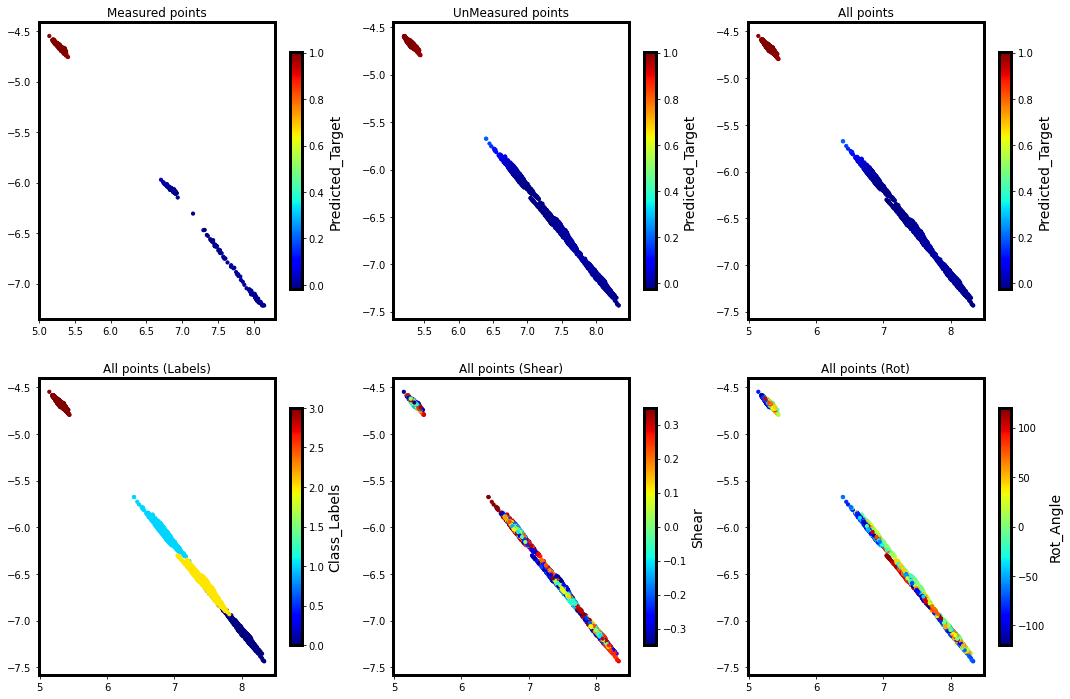

In [35]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train3[:, 1], embeded_train3[:, 0], s=10, c = predmean_train3, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured3[:, 1], embeded_unmeasured3[:, 0], s=10,
                c = predmean_unmeas3, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = predmean13, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Case-4
Target Function: 0 for clubs, 1 for Spades 2 for hearts and 3 for diamonds

In [36]:
# First we will run the DKL on the whole dataset in one go
X4 = np.copy(X) # Copying the entire input dataset
targets4 = np.copy((labels_all)) # Preparing the targets/outputs

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

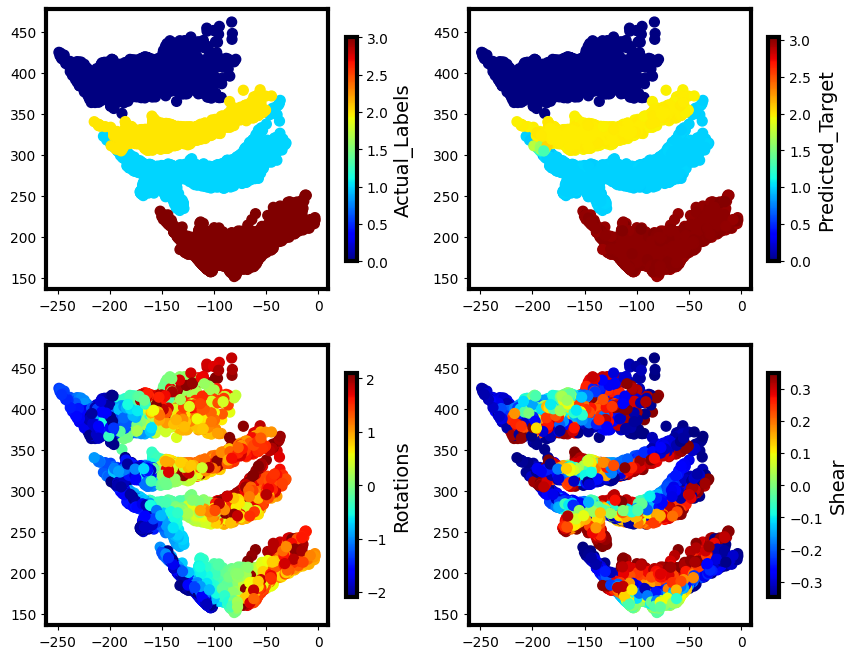

In [ ]:
# Running the DKL on the whole dataset
rng_key_4, rng_key_predict_4 = gpax.utils.get_keys()
dkl_4 = gpax.viDKL(900, 2, 'RBF')
dkl_4.fit(rng_key_4, X, targets4)

# Latent space Embedding and prediction on the whole input dataset
embeded_4 = dkl_4.embed(X)
pred_mean4, pred_var4 = dkl_4.predict_in_batches(rng_key_predict_4, X, batch_size=250)
pred_std4 = jnp.sqrt(pred_var4)

# Visualization of latent space distributions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = pred_mean4, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO
np.random.seed(0)
idx4 = np.random.choice(np.arange(len(X4)), size = 100, replace = False)
X4_train = X4[idx4]
X4_unmeasured = np.delete(X4, idx4, axis=0)

indices_total_4 = np.arange(len(X))
indices_train_4 = indices_total_4[idx4]
y4_train = targets4[idx4]
indices_unmeasured_4 = np.delete(indices_total_4, idx4)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean4, exp_std4 = [], []
dkl_mean4, dkl_std4 = [], []
embed_traj4 = []
traj_mean4, traj_std4 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key14, rng_key_predict14 = gpax.utils.get_keys()
    dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_4.fit(rng_key14, X4_train, y4_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean4.append(y_mean[id_next])
    exp_std4.append(y_std[id_next])
    
    x_next = X4_unmeasured[id_next]
    ind_next = indices_unmeasured_4[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean4.append(pred_mean4[ind_next])
    dkl_std4.append(pred_std4[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets4[ind_next]
    
    # Update training arrays
    X4_train = np.append(X4_train, x_next[None], axis=0)
    y4_train = np.append(y4_train, y_measured)
    X4_unmeasured = np.delete(X4_unmeasured, id_next, axis=0)
    indices_unmeasured_4 = np.delete(indices_unmeasured_4, id_next)
    
    embed_traj = dkl_BO_4.embed(X4_train)
    traj_m, traj_s = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_train, batch_size=100)
    
    embed_traj4.append(embed_traj)
    traj_mean4.append(traj_m)

# Saving the results
allsuites_results = {}
allsuites_results['X_train'] = X4_train
allsuites_results['y_train'] = y4_train
allsuites_results['X_unmeasured'] = X4_unmeasured
allsuites_results['indices_unmeasured'] = indices_unmeasured_4
allsuites_results['dkl_mean'] = dkl_mean4
allsuites_results['dkl_std'] = dkl_std4
allsuites_results['exp_mean'] = exp_mean4
allsuites_results['exp_std'] = exp_std4
allsuites_results['traj_mean'] = traj_mean4
allsuites_results['traj_std'] = traj_std4
allsuites_results['embed_traj'] = embed_traj4

with open('allsuites_results.pickle', 'wb') as handle:
    pickle.dump(allsuites_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:04<00:00, 248.71it/s, init loss: 60264.7827, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6597 1.6565]
k_scale          1.5583
noise            0.0091

Step 2


100%|█| 1000/1000 [00:02<00:00, 367.89it/s, init loss: 60268.4297, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4787 2.1998]
k_scale          1.31
noise            0.010700000000000001

Step 3


100%|█| 1000/1000 [00:02<00:00, 371.21it/s, init loss: 60271.7814, avg. loss [95



Inferred GP kernel parameters
k_length         [3.125  2.3134]
k_scale          1.3665
noise            0.0115

Step 4


100%|█| 1000/1000 [00:02<00:00, 374.04it/s, init loss: 60273.0256, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9942 3.704 ]
k_scale          1.2019
noise            0.0103

Step 5


100%|█| 1000/1000 [00:02<00:00, 372.74it/s, init loss: 60275.9621, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4285 2.1221]
k_scale          1.1818
noise            0.0094

Step 6


100%|█| 1000/1000 [00:02<00:00, 366.44it/s, init loss: 60279.5537, avg. loss [95



Inferred GP kernel parameters
k_length         [3.02   2.0921]
k_scale          1.2002000000000002
noise            0.0089

Step 7


100%|█| 1000/1000 [00:02<00:00, 375.25it/s, init loss: 60281.1751, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7477 2.7019]
k_scale          1.1658
noise            0.013000000000000001

Step 8


100%|█| 1000/1000 [00:02<00:00, 355.06it/s, init loss: 60283.0990, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5184 3.2524]
k_scale          1.2590000000000001
noise            0.0099

Step 9


100%|█| 1000/1000 [00:02<00:00, 362.86it/s, init loss: 60285.6987, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5106 2.8243]
k_scale          1.2149
noise            0.0105

Step 10


100%|█| 1000/1000 [00:02<00:00, 367.66it/s, init loss: 60288.9300, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3389 3.5724]
k_scale          1.2283000000000002
noise            0.011300000000000001

Step 11


100%|█| 1000/1000 [00:02<00:00, 368.08it/s, init loss: 60291.6661, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4124 1.9164]
k_scale          1.4492
noise            0.0098

Step 12


100%|█| 1000/1000 [00:02<00:00, 367.53it/s, init loss: 60292.9104, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9616 2.8   ]
k_scale          1.1752
noise            0.011600000000000001

Step 13


100%|█| 1000/1000 [00:02<00:00, 366.67it/s, init loss: 60294.2679, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0279 3.6688]
k_scale          1.3404
noise            0.0106

Step 14


100%|█| 1000/1000 [00:03<00:00, 277.53it/s, init loss: 60297.7911, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0632 4.3837]
k_scale          1.2281
noise            0.010400000000000001

Step 15


100%|█| 1000/1000 [00:02<00:00, 359.31it/s, init loss: 60299.7412, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2766 2.7355]
k_scale          1.2348000000000001
noise            0.01

Step 16


100%|█| 1000/1000 [00:02<00:00, 364.44it/s, init loss: 60303.4950, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6599 2.1866]
k_scale          1.2123000000000002
noise            0.0102

Step 17


100%|█| 1000/1000 [00:02<00:00, 368.11it/s, init loss: 60305.7820, avg. loss [95



Inferred GP kernel parameters
k_length         [2.401  3.3884]
k_scale          1.286
noise            0.01

Step 18


100%|█| 1000/1000 [00:02<00:00, 372.53it/s, init loss: 60309.0416, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4335 2.6438]
k_scale          1.2655
noise            0.009600000000000001

Step 19


100%|█| 1000/1000 [00:02<00:00, 372.90it/s, init loss: 60312.3469, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2712 4.3027]
k_scale          1.4732
noise            0.0148

Step 20


100%|█| 1000/1000 [00:02<00:00, 375.83it/s, init loss: 60315.3512, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4285 3.1165]
k_scale          1.2799
noise            0.0119

Step 21


100%|█| 1000/1000 [00:02<00:00, 350.82it/s, init loss: 60316.6048, avg. loss [95



Inferred GP kernel parameters
k_length         [2.337  1.8312]
k_scale          1.2408000000000001
noise            0.0108

Step 22


100%|█| 1000/1000 [00:02<00:00, 362.95it/s, init loss: 60320.1724, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9413 5.1326]
k_scale          1.1682000000000001
noise            0.0111

Step 23


100%|█| 1000/1000 [00:02<00:00, 366.96it/s, init loss: 60323.7534, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1973 2.8486]
k_scale          1.2231
noise            0.011600000000000001

Step 24


100%|█| 1000/1000 [00:02<00:00, 365.78it/s, init loss: 60326.8370, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4117 3.231 ]
k_scale          1.1520000000000001
noise            0.0112

Step 25


100%|█| 1000/1000 [00:02<00:00, 364.36it/s, init loss: 60329.1766, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8591 2.3014]
k_scale          1.3295000000000001
noise            0.0092

Step 26


100%|█| 1000/1000 [00:02<00:00, 367.78it/s, init loss: 60332.7641, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1183 1.9199]
k_scale          1.1889
noise            0.010100000000000001

Step 27


100%|█| 1000/1000 [00:03<00:00, 297.45it/s, init loss: 60335.5583, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0161 2.3396]
k_scale          1.3243
noise            0.0092

Step 28


100%|█| 1000/1000 [00:02<00:00, 355.74it/s, init loss: 60338.8687, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0163 1.5663]
k_scale          1.5877000000000001
noise            0.0103

Step 29


100%|█| 1000/1000 [00:02<00:00, 360.87it/s, init loss: 60340.8273, avg. loss [95



Inferred GP kernel parameters
k_length         [7.0006 3.3974]
k_scale          1.1681000000000001
noise            0.0115

Step 30


100%|█| 1000/1000 [00:02<00:00, 357.23it/s, init loss: 60342.7385, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1821 3.9299]
k_scale          1.296
noise            0.012700000000000001

Step 31


100%|█| 1000/1000 [00:02<00:00, 359.22it/s, init loss: 60345.1315, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9524 3.3596]
k_scale          1.2188
noise            0.010400000000000001

Step 32


100%|█| 1000/1000 [00:02<00:00, 361.66it/s, init loss: 60348.3067, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8373 2.0738]
k_scale          1.3449
noise            0.0089

Step 33


100%|█| 1000/1000 [00:02<00:00, 365.85it/s, init loss: 60351.5375, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0598 2.4968]
k_scale          1.3041
noise            0.011300000000000001

Step 34


100%|█| 1000/1000 [00:04<00:00, 239.14it/s, init loss: 60353.0912, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3895 3.0663]
k_scale          1.2791000000000001
noise            0.008700000000000001

Step 35


100%|█| 1000/1000 [00:02<00:00, 356.03it/s, init loss: 60355.5812, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4162 3.4996]
k_scale          1.2245000000000001
noise            0.0106

Step 36


100%|█| 1000/1000 [00:02<00:00, 361.84it/s, init loss: 60358.2810, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7155 1.9532]
k_scale          1.3296000000000001
noise            0.013600000000000001

Step 37


100%|█| 1000/1000 [00:02<00:00, 360.72it/s, init loss: 60359.5167, avg. loss [95



Inferred GP kernel parameters
k_length         [7.8434 3.4615]
k_scale          1.1979
noise            0.0128

Step 38


100%|█| 1000/1000 [00:02<00:00, 368.09it/s, init loss: 60361.7546, avg. loss [95



Inferred GP kernel parameters
k_length         [4.11   3.7975]
k_scale          1.1796
noise            0.0111

Step 39


100%|█| 1000/1000 [00:02<00:00, 369.58it/s, init loss: 60365.3249, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4295 3.6954]
k_scale          1.2005000000000001
noise            0.010700000000000001

Step 40


100%|█| 1000/1000 [00:02<00:00, 370.73it/s, init loss: 60367.2057, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0198 2.7782]
k_scale          1.4020000000000001
noise            0.0102

Step 41


100%|█| 1000/1000 [00:02<00:00, 355.61it/s, init loss: 60368.4534, avg. loss [95



Inferred GP kernel parameters
k_length         [5.011 4.456]
k_scale          1.1488
noise            0.013300000000000001

Step 42


100%|█| 1000/1000 [00:02<00:00, 360.68it/s, init loss: 60369.9049, avg. loss [95



Inferred GP kernel parameters
k_length         [4.258  3.3853]
k_scale          1.2877
noise            0.0123

Step 43


100%|█| 1000/1000 [00:02<00:00, 363.87it/s, init loss: 60371.4473, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4117 2.76  ]
k_scale          1.3588
noise            0.0098

Step 44


100%|█| 1000/1000 [00:02<00:00, 363.39it/s, init loss: 60372.7176, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2506 1.7083]
k_scale          1.3562
noise            0.0142

Step 45


100%|█| 1000/1000 [00:02<00:00, 365.57it/s, init loss: 60375.0745, avg. loss [95



Inferred GP kernel parameters
k_length         [10.5982  6.8433]
k_scale          1.2174
noise            0.0126

Step 46


100%|█| 1000/1000 [00:02<00:00, 364.04it/s, init loss: 60378.3545, avg. loss [95



Inferred GP kernel parameters
k_length         [5.7211 2.6776]
k_scale          1.1736
noise            0.0111

Step 47


100%|█| 1000/1000 [00:02<00:00, 350.60it/s, init loss: 60380.7339, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6988 5.2617]
k_scale          1.2172
noise            0.0135

Step 48


100%|█| 1000/1000 [00:02<00:00, 359.38it/s, init loss: 60383.1777, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6973 5.1744]
k_scale          1.2089
noise            0.0112

Step 49


100%|█| 1000/1000 [00:02<00:00, 361.37it/s, init loss: 60385.2834, avg. loss [95



Inferred GP kernel parameters
k_length         [3.619  4.6124]
k_scale          1.2025000000000001
noise            0.0129

Step 50


100%|█| 1000/1000 [00:02<00:00, 365.48it/s, init loss: 60388.4017, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7989 2.9501]
k_scale          1.4813
noise            0.0097

Step 51


100%|█| 1000/1000 [00:02<00:00, 347.33it/s, init loss: 60390.9071, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0037 3.2634]
k_scale          1.3646
noise            0.010700000000000001

Step 52


100%|█| 1000/1000 [00:02<00:00, 352.30it/s, init loss: 60392.1382, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4791 3.2102]
k_scale          1.2782
noise            0.0123

Step 53


100%|█| 1000/1000 [00:02<00:00, 353.75it/s, init loss: 60394.9579, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0419 5.7691]
k_scale          1.2088
noise            0.015000000000000001

Step 54


100%|█| 1000/1000 [00:02<00:00, 338.82it/s, init loss: 60396.9015, avg. loss [95



Inferred GP kernel parameters
k_length         [8.8061 3.9308]
k_scale          1.1886
noise            0.011000000000000001

Step 55


100%|█| 1000/1000 [00:02<00:00, 346.05it/s, init loss: 60398.5303, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3637 3.0714]
k_scale          1.3616000000000001
noise            0.0108

Step 56


100%|█| 1000/1000 [00:02<00:00, 347.99it/s, init loss: 60400.8266, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6318 3.6421]
k_scale          1.2585
noise            0.0111

Step 57


100%|█| 1000/1000 [00:02<00:00, 354.12it/s, init loss: 60403.6936, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3169 5.5572]
k_scale          1.2556
noise            0.0105

Step 58


100%|█| 1000/1000 [00:02<00:00, 361.64it/s, init loss: 60405.2084, avg. loss [95



Inferred GP kernel parameters
k_length         [8.147  2.3735]
k_scale          1.2536
noise            0.010100000000000001

Step 59


100%|█| 1000/1000 [00:02<00:00, 360.55it/s, init loss: 60407.5697, avg. loss [95



Inferred GP kernel parameters
k_length         [4.581  7.7036]
k_scale          1.2243000000000002
noise            0.015000000000000001

Step 60


100%|█| 1000/1000 [00:02<00:00, 344.25it/s, init loss: 60410.7523, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5225 3.9917]
k_scale          1.223
noise            0.0099

Step 61


100%|█| 1000/1000 [00:02<00:00, 359.47it/s, init loss: 60414.3206, avg. loss [95



Inferred GP kernel parameters
k_length         [9.2541 3.7549]
k_scale          1.1899
noise            0.0097

Step 62


100%|█| 1000/1000 [00:02<00:00, 356.17it/s, init loss: 60416.3525, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4909 4.5703]
k_scale          1.2067
noise            0.012400000000000001

Step 63


100%|█| 1000/1000 [00:02<00:00, 360.51it/s, init loss: 60419.2411, avg. loss [95



Inferred GP kernel parameters
k_length         [5.6714 3.2469]
k_scale          1.2353
noise            0.0099

Step 64


100%|█| 1000/1000 [00:02<00:00, 363.02it/s, init loss: 60420.9150, avg. loss [95



Inferred GP kernel parameters
k_length         [6.5124 4.7714]
k_scale          1.1626
noise            0.0108

Step 65


100%|█| 1000/1000 [00:02<00:00, 363.34it/s, init loss: 60423.5541, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2896 3.1695]
k_scale          1.312
noise            0.013300000000000001

Step 66


100%|█| 1000/1000 [00:02<00:00, 363.58it/s, init loss: 60426.3618, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2007 2.726 ]
k_scale          1.7193
noise            0.0122

Step 67


100%|█| 1000/1000 [00:02<00:00, 350.92it/s, init loss: 60428.1602, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5394 7.1705]
k_scale          1.1638
noise            0.0122

Step 68


100%|█| 1000/1000 [00:02<00:00, 355.95it/s, init loss: 60430.5873, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3894 5.5919]
k_scale          1.2586000000000002
noise            0.013600000000000001

Step 69


100%|█| 1000/1000 [00:02<00:00, 358.45it/s, init loss: 60432.9328, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8051 4.0987]
k_scale          1.2024000000000001
noise            0.0111

Step 70


100%|█| 1000/1000 [00:02<00:00, 361.08it/s, init loss: 60435.2224, avg. loss [95



Inferred GP kernel parameters
k_length         [7.4889 3.7758]
k_scale          1.2770000000000001
noise            0.010400000000000001

Step 71


100%|█| 1000/1000 [00:02<00:00, 359.14it/s, init loss: 60438.3301, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1336 4.5991]
k_scale          1.2404000000000002
noise            0.0098

Step 72


100%|█| 1000/1000 [00:02<00:00, 361.45it/s, init loss: 60440.1293, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5501 4.8681]
k_scale          1.3544
noise            0.012

Step 73


100%|█| 1000/1000 [00:03<00:00, 274.10it/s, init loss: 60443.2582, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5749 1.7393]
k_scale          1.3949
noise            0.0118

Step 74


100%|█| 1000/1000 [00:02<00:00, 352.67it/s, init loss: 60444.5803, avg. loss [95



Inferred GP kernel parameters
k_length         [6.7656 4.4957]
k_scale          1.2387000000000001
noise            0.0112

Step 75


100%|█| 1000/1000 [00:02<00:00, 354.46it/s, init loss: 60446.2273, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7016 3.3385]
k_scale          1.2361
noise            0.010700000000000001

Step 76


100%|█| 1000/1000 [00:02<00:00, 358.92it/s, init loss: 60448.7345, avg. loss [95



Inferred GP kernel parameters
k_length         [2.671  2.1965]
k_scale          1.5209000000000001
noise            0.0094

Step 77


100%|█| 1000/1000 [00:02<00:00, 360.93it/s, init loss: 60451.5699, avg. loss [95



Inferred GP kernel parameters
k_length         [5.1115 3.0745]
k_scale          1.3588
noise            0.010100000000000001

Step 78


100%|█| 1000/1000 [00:02<00:00, 357.35it/s, init loss: 60452.7636, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6148 2.4116]
k_scale          1.5339
noise            0.012400000000000001

Step 79


100%|█| 1000/1000 [00:03<00:00, 271.24it/s, init loss: 60454.0145, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9492 2.1207]
k_scale          1.4087
noise            0.0132

Step 80


100%|█| 1000/1000 [00:02<00:00, 348.50it/s, init loss: 60456.8637, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4217 2.5902]
k_scale          1.3283
noise            0.0092

Step 81


100%|█| 1000/1000 [00:02<00:00, 351.89it/s, init loss: 60458.6304, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3733 2.476 ]
k_scale          1.3566
noise            0.009300000000000001

Step 82


100%|█| 1000/1000 [00:02<00:00, 354.85it/s, init loss: 60459.9433, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4886 1.9813]
k_scale          2.2776
noise            0.0122

Step 83


100%|█| 1000/1000 [00:02<00:00, 356.84it/s, init loss: 60461.2196, avg. loss [95



Inferred GP kernel parameters
k_length         [7.4703 4.7834]
k_scale          1.1562000000000001
noise            0.010700000000000001

Step 84


100%|█| 1000/1000 [00:02<00:00, 358.96it/s, init loss: 60463.2135, avg. loss [95



Inferred GP kernel parameters
k_length         [4.575  5.7402]
k_scale          1.268
noise            0.0115

Step 85


100%|█| 1000/1000 [00:02<00:00, 358.56it/s, init loss: 60465.2908, avg. loss [95



Inferred GP kernel parameters
k_length         [4.766  3.4188]
k_scale          1.3855000000000002
noise            0.014

Step 86


100%|█| 1000/1000 [00:02<00:00, 338.92it/s, init loss: 60466.7959, avg. loss [95



Inferred GP kernel parameters
k_length         [5.245  2.0334]
k_scale          1.2597
noise            0.0103

Step 87


100%|█| 1000/1000 [00:02<00:00, 348.01it/s, init loss: 60468.6151, avg. loss [95



Inferred GP kernel parameters
k_length         [7.6797 3.922 ]
k_scale          1.1989
noise            0.0119

Step 88


100%|█| 1000/1000 [00:02<00:00, 353.20it/s, init loss: 60471.7417, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9582 2.8747]
k_scale          1.2889000000000002
noise            0.009300000000000001

Step 89


100%|█| 1000/1000 [00:02<00:00, 354.16it/s, init loss: 60473.4029, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4952 2.3604]
k_scale          1.2947
noise            0.0111

Step 90


100%|█| 1000/1000 [00:02<00:00, 358.38it/s, init loss: 60476.9948, avg. loss [95



Inferred GP kernel parameters
k_length         [6.0634 3.2876]
k_scale          1.1877
noise            0.011000000000000001

Step 91


100%|█| 1000/1000 [00:02<00:00, 356.91it/s, init loss: 60479.0191, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9362 6.9449]
k_scale          1.1733
noise            0.0126

Step 92


100%|█| 1000/1000 [00:03<00:00, 268.19it/s, init loss: 60482.2956, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0887 2.9637]
k_scale          1.3215000000000001
noise            0.013600000000000001

Step 93


100%|█| 1000/1000 [00:02<00:00, 347.56it/s, init loss: 60485.5572, avg. loss [95



Inferred GP kernel parameters
k_length         [5.7491 3.0966]
k_scale          1.3102
noise            0.0128

Step 94


100%|█| 1000/1000 [00:02<00:00, 348.33it/s, init loss: 60488.7847, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7769 2.8748]
k_scale          1.3456000000000001
noise            0.012400000000000001

Step 95


100%|█| 1000/1000 [00:02<00:00, 353.39it/s, init loss: 60489.9768, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4882 3.1177]
k_scale          1.5090000000000001
noise            0.011300000000000001

Step 96


100%|█| 1000/1000 [00:02<00:00, 357.38it/s, init loss: 60492.0369, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3917 3.6807]
k_scale          1.2909000000000002
noise            0.013000000000000001

Step 97


100%|█| 1000/1000 [00:02<00:00, 357.03it/s, init loss: 60494.9077, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8728 5.7495]
k_scale          1.2551
noise            0.0122

Step 98


100%|█| 1000/1000 [00:02<00:00, 359.36it/s, init loss: 60496.1520, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2503 1.9589]
k_scale          1.4482000000000002
noise            0.0086

Step 99


100%|█| 1000/1000 [00:02<00:00, 337.62it/s, init loss: 60497.8600, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2303 2.6361]
k_scale          1.2997
noise            0.0117

Step 100


100%|█| 1000/1000 [00:02<00:00, 345.72it/s, init loss: 60499.2743, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0376 3.1248]
k_scale          1.2409000000000001
noise            0.0128

Step 101


100%|█| 1000/1000 [00:02<00:00, 351.99it/s, init loss: 60501.8882, avg. loss [95



Inferred GP kernel parameters
k_length         [6.5229 2.0205]
k_scale          1.6618000000000002
noise            0.011600000000000001

Step 102


100%|█| 1000/1000 [00:02<00:00, 353.80it/s, init loss: 60503.3881, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9344 2.3375]
k_scale          1.2522
noise            0.01

Step 103


100%|█| 1000/1000 [00:02<00:00, 355.70it/s, init loss: 60506.8117, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2887 3.1197]
k_scale          2.5089
noise            0.017

Step 104


100%|█| 1000/1000 [00:02<00:00, 358.83it/s, init loss: 60507.9833, avg. loss [95



Inferred GP kernel parameters
k_length         [5.6022 4.375 ]
k_scale          1.1883000000000001
noise            0.0108

Step 105


100%|█| 1000/1000 [00:03<00:00, 268.08it/s, init loss: 60509.3399, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8378 2.4602]
k_scale          1.7091
noise            0.0142

Step 106


100%|█| 1000/1000 [00:02<00:00, 348.17it/s, init loss: 60511.5717, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5396 5.2571]
k_scale          1.1738
noise            0.011300000000000001

Step 107


100%|█| 1000/1000 [00:02<00:00, 350.84it/s, init loss: 60515.1218, avg. loss [95



Inferred GP kernel parameters
k_length         [4.573  4.0776]
k_scale          1.2551
noise            0.0102

Step 108


100%|█| 1000/1000 [00:02<00:00, 355.54it/s, init loss: 60518.8377, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1211 1.8887]
k_scale          1.3352000000000002
noise            0.0098

Step 109


100%|█| 1000/1000 [00:02<00:00, 356.90it/s, init loss: 60522.4320, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6399 2.578 ]
k_scale          1.3852
noise            0.0118

Step 110


100%|█| 1000/1000 [00:02<00:00, 359.08it/s, init loss: 60523.6763, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6194 3.8262]
k_scale          1.2394
noise            0.010100000000000001

Step 111


100%|█| 1000/1000 [00:02<00:00, 359.88it/s, init loss: 60525.8819, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8254 4.6178]
k_scale          1.2047
noise            0.0092

Step 112


100%|█| 1000/1000 [00:03<00:00, 268.20it/s, init loss: 60527.9669, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7897 2.001 ]
k_scale          1.7866000000000002
noise            0.0149

Step 113


100%|█| 1000/1000 [00:02<00:00, 345.13it/s, init loss: 60529.2193, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0985 3.3455]
k_scale          1.3004
noise            0.0119

Step 114


100%|█| 1000/1000 [00:02<00:00, 347.08it/s, init loss: 60531.5244, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0066 3.9242]
k_scale          1.4648
noise            0.014100000000000001

Step 115


100%|█| 1000/1000 [00:02<00:00, 351.85it/s, init loss: 60533.3163, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7335 2.1809]
k_scale          1.3064
noise            0.0128

Step 116


100%|█| 1000/1000 [00:02<00:00, 354.11it/s, init loss: 60534.9270, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0113 2.1429]
k_scale          1.6641000000000001
noise            0.0135

Step 117


100%|█| 1000/1000 [00:02<00:00, 359.21it/s, init loss: 60537.5171, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4586 2.8587]
k_scale          2.2389
noise            0.012100000000000001

Step 118


100%|█| 1000/1000 [00:02<00:00, 357.24it/s, init loss: 60538.7618, avg. loss [95



Inferred GP kernel parameters
k_length         [5.7514 4.7189]
k_scale          1.2461
noise            0.0123

Step 119


100%|█| 1000/1000 [00:02<00:00, 335.85it/s, init loss: 60540.1032, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7805 3.2189]
k_scale          1.3004
noise            0.010400000000000001

Step 120


100%|█| 1000/1000 [00:02<00:00, 343.23it/s, init loss: 60541.4348, avg. loss [95



Inferred GP kernel parameters
k_length         [3.973  2.6965]
k_scale          1.4043
noise            0.0114

Step 121


100%|█| 1000/1000 [00:02<00:00, 349.61it/s, init loss: 60542.6656, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1939 3.2636]
k_scale          1.4654
noise            0.014400000000000001

Step 122


100%|█| 1000/1000 [00:02<00:00, 351.07it/s, init loss: 60544.2475, avg. loss [95



Inferred GP kernel parameters
k_length         [5.8813 4.1671]
k_scale          1.2630000000000001
noise            0.0111

Step 123


100%|█| 1000/1000 [00:02<00:00, 356.13it/s, init loss: 60547.3154, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6994 2.6913]
k_scale          1.5446
noise            0.013900000000000001

Step 124


100%|█| 1000/1000 [00:02<00:00, 356.96it/s, init loss: 60548.7813, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1654 2.547 ]
k_scale          1.3701
noise            0.0094

Step 125


100%|█| 1000/1000 [00:03<00:00, 265.80it/s, init loss: 60551.2414, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4239 2.2981]
k_scale          1.2993000000000001
noise            0.009600000000000001

Step 126


100%|█| 1000/1000 [00:02<00:00, 347.37it/s, init loss: 60553.5376, avg. loss [95



Inferred GP kernel parameters
k_length         [3.293  1.9093]
k_scale          1.3983
noise            0.0106

Step 127


100%|█| 1000/1000 [00:02<00:00, 351.06it/s, init loss: 60556.7310, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7517 2.3072]
k_scale          1.5811000000000002
noise            0.0132

Step 128


100%|█| 1000/1000 [00:02<00:00, 353.23it/s, init loss: 60560.1320, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6295 3.0813]
k_scale          1.5069000000000001
noise            0.0119

Step 129


100%|█| 1000/1000 [00:02<00:00, 355.90it/s, init loss: 60561.3580, avg. loss [95



Inferred GP kernel parameters
k_length         [15.1673  5.1894]
k_scale          1.1798
noise            0.0118

Step 130


100%|█| 1000/1000 [00:02<00:00, 359.72it/s, init loss: 60564.7191, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3674 2.5377]
k_scale          1.2476
noise            0.0119

Step 131


100%|█| 1000/1000 [00:02<00:00, 361.85it/s, init loss: 60567.3013, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8739 2.2741]
k_scale          1.491
noise            0.0103

Step 132


100%|█| 1000/1000 [00:02<00:00, 338.07it/s, init loss: 60569.6213, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7053 2.4731]
k_scale          1.5311000000000001
noise            0.012100000000000001

Step 133


100%|█| 1000/1000 [00:02<00:00, 345.54it/s, init loss: 60571.1705, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7056 2.8452]
k_scale          1.2889000000000002
noise            0.0117

Step 134


100%|█| 1000/1000 [00:02<00:00, 347.80it/s, init loss: 60572.6328, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0359 4.078 ]
k_scale          1.5461
noise            0.0094

Step 135


100%|█| 1000/1000 [00:02<00:00, 352.53it/s, init loss: 60573.8364, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2485 3.9993]
k_scale          1.2677
noise            0.013000000000000001

Step 136


100%|█| 1000/1000 [00:02<00:00, 355.57it/s, init loss: 60575.1939, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6393 2.0963]
k_scale          1.4361000000000002
noise            0.0123

Step 137


100%|█| 1000/1000 [00:02<00:00, 356.69it/s, init loss: 60576.4390, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4397 3.3766]
k_scale          1.465
noise            0.0132

Step 138


100%|█| 1000/1000 [00:03<00:00, 267.25it/s, init loss: 60577.6585, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6485 2.898 ]
k_scale          1.2984
noise            0.012

Step 139


100%|█| 1000/1000 [00:02<00:00, 345.51it/s, init loss: 60579.9941, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8602 2.3341]
k_scale          1.3760000000000001
noise            0.0131

Step 140


100%|█| 1000/1000 [00:02<00:00, 350.86it/s, init loss: 60582.5169, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5476 5.0978]
k_scale          1.1873
noise            0.012400000000000001

Step 141


100%|█| 1000/1000 [00:02<00:00, 355.61it/s, init loss: 60584.3985, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3126 3.1801]
k_scale          1.2742
noise            0.0103

Step 142


100%|█| 1000/1000 [00:02<00:00, 354.59it/s, init loss: 60586.5414, avg. loss [95



Inferred GP kernel parameters
k_length         [7.3663 3.4442]
k_scale          1.1453
noise            0.011000000000000001

Step 143


100%|█| 1000/1000 [00:02<00:00, 357.34it/s, init loss: 60589.0945, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2359 5.196 ]
k_scale          1.1882000000000001
noise            0.012100000000000001

Step 144


100%|█| 1000/1000 [00:02<00:00, 360.80it/s, init loss: 60591.6777, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6299 2.778 ]
k_scale          1.1716
noise            0.0098

Step 145


100%|█| 1000/1000 [00:03<00:00, 321.42it/s, init loss: 60593.5931, avg. loss [95



Inferred GP kernel parameters
k_length         [5.563  2.6204]
k_scale          1.2138
noise            0.0125

Step 146


100%|█| 1000/1000 [00:02<00:00, 333.48it/s, init loss: 60594.9188, avg. loss [95



Inferred GP kernel parameters
k_length         [5.8811 2.5415]
k_scale          1.2211
noise            0.012

Step 147


100%|█| 1000/1000 [00:02<00:00, 347.94it/s, init loss: 60596.4701, avg. loss [95



Inferred GP kernel parameters
k_length         [2.92   3.4282]
k_scale          1.4611
noise            0.0119

Step 148


100%|█| 1000/1000 [00:02<00:00, 347.67it/s, init loss: 60597.8202, avg. loss [95



Inferred GP kernel parameters
k_length         [7.768  3.8528]
k_scale          1.1679000000000002
noise            0.0105

Step 149


100%|█| 1000/1000 [00:02<00:00, 353.73it/s, init loss: 60600.1458, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0258 2.5863]
k_scale          1.7971000000000001
noise            0.0152

Step 150


100%|█| 1000/1000 [00:02<00:00, 355.55it/s, init loss: 60601.3901, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9623 2.4524]
k_scale          1.54
noise            0.0111

Step 151


100%|█| 1000/1000 [00:03<00:00, 270.50it/s, init loss: 60602.6344, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9202 4.4077]
k_scale          1.3703
noise            0.0129

Step 152


100%|█| 1000/1000 [00:02<00:00, 342.03it/s, init loss: 60604.5742, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6423 1.9703]
k_scale          2.4943
noise            0.0253

Step 153


100%|█| 1000/1000 [00:02<00:00, 349.06it/s, init loss: 60605.8003, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9544 2.7888]
k_scale          1.5703
noise            0.0146

Step 154


100%|█| 1000/1000 [00:02<00:00, 348.81it/s, init loss: 60607.1274, avg. loss [95



Inferred GP kernel parameters
k_length         [7.0331 2.7483]
k_scale          1.5110000000000001
noise            0.0117

Step 155


100%|█| 1000/1000 [00:02<00:00, 352.24it/s, init loss: 60608.2994, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2421 2.7599]
k_scale          1.3848
noise            0.0119

Step 156


100%|█| 1000/1000 [00:02<00:00, 355.99it/s, init loss: 60610.9029, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2632 2.8886]
k_scale          1.4147
noise            0.0126

Step 157


100%|█| 1000/1000 [00:02<00:00, 357.85it/s, init loss: 60612.6162, avg. loss [95



Inferred GP kernel parameters
k_length         [3.303  2.8283]
k_scale          1.2819
noise            0.012700000000000001

Step 158


100%|█| 1000/1000 [00:03<00:00, 329.61it/s, init loss: 60615.0954, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3468 3.1284]
k_scale          1.2847
noise            0.013900000000000001

Step 159


100%|█| 1000/1000 [00:02<00:00, 336.29it/s, init loss: 60616.6473, avg. loss [95



Inferred GP kernel parameters
k_length         [8.7414 3.7535]
k_scale          1.1992
noise            0.0111

Step 160


100%|█| 1000/1000 [00:02<00:00, 344.71it/s, init loss: 60618.1560, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8938 1.9726]
k_scale          1.3365
noise            0.014

Step 161


100%|█| 1000/1000 [00:02<00:00, 334.56it/s, init loss: 60620.3556, avg. loss [95



Inferred GP kernel parameters
k_length         [4.835  4.0932]
k_scale          1.1737
noise            0.0132

Step 162


100%|█| 1000/1000 [00:02<00:00, 340.87it/s, init loss: 60622.0710, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0729 2.5688]
k_scale          1.5614000000000001
noise            0.0164

Step 163


100%|█| 1000/1000 [00:02<00:00, 345.32it/s, init loss: 60624.1543, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1246 2.2535]
k_scale          1.3354000000000001
noise            0.012

Step 164


100%|█| 1000/1000 [00:04<00:00, 231.87it/s, init loss: 60625.9560, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8466 2.7193]
k_scale          1.2241
noise            0.0098

Step 165


100%|█| 1000/1000 [00:03<00:00, 325.25it/s, init loss: 60628.2393, avg. loss [95



Inferred GP kernel parameters
k_length         [6.4567 3.0228]
k_scale          1.6545
noise            0.0149

Step 166


100%|█| 1000/1000 [00:02<00:00, 334.72it/s, init loss: 60629.5722, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2145 2.1994]
k_scale          1.4758
noise            0.009000000000000001

Step 167


100%|█| 1000/1000 [00:02<00:00, 337.14it/s, init loss: 60630.9692, avg. loss [95



Inferred GP kernel parameters
k_length         [6.0521 7.5903]
k_scale          1.1566
noise            0.013600000000000001

Step 168


100%|█| 1000/1000 [00:02<00:00, 342.78it/s, init loss: 60633.3951, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0428 2.4325]
k_scale          1.3472000000000002
noise            0.0108

Step 169


100%|█| 1000/1000 [00:02<00:00, 353.44it/s, init loss: 60634.7094, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4157 1.958 ]
k_scale          1.3844
noise            0.0134

Step 170


100%|█| 1000/1000 [00:02<00:00, 358.01it/s, init loss: 60635.9112, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8601 1.6673]
k_scale          1.3668
noise            0.010100000000000001

Step 171


100%|█| 1000/1000 [00:03<00:00, 268.57it/s, init loss: 60637.1097, avg. loss [95



Inferred GP kernel parameters
k_length         [6.2864 3.7911]
k_scale          1.1580000000000001
noise            0.010100000000000001

Step 172


100%|█| 1000/1000 [00:02<00:00, 339.84it/s, init loss: 60640.7051, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3163 2.341 ]
k_scale          1.3773
noise            0.013000000000000001

Step 173


100%|█| 1000/1000 [00:02<00:00, 345.38it/s, init loss: 60642.7378, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8924 2.1026]
k_scale          2.2190000000000003
noise            0.0117

Step 174


100%|█| 1000/1000 [00:02<00:00, 342.93it/s, init loss: 60644.7780, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2024 2.2597]
k_scale          1.3155000000000001
noise            0.0137

Step 175


100%|█| 1000/1000 [00:02<00:00, 346.04it/s, init loss: 60645.9392, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0466 2.4239]
k_scale          1.3789
noise            0.0149

Step 176


100%|█| 1000/1000 [00:02<00:00, 348.23it/s, init loss: 60647.6925, avg. loss [95



Inferred GP kernel parameters
k_length         [6.9565 3.605 ]
k_scale          1.1998
noise            0.0122

Step 177


100%|█| 1000/1000 [00:02<00:00, 350.94it/s, init loss: 60649.3164, avg. loss [95



Inferred GP kernel parameters
k_length         [5.6583 3.1488]
k_scale          1.3216
noise            0.0151

Step 178


100%|█| 1000/1000 [00:03<00:00, 327.10it/s, init loss: 60650.4601, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6518 1.9861]
k_scale          3.1587
noise            0.0151

Step 179


100%|█| 1000/1000 [00:02<00:00, 334.89it/s, init loss: 60652.2964, avg. loss [95



Inferred GP kernel parameters
k_length         [6.8385 4.9642]
k_scale          1.2353
noise            0.0135

Step 180


100%|█| 1000/1000 [00:02<00:00, 339.66it/s, init loss: 60655.9173, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1154 2.9572]
k_scale          1.8405
noise            0.0126

Step 181


100%|█| 1000/1000 [00:02<00:00, 341.86it/s, init loss: 60659.0282, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9571 4.0719]
k_scale          1.236
noise            0.0117

Step 182


100%|█| 1000/1000 [00:02<00:00, 345.81it/s, init loss: 60661.7375, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6105 2.5959]
k_scale          2.5586
noise            0.0142

Step 183


100%|█| 1000/1000 [00:02<00:00, 347.34it/s, init loss: 60663.3821, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1398 2.5615]
k_scale          1.7289
noise            0.0122

Step 184


100%|█| 1000/1000 [00:03<00:00, 258.53it/s, init loss: 60664.9637, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4265 3.6188]
k_scale          1.4322000000000001
noise            0.014

Step 185


100%|█| 1000/1000 [00:02<00:00, 335.25it/s, init loss: 60666.2095, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5907 2.1207]
k_scale          1.7610000000000001
noise            0.0171

Step 186


100%|█| 1000/1000 [00:02<00:00, 338.39it/s, init loss: 60668.4972, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8301 2.6855]
k_scale          1.3861
noise            0.009000000000000001

Step 187


100%|█| 1000/1000 [00:02<00:00, 341.23it/s, init loss: 60670.1229, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3583 3.6858]
k_scale          1.3496000000000001
noise            0.0112

Step 188


100%|█| 1000/1000 [00:02<00:00, 345.11it/s, init loss: 60672.6401, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8047 2.3634]
k_scale          1.6367
noise            0.014

Step 189


100%|█| 1000/1000 [00:02<00:00, 344.28it/s, init loss: 60674.2009, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4003 3.9446]
k_scale          1.4340000000000002
noise            0.0132

Step 190


100%|█| 1000/1000 [00:02<00:00, 349.31it/s, init loss: 60676.7015, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1586 3.0562]
k_scale          1.5262
noise            0.013000000000000001

Step 191


100%|█| 1000/1000 [00:03<00:00, 323.43it/s, init loss: 60678.2658, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9124 2.5551]
k_scale          1.4484000000000001
noise            0.0162

Step 192


100%|█| 1000/1000 [00:02<00:00, 333.96it/s, init loss: 60679.4476, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6078 2.4732]
k_scale          1.4835
noise            0.013000000000000001

Step 193


100%|█| 1000/1000 [00:02<00:00, 337.33it/s, init loss: 60682.1325, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8955 2.2841]
k_scale          1.3522
noise            0.0115

Step 194


100%|█| 1000/1000 [00:02<00:00, 340.36it/s, init loss: 60685.3450, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7256 3.7519]
k_scale          2.2706
noise            0.0167

Step 195


100%|█| 1000/1000 [00:02<00:00, 341.14it/s, init loss: 60686.8502, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5843 1.5895]
k_scale          3.9169
noise            0.0167

Step 196


100%|█| 1000/1000 [00:02<00:00, 347.34it/s, init loss: 60688.1521, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3923 3.2097]
k_scale          1.6502000000000001
noise            0.013300000000000001

Step 197


100%|█| 1000/1000 [00:03<00:00, 263.38it/s, init loss: 60691.7452, avg. loss [95



Inferred GP kernel parameters
k_length         [3.832  2.3271]
k_scale          2.5648
noise            0.0142

Step 198


100%|█| 1000/1000 [00:03<00:00, 327.40it/s, init loss: 60693.0976, avg. loss [95



Inferred GP kernel parameters
k_length         [5.72   3.3527]
k_scale          1.3190000000000002
noise            0.0114

Step 199


100%|█| 1000/1000 [00:03<00:00, 331.25it/s, init loss: 60694.3745, avg. loss [95



Inferred GP kernel parameters
k_length         [3.966  2.1964]
k_scale          1.2148
noise            0.0134

Step 200


100%|█| 1000/1000 [00:02<00:00, 342.34it/s, init loss: 60696.5322, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4495 2.4759]
k_scale          1.2458
noise            0.0112

Step 201


100%|█| 1000/1000 [00:02<00:00, 344.49it/s, init loss: 60698.5632, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7565 2.4541]
k_scale          1.3861
noise            0.0083

Step 202


100%|█| 1000/1000 [00:02<00:00, 346.94it/s, init loss: 60700.8233, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9669 2.6154]
k_scale          1.5010000000000001
noise            0.0126

Step 203


100%|█| 1000/1000 [00:02<00:00, 349.19it/s, init loss: 60703.3234, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2628 2.5053]
k_scale          1.4877
noise            0.0131

Step 204


100%|█| 1000/1000 [00:03<00:00, 329.39it/s, init loss: 60705.3146, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8921 3.1312]
k_scale          1.2903
noise            0.0108

Step 205


100%|█| 1000/1000 [00:02<00:00, 333.87it/s, init loss: 60706.8687, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5846 2.3735]
k_scale          1.325
noise            0.012700000000000001

Step 206


100%|█| 1000/1000 [00:02<00:00, 337.51it/s, init loss: 60709.2051, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8382 3.128 ]
k_scale          1.3889
noise            0.014700000000000001

Step 207


100%|█| 1000/1000 [00:02<00:00, 339.37it/s, init loss: 60710.5609, avg. loss [95



Inferred GP kernel parameters
k_length         [5.5535 6.947 ]
k_scale          1.1905000000000001
noise            0.0102

Step 208


100%|█| 1000/1000 [00:02<00:00, 342.84it/s, init loss: 60713.7226, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0427 2.3148]
k_scale          1.4160000000000001
noise            0.0111

Step 209


100%|█| 1000/1000 [00:02<00:00, 344.79it/s, init loss: 60714.9656, avg. loss [95



Inferred GP kernel parameters
k_length         [4.403  2.4042]
k_scale          1.3451
noise            0.0105

Step 210


100%|█| 1000/1000 [00:03<00:00, 257.89it/s, init loss: 60716.3655, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7419 3.2765]
k_scale          1.3263
noise            0.010100000000000001

Step 211


100%|█| 1000/1000 [00:03<00:00, 329.58it/s, init loss: 60718.4640, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4431 4.8466]
k_scale          1.3951
noise            0.012

Step 212


100%|█| 1000/1000 [00:02<00:00, 338.06it/s, init loss: 60720.4701, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8922 3.3768]
k_scale          1.3601
noise            0.0098

Step 213


100%|█| 1000/1000 [00:02<00:00, 339.87it/s, init loss: 60722.1127, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9467 2.7374]
k_scale          1.9180000000000001
noise            0.0125

Step 214


100%|█| 1000/1000 [00:02<00:00, 345.77it/s, init loss: 60724.5422, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5146 2.0865]
k_scale          1.3347
noise            0.0118

Step 215


100%|█| 1000/1000 [00:02<00:00, 346.25it/s, init loss: 60727.0528, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5936 3.1866]
k_scale          1.2976
noise            0.0123

Step 216


100%|█| 1000/1000 [00:02<00:00, 346.98it/s, init loss: 60728.1992, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7511 2.765 ]
k_scale          1.2538
noise            0.012100000000000001

Step 217


100%|█| 1000/1000 [00:03<00:00, 324.70it/s, init loss: 60730.3731, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3177 1.7976]
k_scale          3.3493
noise            0.015000000000000001

Step 218


100%|█| 1000/1000 [00:02<00:00, 334.27it/s, init loss: 60732.9046, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6367 3.4347]
k_scale          2.0462000000000002
noise            0.015000000000000001

Step 219


100%|█| 1000/1000 [00:03<00:00, 330.66it/s, init loss: 60734.4075, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9619 2.3243]
k_scale          1.3088
noise            0.012700000000000001

Step 220


100%|█| 1000/1000 [00:02<00:00, 335.30it/s, init loss: 60736.8342, avg. loss [95



Inferred GP kernel parameters
k_length         [2.694  2.5166]
k_scale          1.9851
noise            0.0142

Step 221


100%|█| 1000/1000 [00:02<00:00, 336.69it/s, init loss: 60738.0805, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4207 2.1838]
k_scale          1.3439
noise            0.013900000000000001

Step 222


100%|█| 1000/1000 [00:02<00:00, 335.65it/s, init loss: 60739.2978, avg. loss [95



Inferred GP kernel parameters
k_length         [6.6908 3.3154]
k_scale          1.2194
noise            0.0109

Step 223


100%|█| 1000/1000 [00:04<00:00, 225.76it/s, init loss: 60742.0660, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1542 3.8896]
k_scale          1.4953
noise            0.0099

Step 224


100%|█| 1000/1000 [00:03<00:00, 325.07it/s, init loss: 60743.3610, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5915 3.0192]
k_scale          1.2788000000000002
noise            0.0131

Step 225


100%|█| 1000/1000 [00:02<00:00, 335.10it/s, init loss: 60745.6336, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7523 4.1892]
k_scale          1.2129
noise            0.0105

Step 226


100%|█| 1000/1000 [00:02<00:00, 337.65it/s, init loss: 60747.8440, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7549 2.3019]
k_scale          1.3579
noise            0.0103

Step 227


100%|█| 1000/1000 [00:02<00:00, 339.28it/s, init loss: 60750.4469, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0225 1.9388]
k_scale          1.5716
noise            0.0134

Step 228


100%|█| 1000/1000 [00:02<00:00, 341.45it/s, init loss: 60751.5914, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1479 2.2377]
k_scale          1.4063
noise            0.013000000000000001

Step 229


100%|█| 1000/1000 [00:02<00:00, 340.09it/s, init loss: 60752.8127, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6519 2.3478]
k_scale          1.3507
noise            0.0091

Step 230


100%|█| 1000/1000 [00:03<00:00, 321.86it/s, init loss: 60754.2878, avg. loss [95



Inferred GP kernel parameters
k_length         [5.6076 6.189 ]
k_scale          1.4081000000000001
noise            0.014400000000000001

Step 231


100%|█| 1000/1000 [00:03<00:00, 330.24it/s, init loss: 60755.6262, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0026 3.0041]
k_scale          1.2457
noise            0.0114

Step 232


100%|█| 1000/1000 [00:02<00:00, 338.55it/s, init loss: 60757.9188, avg. loss [95



Inferred GP kernel parameters
k_length         [5.8819 3.7529]
k_scale          1.2085000000000001
noise            0.0115

Step 233


100%|█| 1000/1000 [00:02<00:00, 335.77it/s, init loss: 60759.9486, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6167 2.981 ]
k_scale          1.3471
noise            0.011300000000000001

Step 234


100%|█| 1000/1000 [00:02<00:00, 341.80it/s, init loss: 60763.2089, avg. loss [95



Inferred GP kernel parameters
k_length         [5.146  5.8545]
k_scale          1.2639
noise            0.0114

Step 235


100%|█| 1000/1000 [00:02<00:00, 341.03it/s, init loss: 60764.9284, avg. loss [95



Inferred GP kernel parameters
k_length         [6.9039 4.9849]
k_scale          1.1562000000000001
noise            0.0094

Step 236


100%|█| 1000/1000 [00:03<00:00, 258.45it/s, init loss: 60767.3391, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2961 2.9836]
k_scale          1.2133
noise            0.0129

Step 237


100%|█| 1000/1000 [00:03<00:00, 330.73it/s, init loss: 60769.3473, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7099 2.5581]
k_scale          1.4366
noise            0.0183

Step 238


100%|█| 1000/1000 [00:02<00:00, 335.99it/s, init loss: 60772.1997, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7507 2.5185]
k_scale          1.3836000000000002
noise            0.0118

Step 239


100%|█| 1000/1000 [00:02<00:00, 335.02it/s, init loss: 60775.1859, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1507 3.3808]
k_scale          1.5778
noise            0.014700000000000001

Step 240


100%|█| 1000/1000 [00:02<00:00, 339.05it/s, init loss: 60777.5338, avg. loss [95



Inferred GP kernel parameters
k_length         [7.2885 2.9022]
k_scale          1.2308000000000001
noise            0.012400000000000001

Step 241


100%|█| 1000/1000 [00:02<00:00, 339.68it/s, init loss: 60779.3577, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0996 4.252 ]
k_scale          1.5171000000000001
noise            0.015300000000000001

Step 242


100%|█| 1000/1000 [00:02<00:00, 342.90it/s, init loss: 60780.8625, avg. loss [95



Inferred GP kernel parameters
k_length         [4.532  2.8385]
k_scale          1.3329
noise            0.0105

Step 243


100%|█| 1000/1000 [00:03<00:00, 320.60it/s, init loss: 60782.5309, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0057 3.5158]
k_scale          1.2795
noise            0.0123

Step 244


100%|█| 1000/1000 [00:03<00:00, 328.35it/s, init loss: 60784.3984, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1996 3.6826]
k_scale          1.2646000000000002
noise            0.010400000000000001

Step 245


100%|█| 1000/1000 [00:03<00:00, 331.13it/s, init loss: 60786.1300, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2138 3.3751]
k_scale          1.3563
noise            0.0115

Step 246


100%|█| 1000/1000 [00:02<00:00, 334.41it/s, init loss: 60787.6267, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2618 4.2538]
k_scale          1.3374000000000001
noise            0.0097

Step 247


100%|█| 1000/1000 [00:02<00:00, 337.57it/s, init loss: 60789.7010, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9131 2.1209]
k_scale          1.5372000000000001
noise            0.0118

Step 248


100%|█| 1000/1000 [00:02<00:00, 341.31it/s, init loss: 60791.1377, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3006 2.7171]
k_scale          1.4511
noise            0.013000000000000001

Step 249


100%|█| 1000/1000 [00:03<00:00, 275.31it/s, init loss: 60792.4573, avg. loss [95



Inferred GP kernel parameters
k_length         [4.749  2.7603]
k_scale          2.4457
noise            0.025

Step 250


100%|█| 1000/1000 [00:03<00:00, 328.38it/s, init loss: 60794.1322, avg. loss [95



Inferred GP kernel parameters
k_length         [5.6943 3.3499]
k_scale          1.2362
noise            0.0105

Step 251


100%|█| 1000/1000 [00:03<00:00, 327.91it/s, init loss: 60795.9850, avg. loss [95



Inferred GP kernel parameters
k_length         [6.4125 5.3969]
k_scale          1.2011
noise            0.0095

Step 252


100%|█| 1000/1000 [00:03<00:00, 329.04it/s, init loss: 60798.2017, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5343 2.7533]
k_scale          1.4954
noise            0.014100000000000001

Step 253


100%|█| 1000/1000 [00:02<00:00, 333.44it/s, init loss: 60799.4893, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1825 4.8315]
k_scale          1.1801000000000001
noise            0.0095

Step 254


100%|█| 1000/1000 [00:03<00:00, 332.44it/s, init loss: 60800.9630, avg. loss [95



Inferred GP kernel parameters
k_length         [7.3956 5.9119]
k_scale          1.3104
noise            0.0097

Step 255


100%|█| 1000/1000 [00:02<00:00, 333.34it/s, init loss: 60802.7807, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0288 3.4468]
k_scale          1.3373000000000002
noise            0.0134

Step 256


100%|█| 1000/1000 [00:03<00:00, 259.72it/s, init loss: 60804.4512, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8586 2.7641]
k_scale          1.9222000000000001
noise            0.0126

Step 257


100%|█| 1000/1000 [00:03<00:00, 321.71it/s, init loss: 60805.6353, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7808 2.4963]
k_scale          2.9153000000000002
noise            0.0222

Step 258


100%|█| 1000/1000 [00:02<00:00, 335.81it/s, init loss: 60806.8634, avg. loss [95



Inferred GP kernel parameters
k_length         [7.7301 5.9637]
k_scale          1.2226000000000001
noise            0.012

Step 259


100%|█| 1000/1000 [00:02<00:00, 335.84it/s, init loss: 60808.0971, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7846 3.0795]
k_scale          1.2690000000000001
noise            0.0095

Step 260


100%|█| 1000/1000 [00:02<00:00, 339.91it/s, init loss: 60810.3871, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0179 2.1725]
k_scale          2.1893000000000002
noise            0.0198

Step 261


100%|█| 1000/1000 [00:02<00:00, 335.40it/s, init loss: 60811.5705, avg. loss [95



Inferred GP kernel parameters
k_length         [7.0387 3.2899]
k_scale          1.1444
noise            0.0115

Step 262


100%|█| 1000/1000 [00:02<00:00, 342.47it/s, init loss: 60812.8910, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4569 3.5017]
k_scale          1.2406000000000001
noise            0.0102

Step 263


100%|█| 1000/1000 [00:03<00:00, 323.03it/s, init loss: 60815.4247, avg. loss [95



Inferred GP kernel parameters
k_length         [7.9135 3.7707]
k_scale          1.1289
noise            0.0117

Step 264


100%|█| 1000/1000 [00:03<00:00, 331.49it/s, init loss: 60817.1732, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7877 2.705 ]
k_scale          2.1925
noise            0.0131

Step 265


100%|█| 1000/1000 [00:03<00:00, 331.48it/s, init loss: 60818.6500, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3307 3.3077]
k_scale          1.2618
noise            0.010400000000000001

Step 266


100%|█| 1000/1000 [00:02<00:00, 338.83it/s, init loss: 60820.3316, avg. loss [95



Inferred GP kernel parameters
k_length         [2.981  2.4331]
k_scale          1.4379000000000002
noise            0.013000000000000001

Step 267


100%|█| 1000/1000 [00:02<00:00, 336.84it/s, init loss: 60822.6013, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3127 2.0284]
k_scale          1.5448000000000002
noise            0.014100000000000001

Step 268


100%|█| 1000/1000 [00:02<00:00, 340.13it/s, init loss: 60824.5204, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3798 2.9195]
k_scale          2.2581
noise            0.0126

Step 269


100%|█| 1000/1000 [00:03<00:00, 255.91it/s, init loss: 60826.4992, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8434 3.0624]
k_scale          1.3044
noise            0.0115

Step 270


100%|█| 1000/1000 [00:03<00:00, 329.24it/s, init loss: 60828.7651, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4487 2.8601]
k_scale          1.2509000000000001
noise            0.010700000000000001

Step 271


100%|█| 1000/1000 [00:02<00:00, 334.23it/s, init loss: 60830.7076, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6639 3.1347]
k_scale          1.2757
noise            0.010100000000000001

Step 272


100%|█| 1000/1000 [00:02<00:00, 337.49it/s, init loss: 60831.9519, avg. loss [95



Inferred GP kernel parameters
k_length         [4.052  3.0699]
k_scale          1.2653
noise            0.013800000000000002

Step 273


100%|█| 1000/1000 [00:02<00:00, 337.88it/s, init loss: 60833.3843, avg. loss [95



Inferred GP kernel parameters
k_length         [4.629  3.2189]
k_scale          1.1953
noise            0.0142

Step 274


100%|█| 1000/1000 [00:02<00:00, 340.35it/s, init loss: 60835.4164, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2093 3.0047]
k_scale          1.2601
noise            0.0106

Step 275


100%|█| 1000/1000 [00:02<00:00, 340.93it/s, init loss: 60838.9505, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5602 3.2856]
k_scale          1.1225
noise            0.013900000000000001

Step 276


100%|█| 1000/1000 [00:03<00:00, 259.03it/s, init loss: 60841.0247, avg. loss [95



Inferred GP kernel parameters
k_length         [5.241  3.9576]
k_scale          1.9621000000000002
noise            0.0175

Step 277


100%|█| 1000/1000 [00:03<00:00, 329.13it/s, init loss: 60843.5073, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1567 4.8605]
k_scale          1.2741
noise            0.0098

Step 278


100%|█| 1000/1000 [00:02<00:00, 336.49it/s, init loss: 60845.4076, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7793 3.0873]
k_scale          1.5478
noise            0.0089

Step 279


100%|█| 1000/1000 [00:02<00:00, 335.06it/s, init loss: 60847.0142, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2292 4.385 ]
k_scale          1.3683
noise            0.014100000000000001

Step 280


100%|█| 1000/1000 [00:02<00:00, 338.66it/s, init loss: 60850.0241, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0373 4.1268]
k_scale          2.6382000000000003
noise            0.0148

Step 281


100%|█| 1000/1000 [00:02<00:00, 335.46it/s, init loss: 60851.1907, avg. loss [95



Inferred GP kernel parameters
k_length         [5.8581 2.9147]
k_scale          1.2074
noise            0.0099

Step 282


100%|█| 1000/1000 [00:02<00:00, 341.27it/s, init loss: 60852.3760, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9696 2.495 ]
k_scale          1.3527
noise            0.010100000000000001

Step 283


100%|█| 1000/1000 [00:03<00:00, 321.26it/s, init loss: 60853.6573, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6875 5.5649]
k_scale          1.1901000000000002
noise            0.0102

Step 284


100%|█| 1000/1000 [00:03<00:00, 328.43it/s, init loss: 60855.2435, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0549 2.419 ]
k_scale          3.7898
noise            0.027

Step 285


100%|█| 1000/1000 [00:02<00:00, 333.78it/s, init loss: 60856.6839, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4761 3.5283]
k_scale          1.1723000000000001
noise            0.0102

Step 286


100%|█| 1000/1000 [00:03<00:00, 332.09it/s, init loss: 60858.7444, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4184 3.0848]
k_scale          1.3938000000000001
noise            0.0122

Step 287


100%|█| 1000/1000 [00:03<00:00, 333.22it/s, init loss: 60860.2688, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6785 5.4077]
k_scale          1.3362
noise            0.0082

Step 288


100%|█| 1000/1000 [00:02<00:00, 338.04it/s, init loss: 60861.9885, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7486 2.3317]
k_scale          2.3360000000000003
noise            0.020300000000000002

Step 289


100%|█| 1000/1000 [00:03<00:00, 253.72it/s, init loss: 60863.4354, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5909 2.9502]
k_scale          1.3948
noise            0.011000000000000001

Step 290


100%|█| 1000/1000 [00:03<00:00, 327.80it/s, init loss: 60865.5359, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8224 3.0918]
k_scale          1.2254
noise            0.0081

Step 291


100%|█| 1000/1000 [00:03<00:00, 330.67it/s, init loss: 60867.1415, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1746 2.7223]
k_scale          1.2706
noise            0.0097

Step 292


100%|█| 1000/1000 [00:02<00:00, 333.51it/s, init loss: 60868.3751, avg. loss [95



Inferred GP kernel parameters
k_length         [ 3.8454 11.5917]
k_scale          1.1577
noise            0.011000000000000001

Step 293


100%|█| 1000/1000 [00:02<00:00, 334.11it/s, init loss: 60870.2123, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7069 4.5395]
k_scale          1.2556
noise            0.0122

Step 294


100%|█| 1000/1000 [00:02<00:00, 336.15it/s, init loss: 60872.4739, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9458 2.8115]
k_scale          1.3882
noise            0.013800000000000002

Step 295


100%|█| 1000/1000 [00:02<00:00, 335.56it/s, init loss: 60873.7798, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8066 2.206 ]
k_scale          1.4354
noise            0.0103

Step 296


100%|█| 1000/1000 [00:03<00:00, 255.67it/s, init loss: 60875.0410, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8537 3.9927]
k_scale          1.786
noise            0.0154

Step 297


100%|█| 1000/1000 [00:03<00:00, 326.70it/s, init loss: 60877.7306, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9079 4.0695]
k_scale          1.4278
noise            0.013600000000000001

Step 298


100%|█| 1000/1000 [00:03<00:00, 330.56it/s, init loss: 60879.8064, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0639 2.6232]
k_scale          1.4984000000000002
noise            0.014

Step 299


100%|█| 1000/1000 [00:03<00:00, 329.29it/s, init loss: 60881.4437, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5706 2.7207]
k_scale          1.243
noise            0.0108

Step 300


100%|█| 1000/1000 [00:03<00:00, 331.12it/s, init loss: 60883.9606, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7136 2.111 ]
k_scale          1.5624
noise            0.0109

Step 301


100%|█| 1000/1000 [00:03<00:00, 332.46it/s, init loss: 60885.9558, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7259 3.3742]
k_scale          2.0176000000000003
noise            0.014

Step 302


100%|█| 1000/1000 [00:02<00:00, 335.04it/s, init loss: 60887.3877, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0499 5.1716]
k_scale          1.1914
noise            0.0105

Step 303


100%|█| 1000/1000 [00:03<00:00, 315.26it/s, init loss: 60889.2429, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7657 1.9187]
k_scale          4.0753
noise            0.0152

Step 304


100%|█| 1000/1000 [00:03<00:00, 321.88it/s, init loss: 60890.6035, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7252 4.7164]
k_scale          1.5852000000000002
noise            0.012700000000000001

Step 305


100%|█| 1000/1000 [00:03<00:00, 326.65it/s, init loss: 60891.7786, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7977 2.9362]
k_scale          1.2165000000000001
noise            0.011000000000000001

Step 306


100%|█| 1000/1000 [00:03<00:00, 329.92it/s, init loss: 60893.4026, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2469 3.2884]
k_scale          1.2527000000000001
noise            0.011300000000000001

Step 307


100%|█| 1000/1000 [00:03<00:00, 328.83it/s, init loss: 60894.8921, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2201 2.686 ]
k_scale          1.5805
noise            0.0106

Step 308


100%|█| 1000/1000 [00:02<00:00, 333.57it/s, init loss: 60897.5659, avg. loss [95



Inferred GP kernel parameters
k_length         [10.2125  3.2126]
k_scale          1.2426000000000001
noise            0.0119

Step 309


100%|█| 1000/1000 [00:03<00:00, 253.65it/s, init loss: 60898.7951, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5808 2.5514]
k_scale          1.8297
noise            0.015700000000000002

Step 310


100%|█| 1000/1000 [00:03<00:00, 322.39it/s, init loss: 60900.2108, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2252 3.3456]
k_scale          1.2628000000000001
noise            0.010100000000000001

Step 311


100%|█| 1000/1000 [00:03<00:00, 325.18it/s, init loss: 60901.5414, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2064 3.6665]
k_scale          1.2661
noise            0.0099

Step 312


100%|█| 1000/1000 [00:03<00:00, 328.27it/s, init loss: 60903.2058, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9644 1.6269]
k_scale          1.2924
noise            0.009300000000000001

Step 313


100%|█| 1000/1000 [00:03<00:00, 329.75it/s, init loss: 60906.3309, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8937 2.2908]
k_scale          1.5101
noise            0.016900000000000002

Step 314


100%|█| 1000/1000 [00:03<00:00, 332.52it/s, init loss: 60908.0159, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5691 2.999 ]
k_scale          1.2451
noise            0.013600000000000001

Step 315


100%|█| 1000/1000 [00:02<00:00, 334.74it/s, init loss: 60909.2477, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1351 2.9516]
k_scale          1.1440000000000001
noise            0.0097

Step 316


100%|█| 1000/1000 [00:03<00:00, 315.22it/s, init loss: 60911.0553, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4424 5.4208]
k_scale          1.2411
noise            0.0099

Step 317


100%|█| 1000/1000 [00:03<00:00, 322.73it/s, init loss: 60912.3815, avg. loss [95



Inferred GP kernel parameters
k_length         [6.0639 3.1873]
k_scale          1.232
noise            0.0111

Step 318


100%|█| 1000/1000 [00:03<00:00, 324.99it/s, init loss: 60914.0343, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4574 3.1826]
k_scale          1.3724
noise            0.0109

Step 319


100%|█| 1000/1000 [00:03<00:00, 313.31it/s, init loss: 60915.3555, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7476 3.6845]
k_scale          1.3658000000000001
noise            0.0122

Step 320


100%|█| 1000/1000 [00:03<00:00, 317.43it/s, init loss: 60917.0746, avg. loss [95



Inferred GP kernel parameters
k_length         [5.473  3.6183]
k_scale          1.2031
noise            0.0095

Step 321


100%|█| 1000/1000 [00:03<00:00, 318.21it/s, init loss: 60918.6409, avg. loss [95



Inferred GP kernel parameters
k_length         [3.103  3.1075]
k_scale          1.4073
noise            0.0135

Step 322


100%|█| 1000/1000 [00:04<00:00, 226.91it/s, init loss: 60919.8533, avg. loss [95



Inferred GP kernel parameters
k_length         [7.2463 4.2104]
k_scale          1.1531
noise            0.0123

Step 323


100%|█| 1000/1000 [00:03<00:00, 307.02it/s, init loss: 60921.0980, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4389 2.722 ]
k_scale          1.5699
noise            0.0103

Step 324


100%|█| 1000/1000 [00:03<00:00, 315.18it/s, init loss: 60923.5892, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5175 2.6901]
k_scale          1.355
noise            0.009600000000000001

Step 325


100%|█| 1000/1000 [00:03<00:00, 314.83it/s, init loss: 60925.3369, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0325 4.3528]
k_scale          1.9146
noise            0.015000000000000001

Step 326


100%|█| 1000/1000 [00:03<00:00, 319.53it/s, init loss: 60926.5812, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9573 2.5038]
k_scale          2.3235
noise            0.0142

Step 327


100%|█| 1000/1000 [00:03<00:00, 319.99it/s, init loss: 60928.1613, avg. loss [95



Inferred GP kernel parameters
k_length         [3.021  2.1833]
k_scale          1.2248
noise            0.012100000000000001

Step 328


100%|█| 1000/1000 [00:03<00:00, 325.07it/s, init loss: 60929.6162, avg. loss [95



Inferred GP kernel parameters
k_length         [5.5954 3.8309]
k_scale          1.214
noise            0.016

Step 329


100%|█| 1000/1000 [00:04<00:00, 224.50it/s, init loss: 60931.0038, avg. loss [95



Inferred GP kernel parameters
k_length         [4.6978 4.0052]
k_scale          1.4268
noise            0.0114

Step 330


100%|█| 1000/1000 [00:03<00:00, 306.56it/s, init loss: 60932.1177, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0953 3.2014]
k_scale          1.2602
noise            0.009600000000000001

Step 331


100%|█| 1000/1000 [00:03<00:00, 313.17it/s, init loss: 60933.4837, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9054 2.854 ]
k_scale          1.6721000000000001
noise            0.0155

Step 332


100%|█| 1000/1000 [00:03<00:00, 315.21it/s, init loss: 60934.8497, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4568 2.5476]
k_scale          1.3462
noise            0.0115

Step 333


100%|█| 1000/1000 [00:03<00:00, 317.66it/s, init loss: 60936.0540, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3153 2.9598]
k_scale          1.9423000000000001
noise            0.0117

Step 334


100%|█| 1000/1000 [00:03<00:00, 321.91it/s, init loss: 60937.3096, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9949 2.0274]
k_scale          2.5793
noise            0.0154

Step 335


100%|█| 1000/1000 [00:03<00:00, 324.61it/s, init loss: 60939.2422, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4482 3.552 ]
k_scale          1.3171000000000002
noise            0.012

Step 336


100%|█| 1000/1000 [00:03<00:00, 299.12it/s, init loss: 60940.5125, avg. loss [95



Inferred GP kernel parameters
k_length         [6.1352 3.2024]
k_scale          1.1836
noise            0.0123

Step 337


100%|█| 1000/1000 [00:03<00:00, 306.21it/s, init loss: 60942.2912, avg. loss [95



Inferred GP kernel parameters
k_length         [7.8981 2.9882]
k_scale          1.1678
noise            0.0092

Step 338


100%|█| 1000/1000 [00:03<00:00, 314.16it/s, init loss: 60943.4271, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3548 3.6277]
k_scale          1.205
noise            0.013300000000000001

Step 339


100%|█| 1000/1000 [00:03<00:00, 321.24it/s, init loss: 60944.6714, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8989 5.1847]
k_scale          1.1802000000000001
noise            0.014100000000000001

Step 340


100%|█| 1000/1000 [00:03<00:00, 326.87it/s, init loss: 60948.0557, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8557 2.69  ]
k_scale          1.3796000000000002
noise            0.0081

Step 341


100%|█| 1000/1000 [00:03<00:00, 327.70it/s, init loss: 60949.6548, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0141 2.3656]
k_scale          1.631
noise            0.0119

Step 342


100%|█| 1000/1000 [00:03<00:00, 250.88it/s, init loss: 60951.1390, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3672 3.8233]
k_scale          1.3055
noise            0.0118

Step 343


100%|█| 1000/1000 [00:03<00:00, 318.96it/s, init loss: 60952.4807, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8939 2.564 ]
k_scale          1.4903000000000002
noise            0.0131

Step 344


100%|█| 1000/1000 [00:03<00:00, 324.94it/s, init loss: 60954.3555, avg. loss [95



Inferred GP kernel parameters
k_length         [8.1442 3.4165]
k_scale          1.5194
noise            0.0178

Step 345


100%|█| 1000/1000 [00:03<00:00, 324.99it/s, init loss: 60955.5739, avg. loss [95



Inferred GP kernel parameters
k_length         [4.402  3.7946]
k_scale          1.3679000000000001
noise            0.0122

Step 346


100%|█| 1000/1000 [00:03<00:00, 328.13it/s, init loss: 60957.2073, avg. loss [95



Inferred GP kernel parameters
k_length         [5.689  7.2285]
k_scale          1.1598000000000002
noise            0.012400000000000001

Step 347


100%|█| 1000/1000 [00:03<00:00, 327.05it/s, init loss: 60958.6580, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2843 2.205 ]
k_scale          1.6419000000000001
noise            0.012400000000000001

Step 348


100%|█| 1000/1000 [00:03<00:00, 332.10it/s, init loss: 60960.1109, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8317 2.8036]
k_scale          1.1676
noise            0.0135

Step 349


100%|█| 1000/1000 [00:03<00:00, 313.20it/s, init loss: 60961.5490, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5087 2.1978]
k_scale          1.6406
noise            0.0109

Step 350


100%|█| 1000/1000 [00:03<00:00, 313.95it/s, init loss: 60963.8114, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4894 2.3432]
k_scale          1.4342000000000001
noise            0.01

Step 351


100%|█| 1000/1000 [00:03<00:00, 319.61it/s, init loss: 60965.7434, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0502 3.5322]
k_scale          1.1798
noise            0.0103

Step 352


100%|█| 1000/1000 [00:03<00:00, 322.92it/s, init loss: 60967.5245, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2923 2.5036]
k_scale          1.3161
noise            0.0145

Step 353


100%|█| 1000/1000 [00:03<00:00, 325.07it/s, init loss: 60968.6553, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7351 3.7657]
k_scale          3.2263
noise            0.028300000000000002

Step 354


100%|█| 1000/1000 [00:03<00:00, 327.27it/s, init loss: 60971.2953, avg. loss [95



Inferred GP kernel parameters
k_length         [6.1125 3.6873]
k_scale          1.2244000000000002
noise            0.0108

Step 355


100%|█| 1000/1000 [00:04<00:00, 249.25it/s, init loss: 60972.9481, avg. loss [95



Inferred GP kernel parameters
k_length         [5.1009 3.5815]
k_scale          1.0959
noise            0.0114

Step 356


100%|█| 1000/1000 [00:03<00:00, 307.34it/s, init loss: 60974.9452, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0257 3.2905]
k_scale          1.6637000000000002
noise            0.0122

Step 357


100%|█| 1000/1000 [00:03<00:00, 311.50it/s, init loss: 60976.1765, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6917 5.3903]
k_scale          1.2226000000000001
noise            0.0135

Step 358


100%|█| 1000/1000 [00:03<00:00, 315.08it/s, init loss: 60978.6154, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3485 2.8625]
k_scale          1.445
noise            0.0094

Step 359


100%|█| 1000/1000 [00:03<00:00, 319.03it/s, init loss: 60980.1092, avg. loss [95



Inferred GP kernel parameters
k_length         [4.878  2.3681]
k_scale          1.3861
noise            0.0117

Step 360


100%|█| 1000/1000 [00:03<00:00, 320.78it/s, init loss: 60981.8990, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8619 2.6971]
k_scale          1.3142
noise            0.0108

Step 361


100%|█| 1000/1000 [00:03<00:00, 323.64it/s, init loss: 60983.8563, avg. loss [95



Inferred GP kernel parameters
k_length         [5.1467 3.378 ]
k_scale          1.1917
noise            0.0117

Step 362


100%|█| 1000/1000 [00:04<00:00, 217.28it/s, init loss: 60985.5041, avg. loss [95



Inferred GP kernel parameters
k_length         [4.31   2.2641]
k_scale          1.1698
noise            0.0108

Step 363


100%|█| 1000/1000 [00:03<00:00, 320.94it/s, init loss: 60987.2802, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0214 4.4291]
k_scale          1.1295
noise            0.0112

Step 364


100%|█| 1000/1000 [00:03<00:00, 322.98it/s, init loss: 60989.6369, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6693 2.9556]
k_scale          1.3035
noise            0.0114

Step 365


100%|█| 1000/1000 [00:03<00:00, 324.68it/s, init loss: 60991.1531, avg. loss [95



Inferred GP kernel parameters
k_length         [5.5823 3.4914]
k_scale          1.1638
noise            0.010400000000000001

Step 366


100%|█| 1000/1000 [00:03<00:00, 326.50it/s, init loss: 60994.6849, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3072 2.7647]
k_scale          1.4037000000000002
noise            0.0145

Step 367


100%|█| 1000/1000 [00:03<00:00, 328.57it/s, init loss: 60995.9910, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3763 2.5629]
k_scale          3.7185
noise            0.013600000000000001

Step 368


100%|█| 1000/1000 [00:03<00:00, 329.57it/s, init loss: 60998.1535, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9225 2.5098]
k_scale          1.1962000000000002
noise            0.012100000000000001

Step 369


100%|█| 1000/1000 [00:03<00:00, 311.18it/s, init loss: 60999.5333, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8653 2.5598]
k_scale          2.8538
noise            0.0146

Step 370


100%|█| 1000/1000 [00:03<00:00, 320.71it/s, init loss: 61000.7937, avg. loss [95



Inferred GP kernel parameters
k_length         [3.966  3.1458]
k_scale          1.2076
noise            0.009000000000000001

Step 371


100%|█| 1000/1000 [00:03<00:00, 320.74it/s, init loss: 61004.1294, avg. loss [95



Inferred GP kernel parameters
k_length         [8.1121 4.3922]
k_scale          1.1219000000000001
noise            0.0097

Step 372


100%|█| 1000/1000 [00:03<00:00, 323.96it/s, init loss: 61006.0684, avg. loss [95



Inferred GP kernel parameters
k_length         [6.4084 5.2912]
k_scale          1.0917000000000001
noise            0.012

Step 373


100%|█| 1000/1000 [00:03<00:00, 325.89it/s, init loss: 61007.7048, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0771 2.6573]
k_scale          1.8868
noise            0.0131

Step 374


100%|█| 1000/1000 [00:03<00:00, 330.24it/s, init loss: 61009.1135, avg. loss [95



Inferred GP kernel parameters
k_length         [3.76   2.2885]
k_scale          3.8469
noise            0.021

Step 375


100%|█| 1000/1000 [00:03<00:00, 250.84it/s, init loss: 61011.4052, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5275 4.7103]
k_scale          1.2611
noise            0.0151

Step 376


100%|█| 1000/1000 [00:03<00:00, 319.56it/s, init loss: 61012.8052, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8226 2.7081]
k_scale          1.6221
noise            0.019

Step 377


100%|█| 1000/1000 [00:03<00:00, 322.20it/s, init loss: 61014.8032, avg. loss [95



Inferred GP kernel parameters
k_length         [4.5851 7.3731]
k_scale          1.1266
noise            0.0131

Step 378


100%|█| 1000/1000 [00:03<00:00, 323.65it/s, init loss: 61016.5970, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7424 3.608 ]
k_scale          1.1449
noise            0.0106

Step 379


100%|█| 1000/1000 [00:03<00:00, 324.95it/s, init loss: 61017.7978, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7817 3.0536]
k_scale          1.3057
noise            0.0106

Step 380


100%|█| 1000/1000 [00:03<00:00, 326.54it/s, init loss: 61019.9930, avg. loss [95



Inferred GP kernel parameters
k_length         [3.61   2.7333]
k_scale          1.2861
noise            0.012100000000000001

Step 381


100%|█| 1000/1000 [00:03<00:00, 330.75it/s, init loss: 61021.4684, avg. loss [95



Inferred GP kernel parameters
k_length         [4.441  4.7399]
k_scale          1.1584
noise            0.012

Step 382


100%|█| 1000/1000 [00:04<00:00, 248.37it/s, init loss: 61023.5457, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3492 2.1864]
k_scale          1.8424
noise            0.0126

Step 383


100%|█| 1000/1000 [00:03<00:00, 317.38it/s, init loss: 61024.9971, avg. loss [95



Inferred GP kernel parameters
k_length         [9.315  4.2983]
k_scale          1.0223
noise            0.013000000000000001

Step 384


100%|█| 1000/1000 [00:03<00:00, 318.58it/s, init loss: 61026.4220, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4311 5.4813]
k_scale          1.2561
noise            0.0132

Step 385


100%|█| 1000/1000 [00:03<00:00, 320.14it/s, init loss: 61027.7943, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3961 1.5552]
k_scale          3.2344
noise            0.0137

Step 386


100%|█| 1000/1000 [00:03<00:00, 319.75it/s, init loss: 61029.1447, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5234 5.0579]
k_scale          1.2609000000000001
noise            0.0105

Step 387


100%|█| 1000/1000 [00:03<00:00, 324.12it/s, init loss: 61030.7914, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4284 4.0602]
k_scale          1.2475
noise            0.0081

Step 388


100%|█| 1000/1000 [00:03<00:00, 323.05it/s, init loss: 61032.6129, avg. loss [95



Inferred GP kernel parameters
k_length         [3.64   4.1565]
k_scale          1.2635
noise            0.0114

Step 389


100%|█| 1000/1000 [00:03<00:00, 309.27it/s, init loss: 61034.5701, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3011 3.2411]
k_scale          1.3457000000000001
noise            0.0088

Step 390


100%|█| 1000/1000 [00:03<00:00, 316.60it/s, init loss: 61035.9235, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9274 3.4489]
k_scale          1.3295000000000001
noise            0.0097

Step 391


100%|█| 1000/1000 [00:03<00:00, 319.37it/s, init loss: 61037.6528, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2361 2.5582]
k_scale          1.8593000000000002
noise            0.0152

Step 392


100%|█| 1000/1000 [00:03<00:00, 318.25it/s, init loss: 61040.2499, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4425 3.466 ]
k_scale          1.2741
noise            0.0143

Step 393


100%|█| 1000/1000 [00:03<00:00, 322.51it/s, init loss: 61041.3551, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2988 2.8371]
k_scale          1.2961
noise            0.0102

Step 394


100%|█| 1000/1000 [00:03<00:00, 322.26it/s, init loss: 61042.7794, avg. loss [95



Inferred GP kernel parameters
k_length         [6.5344 4.2294]
k_scale          1.2331
noise            0.0092

Step 395


100%|█| 1000/1000 [00:03<00:00, 267.68it/s, init loss: 61044.9825, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0291 3.1185]
k_scale          1.8876000000000002
noise            0.0165

Step 396


100%|█| 1000/1000 [00:03<00:00, 313.61it/s, init loss: 61046.3218, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7953 2.7939]
k_scale          1.1311
noise            0.0129

Step 397


100%|█| 1000/1000 [00:03<00:00, 321.80it/s, init loss: 61048.5473, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7765 2.8819]
k_scale          3.0079000000000002
noise            0.0162

Step 398


100%|█| 1000/1000 [00:03<00:00, 313.72it/s, init loss: 61050.4373, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7353 3.8649]
k_scale          1.1737
noise            0.0106

Step 399


100%|█| 1000/1000 [00:03<00:00, 317.69it/s, init loss: 61051.8876, avg. loss [95



Inferred GP kernel parameters
k_length         [5.8879 4.2196]
k_scale          1.5499
noise            0.0129

Step 400


100%|█| 1000/1000 [00:03<00:00, 317.69it/s, init loss: 61053.3927, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7215 2.3644]
k_scale          3.9972000000000003
noise            0.024900000000000002

Step 401


100%|█| 1000/1000 [00:03<00:00, 320.74it/s, init loss: 61056.7715, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1313 2.7881]
k_scale          1.3585
noise            0.0105

Step 402


100%|█| 1000/1000 [00:03<00:00, 263.04it/s, init loss: 61058.2286, avg. loss [95



Inferred GP kernel parameters
k_length         [5.119  3.5416]
k_scale          1.2266000000000001
noise            0.014700000000000001

Step 403


100%|█| 1000/1000 [00:03<00:00, 311.06it/s, init loss: 61060.1416, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3519 2.9837]
k_scale          1.423
noise            0.009300000000000001

Step 404


100%|█| 1000/1000 [00:03<00:00, 311.40it/s, init loss: 61061.8249, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9163 2.8154]
k_scale          1.2832000000000001
noise            0.0114

Step 405


100%|█| 1000/1000 [00:03<00:00, 315.66it/s, init loss: 61064.3617, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6372 2.4713]
k_scale          1.3664
noise            0.011000000000000001

Step 406


100%|█| 1000/1000 [00:03<00:00, 314.20it/s, init loss: 61065.7757, avg. loss [95



Inferred GP kernel parameters
k_length         [6.5468 4.1259]
k_scale          1.155
noise            0.0128

Step 407


100%|█| 1000/1000 [00:03<00:00, 319.77it/s, init loss: 61067.0795, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8037 2.6207]
k_scale          1.1815
noise            0.0091

Step 408


100%|█| 1000/1000 [00:03<00:00, 318.96it/s, init loss: 61068.4715, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0514 2.8576]
k_scale          1.3046
noise            0.0092

Step 409


100%|█| 1000/1000 [00:03<00:00, 265.55it/s, init loss: 61070.8208, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7702 3.0248]
k_scale          1.1556
noise            0.011000000000000001

Step 410


100%|█| 1000/1000 [00:03<00:00, 307.86it/s, init loss: 61072.8724, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2888 3.0008]
k_scale          1.4793
noise            0.0114

Step 411


100%|█| 1000/1000 [00:03<00:00, 314.48it/s, init loss: 61073.9894, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7101 2.249 ]
k_scale          1.997
noise            0.012

Step 412


100%|█| 1000/1000 [00:03<00:00, 312.31it/s, init loss: 61075.1731, avg. loss [95



Inferred GP kernel parameters
k_length         [10.1266  4.3065]
k_scale          1.3018
noise            0.0111

Step 413


100%|█| 1000/1000 [00:03<00:00, 318.96it/s, init loss: 61076.8447, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0713 3.6374]
k_scale          1.2021000000000002
noise            0.010400000000000001

Step 414


100%|█| 1000/1000 [00:03<00:00, 308.41it/s, init loss: 61078.6627, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0261 3.2679]
k_scale          2.2152000000000003
noise            0.0109

Step 415


100%|█| 1000/1000 [00:03<00:00, 310.77it/s, init loss: 61080.0336, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0597 3.5644]
k_scale          1.5504
noise            0.0102

Step 416


100%|█| 1000/1000 [00:03<00:00, 295.65it/s, init loss: 61082.3066, avg. loss [95



Inferred GP kernel parameters
k_length         [6.9894 3.1533]
k_scale          1.2725
noise            0.0105

Step 417


100%|█| 1000/1000 [00:03<00:00, 301.21it/s, init loss: 61083.8098, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3968 2.7278]
k_scale          1.3057
noise            0.0098

Step 418


100%|█| 1000/1000 [00:03<00:00, 302.69it/s, init loss: 61085.8316, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5973 2.5981]
k_scale          1.3434000000000001
noise            0.01

Step 419


100%|█| 1000/1000 [00:03<00:00, 306.11it/s, init loss: 61087.3242, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1729 3.0002]
k_scale          2.4427000000000003
noise            0.0195

Step 420


100%|█| 1000/1000 [00:03<00:00, 305.09it/s, init loss: 61088.8931, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7132 4.1071]
k_scale          1.1866
noise            0.0083

Step 421


100%|█| 1000/1000 [00:03<00:00, 310.45it/s, init loss: 61091.1492, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3193 2.8614]
k_scale          2.2713
noise            0.013300000000000001

Step 422


100%|█| 1000/1000 [00:03<00:00, 255.16it/s, init loss: 61092.9215, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0836 3.1681]
k_scale          1.2591
noise            0.0117

Step 423


100%|█| 1000/1000 [00:03<00:00, 301.10it/s, init loss: 61094.7036, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0481 2.4636]
k_scale          2.6951
noise            0.0102

Step 424


100%|█| 1000/1000 [00:03<00:00, 302.63it/s, init loss: 61095.8824, avg. loss [95



Inferred GP kernel parameters
k_length         [5.104  3.6604]
k_scale          1.2169
noise            0.0119

Step 425


100%|█| 1000/1000 [00:03<00:00, 305.31it/s, init loss: 61097.3435, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4219 4.9888]
k_scale          1.1827
noise            0.0103

Step 426


100%|█| 1000/1000 [00:03<00:00, 306.68it/s, init loss: 61098.5213, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8797 5.9829]
k_scale          1.114
noise            0.009600000000000001

Step 427


100%|█| 1000/1000 [00:03<00:00, 307.72it/s, init loss: 61100.0590, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8092 2.7886]
k_scale          1.3852
noise            0.0089

Step 428


100%|█| 1000/1000 [00:03<00:00, 309.56it/s, init loss: 61101.2003, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1062 3.73  ]
k_scale          1.3276000000000001
noise            0.012

Step 429


100%|█| 1000/1000 [00:04<00:00, 245.28it/s, init loss: 61102.4443, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2631 2.9179]
k_scale          1.6151
noise            0.0102

Step 430


100%|█| 1000/1000 [00:03<00:00, 294.97it/s, init loss: 61103.6689, avg. loss [95



Inferred GP kernel parameters
k_length         [3.381  3.1377]
k_scale          1.7237
noise            0.021500000000000002

Step 431


100%|█| 1000/1000 [00:03<00:00, 301.35it/s, init loss: 61105.0398, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6283 2.5467]
k_scale          1.4653
noise            0.0102

Step 432


100%|█| 1000/1000 [00:03<00:00, 298.70it/s, init loss: 61107.6539, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3602 3.6272]
k_scale          1.2457
noise            0.0126

Step 433


100%|█| 1000/1000 [00:03<00:00, 305.55it/s, init loss: 61108.9174, avg. loss [95



Inferred GP kernel parameters
k_length         [6.2207 9.1856]
k_scale          1.229
noise            0.0103

Step 434


100%|█| 1000/1000 [00:03<00:00, 301.70it/s, init loss: 61110.2850, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2454 4.9727]
k_scale          1.1549
noise            0.0117

Step 435


100%|█| 1000/1000 [00:03<00:00, 306.40it/s, init loss: 61112.1194, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5706 3.3118]
k_scale          1.2901
noise            0.0088

Step 436


100%|█| 1000/1000 [00:03<00:00, 288.71it/s, init loss: 61114.0120, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2522 4.3117]
k_scale          1.2802
noise            0.011600000000000001

Step 437


100%|█| 1000/1000 [00:03<00:00, 298.92it/s, init loss: 61115.3013, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6863 2.8775]
k_scale          1.2076
noise            0.0097

Step 438


100%|█| 1000/1000 [00:03<00:00, 297.13it/s, init loss: 61116.8609, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9852 3.6596]
k_scale          1.1948
noise            0.010400000000000001

Step 439


100%|█| 1000/1000 [00:03<00:00, 303.03it/s, init loss: 61118.0026, avg. loss [95



Inferred GP kernel parameters
k_length         [5.5156 4.6077]
k_scale          1.1265
noise            0.0097

Step 440


100%|█| 1000/1000 [00:03<00:00, 301.60it/s, init loss: 61119.5260, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4418 3.1526]
k_scale          1.2866
noise            0.0095

Step 441


100%|█| 1000/1000 [00:03<00:00, 306.81it/s, init loss: 61121.4789, avg. loss [95



Inferred GP kernel parameters
k_length         [6.1646 2.5406]
k_scale          1.4242000000000001
noise            0.011000000000000001

Step 442


100%|█| 1000/1000 [00:04<00:00, 234.85it/s, init loss: 61122.7232, avg. loss [95



Inferred GP kernel parameters
k_length         [5.5056 5.7694]
k_scale          1.1748
noise            0.0111

Step 443


100%|█| 1000/1000 [00:03<00:00, 296.79it/s, init loss: 61124.5003, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9526 7.3381]
k_scale          1.0684
noise            0.0095

Step 444


100%|█| 1000/1000 [00:03<00:00, 297.12it/s, init loss: 61126.6009, avg. loss [95



Inferred GP kernel parameters
k_length         [5.9217 3.8002]
k_scale          1.1903000000000001
noise            0.009300000000000001

Step 445


100%|█| 1000/1000 [00:03<00:00, 311.26it/s, init loss: 61128.0414, avg. loss [95



Inferred GP kernel parameters
k_length         [6.0927 7.5037]
k_scale          1.0839
noise            0.011600000000000001

Step 446


100%|█| 1000/1000 [00:03<00:00, 296.33it/s, init loss: 61129.3958, avg. loss [95



Inferred GP kernel parameters
k_length         [4.843  9.6431]
k_scale          1.1187
noise            0.0099

Step 447


100%|█| 1000/1000 [00:03<00:00, 298.21it/s, init loss: 61131.2329, avg. loss [95



Inferred GP kernel parameters
k_length         [4.3598 5.374 ]
k_scale          1.2843
noise            0.0105

Step 448


100%|█| 1000/1000 [00:03<00:00, 298.58it/s, init loss: 61132.9852, avg. loss [95



Inferred GP kernel parameters
k_length         [5.2693 4.9557]
k_scale          1.121
noise            0.0097

Step 449


100%|█| 1000/1000 [00:03<00:00, 285.37it/s, init loss: 61134.2958, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2119 4.6139]
k_scale          2.2936
noise            0.014

Step 450


100%|█| 1000/1000 [00:03<00:00, 289.15it/s, init loss: 61135.5401, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4828 2.7425]
k_scale          1.0778
noise            0.0091

Step 451


100%|█| 1000/1000 [00:03<00:00, 293.28it/s, init loss: 61138.3974, avg. loss [95



Inferred GP kernel parameters
k_length         [3.76   3.3535]
k_scale          1.2304000000000002
noise            0.0082

Step 452


100%|█| 1000/1000 [00:03<00:00, 292.58it/s, init loss: 61140.1277, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9026 2.6692]
k_scale          1.246
noise            0.0077

Step 453


100%|█| 1000/1000 [00:03<00:00, 298.98it/s, init loss: 61141.9658, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8026 2.4961]
k_scale          1.8691
noise            0.0128

Step 454


100%|█| 1000/1000 [00:03<00:00, 296.74it/s, init loss: 61143.5786, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7067 3.4899]
k_scale          1.8626
noise            0.0152

Step 455


100%|█| 1000/1000 [00:03<00:00, 300.34it/s, init loss: 61145.0626, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0494 2.051 ]
k_scale          1.3057
noise            0.0152

Step 456


100%|█| 1000/1000 [00:03<00:00, 284.05it/s, init loss: 61146.4281, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8405 2.8667]
k_scale          1.8227
noise            0.010700000000000001

Step 457


100%|█| 1000/1000 [00:03<00:00, 292.64it/s, init loss: 61147.6232, avg. loss [95



Inferred GP kernel parameters
k_length         [5.533  3.2457]
k_scale          1.1611
noise            0.0103

Step 458


100%|█| 1000/1000 [00:03<00:00, 290.37it/s, init loss: 61149.7387, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2913 3.7492]
k_scale          1.1764000000000001
noise            0.010100000000000001

Step 459


100%|█| 1000/1000 [00:03<00:00, 294.89it/s, init loss: 61151.5175, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3216 3.9221]
k_scale          1.0481
noise            0.0105

Step 460


100%|█| 1000/1000 [00:03<00:00, 294.26it/s, init loss: 61155.1538, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6622 3.3481]
k_scale          1.2829000000000002
noise            0.0102

Step 461


100%|█| 1000/1000 [00:03<00:00, 314.85it/s, init loss: 61157.2524, avg. loss [95



Inferred GP kernel parameters
k_length         [11.6271  6.2281]
k_scale          1.0547
noise            0.011000000000000001

Step 462


100%|█| 1000/1000 [00:04<00:00, 227.43it/s, init loss: 61159.1540, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4529 3.4567]
k_scale          1.4200000000000002
noise            0.0095

Step 463


100%|█| 1000/1000 [00:03<00:00, 286.03it/s, init loss: 61160.5397, avg. loss [95



Inferred GP kernel parameters
k_length         [4.0362 3.2385]
k_scale          2.6024000000000003
noise            0.0204

Step 464


100%|█| 1000/1000 [00:03<00:00, 287.95it/s, init loss: 61161.7543, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9554 3.5495]
k_scale          1.2067
noise            0.011600000000000001

Step 465


100%|█| 1000/1000 [00:03<00:00, 291.06it/s, init loss: 61163.2464, avg. loss [95



Inferred GP kernel parameters
k_length         [5.1705 4.1517]
k_scale          1.1400000000000001
noise            0.0105

Step 466


100%|█| 1000/1000 [00:03<00:00, 290.05it/s, init loss: 61165.7075, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4589 3.795 ]
k_scale          1.3347
noise            0.0082

Step 467


100%|█| 1000/1000 [00:03<00:00, 294.10it/s, init loss: 61166.8939, avg. loss [95



Inferred GP kernel parameters
k_length         [5.951  3.0907]
k_scale          1.1105
noise            0.0146

Step 468


100%|█| 1000/1000 [00:03<00:00, 292.22it/s, init loss: 61169.0441, avg. loss [95



Inferred GP kernel parameters
k_length         [5.1257 2.9883]
k_scale          1.2603
noise            0.0106

Step 469


100%|█| 1000/1000 [00:03<00:00, 282.22it/s, init loss: 61170.6472, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1091 2.1737]
k_scale          1.3733
noise            0.0118

Step 470


100%|█| 1000/1000 [00:03<00:00, 285.72it/s, init loss: 61172.3100, avg. loss [95



Inferred GP kernel parameters
k_length         [6.5767 3.7288]
k_scale          1.1144
noise            0.0102

Step 471


100%|█| 1000/1000 [00:03<00:00, 289.12it/s, init loss: 61173.5371, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3458 1.8317]
k_scale          1.3656000000000001
noise            0.01

Step 472


100%|█| 1000/1000 [00:03<00:00, 281.69it/s, init loss: 61174.6338, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8864 3.9042]
k_scale          1.1452
noise            0.0098

Step 473


100%|█| 1000/1000 [00:03<00:00, 287.76it/s, init loss: 61176.9209, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9076 2.2741]
k_scale          1.2848000000000002
noise            0.013800000000000002

Step 474


100%|█| 1000/1000 [00:03<00:00, 292.89it/s, init loss: 61178.1908, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1108 2.5414]
k_scale          1.2436
noise            0.01

Step 475


100%|█| 1000/1000 [00:03<00:00, 294.66it/s, init loss: 61179.6991, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2068 2.5401]
k_scale          1.2202
noise            0.0078000000000000005

Step 476


100%|█| 1000/1000 [00:03<00:00, 277.63it/s, init loss: 61181.5593, avg. loss [95



Inferred GP kernel parameters
k_length         [4.2931 4.1729]
k_scale          1.2879
noise            0.014100000000000001

Step 477


100%|█| 1000/1000 [00:03<00:00, 303.48it/s, init loss: 61182.8537, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3869 1.6589]
k_scale          2.9355
noise            0.0142

Step 478


100%|█| 1000/1000 [00:03<00:00, 281.20it/s, init loss: 61184.3604, avg. loss [95



Inferred GP kernel parameters
k_length         [5.4092 2.7874]
k_scale          1.1141
noise            0.0091

Step 479


100%|█| 1000/1000 [00:03<00:00, 284.97it/s, init loss: 61186.2130, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4256 2.957 ]
k_scale          1.3199
noise            0.014400000000000001

Step 480


100%|█| 1000/1000 [00:03<00:00, 285.14it/s, init loss: 61188.3752, avg. loss [95



Inferred GP kernel parameters
k_length         [7.0164 4.5644]
k_scale          1.1502000000000001
noise            0.010100000000000001

Step 481


100%|█| 1000/1000 [00:03<00:00, 286.82it/s, init loss: 61190.6701, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6604 3.4002]
k_scale          1.3749
noise            0.011000000000000001

Step 482


100%|█| 1000/1000 [00:04<00:00, 224.53it/s, init loss: 61191.8431, avg. loss [95



Inferred GP kernel parameters
k_length         [4.9154 2.9941]
k_scale          1.2425000000000002
noise            0.010100000000000001

Step 483


100%|█| 1000/1000 [00:03<00:00, 280.75it/s, init loss: 61193.2222, avg. loss [95



Inferred GP kernel parameters
k_length         [5.3837 3.3087]
k_scale          1.3606
noise            0.0105

Step 484


100%|█| 1000/1000 [00:03<00:00, 278.77it/s, init loss: 61195.0011, avg. loss [95



Inferred GP kernel parameters
k_length         [4.1649 3.0811]
k_scale          1.3442
noise            0.010400000000000001

Step 485


100%|█| 1000/1000 [00:03<00:00, 284.87it/s, init loss: 61196.7455, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4616 2.4688]
k_scale          1.1836
noise            0.0091

Step 486


100%|█| 1000/1000 [00:03<00:00, 284.62it/s, init loss: 61198.6933, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0807 3.7838]
k_scale          1.2092
noise            0.0122

Step 487


100%|█| 1000/1000 [00:03<00:00, 287.75it/s, init loss: 61199.8585, avg. loss [95



Inferred GP kernel parameters
k_length         [6.7719 7.7711]
k_scale          1.187
noise            0.0137

Step 488


100%|█| 1000/1000 [00:03<00:00, 285.38it/s, init loss: 61201.1503, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3729 1.7567]
k_scale          3.9186
noise            0.018500000000000003

Step 489


100%|█| 1000/1000 [00:03<00:00, 275.79it/s, init loss: 61202.2901, avg. loss [95



Inferred GP kernel parameters
k_length         [3.9932 3.0718]
k_scale          2.1423
noise            0.019100000000000002

Step 490


100%|█| 1000/1000 [00:03<00:00, 279.14it/s, init loss: 61203.5591, avg. loss [95



Inferred GP kernel parameters
k_length         [10.5512  9.4227]
k_scale          1.0188000000000001
noise            0.0125

Step 491


100%|█| 1000/1000 [00:03<00:00, 282.72it/s, init loss: 61205.4860, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1099 3.0951]
k_scale          2.5205
noise            0.0122

Step 492


100%|█| 1000/1000 [00:03<00:00, 281.73it/s, init loss: 61206.6762, avg. loss [95



Inferred GP kernel parameters
k_length         [9.8893 5.1684]
k_scale          1.1413
noise            0.0106

Step 493


100%|█| 1000/1000 [00:03<00:00, 302.74it/s, init loss: 61208.3389, avg. loss [95



Inferred GP kernel parameters
k_length         [3.518  3.4941]
k_scale          1.2162
noise            0.01

Step 494


100%|█| 1000/1000 [00:03<00:00, 280.09it/s, init loss: 61209.9391, avg. loss [95



Inferred GP kernel parameters
k_length         [4.7923 3.0422]
k_scale          1.1482
noise            0.0129

Step 495


100%|█| 1000/1000 [00:03<00:00, 282.85it/s, init loss: 61212.3807, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8231 2.9089]
k_scale          1.2949000000000002
noise            0.0095

Step 496


100%|█| 1000/1000 [00:03<00:00, 268.57it/s, init loss: 61214.1855, avg. loss [95



Inferred GP kernel parameters
k_length         [5.0447 4.7375]
k_scale          1.2679
noise            0.010100000000000001

Step 497


100%|█| 1000/1000 [00:03<00:00, 276.36it/s, init loss: 61215.5978, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8078 2.0891]
k_scale          1.1916
noise            0.0109

Step 498


100%|█| 1000/1000 [00:03<00:00, 274.81it/s, init loss: 61217.1584, avg. loss [95



Inferred GP kernel parameters
k_length         [4.4746 4.8977]
k_scale          1.1558000000000002
noise            0.012100000000000001

Step 499


100%|█| 1000/1000 [00:03<00:00, 274.24it/s, init loss: 61218.4619, avg. loss [95



Inferred GP kernel parameters
k_length         [4.8742 2.916 ]
k_scale          2.0424
noise            0.0114

Step 500


100%|█| 1000/1000 [00:03<00:00, 278.87it/s, init loss: 61219.8723, avg. loss [95



Inferred GP kernel parameters
k_length         [8.1255 7.3644]
k_scale          1.0535
noise            0.0122


In [37]:
# Downloading the results
!gdown 13hSEWTasFnxVF-OdxACQU7Dn3V_qs2Uo
# Reading the results
with open('allsuites_results.pickle', 'rb') as f:
    allsuites_results = pickle.load(f)

X4_train = allsuites_results['X_train']
y4_train = allsuites_results['y_train']
X4_unmeasured = allsuites_results['X_unmeasured']
indices_unmeasured_4 = allsuites_results['indices_unmeasured']
# dkl_mean4 = allsuites_results['dkl_mean']
# dkl_std4 = allsuites_results['dkl_std']
# exp_mean4 = allsuites_results['exp_mean'] 
# exp_std4 = allsuites_results['exp_std']
# traj_mean4 = allsuites_results['traj_mean']
# traj_std4 = allsuites_results['traj_std']
# embed_traj4 = allsuites_results['embed_traj']
f.close()

Downloading...
From: https://drive.google.com/uc?id=13hSEWTasFnxVF-OdxACQU7Dn3V_qs2Uo
To: /content/allsuites_results.pickle
100% 33.2M/33.2M [00:00<00:00, 87.5MB/s]


In [38]:
# Re creating the DKL at the end of the exploration steps
rng_key14, rng_key_predict14 = gpax.utils.get_keys()
dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_4.fit(rng_key14, X4_train, y4_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train4, predstd_train4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_train, batch_size=250)
predmean_unmeas4, predstd_unmeas4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_unmeasured, batch_size=250)
predmean14, predstd14 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4, batch_size=250)

# Latent space embeddings of the explored, unexplored and the enitre dataset
embeded_train4 = dkl_BO_4.embed(X4_train)  # Measured points
embeded_unmeasured4 = dkl_BO_4.embed(X4_unmeasured)  # Unmeasured points
embeded14 = dkl_BO_4.embed(X4)   # All points

100%|██████████| 1000/1000 [00:15<00:00, 65.75it/s, init loss: 61221.0804, avg. loss [951-1000]: 56235.0798]



Inferred GP kernel parameters
k_length         [7.5252 4.6478]
k_scale          1.1139000000000001
noise            0.009300000000000001


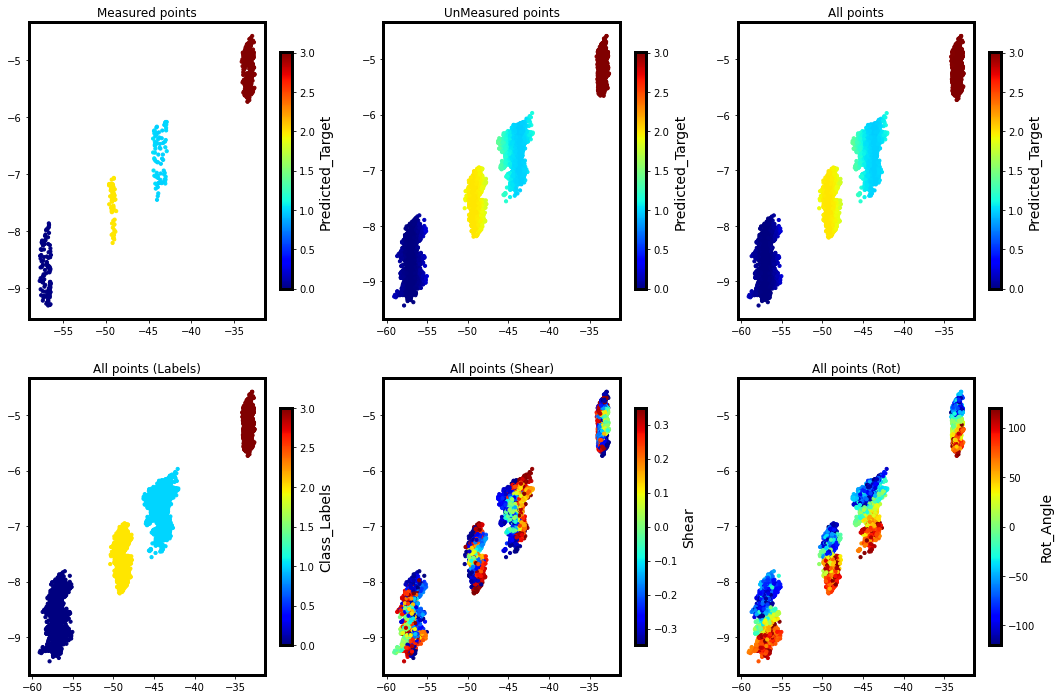

In [39]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train4[:, 1], embeded_train4[:, 0], s=10, c = predmean_train4, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured4[:, 1], embeded_unmeasured4[:, 0], s=10,
                c = predmean_unmeas4, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = predmean14, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Case-5, Continuous targets
Target Function: Shears

In [40]:
# First we will run the DKL on the whole dataset in one go
X5 = np.copy(X)   # Copying the entire input dataset
targets5 = np.copy(shears_all[:,0])   # Preparing the targets/outputs

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

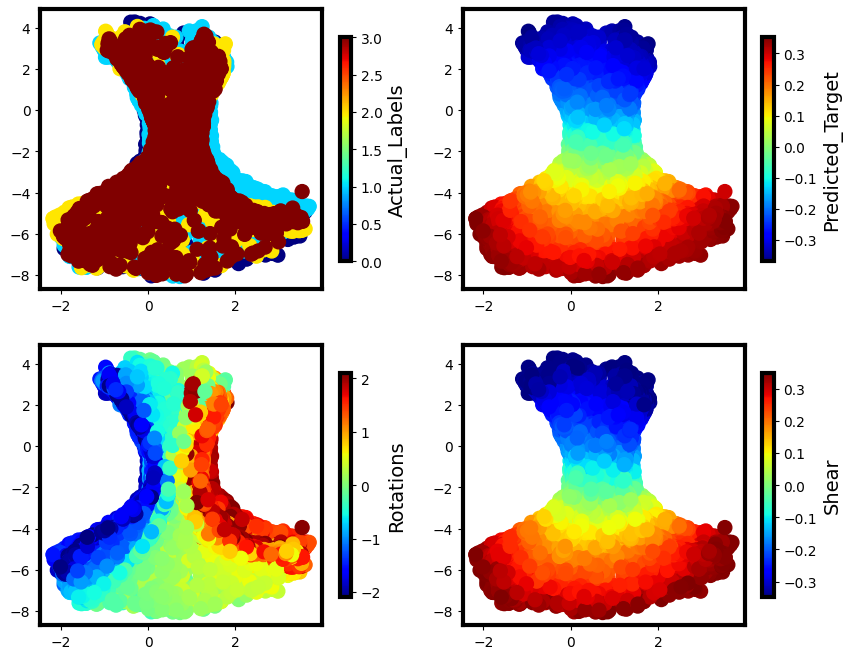

In [ ]:
# Running the DKL on the whole dataset
rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

# Latent space Embedding and prediction on the whole input dataset
embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=250)
pred_std5 = jnp.sqrt(pred_var5)

# Visualization of latent space distributions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = 100, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])
    
    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]
    
    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)
    
    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=100)
    
    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)


# Saving the results
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 361.70it/s, init loss: 60198.9135, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4439 0.3954]
k_scale          0.26990000000000003
noise            0.0091

Step 2


100%|█| 1000/1000 [00:02<00:00, 367.81it/s, init loss: 60200.1579, avg. loss [95



Inferred GP kernel parameters
k_length         [0.526  0.4706]
k_scale          0.2639
noise            0.0092

Step 3


100%|█| 1000/1000 [00:02<00:00, 369.89it/s, init loss: 60201.4237, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4688 0.4264]
k_scale          0.2726
noise            0.0091

Step 4


100%|█| 1000/1000 [00:02<00:00, 366.72it/s, init loss: 60202.6982, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5272 0.5856]
k_scale          0.2594
noise            0.0092

Step 5


100%|█| 1000/1000 [00:03<00:00, 294.68it/s, init loss: 60203.9724, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5978 0.5714]
k_scale          0.25780000000000003
noise            0.009300000000000001

Step 6


100%|█| 1000/1000 [00:02<00:00, 352.64it/s, init loss: 60205.2394, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6285 0.6877]
k_scale          0.2318
noise            0.0094

Step 7


100%|█| 1000/1000 [00:02<00:00, 356.49it/s, init loss: 60206.5121, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6253 0.6054]
k_scale          0.23470000000000002
noise            0.009600000000000001

Step 8


100%|█| 1000/1000 [00:02<00:00, 360.44it/s, init loss: 60207.7877, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4428 0.4686]
k_scale          0.2599
noise            0.0091

Step 9


100%|█| 1000/1000 [00:02<00:00, 362.29it/s, init loss: 60209.0633, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4099 0.3888]
k_scale          0.2773
noise            0.0091

Step 10


100%|█| 1000/1000 [00:02<00:00, 362.28it/s, init loss: 60210.3287, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3883 0.398 ]
k_scale          0.2723
noise            0.0091

Step 11


100%|█| 1000/1000 [00:02<00:00, 361.72it/s, init loss: 60211.5505, avg. loss [95



Inferred GP kernel parameters
k_length         [0.468  0.5328]
k_scale          0.2602
noise            0.009000000000000001

Step 12


100%|█| 1000/1000 [00:04<00:00, 236.62it/s, init loss: 60212.7796, avg. loss [95



Inferred GP kernel parameters
k_length         [0.49   0.5534]
k_scale          0.24200000000000002
noise            0.0094

Step 13


100%|█| 1000/1000 [00:02<00:00, 343.33it/s, init loss: 60214.0535, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4367 0.4322]
k_scale          0.2629
noise            0.0091

Step 14


100%|█| 1000/1000 [00:02<00:00, 351.68it/s, init loss: 60215.2749, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4326 0.3486]
k_scale          0.2733
noise            0.0091

Step 15


100%|█| 1000/1000 [00:02<00:00, 354.51it/s, init loss: 60216.5303, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4026 0.376 ]
k_scale          0.2612
noise            0.0089

Step 16


100%|█| 1000/1000 [00:02<00:00, 353.90it/s, init loss: 60217.7377, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4225 0.419 ]
k_scale          0.2652
noise            0.009000000000000001

Step 17


100%|█| 1000/1000 [00:02<00:00, 359.38it/s, init loss: 60218.9621, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4831 0.5169]
k_scale          0.2396
noise            0.009000000000000001

Step 18


100%|█| 1000/1000 [00:02<00:00, 361.93it/s, init loss: 60220.1614, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4841 0.3518]
k_scale          0.2702
noise            0.0091

Step 19


100%|█| 1000/1000 [00:03<00:00, 331.57it/s, init loss: 60221.4287, avg. loss [95



Inferred GP kernel parameters
k_length         [0.393  0.3887]
k_scale          0.265
noise            0.009000000000000001

Step 20


100%|█| 1000/1000 [00:02<00:00, 345.24it/s, init loss: 60222.6957, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4045 0.4156]
k_scale          0.25620000000000004
noise            0.0091

Step 21


100%|█| 1000/1000 [00:02<00:00, 355.75it/s, init loss: 60223.8687, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4168 0.405 ]
k_scale          0.2592
noise            0.009000000000000001

Step 22


100%|█| 1000/1000 [00:02<00:00, 356.80it/s, init loss: 60225.1419, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4684 0.5973]
k_scale          0.2351
noise            0.0092

Step 23


100%|█| 1000/1000 [00:02<00:00, 358.70it/s, init loss: 60226.3987, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3921 0.3795]
k_scale          0.2664
noise            0.0089

Step 24


100%|█| 1000/1000 [00:02<00:00, 360.06it/s, init loss: 60227.6334, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4108 0.4105]
k_scale          0.2627
noise            0.0089

Step 25


100%|█| 1000/1000 [00:02<00:00, 364.95it/s, init loss: 60228.8532, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3966 0.4118]
k_scale          0.27190000000000003
noise            0.0088

Step 26


100%|█| 1000/1000 [00:02<00:00, 343.57it/s, init loss: 60230.1008, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3817 0.3667]
k_scale          0.25780000000000003
noise            0.009000000000000001

Step 27


100%|█| 1000/1000 [00:02<00:00, 353.42it/s, init loss: 60231.3373, avg. loss [95



Inferred GP kernel parameters
k_length         [0.444  0.4349]
k_scale          0.27240000000000003
noise            0.0091

Step 28


100%|█| 1000/1000 [00:02<00:00, 353.77it/s, init loss: 60232.5136, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5563 0.6052]
k_scale          0.2154
noise            0.0097

Step 29


100%|█| 1000/1000 [00:02<00:00, 355.80it/s, init loss: 60233.7883, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6717 0.6091]
k_scale          0.22610000000000002
noise            0.0092

Step 30


100%|█| 1000/1000 [00:02<00:00, 352.34it/s, init loss: 60235.0558, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4989 0.4549]
k_scale          0.2607
noise            0.0091

Step 31


100%|█| 1000/1000 [00:02<00:00, 356.53it/s, init loss: 60236.3264, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4455 0.4467]
k_scale          0.2509
noise            0.009000000000000001

Step 32


100%|█| 1000/1000 [00:04<00:00, 238.47it/s, init loss: 60237.5390, avg. loss [95



Inferred GP kernel parameters
k_length         [0.414  0.4213]
k_scale          0.2931
noise            0.0091

Step 33


100%|█| 1000/1000 [00:02<00:00, 346.31it/s, init loss: 60238.7929, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4972 0.4056]
k_scale          0.24700000000000003
noise            0.0091

Step 34


100%|█| 1000/1000 [00:02<00:00, 350.49it/s, init loss: 60240.0556, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4054 0.3813]
k_scale          0.2723
noise            0.009000000000000001

Step 35


100%|█| 1000/1000 [00:02<00:00, 349.42it/s, init loss: 60241.2735, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4285 0.3758]
k_scale          0.271
noise            0.009000000000000001

Step 36


100%|█| 1000/1000 [00:02<00:00, 354.55it/s, init loss: 60242.5322, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4241 0.4441]
k_scale          0.2596
noise            0.0089

Step 37


100%|█| 1000/1000 [00:02<00:00, 360.00it/s, init loss: 60243.7561, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4634 0.4495]
k_scale          0.2615
noise            0.0092

Step 38


100%|█| 1000/1000 [00:02<00:00, 361.80it/s, init loss: 60245.0311, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3852 0.3766]
k_scale          0.2606
noise            0.0091

Step 39


100%|█| 1000/1000 [00:03<00:00, 329.55it/s, init loss: 60246.3042, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4973 0.4431]
k_scale          0.24380000000000002
noise            0.0088

Step 40


100%|█| 1000/1000 [00:02<00:00, 344.04it/s, init loss: 60247.5027, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4011 0.3732]
k_scale          0.2917
noise            0.0091

Step 41


100%|█| 1000/1000 [00:02<00:00, 354.63it/s, init loss: 60248.7431, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5221 0.4989]
k_scale          0.2467
noise            0.0091

Step 42


100%|█| 1000/1000 [00:02<00:00, 358.15it/s, init loss: 60249.9546, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4639 0.4722]
k_scale          0.25570000000000004
noise            0.0088

Step 43


100%|█| 1000/1000 [00:02<00:00, 352.65it/s, init loss: 60251.1368, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4085 0.3902]
k_scale          0.2691
noise            0.0088

Step 44


100%|█| 1000/1000 [00:02<00:00, 354.76it/s, init loss: 60252.3769, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4507 0.4054]
k_scale          0.2748
noise            0.009000000000000001

Step 45


100%|█| 1000/1000 [00:02<00:00, 360.17it/s, init loss: 60253.6487, avg. loss [95



Inferred GP kernel parameters
k_length         [0.415  0.4075]
k_scale          0.28240000000000004
noise            0.0089

Step 46


100%|█| 1000/1000 [00:03<00:00, 328.67it/s, init loss: 60254.8075, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4696 0.454 ]
k_scale          0.2487
noise            0.0091

Step 47


100%|█| 1000/1000 [00:02<00:00, 339.18it/s, init loss: 60256.0218, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4403 0.4713]
k_scale          0.2506
noise            0.0089

Step 48


100%|█| 1000/1000 [00:02<00:00, 346.68it/s, init loss: 60257.1599, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3904 0.3883]
k_scale          0.2738
noise            0.0088

Step 49


100%|█| 1000/1000 [00:02<00:00, 360.29it/s, init loss: 60258.4268, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4861 0.5261]
k_scale          0.23900000000000002
noise            0.0091

Step 50


100%|█| 1000/1000 [00:02<00:00, 360.07it/s, init loss: 60259.6166, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3877 0.3754]
k_scale          0.277
noise            0.0088

Step 51


100%|█| 1000/1000 [00:02<00:00, 362.93it/s, init loss: 60260.8883, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4709 0.3944]
k_scale          0.2671
noise            0.0088

Step 52


100%|█| 1000/1000 [00:03<00:00, 269.35it/s, init loss: 60262.0884, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6134 0.6318]
k_scale          0.22360000000000002
noise            0.009000000000000001

Step 53


100%|█| 1000/1000 [00:02<00:00, 349.40it/s, init loss: 60263.2821, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6173 0.8329]
k_scale          0.2107
noise            0.0091

Step 54


100%|█| 1000/1000 [00:02<00:00, 356.01it/s, init loss: 60264.5487, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4401 0.4394]
k_scale          0.25320000000000004
noise            0.0088

Step 55


100%|█| 1000/1000 [00:02<00:00, 357.39it/s, init loss: 60265.7396, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4562 0.4694]
k_scale          0.2442
noise            0.009000000000000001

Step 56


100%|█| 1000/1000 [00:02<00:00, 358.62it/s, init loss: 60266.9516, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4259 0.4292]
k_scale          0.2571
noise            0.008700000000000001

Step 57


100%|█| 1000/1000 [00:02<00:00, 359.75it/s, init loss: 60268.0934, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4447 0.46  ]
k_scale          0.2553
noise            0.009000000000000001

Step 58


100%|█| 1000/1000 [00:02<00:00, 361.37it/s, init loss: 60269.2701, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4186 0.3938]
k_scale          0.24860000000000002
noise            0.0088

Step 59


100%|█| 1000/1000 [00:03<00:00, 270.76it/s, init loss: 60270.4455, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5483 0.5706]
k_scale          0.2526
noise            0.0089

Step 60


100%|█| 1000/1000 [00:02<00:00, 347.54it/s, init loss: 60271.6817, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5382 0.4774]
k_scale          0.2436
noise            0.009300000000000001

Step 61


100%|█| 1000/1000 [00:02<00:00, 354.24it/s, init loss: 60272.8622, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4293 0.4292]
k_scale          0.24860000000000002
noise            0.0089

Step 62


100%|█| 1000/1000 [00:02<00:00, 354.62it/s, init loss: 60274.0416, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7537 0.6787]
k_scale          0.2073
noise            0.0095

Step 63


100%|█| 1000/1000 [00:02<00:00, 356.23it/s, init loss: 60275.3095, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5153 0.6414]
k_scale          0.2358
noise            0.0089

Step 64


100%|█| 1000/1000 [00:02<00:00, 357.12it/s, init loss: 60276.5753, avg. loss [95



Inferred GP kernel parameters
k_length         [0.3801 0.3922]
k_scale          0.2817
noise            0.0088

Step 65


100%|█| 1000/1000 [00:02<00:00, 362.24it/s, init loss: 60277.8253, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4334 0.4269]
k_scale          0.264
noise            0.008700000000000001

Step 66


100%|█| 1000/1000 [00:03<00:00, 269.89it/s, init loss: 60279.0614, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5585 0.4696]
k_scale          0.2484
noise            0.009000000000000001

Step 67


100%|█| 1000/1000 [00:02<00:00, 344.58it/s, init loss: 60280.2330, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4715 0.4597]
k_scale          0.2529
noise            0.0088

Step 68


100%|█| 1000/1000 [00:02<00:00, 352.19it/s, init loss: 60281.4065, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5305 0.5263]
k_scale          0.2452
noise            0.009000000000000001

Step 69


100%|█| 1000/1000 [00:02<00:00, 355.13it/s, init loss: 60282.6368, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4134 0.4019]
k_scale          0.25780000000000003
noise            0.0089

Step 70


100%|█| 1000/1000 [00:02<00:00, 356.06it/s, init loss: 60283.8586, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4511 0.4563]
k_scale          0.2646
noise            0.0088

Step 71


100%|█| 1000/1000 [00:02<00:00, 355.68it/s, init loss: 60285.1018, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4443 0.4251]
k_scale          0.2717
noise            0.0088

Step 72


100%|█| 1000/1000 [00:02<00:00, 357.18it/s, init loss: 60286.2797, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4528 0.4376]
k_scale          0.2575
noise            0.009000000000000001

Step 73


100%|█| 1000/1000 [00:03<00:00, 266.60it/s, init loss: 60287.5450, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4689 0.5077]
k_scale          0.2429
noise            0.008700000000000001

Step 74


100%|█| 1000/1000 [00:02<00:00, 341.40it/s, init loss: 60288.7647, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4463 0.4361]
k_scale          0.2679
noise            0.0089

Step 75


100%|█| 1000/1000 [00:02<00:00, 349.31it/s, init loss: 60289.9824, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4631 0.4829]
k_scale          0.2706
noise            0.0089

Step 76


100%|█| 1000/1000 [00:02<00:00, 353.19it/s, init loss: 60291.2060, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4001 0.3874]
k_scale          0.2566
noise            0.0088

Step 77


100%|█| 1000/1000 [00:02<00:00, 355.27it/s, init loss: 60292.4339, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4894 0.5061]
k_scale          0.2449
noise            0.0088

Step 78


100%|█| 1000/1000 [00:02<00:00, 352.31it/s, init loss: 60293.6936, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4917 0.6436]
k_scale          0.24860000000000002
noise            0.0089

Step 79


100%|█| 1000/1000 [00:02<00:00, 355.32it/s, init loss: 60294.8812, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4914 0.4743]
k_scale          0.2553
noise            0.0088

Step 80


100%|█| 1000/1000 [00:02<00:00, 335.68it/s, init loss: 60296.1277, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4134 0.389 ]
k_scale          0.2671
noise            0.0088

Step 81


100%|█| 1000/1000 [00:02<00:00, 337.54it/s, init loss: 60297.3729, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5038 0.6014]
k_scale          0.28500000000000003
noise            0.0088

Step 82


100%|█| 1000/1000 [00:02<00:00, 346.28it/s, init loss: 60298.6034, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4462 0.4094]
k_scale          0.2548
noise            0.0089

Step 83


100%|█| 1000/1000 [00:02<00:00, 350.74it/s, init loss: 60299.8528, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4901 0.4246]
k_scale          0.2424
noise            0.0094

Step 84


100%|█| 1000/1000 [00:02<00:00, 354.51it/s, init loss: 60301.1141, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4675 0.403 ]
k_scale          0.29460000000000003
noise            0.0088

Step 85


100%|█| 1000/1000 [00:02<00:00, 355.99it/s, init loss: 60302.3876, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5477 0.4461]
k_scale          0.25930000000000003
noise            0.0089

Step 86


100%|█| 1000/1000 [00:03<00:00, 272.68it/s, init loss: 60303.5386, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5308 0.4885]
k_scale          0.2707
noise            0.0088

Step 87


100%|█| 1000/1000 [00:02<00:00, 345.91it/s, init loss: 60304.7984, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5733 0.6363]
k_scale          0.24350000000000002
noise            0.0088

Step 88


100%|█| 1000/1000 [00:02<00:00, 350.29it/s, init loss: 60306.0469, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6113 0.5903]
k_scale          0.23800000000000002
noise            0.009000000000000001

Step 89


100%|█| 1000/1000 [00:02<00:00, 353.87it/s, init loss: 60307.2631, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4444 0.3966]
k_scale          0.2592
noise            0.0088

Step 90


100%|█| 1000/1000 [00:02<00:00, 353.89it/s, init loss: 60308.4425, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7552 0.642 ]
k_scale          0.23390000000000002
noise            0.0089

Step 91


100%|█| 1000/1000 [00:02<00:00, 352.32it/s, init loss: 60309.6516, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5105 0.5354]
k_scale          0.2604
noise            0.0088

Step 92


100%|█| 1000/1000 [00:02<00:00, 357.01it/s, init loss: 60310.9098, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5738 0.7562]
k_scale          0.23970000000000002
noise            0.0089

Step 93


100%|█| 1000/1000 [00:03<00:00, 265.14it/s, init loss: 60312.1139, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7396 0.7922]
k_scale          0.1991
noise            0.0089

Step 94


100%|█| 1000/1000 [00:02<00:00, 334.14it/s, init loss: 60313.2848, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8386 0.7089]
k_scale          0.196
noise            0.0092

Step 95


100%|█| 1000/1000 [00:02<00:00, 345.73it/s, init loss: 60314.5252, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5984 0.6106]
k_scale          0.2318
noise            0.0088

Step 96


100%|█| 1000/1000 [00:02<00:00, 348.45it/s, init loss: 60315.7531, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4868 0.4649]
k_scale          0.2701
noise            0.0086

Step 97


100%|█| 1000/1000 [00:02<00:00, 350.80it/s, init loss: 60316.9983, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4312 0.3847]
k_scale          0.2695
noise            0.0086

Step 98


100%|█| 1000/1000 [00:02<00:00, 353.15it/s, init loss: 60318.2686, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4277 0.4498]
k_scale          0.2602
noise            0.0088

Step 99


100%|█| 1000/1000 [00:02<00:00, 356.63it/s, init loss: 60319.4865, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4672 0.4598]
k_scale          0.2692
noise            0.0088

Step 100


100%|█| 1000/1000 [00:03<00:00, 263.98it/s, init loss: 60320.6719, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5353 0.5456]
k_scale          0.26940000000000003
noise            0.0088

Step 101


100%|█| 1000/1000 [00:02<00:00, 336.66it/s, init loss: 60321.8226, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5799 0.725 ]
k_scale          0.2513
noise            0.0089

Step 102


100%|█| 1000/1000 [00:02<00:00, 347.08it/s, init loss: 60323.0981, avg. loss [95



Inferred GP kernel parameters
k_length         [0.512  0.4165]
k_scale          0.279
noise            0.008700000000000001

Step 103


100%|█| 1000/1000 [00:02<00:00, 350.43it/s, init loss: 60324.2564, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6661 0.7344]
k_scale          0.2204
noise            0.0092

Step 104


100%|█| 1000/1000 [00:02<00:00, 351.80it/s, init loss: 60325.5198, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6568 0.7336]
k_scale          0.20370000000000002
noise            0.0091

Step 105


100%|█| 1000/1000 [00:02<00:00, 353.04it/s, init loss: 60326.7851, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4942 0.5202]
k_scale          0.2597
noise            0.008700000000000001

Step 106


100%|█| 1000/1000 [00:02<00:00, 358.26it/s, init loss: 60327.9327, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5646 0.7473]
k_scale          0.2225
noise            0.009000000000000001

Step 107


100%|█| 1000/1000 [00:02<00:00, 333.96it/s, init loss: 60329.1353, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6302 0.7436]
k_scale          0.22340000000000002
noise            0.0089

Step 108


100%|█| 1000/1000 [00:02<00:00, 341.08it/s, init loss: 60330.4122, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7461 0.7097]
k_scale          0.197
noise            0.0094

Step 109


100%|█| 1000/1000 [00:02<00:00, 347.69it/s, init loss: 60331.6486, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4635 0.4583]
k_scale          0.27540000000000003
noise            0.008700000000000001

Step 110


100%|█| 1000/1000 [00:02<00:00, 348.49it/s, init loss: 60332.8461, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4964 0.4378]
k_scale          0.2632
noise            0.0089

Step 111


100%|█| 1000/1000 [00:02<00:00, 349.47it/s, init loss: 60334.1125, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5486 0.422 ]
k_scale          0.227
noise            0.0089

Step 112


100%|█| 1000/1000 [00:02<00:00, 352.27it/s, init loss: 60335.3650, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5635 0.6838]
k_scale          0.2306
noise            0.0089

Step 113


100%|█| 1000/1000 [00:02<00:00, 355.95it/s, init loss: 60336.5466, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5211 0.5239]
k_scale          0.256
noise            0.008700000000000001

Step 114


100%|█| 1000/1000 [00:02<00:00, 334.37it/s, init loss: 60337.7210, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5248 0.4904]
k_scale          0.2538
noise            0.0088

Step 115


100%|█| 1000/1000 [00:02<00:00, 336.33it/s, init loss: 60338.9585, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5027 0.5181]
k_scale          0.2713
noise            0.008700000000000001

Step 116


100%|█| 1000/1000 [00:02<00:00, 342.17it/s, init loss: 60340.2044, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5409 0.5729]
k_scale          0.22790000000000002
noise            0.008700000000000001

Step 117


100%|█| 1000/1000 [00:02<00:00, 346.65it/s, init loss: 60341.3604, avg. loss [95



Inferred GP kernel parameters
k_length         [0.544  0.5458]
k_scale          0.2497
noise            0.0086

Step 118


100%|█| 1000/1000 [00:02<00:00, 347.91it/s, init loss: 60342.5141, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5425 0.5956]
k_scale          0.24050000000000002
noise            0.0089

Step 119


100%|█| 1000/1000 [00:02<00:00, 349.28it/s, init loss: 60343.6852, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5241 0.6798]
k_scale          0.2529
noise            0.0088

Step 120


100%|█| 1000/1000 [00:03<00:00, 261.45it/s, init loss: 60344.8772, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4903 0.5124]
k_scale          0.25630000000000003
noise            0.0089

Step 121


100%|█| 1000/1000 [00:02<00:00, 336.57it/s, init loss: 60346.1236, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5235 0.4861]
k_scale          0.26780000000000004
noise            0.0088

Step 122


100%|█| 1000/1000 [00:02<00:00, 345.20it/s, init loss: 60347.3691, avg. loss [95



Inferred GP kernel parameters
k_length         [0.454  0.4531]
k_scale          0.26980000000000004
noise            0.0088

Step 123


100%|█| 1000/1000 [00:02<00:00, 349.24it/s, init loss: 60348.5655, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6344 0.5295]
k_scale          0.24080000000000001
noise            0.009000000000000001

Step 124


100%|█| 1000/1000 [00:02<00:00, 351.56it/s, init loss: 60349.7569, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4531 0.4871]
k_scale          0.2553
noise            0.0086

Step 125


100%|█| 1000/1000 [00:02<00:00, 351.87it/s, init loss: 60351.0318, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6327 0.6428]
k_scale          0.1903
noise            0.0089

Step 126


100%|█| 1000/1000 [00:02<00:00, 358.73it/s, init loss: 60352.1935, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5648 0.6014]
k_scale          0.23090000000000002
noise            0.0092

Step 127


100%|█| 1000/1000 [00:03<00:00, 263.22it/s, init loss: 60353.3670, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5231 0.4666]
k_scale          0.24400000000000002
noise            0.0088

Step 128


100%|█| 1000/1000 [00:02<00:00, 341.44it/s, init loss: 60354.5355, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4563 0.4758]
k_scale          0.2492
noise            0.0086

Step 129


100%|█| 1000/1000 [00:02<00:00, 344.56it/s, init loss: 60355.7388, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5435 0.5748]
k_scale          0.23320000000000002
noise            0.0089

Step 130


100%|█| 1000/1000 [00:02<00:00, 348.55it/s, init loss: 60356.9270, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5242 0.5086]
k_scale          0.25570000000000004
noise            0.0088

Step 131


100%|█| 1000/1000 [00:02<00:00, 351.41it/s, init loss: 60358.1175, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7139 0.5778]
k_scale          0.22080000000000002
noise            0.008700000000000001

Step 132


100%|█| 1000/1000 [00:02<00:00, 356.52it/s, init loss: 60359.3567, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5818 0.609 ]
k_scale          0.2406
noise            0.008700000000000001

Step 133


100%|█| 1000/1000 [00:02<00:00, 358.64it/s, init loss: 60360.5347, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5255 0.5899]
k_scale          0.2519
noise            0.0088

Step 134


100%|█| 1000/1000 [00:03<00:00, 264.08it/s, init loss: 60361.7672, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4559 0.4696]
k_scale          0.2564
noise            0.008700000000000001

Step 135


100%|█| 1000/1000 [00:02<00:00, 341.33it/s, init loss: 60363.0079, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5054 0.5279]
k_scale          0.2604
noise            0.0088

Step 136


100%|█| 1000/1000 [00:02<00:00, 344.35it/s, init loss: 60364.2267, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6564 0.7438]
k_scale          0.19820000000000002
noise            0.0092

Step 137


100%|█| 1000/1000 [00:02<00:00, 344.13it/s, init loss: 60365.4967, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5304 0.5719]
k_scale          0.2718
noise            0.0088

Step 138


100%|█| 1000/1000 [00:02<00:00, 350.76it/s, init loss: 60366.7066, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6492 0.6949]
k_scale          0.23950000000000002
noise            0.0089

Step 139


100%|█| 1000/1000 [00:02<00:00, 351.63it/s, init loss: 60367.9417, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5562 0.6594]
k_scale          0.22740000000000002
noise            0.0086

Step 140


100%|█| 1000/1000 [00:02<00:00, 355.65it/s, init loss: 60369.1154, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4934 0.4926]
k_scale          0.23190000000000002
noise            0.0088

Step 141


100%|█| 1000/1000 [00:02<00:00, 334.08it/s, init loss: 60370.3818, avg. loss [95



Inferred GP kernel parameters
k_length         [0.606  0.6373]
k_scale          0.23870000000000002
noise            0.0086

Step 142


100%|█| 1000/1000 [00:03<00:00, 332.92it/s, init loss: 60371.6204, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6767 0.5139]
k_scale          0.23
noise            0.0089

Step 143


100%|█| 1000/1000 [00:02<00:00, 340.70it/s, init loss: 60372.8540, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6963 0.7234]
k_scale          0.2187
noise            0.009000000000000001

Step 144


100%|█| 1000/1000 [00:02<00:00, 346.19it/s, init loss: 60374.0080, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7789 0.6914]
k_scale          0.2371
noise            0.0088

Step 145


100%|█| 1000/1000 [00:02<00:00, 349.22it/s, init loss: 60375.2823, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9974 0.921 ]
k_scale          0.19640000000000002
noise            0.0092

Step 146


100%|█| 1000/1000 [00:02<00:00, 352.39it/s, init loss: 60376.4840, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5745 0.6035]
k_scale          0.252
noise            0.0088

Step 147


100%|█| 1000/1000 [00:02<00:00, 354.09it/s, init loss: 60377.6973, avg. loss [95



Inferred GP kernel parameters
k_length         [0.485  0.4747]
k_scale          0.2852
noise            0.0088

Step 148


100%|█| 1000/1000 [00:02<00:00, 333.91it/s, init loss: 60378.8744, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5964 0.6795]
k_scale          0.2368
noise            0.0086

Step 149


100%|█| 1000/1000 [00:02<00:00, 342.70it/s, init loss: 60380.1008, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7435 0.676 ]
k_scale          0.2298
noise            0.0088

Step 150


100%|█| 1000/1000 [00:02<00:00, 346.19it/s, init loss: 60381.3181, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5631 0.5082]
k_scale          0.27040000000000003
noise            0.0089

Step 151


100%|█| 1000/1000 [00:02<00:00, 349.42it/s, init loss: 60382.5192, avg. loss [95



Inferred GP kernel parameters
k_length         [0.813 0.701]
k_scale          0.23500000000000001
noise            0.0088

Step 152


100%|█| 1000/1000 [00:02<00:00, 350.18it/s, init loss: 60383.7509, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6036 0.5272]
k_scale          0.2134
noise            0.010100000000000001

Step 153


100%|█| 1000/1000 [00:02<00:00, 354.89it/s, init loss: 60384.9180, avg. loss [95



Inferred GP kernel parameters
k_length         [0.476  0.4985]
k_scale          0.25120000000000003
noise            0.0086

Step 154


100%|█| 1000/1000 [00:03<00:00, 266.01it/s, init loss: 60386.0407, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8074 0.8501]
k_scale          0.18180000000000002
noise            0.0091

Step 155


100%|█| 1000/1000 [00:02<00:00, 343.91it/s, init loss: 60387.3110, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5175 0.5502]
k_scale          0.26780000000000004
noise            0.0089

Step 156


100%|█| 1000/1000 [00:02<00:00, 346.30it/s, init loss: 60388.4772, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6622 0.7108]
k_scale          0.2554
noise            0.0089

Step 157


100%|█| 1000/1000 [00:02<00:00, 349.08it/s, init loss: 60389.7339, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6805 0.6346]
k_scale          0.2215
noise            0.009000000000000001

Step 158


100%|█| 1000/1000 [00:02<00:00, 349.04it/s, init loss: 60391.0063, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3848 1.5205]
k_scale          0.1626
noise            0.0092

Step 159


100%|█| 1000/1000 [00:02<00:00, 346.95it/s, init loss: 60392.1986, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7544 0.7174]
k_scale          0.23900000000000002
noise            0.0088

Step 160


100%|█| 1000/1000 [00:02<00:00, 353.78it/s, init loss: 60393.3950, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5743 0.6862]
k_scale          0.2437
noise            0.008700000000000001

Step 161


100%|█| 1000/1000 [00:03<00:00, 265.66it/s, init loss: 60394.5884, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5099 0.5916]
k_scale          0.2378
noise            0.0089

Step 162


100%|█| 1000/1000 [00:02<00:00, 335.88it/s, init loss: 60395.7848, avg. loss [95



Inferred GP kernel parameters
k_length         [0.706  0.5703]
k_scale          0.227
noise            0.0088

Step 163


100%|█| 1000/1000 [00:02<00:00, 342.34it/s, init loss: 60397.0301, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7732 0.7624]
k_scale          0.2132
noise            0.0089

Step 164


100%|█| 1000/1000 [00:02<00:00, 345.15it/s, init loss: 60398.2816, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6812 0.6753]
k_scale          0.1719
noise            0.0094

Step 165


100%|█| 1000/1000 [00:02<00:00, 347.05it/s, init loss: 60399.5222, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6088 0.6396]
k_scale          0.2389
noise            0.0085

Step 166


100%|█| 1000/1000 [00:02<00:00, 349.19it/s, init loss: 60400.7052, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6641 0.6383]
k_scale          0.2354
noise            0.008700000000000001

Step 167


100%|█| 1000/1000 [00:02<00:00, 352.93it/s, init loss: 60401.8370, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4741 0.4911]
k_scale          0.2745
noise            0.008700000000000001

Step 168


100%|█| 1000/1000 [00:03<00:00, 331.10it/s, init loss: 60403.0482, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6615 0.6573]
k_scale          0.2391
noise            0.008700000000000001

Step 169


100%|█| 1000/1000 [00:02<00:00, 334.45it/s, init loss: 60404.2473, avg. loss [95



Inferred GP kernel parameters
k_length         [0.58   0.8941]
k_scale          0.23020000000000002
noise            0.009000000000000001

Step 170


100%|█| 1000/1000 [00:02<00:00, 340.49it/s, init loss: 60405.4719, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4968 0.5089]
k_scale          0.2831
noise            0.0086

Step 171


100%|█| 1000/1000 [00:02<00:00, 344.04it/s, init loss: 60406.6289, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4911 0.4329]
k_scale          0.25320000000000004
noise            0.0085

Step 172


100%|█| 1000/1000 [00:02<00:00, 346.21it/s, init loss: 60407.8349, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6401 0.7359]
k_scale          0.2104
noise            0.008700000000000001

Step 173


100%|█| 1000/1000 [00:02<00:00, 348.31it/s, init loss: 60409.0001, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7471 0.8324]
k_scale          0.1844
noise            0.0089

Step 174


100%|█| 1000/1000 [00:02<00:00, 351.35it/s, init loss: 60410.2462, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6989 0.6146]
k_scale          0.2685
noise            0.0085

Step 175


100%|█| 1000/1000 [00:03<00:00, 327.66it/s, init loss: 60411.3945, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8114 0.7796]
k_scale          0.2136
noise            0.009000000000000001

Step 176


100%|█| 1000/1000 [00:03<00:00, 328.31it/s, init loss: 60412.6692, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9474 1.1596]
k_scale          0.17750000000000002
noise            0.009000000000000001

Step 177


100%|█| 1000/1000 [00:02<00:00, 334.41it/s, init loss: 60413.8624, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7266 0.7146]
k_scale          0.20320000000000002
noise            0.009300000000000001

Step 178


100%|█| 1000/1000 [00:02<00:00, 340.36it/s, init loss: 60415.0732, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5444 0.6109]
k_scale          0.2612
noise            0.0085

Step 179


100%|█| 1000/1000 [00:02<00:00, 343.96it/s, init loss: 60416.2104, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4356 0.4064]
k_scale          0.2949
noise            0.0088

Step 180


100%|█| 1000/1000 [00:02<00:00, 346.99it/s, init loss: 60417.4307, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6304 0.6959]
k_scale          0.2389
noise            0.008700000000000001

Step 181


100%|█| 1000/1000 [00:02<00:00, 350.69it/s, init loss: 60418.6656, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5486 0.5247]
k_scale          0.277
noise            0.0086

Step 182


100%|█| 1000/1000 [00:03<00:00, 326.31it/s, init loss: 60419.8632, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6474 0.6629]
k_scale          0.24180000000000001
noise            0.0086

Step 183


100%|█| 1000/1000 [00:03<00:00, 330.22it/s, init loss: 60421.0499, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5978 0.5924]
k_scale          0.2615
noise            0.008700000000000001

Step 184


100%|█| 1000/1000 [00:02<00:00, 339.00it/s, init loss: 60422.2208, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8042 0.7518]
k_scale          0.22410000000000002
noise            0.0086

Step 185


100%|█| 1000/1000 [00:02<00:00, 340.12it/s, init loss: 60423.4177, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5281 0.7816]
k_scale          0.2444
noise            0.0088

Step 186


100%|█| 1000/1000 [00:02<00:00, 343.81it/s, init loss: 60424.5813, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7617 0.9395]
k_scale          0.22990000000000002
noise            0.008700000000000001

Step 187


100%|█| 1000/1000 [00:02<00:00, 347.83it/s, init loss: 60425.8496, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6639 0.7122]
k_scale          0.2607
noise            0.0088

Step 188


100%|█| 1000/1000 [00:02<00:00, 349.69it/s, init loss: 60427.1124, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7925 0.754 ]
k_scale          0.23550000000000001
noise            0.0086

Step 189


100%|█| 1000/1000 [00:03<00:00, 326.55it/s, init loss: 60428.3194, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7182 0.714 ]
k_scale          0.24650000000000002
noise            0.008700000000000001

Step 190


100%|█| 1000/1000 [00:03<00:00, 332.74it/s, init loss: 60429.5347, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6172 0.7218]
k_scale          0.23440000000000003
noise            0.008700000000000001

Step 191


100%|█| 1000/1000 [00:02<00:00, 337.32it/s, init loss: 60430.8001, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7221 0.8361]
k_scale          0.2223
noise            0.0086

Step 192


100%|█| 1000/1000 [00:02<00:00, 341.35it/s, init loss: 60432.0077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5212 0.529 ]
k_scale          0.27090000000000003
noise            0.0086

Step 193


100%|█| 1000/1000 [00:02<00:00, 342.85it/s, init loss: 60433.1759, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6792 0.7308]
k_scale          0.2571
noise            0.008700000000000001

Step 194


100%|█| 1000/1000 [00:02<00:00, 349.22it/s, init loss: 60434.3849, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5345 0.5849]
k_scale          0.2
noise            0.009000000000000001

Step 195


100%|█| 1000/1000 [00:03<00:00, 262.69it/s, init loss: 60435.6337, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7885 0.7505]
k_scale          0.215
noise            0.0088

Step 196


100%|█| 1000/1000 [00:02<00:00, 334.48it/s, init loss: 60436.8237, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6237 0.6226]
k_scale          0.2364
noise            0.0088

Step 197


100%|█| 1000/1000 [00:02<00:00, 338.28it/s, init loss: 60438.0316, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6599 0.557 ]
k_scale          0.2622
noise            0.0086

Step 198


100%|█| 1000/1000 [00:02<00:00, 342.06it/s, init loss: 60439.2434, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5929 0.6335]
k_scale          0.2554
noise            0.008700000000000001

Step 199


100%|█| 1000/1000 [00:02<00:00, 344.48it/s, init loss: 60440.4991, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9261 0.8022]
k_scale          0.20750000000000002
noise            0.008700000000000001

Step 200


100%|█| 1000/1000 [00:02<00:00, 348.03it/s, init loss: 60441.6639, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7581 0.5669]
k_scale          0.2305
noise            0.0086

Step 201


100%|█| 1000/1000 [00:02<00:00, 345.87it/s, init loss: 60442.9378, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7315 0.7678]
k_scale          0.24300000000000002
noise            0.008700000000000001

Step 202


100%|█| 1000/1000 [00:03<00:00, 261.00it/s, init loss: 60444.1955, avg. loss [95



Inferred GP kernel parameters
k_length         [0.63  0.574]
k_scale          0.2452
noise            0.0086

Step 203


100%|█| 1000/1000 [00:03<00:00, 328.64it/s, init loss: 60445.3812, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7676 0.7223]
k_scale          0.22840000000000002
noise            0.0086

Step 204


100%|█| 1000/1000 [00:02<00:00, 341.33it/s, init loss: 60446.5444, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6411 0.6896]
k_scale          0.2485
noise            0.0086

Step 205


100%|█| 1000/1000 [00:02<00:00, 341.78it/s, init loss: 60447.6628, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6413 0.6311]
k_scale          0.2389
noise            0.0085

Step 206


100%|█| 1000/1000 [00:02<00:00, 343.17it/s, init loss: 60448.7976, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8403 0.92  ]
k_scale          0.21450000000000002
noise            0.0089

Step 207


100%|█| 1000/1000 [00:02<00:00, 342.66it/s, init loss: 60449.9889, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5818 0.5717]
k_scale          0.2364
noise            0.0086

Step 208


100%|█| 1000/1000 [00:02<00:00, 347.91it/s, init loss: 60451.1924, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6898 0.669 ]
k_scale          0.2151
noise            0.0091

Step 209


100%|█| 1000/1000 [00:03<00:00, 262.49it/s, init loss: 60452.4322, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0092 0.9921]
k_scale          0.1975
noise            0.008700000000000001

Step 210


100%|█| 1000/1000 [00:02<00:00, 335.02it/s, init loss: 60453.6518, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7321 0.9331]
k_scale          0.2071
noise            0.009000000000000001

Step 211


100%|█| 1000/1000 [00:02<00:00, 338.00it/s, init loss: 60454.8017, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6023 0.6643]
k_scale          0.14650000000000002
noise            0.0091

Step 212


100%|█| 1000/1000 [00:02<00:00, 343.41it/s, init loss: 60456.0043, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7443 0.6683]
k_scale          0.23220000000000002
noise            0.0091

Step 213


100%|█| 1000/1000 [00:02<00:00, 343.40it/s, init loss: 60457.1856, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7394 0.6032]
k_scale          0.22060000000000002
noise            0.0088

Step 214


100%|█| 1000/1000 [00:02<00:00, 345.50it/s, init loss: 60458.3758, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8315 0.829 ]
k_scale          0.1885
noise            0.0088

Step 215


100%|█| 1000/1000 [00:02<00:00, 347.33it/s, init loss: 60459.6380, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6789 0.8842]
k_scale          0.24500000000000002
noise            0.0085

Step 216


100%|█| 1000/1000 [00:03<00:00, 267.67it/s, init loss: 60460.8519, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6914 0.6557]
k_scale          0.2388
noise            0.0086

Step 217


100%|█| 1000/1000 [00:02<00:00, 335.85it/s, init loss: 60462.0294, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8027 0.7069]
k_scale          0.2235
noise            0.0086

Step 218


100%|█| 1000/1000 [00:02<00:00, 340.71it/s, init loss: 60463.2200, avg. loss [95



Inferred GP kernel parameters
k_length         [0.598  0.5963]
k_scale          0.2575
noise            0.008700000000000001

Step 219


100%|█| 1000/1000 [00:02<00:00, 341.13it/s, init loss: 60464.4741, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5715 0.585 ]
k_scale          0.23170000000000002
noise            0.0088

Step 220


100%|█| 1000/1000 [00:02<00:00, 344.89it/s, init loss: 60465.6521, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7254 0.6542]
k_scale          0.21860000000000002
noise            0.0086

Step 221


100%|█| 1000/1000 [00:02<00:00, 344.79it/s, init loss: 60466.8680, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5691 0.5883]
k_scale          0.2262
noise            0.0088

Step 222


100%|█| 1000/1000 [00:02<00:00, 345.19it/s, init loss: 60468.0023, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0553 0.7023]
k_scale          0.20600000000000002
noise            0.0091

Step 223


100%|█| 1000/1000 [00:03<00:00, 324.00it/s, init loss: 60469.2265, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8002 0.8345]
k_scale          0.2325
noise            0.0089

Step 224


100%|█| 1000/1000 [00:03<00:00, 330.95it/s, init loss: 60470.3938, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7722 0.6778]
k_scale          0.2204
noise            0.0086

Step 225


100%|█| 1000/1000 [00:02<00:00, 335.94it/s, init loss: 60471.5235, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8214 0.7323]
k_scale          0.2338
noise            0.0086

Step 226


100%|█| 1000/1000 [00:02<00:00, 341.89it/s, init loss: 60472.6689, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8182 0.8062]
k_scale          0.2182
noise            0.008700000000000001

Step 227


100%|█| 1000/1000 [00:02<00:00, 339.51it/s, init loss: 60473.8685, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7112 0.7404]
k_scale          0.25620000000000004
noise            0.0088

Step 228


100%|█| 1000/1000 [00:02<00:00, 344.83it/s, init loss: 60475.0676, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0464 1.1412]
k_scale          0.1899
noise            0.008700000000000001

Step 229


100%|█| 1000/1000 [00:02<00:00, 344.58it/s, init loss: 60476.2605, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7151 0.6297]
k_scale          0.1683
noise            0.0089

Step 230


100%|█| 1000/1000 [00:03<00:00, 318.32it/s, init loss: 60477.4121, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6237 0.5601]
k_scale          0.1835
noise            0.009000000000000001

Step 231


100%|█| 1000/1000 [00:03<00:00, 317.57it/s, init loss: 60478.5928, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7435 0.7601]
k_scale          0.2199
noise            0.0091

Step 232


100%|█| 1000/1000 [00:03<00:00, 327.87it/s, init loss: 60479.8651, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9674 0.8479]
k_scale          0.22390000000000002
noise            0.008700000000000001

Step 233


100%|█| 1000/1000 [00:03<00:00, 328.73it/s, init loss: 60480.9897, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5822 0.5495]
k_scale          0.1947
noise            0.0092

Step 234


100%|█| 1000/1000 [00:03<00:00, 332.07it/s, init loss: 60482.1650, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6527 0.6434]
k_scale          0.2323
noise            0.0089

Step 235


100%|█| 1000/1000 [00:03<00:00, 332.01it/s, init loss: 60483.4150, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5608 0.5355]
k_scale          0.2217
noise            0.008700000000000001

Step 236


100%|█| 1000/1000 [00:04<00:00, 222.80it/s, init loss: 60484.6409, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5997 0.6288]
k_scale          0.2601
noise            0.0086

Step 237


100%|█| 1000/1000 [00:03<00:00, 326.26it/s, init loss: 60485.7598, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6073 0.7975]
k_scale          0.21730000000000002
noise            0.0092

Step 238


100%|█| 1000/1000 [00:03<00:00, 328.75it/s, init loss: 60487.0080, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5978 0.6866]
k_scale          0.23340000000000002
noise            0.0086

Step 239


100%|█| 1000/1000 [00:02<00:00, 335.04it/s, init loss: 60488.2784, avg. loss [95



Inferred GP kernel parameters
k_length         [0.509  0.5434]
k_scale          0.26940000000000003
noise            0.0085

Step 240


100%|█| 1000/1000 [00:02<00:00, 338.66it/s, init loss: 60489.4715, avg. loss [95



Inferred GP kernel parameters
k_length         [1.034  0.7981]
k_scale          0.1845
noise            0.0092

Step 241


100%|█| 1000/1000 [00:02<00:00, 339.45it/s, init loss: 60490.6595, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5796 0.574 ]
k_scale          0.2652
noise            0.0085

Step 242


100%|█| 1000/1000 [00:02<00:00, 345.03it/s, init loss: 60491.8905, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0393 0.8701]
k_scale          0.1978
noise            0.0089

Step 243


100%|█| 1000/1000 [00:03<00:00, 254.41it/s, init loss: 60493.0505, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6586 0.6736]
k_scale          0.18180000000000002
noise            0.0094

Step 244


100%|█| 1000/1000 [00:03<00:00, 328.70it/s, init loss: 60494.2126, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4617 0.5897]
k_scale          0.23700000000000002
noise            0.0089

Step 245


100%|█| 1000/1000 [00:03<00:00, 332.06it/s, init loss: 60495.4192, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7038 0.6709]
k_scale          0.2136
noise            0.0088

Step 246


100%|█| 1000/1000 [00:02<00:00, 337.94it/s, init loss: 60496.5730, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5807 0.6663]
k_scale          0.2011
noise            0.0089

Step 247


100%|█| 1000/1000 [00:02<00:00, 339.62it/s, init loss: 60497.7557, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7973 0.5648]
k_scale          0.1582
noise            0.0091

Step 248


100%|█| 1000/1000 [00:03<00:00, 330.99it/s, init loss: 60498.8904, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8783 0.8856]
k_scale          0.2144
noise            0.0089

Step 249


100%|█| 1000/1000 [00:03<00:00, 333.28it/s, init loss: 60500.0434, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0858 0.9463]
k_scale          0.1983
noise            0.0086

Step 250


100%|█| 1000/1000 [00:03<00:00, 261.93it/s, init loss: 60501.2468, avg. loss [95



Inferred GP kernel parameters
k_length         [0.693  0.6582]
k_scale          0.23600000000000002
noise            0.0085

Step 251


100%|█| 1000/1000 [00:03<00:00, 323.19it/s, init loss: 60502.4090, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7226 0.8571]
k_scale          0.2218
noise            0.0089

Step 252


100%|█| 1000/1000 [00:03<00:00, 329.36it/s, init loss: 60503.5494, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3993 1.0653]
k_scale          0.1474
noise            0.0095

Step 253


100%|█| 1000/1000 [00:03<00:00, 330.21it/s, init loss: 60504.7461, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9859 0.9688]
k_scale          0.1877
noise            0.0088

Step 254


100%|█| 1000/1000 [00:03<00:00, 328.46it/s, init loss: 60505.8753, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6753 0.817 ]
k_scale          0.22290000000000001
noise            0.0086

Step 255


100%|█| 1000/1000 [00:03<00:00, 328.81it/s, init loss: 60507.0562, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5713 0.6031]
k_scale          0.19920000000000002
noise            0.0089

Step 256


100%|█| 1000/1000 [00:03<00:00, 332.27it/s, init loss: 60508.3019, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8689 0.7115]
k_scale          0.222
noise            0.0088

Step 257


100%|█| 1000/1000 [00:03<00:00, 253.90it/s, init loss: 60509.4371, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7442 0.8964]
k_scale          0.203
noise            0.008700000000000001

Step 258


100%|█| 1000/1000 [00:03<00:00, 319.49it/s, init loss: 60510.6161, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8155 0.7216]
k_scale          0.2071
noise            0.009000000000000001

Step 259


100%|█| 1000/1000 [00:03<00:00, 323.82it/s, init loss: 60511.7527, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7151 0.67  ]
k_scale          0.22540000000000002
noise            0.008700000000000001

Step 260


100%|█| 1000/1000 [00:03<00:00, 328.01it/s, init loss: 60512.9157, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5874 0.772 ]
k_scale          0.1481
noise            0.0092

Step 261


100%|█| 1000/1000 [00:03<00:00, 332.62it/s, init loss: 60514.0660, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6307 0.8228]
k_scale          0.1956
noise            0.009000000000000001

Step 262


100%|█| 1000/1000 [00:02<00:00, 335.78it/s, init loss: 60515.3407, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6615 0.9513]
k_scale          0.2204
noise            0.0089

Step 263


100%|█| 1000/1000 [00:03<00:00, 326.60it/s, init loss: 60516.5059, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8188 0.9702]
k_scale          0.1776
noise            0.0089

Step 264


100%|█| 1000/1000 [00:03<00:00, 320.37it/s, init loss: 60517.7789, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9928 0.7084]
k_scale          0.2162
noise            0.008700000000000001

Step 265


100%|█| 1000/1000 [00:03<00:00, 325.73it/s, init loss: 60518.9421, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8498 0.7841]
k_scale          0.2242
noise            0.0086

Step 266


100%|█| 1000/1000 [00:02<00:00, 333.64it/s, init loss: 60520.1039, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8443 0.8384]
k_scale          0.2078
noise            0.0086

Step 267


100%|█| 1000/1000 [00:03<00:00, 330.26it/s, init loss: 60521.2695, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6119 0.7138]
k_scale          0.24150000000000002
noise            0.0086

Step 268


100%|█| 1000/1000 [00:02<00:00, 334.33it/s, init loss: 60522.4188, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7405 0.8472]
k_scale          0.232
noise            0.0089

Step 269


100%|█| 1000/1000 [00:02<00:00, 336.18it/s, init loss: 60523.6605, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9401 0.8472]
k_scale          0.19260000000000002
noise            0.0092

Step 270


100%|█| 1000/1000 [00:02<00:00, 339.10it/s, init loss: 60524.8742, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7762 0.8497]
k_scale          0.23140000000000002
noise            0.0085

Step 271


100%|█| 1000/1000 [00:03<00:00, 317.21it/s, init loss: 60526.0773, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7155 0.9554]
k_scale          0.23820000000000002
noise            0.008700000000000001

Step 272


100%|█| 1000/1000 [00:03<00:00, 326.82it/s, init loss: 60527.2981, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8013 1.1603]
k_scale          0.2162
noise            0.008700000000000001

Step 273


100%|█| 1000/1000 [00:03<00:00, 330.56it/s, init loss: 60528.5432, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6272 0.5813]
k_scale          0.2404
noise            0.0086

Step 274


100%|█| 1000/1000 [00:03<00:00, 331.02it/s, init loss: 60529.7624, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7762 0.7826]
k_scale          0.2129
noise            0.0088

Step 275


100%|█| 1000/1000 [00:03<00:00, 330.12it/s, init loss: 60530.9984, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8741 0.7474]
k_scale          0.23
noise            0.0085

Step 276


100%|█| 1000/1000 [00:02<00:00, 336.69it/s, init loss: 60532.1673, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8211 0.9131]
k_scale          0.1839
noise            0.009300000000000001

Step 277


100%|█| 1000/1000 [00:02<00:00, 337.80it/s, init loss: 60533.4342, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6254 0.7283]
k_scale          0.23240000000000002
noise            0.008700000000000001

Step 278


100%|█| 1000/1000 [00:03<00:00, 319.39it/s, init loss: 60534.6401, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6767 1.2211]
k_scale          0.21350000000000002
noise            0.0085

Step 279


100%|█| 1000/1000 [00:03<00:00, 326.69it/s, init loss: 60535.7632, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8574 0.8088]
k_scale          0.2361
noise            0.009000000000000001

Step 280


100%|█| 1000/1000 [00:03<00:00, 330.75it/s, init loss: 60536.9382, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9053 0.9574]
k_scale          0.2262
noise            0.0085

Step 281


100%|█| 1000/1000 [00:03<00:00, 330.02it/s, init loss: 60538.0765, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7477 0.8475]
k_scale          0.20370000000000002
noise            0.0088

Step 282


100%|█| 1000/1000 [00:03<00:00, 332.14it/s, init loss: 60539.3270, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0625 0.7936]
k_scale          0.2036
noise            0.0088

Step 283


100%|█| 1000/1000 [00:02<00:00, 336.08it/s, init loss: 60540.5159, avg. loss [95



Inferred GP kernel parameters
k_length         [1.008  0.8545]
k_scale          0.18030000000000002
noise            0.009000000000000001

Step 284


100%|█| 1000/1000 [00:02<00:00, 341.39it/s, init loss: 60541.6309, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6252 0.7818]
k_scale          0.24980000000000002
noise            0.0085

Step 285


100%|█| 1000/1000 [00:03<00:00, 315.95it/s, init loss: 60542.8501, avg. loss [95



Inferred GP kernel parameters
k_length         [0.4804 0.4498]
k_scale          0.2672
noise            0.0085

Step 286


100%|█| 1000/1000 [00:03<00:00, 314.87it/s, init loss: 60544.1009, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7619 0.9266]
k_scale          0.1927
noise            0.0091

Step 287


100%|█| 1000/1000 [00:03<00:00, 314.55it/s, init loss: 60545.2286, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7321 1.0109]
k_scale          0.223
noise            0.0086

Step 288


100%|█| 1000/1000 [00:03<00:00, 320.61it/s, init loss: 60546.4072, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7816 0.7902]
k_scale          0.2026
noise            0.009000000000000001

Step 289


100%|█| 1000/1000 [00:03<00:00, 320.27it/s, init loss: 60547.6657, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7337 0.8351]
k_scale          0.24200000000000002
noise            0.0086

Step 290


100%|█| 1000/1000 [00:03<00:00, 324.85it/s, init loss: 60548.8186, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0524 0.8301]
k_scale          0.2225
noise            0.0086

Step 291


100%|█| 1000/1000 [00:03<00:00, 250.55it/s, init loss: 60550.0229, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5837 0.6522]
k_scale          0.2622
noise            0.0083

Step 292


100%|█| 1000/1000 [00:03<00:00, 325.87it/s, init loss: 60551.1398, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7611 0.7266]
k_scale          0.2451
noise            0.0085

Step 293


100%|█| 1000/1000 [00:03<00:00, 328.24it/s, init loss: 60552.3171, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2364 0.8663]
k_scale          0.1879
noise            0.0088

Step 294


100%|█| 1000/1000 [00:03<00:00, 330.05it/s, init loss: 60553.4609, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0373 1.0185]
k_scale          0.1913
noise            0.0091

Step 295


100%|█| 1000/1000 [00:02<00:00, 334.47it/s, init loss: 60554.6232, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0545 1.4496]
k_scale          0.1885
noise            0.008700000000000001

Step 296


100%|█| 1000/1000 [00:02<00:00, 334.40it/s, init loss: 60555.7824, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6512 0.7614]
k_scale          0.2001
noise            0.0088

Step 297


100%|█| 1000/1000 [00:02<00:00, 335.83it/s, init loss: 60557.0364, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7732 0.8357]
k_scale          0.2175
noise            0.0088

Step 298


100%|█| 1000/1000 [00:03<00:00, 253.22it/s, init loss: 60558.2122, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6476 0.5384]
k_scale          0.2084
noise            0.0085

Step 299


100%|█| 1000/1000 [00:03<00:00, 320.52it/s, init loss: 60559.4777, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7431 0.5838]
k_scale          0.2464
noise            0.0085

Step 300


100%|█| 1000/1000 [00:03<00:00, 326.32it/s, init loss: 60560.6360, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7796 0.845 ]
k_scale          0.2233
noise            0.0086

Step 301


100%|█| 1000/1000 [00:03<00:00, 324.63it/s, init loss: 60561.8737, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6537 0.6242]
k_scale          0.2889
noise            0.008400000000000001

Step 302


100%|█| 1000/1000 [00:03<00:00, 329.54it/s, init loss: 60563.1197, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0396 1.188 ]
k_scale          0.1912
noise            0.0086

Step 303


100%|█| 1000/1000 [00:03<00:00, 330.34it/s, init loss: 60564.3171, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2546 1.0143]
k_scale          0.1653
noise            0.0091

Step 304


100%|█| 1000/1000 [00:02<00:00, 333.39it/s, init loss: 60565.5681, avg. loss [95



Inferred GP kernel parameters
k_length         [0.698  0.7385]
k_scale          0.2472
noise            0.0086

Step 305


100%|█| 1000/1000 [00:03<00:00, 252.28it/s, init loss: 60566.7367, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7945 0.7715]
k_scale          0.20900000000000002
noise            0.0088

Step 306


100%|█| 1000/1000 [00:03<00:00, 317.21it/s, init loss: 60567.8963, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8458 0.9213]
k_scale          0.2212
noise            0.0086

Step 307


100%|█| 1000/1000 [00:03<00:00, 322.40it/s, init loss: 60568.9932, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0821 0.8855]
k_scale          0.20270000000000002
noise            0.0091

Step 308


100%|█| 1000/1000 [00:03<00:00, 327.76it/s, init loss: 60570.2016, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7694 0.8325]
k_scale          0.22990000000000002
noise            0.0086

Step 309


100%|█| 1000/1000 [00:03<00:00, 324.62it/s, init loss: 60571.3304, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8874 0.7878]
k_scale          0.19870000000000002
noise            0.0089

Step 310


100%|█| 1000/1000 [00:03<00:00, 330.46it/s, init loss: 60572.5095, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8338 0.7485]
k_scale          0.23570000000000002
noise            0.0086

Step 311


100%|█| 1000/1000 [00:03<00:00, 331.47it/s, init loss: 60573.7546, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9272 1.0689]
k_scale          0.19540000000000002
noise            0.0088

Step 312


100%|█| 1000/1000 [00:02<00:00, 334.46it/s, init loss: 60574.9300, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2208 0.9516]
k_scale          0.1825
noise            0.0088

Step 313


100%|█| 1000/1000 [00:03<00:00, 314.71it/s, init loss: 60576.1587, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0872 0.8263]
k_scale          0.2202
noise            0.008700000000000001

Step 314


100%|█| 1000/1000 [00:03<00:00, 320.56it/s, init loss: 60577.2730, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7433 0.7253]
k_scale          0.17500000000000002
noise            0.0088

Step 315


100%|█| 1000/1000 [00:03<00:00, 325.61it/s, init loss: 60578.4459, avg. loss [95



Inferred GP kernel parameters
k_length         [0.84   1.2418]
k_scale          0.2112
noise            0.0086

Step 316


100%|█| 1000/1000 [00:03<00:00, 327.50it/s, init loss: 60579.6163, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2308 1.0547]
k_scale          0.1598
noise            0.0088

Step 317


100%|█| 1000/1000 [00:03<00:00, 332.08it/s, init loss: 60580.7620, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8859 0.9027]
k_scale          0.2338
noise            0.0086

Step 318


100%|█| 1000/1000 [00:02<00:00, 333.90it/s, init loss: 60581.9496, avg. loss [95



Inferred GP kernel parameters
k_length         [1.333  1.6505]
k_scale          0.1638
noise            0.0089

Step 319


100%|█| 1000/1000 [00:04<00:00, 249.37it/s, init loss: 60583.1525, avg. loss [95



Inferred GP kernel parameters
k_length         [1.5317 1.5343]
k_scale          0.19190000000000002
noise            0.0089

Step 320


100%|█| 1000/1000 [00:03<00:00, 317.14it/s, init loss: 60584.3637, avg. loss [95



Inferred GP kernel parameters
k_length         [0.637  0.6668]
k_scale          0.1804
noise            0.009000000000000001

Step 321


100%|█| 1000/1000 [00:03<00:00, 321.10it/s, init loss: 60585.5073, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7225 0.829 ]
k_scale          0.22190000000000001
noise            0.008700000000000001

Step 322


100%|█| 1000/1000 [00:03<00:00, 326.67it/s, init loss: 60586.7579, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7984 1.1904]
k_scale          0.20320000000000002
noise            0.0086

Step 323


100%|█| 1000/1000 [00:03<00:00, 324.83it/s, init loss: 60587.9272, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7013 0.7261]
k_scale          0.2381
noise            0.0085

Step 324


100%|█| 1000/1000 [00:03<00:00, 330.06it/s, init loss: 60589.0902, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0536 0.7924]
k_scale          0.1983
noise            0.0088

Step 325


100%|█| 1000/1000 [00:03<00:00, 331.07it/s, init loss: 60590.2667, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7242 0.7192]
k_scale          0.1661
noise            0.0092

Step 326


100%|█| 1000/1000 [00:03<00:00, 252.04it/s, init loss: 60591.4633, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8366 0.9932]
k_scale          0.22820000000000001
noise            0.0085

Step 327


100%|█| 1000/1000 [00:03<00:00, 313.89it/s, init loss: 60592.5917, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7056 0.8362]
k_scale          0.22990000000000002
noise            0.0086

Step 328


100%|█| 1000/1000 [00:03<00:00, 321.76it/s, init loss: 60593.7857, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8041 0.6564]
k_scale          0.2587
noise            0.0086

Step 329


100%|█| 1000/1000 [00:03<00:00, 323.34it/s, init loss: 60594.9965, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8621 1.0381]
k_scale          0.2061
noise            0.0086

Step 330


100%|█| 1000/1000 [00:03<00:00, 326.64it/s, init loss: 60596.0995, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2537 1.0049]
k_scale          0.1797
noise            0.008700000000000001

Step 331


100%|█| 1000/1000 [00:03<00:00, 328.40it/s, init loss: 60597.2156, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9858 1.1746]
k_scale          0.1869
noise            0.0088

Step 332


100%|█| 1000/1000 [00:03<00:00, 333.29it/s, init loss: 60598.4522, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6323 0.6008]
k_scale          0.1825
noise            0.008700000000000001

Step 333


100%|█| 1000/1000 [00:03<00:00, 251.02it/s, init loss: 60599.7109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8647 0.7162]
k_scale          0.2305
noise            0.0085

Step 334


100%|█| 1000/1000 [00:03<00:00, 314.76it/s, init loss: 60600.9550, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7797 0.6864]
k_scale          0.2195
noise            0.0088

Step 335


100%|█| 1000/1000 [00:03<00:00, 319.33it/s, init loss: 60602.2294, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6995 0.7026]
k_scale          0.2452
noise            0.008700000000000001

Step 336


100%|█| 1000/1000 [00:03<00:00, 324.24it/s, init loss: 60603.3671, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0256 0.8177]
k_scale          0.22060000000000002
noise            0.0086

Step 337


100%|█| 1000/1000 [00:03<00:00, 323.37it/s, init loss: 60604.4991, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9098 0.9752]
k_scale          0.2054
noise            0.008700000000000001

Step 338


100%|█| 1000/1000 [00:03<00:00, 321.16it/s, init loss: 60605.6169, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0281 0.8673]
k_scale          0.2129
noise            0.0086

Step 339


100%|█| 1000/1000 [00:03<00:00, 326.06it/s, init loss: 60606.7171, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8096 0.806 ]
k_scale          0.20370000000000002
noise            0.0089

Step 340


100%|█| 1000/1000 [00:04<00:00, 221.42it/s, init loss: 60607.9472, avg. loss [95



Inferred GP kernel parameters
k_length         [0.5902 0.6058]
k_scale          0.2029
noise            0.0091

Step 341


100%|█| 1000/1000 [00:03<00:00, 301.08it/s, init loss: 60609.2220, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9701 0.909 ]
k_scale          0.2204
noise            0.008700000000000001

Step 342


100%|█| 1000/1000 [00:03<00:00, 311.10it/s, init loss: 60610.3887, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7985 0.9643]
k_scale          0.1857
noise            0.0088

Step 343


100%|█| 1000/1000 [00:03<00:00, 314.32it/s, init loss: 60611.5659, avg. loss [95



Inferred GP kernel parameters
k_length         [0.754  0.8477]
k_scale          0.23120000000000002
noise            0.008400000000000001

Step 344


100%|█| 1000/1000 [00:03<00:00, 317.15it/s, init loss: 60612.7977, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9592 0.8744]
k_scale          0.2078
noise            0.0089

Step 345


100%|█| 1000/1000 [00:03<00:00, 316.24it/s, init loss: 60613.9024, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0826 0.9031]
k_scale          0.1947
noise            0.0089

Step 346


100%|█| 1000/1000 [00:03<00:00, 330.26it/s, init loss: 60614.9956, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8453 0.724 ]
k_scale          0.2248
noise            0.008700000000000001

Step 347


100%|█| 1000/1000 [00:03<00:00, 251.19it/s, init loss: 60616.2375, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9075 1.0424]
k_scale          0.2023
noise            0.0086

Step 348


100%|█| 1000/1000 [00:03<00:00, 313.37it/s, init loss: 60617.3922, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8576 1.1479]
k_scale          0.19390000000000002
noise            0.0091

Step 349


100%|█| 1000/1000 [00:03<00:00, 318.92it/s, init loss: 60618.5349, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8853 0.89  ]
k_scale          0.234
noise            0.008700000000000001

Step 350


100%|█| 1000/1000 [00:03<00:00, 318.24it/s, init loss: 60619.6466, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8917 1.1524]
k_scale          0.191
noise            0.008700000000000001

Step 351


100%|█| 1000/1000 [00:03<00:00, 322.77it/s, init loss: 60620.7938, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8155 0.8024]
k_scale          0.2019
noise            0.009000000000000001

Step 352


100%|█| 1000/1000 [00:03<00:00, 325.41it/s, init loss: 60622.0572, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8751 0.9085]
k_scale          0.1963
noise            0.0085

Step 353


100%|█| 1000/1000 [00:03<00:00, 324.71it/s, init loss: 60623.2800, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7271 0.8139]
k_scale          0.21630000000000002
noise            0.0085

Step 354


100%|█| 1000/1000 [00:03<00:00, 250.77it/s, init loss: 60624.4105, avg. loss [95



Inferred GP kernel parameters
k_length         [1.005  1.2965]
k_scale          0.18660000000000002
noise            0.008700000000000001

Step 355


100%|█| 1000/1000 [00:03<00:00, 310.14it/s, init loss: 60625.6668, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3313 1.1661]
k_scale          0.1859
noise            0.0088

Step 356


100%|█| 1000/1000 [00:03<00:00, 317.43it/s, init loss: 60626.8700, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6805 0.7498]
k_scale          0.2577
noise            0.008400000000000001

Step 357


100%|█| 1000/1000 [00:03<00:00, 321.45it/s, init loss: 60628.0289, avg. loss [95



Inferred GP kernel parameters
k_length         [0.93   0.7623]
k_scale          0.22560000000000002
noise            0.0086

Step 358


100%|█| 1000/1000 [00:03<00:00, 323.43it/s, init loss: 60629.3006, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7941 0.7064]
k_scale          0.23570000000000002
noise            0.0085

Step 359


100%|█| 1000/1000 [00:03<00:00, 325.62it/s, init loss: 60630.4333, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8614 1.1104]
k_scale          0.1923
noise            0.0086

Step 360


100%|█| 1000/1000 [00:03<00:00, 325.86it/s, init loss: 60631.6077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6003 0.7118]
k_scale          0.2611
noise            0.0085

Step 361


100%|█| 1000/1000 [00:03<00:00, 264.30it/s, init loss: 60632.8098, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8862 0.7791]
k_scale          0.22130000000000002
noise            0.0085

Step 362


100%|█| 1000/1000 [00:03<00:00, 311.30it/s, init loss: 60633.9867, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8074 0.809 ]
k_scale          0.2341
noise            0.009000000000000001

Step 363


100%|█| 1000/1000 [00:03<00:00, 317.39it/s, init loss: 60635.0847, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0351 1.104 ]
k_scale          0.18580000000000002
noise            0.0088

Step 364


100%|█| 1000/1000 [00:03<00:00, 321.68it/s, init loss: 60636.2707, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8217 0.7773]
k_scale          0.23370000000000002
noise            0.008400000000000001

Step 365


100%|█| 1000/1000 [00:03<00:00, 323.84it/s, init loss: 60637.4177, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6686 0.6771]
k_scale          0.2439
noise            0.008700000000000001

Step 366


100%|█| 1000/1000 [00:03<00:00, 325.25it/s, init loss: 60638.5445, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8297 0.7947]
k_scale          0.2441
noise            0.0086

Step 367


100%|█| 1000/1000 [00:03<00:00, 328.32it/s, init loss: 60639.7404, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6622 0.8012]
k_scale          0.24650000000000002
noise            0.0085

Step 368


100%|█| 1000/1000 [00:03<00:00, 264.74it/s, init loss: 60640.9003, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7228 0.6979]
k_scale          0.2401
noise            0.0085

Step 369


100%|█| 1000/1000 [00:03<00:00, 309.68it/s, init loss: 60642.0605, avg. loss [95



Inferred GP kernel parameters
k_length         [1.118  1.0534]
k_scale          0.17650000000000002
noise            0.0089

Step 370


100%|█| 1000/1000 [00:03<00:00, 303.28it/s, init loss: 60643.2949, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8946 0.6669]
k_scale          0.2351
noise            0.0086

Step 371


100%|█| 1000/1000 [00:03<00:00, 318.75it/s, init loss: 60644.5643, avg. loss [95



Inferred GP kernel parameters
k_length         [1.074  0.7164]
k_scale          0.23170000000000002
noise            0.0085

Step 372


100%|█| 1000/1000 [00:03<00:00, 322.30it/s, init loss: 60645.6765, avg. loss [95



Inferred GP kernel parameters
k_length         [1.033  1.2322]
k_scale          0.18530000000000002
noise            0.0088

Step 373


100%|█| 1000/1000 [00:03<00:00, 325.09it/s, init loss: 60646.7909, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9305 0.8463]
k_scale          0.2243
noise            0.0085

Step 374


100%|█| 1000/1000 [00:03<00:00, 326.85it/s, init loss: 60648.0497, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1209 0.9807]
k_scale          0.2033
noise            0.0086

Step 375


100%|█| 1000/1000 [00:03<00:00, 308.34it/s, init loss: 60649.2686, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1163 1.6368]
k_scale          0.1801
noise            0.0089

Step 376


100%|█| 1000/1000 [00:03<00:00, 312.53it/s, init loss: 60650.4962, avg. loss [95



Inferred GP kernel parameters
k_length         [1.021  0.7443]
k_scale          0.2318
noise            0.0088

Step 377


100%|█| 1000/1000 [00:03<00:00, 315.44it/s, init loss: 60651.6565, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9123 0.6338]
k_scale          0.2291
noise            0.0085

Step 378


100%|█| 1000/1000 [00:03<00:00, 320.61it/s, init loss: 60652.9144, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9962 1.0117]
k_scale          0.2356
noise            0.0086

Step 379


100%|█| 1000/1000 [00:03<00:00, 321.59it/s, init loss: 60654.0867, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8352 1.1608]
k_scale          0.2082
noise            0.008700000000000001

Step 380


100%|█| 1000/1000 [00:03<00:00, 324.65it/s, init loss: 60655.2429, avg. loss [95



Inferred GP kernel parameters
k_length         [0.971  0.8586]
k_scale          0.2101
noise            0.0088

Step 381


100%|█| 1000/1000 [00:03<00:00, 329.97it/s, init loss: 60656.3852, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0829 0.8203]
k_scale          0.2046
noise            0.0089

Step 382


100%|█| 1000/1000 [00:03<00:00, 307.75it/s, init loss: 60657.5842, avg. loss [95



Inferred GP kernel parameters
k_length         [0.853 0.829]
k_scale          0.24000000000000002
noise            0.0086

Step 383


100%|█| 1000/1000 [00:03<00:00, 313.06it/s, init loss: 60658.8109, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9894 0.8338]
k_scale          0.2146
noise            0.0085

Step 384


100%|█| 1000/1000 [00:03<00:00, 314.67it/s, init loss: 60659.9379, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8697 0.7506]
k_scale          0.2295
noise            0.0086

Step 385


100%|█| 1000/1000 [00:03<00:00, 319.70it/s, init loss: 60661.1011, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9547 1.1346]
k_scale          0.2205
noise            0.0086

Step 386


100%|█| 1000/1000 [00:03<00:00, 320.24it/s, init loss: 60662.2753, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8994 0.8194]
k_scale          0.2315
noise            0.008700000000000001

Step 387


100%|█| 1000/1000 [00:03<00:00, 323.88it/s, init loss: 60663.4769, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7317 1.0914]
k_scale          0.1925
noise            0.0086

Step 388


100%|█| 1000/1000 [00:03<00:00, 323.18it/s, init loss: 60664.6643, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6768 0.9251]
k_scale          0.196
noise            0.008700000000000001

Step 389


100%|█| 1000/1000 [00:03<00:00, 310.80it/s, init loss: 60665.8420, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6178 0.5817]
k_scale          0.24500000000000002
noise            0.0086

Step 390


100%|█| 1000/1000 [00:03<00:00, 311.53it/s, init loss: 60666.9361, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1378 0.906 ]
k_scale          0.21980000000000002
noise            0.0086

Step 391


100%|█| 1000/1000 [00:03<00:00, 316.87it/s, init loss: 60668.1077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8106 0.848 ]
k_scale          0.1837
noise            0.009000000000000001

Step 392


100%|█| 1000/1000 [00:03<00:00, 316.93it/s, init loss: 60669.2755, avg. loss [95



Inferred GP kernel parameters
k_length         [1.028  0.8248]
k_scale          0.2006
noise            0.008700000000000001

Step 393


100%|█| 1000/1000 [00:03<00:00, 322.96it/s, init loss: 60670.3890, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8569 1.0972]
k_scale          0.2156
noise            0.008700000000000001

Step 394


100%|█| 1000/1000 [00:03<00:00, 322.04it/s, init loss: 60671.5690, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9964 1.0311]
k_scale          0.21860000000000002
noise            0.0085

Step 395


100%|█| 1000/1000 [00:03<00:00, 265.64it/s, init loss: 60672.7694, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1069 2.    ]
k_scale          0.1623
noise            0.0088

Step 396


100%|█| 1000/1000 [00:03<00:00, 309.63it/s, init loss: 60673.9401, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9251 1.1441]
k_scale          0.2237
noise            0.008700000000000001

Step 397


100%|█| 1000/1000 [00:03<00:00, 316.56it/s, init loss: 60675.1705, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7977 1.0087]
k_scale          0.21860000000000002
noise            0.008400000000000001

Step 398


100%|█| 1000/1000 [00:03<00:00, 313.63it/s, init loss: 60676.3673, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7762 1.0522]
k_scale          0.1824
noise            0.009000000000000001

Step 399


100%|█| 1000/1000 [00:03<00:00, 316.67it/s, init loss: 60677.4966, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6018 0.67  ]
k_scale          0.2351
noise            0.0085

Step 400


100%|█| 1000/1000 [00:03<00:00, 318.80it/s, init loss: 60678.7512, avg. loss [95



Inferred GP kernel parameters
k_length         [0.959  0.8522]
k_scale          0.22760000000000002
noise            0.0086

Step 401


100%|█| 1000/1000 [00:03<00:00, 323.63it/s, init loss: 60679.9427, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7807 0.8915]
k_scale          0.2124
noise            0.008700000000000001

Step 402


100%|█| 1000/1000 [00:04<00:00, 241.83it/s, init loss: 60681.1095, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9114 1.0199]
k_scale          0.21780000000000002
noise            0.0086

Step 403


100%|█| 1000/1000 [00:03<00:00, 310.80it/s, init loss: 60682.2459, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7531 0.849 ]
k_scale          0.22010000000000002
noise            0.008700000000000001

Step 404


100%|█| 1000/1000 [00:03<00:00, 313.57it/s, init loss: 60683.3666, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8306 0.5769]
k_scale          0.2675
noise            0.0086

Step 405


100%|█| 1000/1000 [00:03<00:00, 318.00it/s, init loss: 60684.5343, avg. loss [95



Inferred GP kernel parameters
k_length         [0.761  0.8968]
k_scale          0.2162
noise            0.0086

Step 406


100%|█| 1000/1000 [00:03<00:00, 317.60it/s, init loss: 60685.6614, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8911 1.0162]
k_scale          0.2278
noise            0.0085

Step 407


100%|█| 1000/1000 [00:03<00:00, 321.70it/s, init loss: 60686.8093, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9668 1.0126]
k_scale          0.1968
noise            0.0088

Step 408


100%|█| 1000/1000 [00:03<00:00, 319.54it/s, init loss: 60687.9294, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9446 1.1263]
k_scale          0.1837
noise            0.0088

Step 409


100%|█| 1000/1000 [00:04<00:00, 249.15it/s, init loss: 60689.1246, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1238 1.2275]
k_scale          0.18330000000000002
noise            0.0088

Step 410


100%|█| 1000/1000 [00:03<00:00, 306.92it/s, init loss: 60690.2647, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3836 1.3403]
k_scale          0.1782
noise            0.0088

Step 411


100%|█| 1000/1000 [00:03<00:00, 314.23it/s, init loss: 60691.3822, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0615 1.1671]
k_scale          0.188
noise            0.009000000000000001

Step 412


100%|█| 1000/1000 [00:03<00:00, 313.10it/s, init loss: 60692.5687, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2238 1.3016]
k_scale          0.1903
noise            0.0086

Step 413


100%|█| 1000/1000 [00:03<00:00, 320.08it/s, init loss: 60693.7355, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8776 1.0182]
k_scale          0.22030000000000002
noise            0.0086

Step 414


100%|█| 1000/1000 [00:03<00:00, 310.76it/s, init loss: 60694.8477, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6835 0.8532]
k_scale          0.2313
noise            0.008700000000000001

Step 415


100%|█| 1000/1000 [00:03<00:00, 311.95it/s, init loss: 60696.0207, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0216 0.8458]
k_scale          0.2197
noise            0.008700000000000001

Step 416


100%|█| 1000/1000 [00:04<00:00, 242.49it/s, init loss: 60697.2486, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7797 0.6349]
k_scale          0.24860000000000002
noise            0.008400000000000001

Step 417


100%|█| 1000/1000 [00:03<00:00, 299.24it/s, init loss: 60698.4457, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6736 0.7559]
k_scale          0.2523
noise            0.0085

Step 418


100%|█| 1000/1000 [00:03<00:00, 301.73it/s, init loss: 60699.6054, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7477 0.8137]
k_scale          0.23070000000000002
noise            0.0089

Step 419


100%|█| 1000/1000 [00:03<00:00, 306.56it/s, init loss: 60700.8077, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8167 1.0048]
k_scale          0.1978
noise            0.0089

Step 420


100%|█| 1000/1000 [00:03<00:00, 308.37it/s, init loss: 60701.9811, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9295 0.7146]
k_scale          0.2015
noise            0.0088

Step 421


100%|█| 1000/1000 [00:03<00:00, 313.19it/s, init loss: 60703.1717, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3544 0.8857]
k_scale          0.2016
noise            0.0085

Step 422


100%|█| 1000/1000 [00:03<00:00, 309.71it/s, init loss: 60704.3016, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8708 0.9182]
k_scale          0.2356
noise            0.0085

Step 423


100%|█| 1000/1000 [00:04<00:00, 243.34it/s, init loss: 60705.4947, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0008 0.9305]
k_scale          0.2038
noise            0.0085

Step 424


100%|█| 1000/1000 [00:03<00:00, 296.29it/s, init loss: 60706.6100, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9054 1.3943]
k_scale          0.2025
noise            0.0085

Step 425


100%|█| 1000/1000 [00:03<00:00, 305.32it/s, init loss: 60707.8835, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9759 0.8373]
k_scale          0.21030000000000001
noise            0.008700000000000001

Step 426


100%|█| 1000/1000 [00:03<00:00, 304.05it/s, init loss: 60709.0264, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0108 0.919 ]
k_scale          0.1734
noise            0.0089

Step 427


100%|█| 1000/1000 [00:03<00:00, 308.30it/s, init loss: 60710.2003, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0896 0.8417]
k_scale          0.2205
noise            0.0086

Step 428


100%|█| 1000/1000 [00:03<00:00, 306.84it/s, init loss: 60711.3254, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9664 1.2134]
k_scale          0.21530000000000002
noise            0.0086

Step 429


100%|█| 1000/1000 [00:03<00:00, 317.54it/s, init loss: 60712.4534, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8254 0.8217]
k_scale          0.2414
noise            0.008400000000000001

Step 430


100%|█| 1000/1000 [00:04<00:00, 239.81it/s, init loss: 60713.5910, avg. loss [95



Inferred GP kernel parameters
k_length         [1.276  0.8231]
k_scale          0.1867
noise            0.0088

Step 431


100%|█| 1000/1000 [00:03<00:00, 294.15it/s, init loss: 60714.8030, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9689 1.2201]
k_scale          0.21250000000000002
noise            0.0085

Step 432


100%|█| 1000/1000 [00:03<00:00, 296.26it/s, init loss: 60715.9714, avg. loss [95



Inferred GP kernel parameters
k_length         [0.879  0.8146]
k_scale          0.2147
noise            0.0086

Step 433


100%|█| 1000/1000 [00:03<00:00, 302.50it/s, init loss: 60717.1231, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7933 0.956 ]
k_scale          0.2419
noise            0.0085

Step 434


100%|█| 1000/1000 [00:03<00:00, 301.52it/s, init loss: 60718.2244, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2272 0.9345]
k_scale          0.2003
noise            0.0089

Step 435


100%|█| 1000/1000 [00:03<00:00, 304.58it/s, init loss: 60719.3380, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9226 1.0174]
k_scale          0.16490000000000002
noise            0.0091

Step 436


100%|█| 1000/1000 [00:03<00:00, 302.92it/s, init loss: 60720.4767, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1568 0.8624]
k_scale          0.20650000000000002
noise            0.0086

Step 437


100%|█| 1000/1000 [00:04<00:00, 242.82it/s, init loss: 60721.5730, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7778 0.7185]
k_scale          0.1887
noise            0.009000000000000001

Step 438


100%|█| 1000/1000 [00:03<00:00, 288.99it/s, init loss: 60722.7533, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6187 0.609 ]
k_scale          0.2202
noise            0.008700000000000001

Step 439


100%|█| 1000/1000 [00:03<00:00, 296.50it/s, init loss: 60724.0017, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9766 1.2058]
k_scale          0.2129
noise            0.0086

Step 440


100%|█| 1000/1000 [00:03<00:00, 296.49it/s, init loss: 60725.1662, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9129 0.6475]
k_scale          0.1998
noise            0.0089

Step 441


100%|█| 1000/1000 [00:03<00:00, 303.85it/s, init loss: 60726.3259, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7661 0.6152]
k_scale          0.2594
noise            0.0083

Step 442


100%|█| 1000/1000 [00:03<00:00, 301.15it/s, init loss: 60727.4114, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8232 0.774 ]
k_scale          0.2391
noise            0.008400000000000001

Step 443


100%|█| 1000/1000 [00:03<00:00, 304.66it/s, init loss: 60728.5760, avg. loss [95



Inferred GP kernel parameters
k_length         [0.685  0.6899]
k_scale          0.2753
noise            0.008400000000000001

Step 444


100%|█| 1000/1000 [00:03<00:00, 287.96it/s, init loss: 60729.8475, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7815 0.9638]
k_scale          0.2159
noise            0.008700000000000001

Step 445


100%|█| 1000/1000 [00:03<00:00, 300.22it/s, init loss: 60730.9456, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7362 0.6856]
k_scale          0.2514
noise            0.0085

Step 446


100%|█| 1000/1000 [00:03<00:00, 288.20it/s, init loss: 60732.0703, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9557 0.6941]
k_scale          0.2316
noise            0.008400000000000001

Step 447


100%|█| 1000/1000 [00:03<00:00, 293.12it/s, init loss: 60733.1622, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1279 0.9395]
k_scale          0.2036
noise            0.008700000000000001

Step 448


100%|█| 1000/1000 [00:03<00:00, 294.76it/s, init loss: 60734.4256, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9484 1.0442]
k_scale          0.22820000000000001
noise            0.0085

Step 449


100%|█| 1000/1000 [00:03<00:00, 297.66it/s, init loss: 60735.6916, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6718 0.7745]
k_scale          0.2505
noise            0.0085

Step 450


100%|█| 1000/1000 [00:03<00:00, 295.56it/s, init loss: 60736.9134, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8352 0.8366]
k_scale          0.2209
noise            0.0088

Step 451


100%|█| 1000/1000 [00:03<00:00, 285.01it/s, init loss: 60738.1209, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9634 1.3238]
k_scale          0.21330000000000002
noise            0.0086

Step 452


100%|█| 1000/1000 [00:03<00:00, 282.92it/s, init loss: 60739.3311, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0505 1.4188]
k_scale          0.17880000000000001
noise            0.0089

Step 453


100%|█| 1000/1000 [00:03<00:00, 291.19it/s, init loss: 60740.4655, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8698 0.6897]
k_scale          0.2531
noise            0.0085

Step 454


100%|█| 1000/1000 [00:03<00:00, 290.40it/s, init loss: 60741.6176, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9916 1.1467]
k_scale          0.22260000000000002
noise            0.0085

Step 455


100%|█| 1000/1000 [00:03<00:00, 294.13it/s, init loss: 60742.7248, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9819 0.9991]
k_scale          0.2265
noise            0.0086

Step 456


100%|█| 1000/1000 [00:03<00:00, 294.28it/s, init loss: 60743.8933, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9425 0.7749]
k_scale          0.2048
noise            0.0086

Step 457


100%|█| 1000/1000 [00:03<00:00, 300.07it/s, init loss: 60745.0602, avg. loss [95



Inferred GP kernel parameters
k_length         [1.4683 1.4117]
k_scale          0.17650000000000002
noise            0.009000000000000001

Step 458


100%|█| 1000/1000 [00:03<00:00, 284.03it/s, init loss: 60746.1617, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8675 0.9117]
k_scale          0.24080000000000001
noise            0.008400000000000001

Step 459


100%|█| 1000/1000 [00:03<00:00, 285.53it/s, init loss: 60747.3540, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9776 1.1105]
k_scale          0.22820000000000001
noise            0.0086

Step 460


100%|█| 1000/1000 [00:03<00:00, 286.58it/s, init loss: 60748.5009, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8698 0.7036]
k_scale          0.2622
noise            0.0085

Step 461


100%|█| 1000/1000 [00:03<00:00, 308.92it/s, init loss: 60749.5833, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7105 0.5919]
k_scale          0.2601
noise            0.008400000000000001

Step 462


100%|█| 1000/1000 [00:03<00:00, 288.76it/s, init loss: 60750.7158, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0569 0.8369]
k_scale          0.2333
noise            0.008400000000000001

Step 463


100%|█| 1000/1000 [00:03<00:00, 293.61it/s, init loss: 60751.8338, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9057 0.925 ]
k_scale          0.23650000000000002
noise            0.008400000000000001

Step 464


100%|█| 1000/1000 [00:03<00:00, 294.11it/s, init loss: 60753.0195, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8657 0.8354]
k_scale          0.2248
noise            0.0085

Step 465


100%|█| 1000/1000 [00:03<00:00, 281.14it/s, init loss: 60754.1254, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8174 0.8961]
k_scale          0.24180000000000001
noise            0.008400000000000001

Step 466


100%|█| 1000/1000 [00:03<00:00, 283.35it/s, init loss: 60755.2636, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9672 1.022 ]
k_scale          0.22590000000000002
noise            0.0086

Step 467


100%|█| 1000/1000 [00:03<00:00, 287.37it/s, init loss: 60756.4546, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9066 1.018 ]
k_scale          0.22490000000000002
noise            0.008400000000000001

Step 468


100%|█| 1000/1000 [00:03<00:00, 287.45it/s, init loss: 60757.5503, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8655 0.9379]
k_scale          0.24630000000000002
noise            0.0085

Step 469


100%|█| 1000/1000 [00:03<00:00, 293.24it/s, init loss: 60758.7790, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9053 0.8233]
k_scale          0.2265
noise            0.0086

Step 470


100%|█| 1000/1000 [00:03<00:00, 291.31it/s, init loss: 60759.9141, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1105 1.0397]
k_scale          0.21730000000000002
noise            0.0085

Step 471


100%|█| 1000/1000 [00:04<00:00, 245.51it/s, init loss: 60761.1259, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0869 1.0023]
k_scale          0.18630000000000002
noise            0.0089

Step 472


100%|█| 1000/1000 [00:03<00:00, 281.76it/s, init loss: 60762.2938, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7095 0.7144]
k_scale          0.1757
noise            0.0091

Step 473


100%|█| 1000/1000 [00:03<00:00, 288.27it/s, init loss: 60763.5036, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8091 0.8583]
k_scale          0.217
noise            0.0085

Step 474


100%|█| 1000/1000 [00:03<00:00, 287.18it/s, init loss: 60764.6494, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7386 0.9809]
k_scale          0.1375
noise            0.0094

Step 475


100%|█| 1000/1000 [00:03<00:00, 290.09it/s, init loss: 60765.8325, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8707 0.7481]
k_scale          0.24710000000000001
noise            0.0085

Step 476


100%|█| 1000/1000 [00:03<00:00, 289.41it/s, init loss: 60767.0419, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9854 1.1376]
k_scale          0.194
noise            0.0086

Step 477


100%|█| 1000/1000 [00:03<00:00, 310.31it/s, init loss: 60768.1871, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7687 0.7728]
k_scale          0.2497
noise            0.008400000000000001

Step 478


100%|█| 1000/1000 [00:04<00:00, 238.26it/s, init loss: 60769.4577, avg. loss [95



Inferred GP kernel parameters
k_length         [1.2634 1.1105]
k_scale          0.1898
noise            0.0088

Step 479


100%|█| 1000/1000 [00:03<00:00, 278.44it/s, init loss: 60770.6261, avg. loss [95



Inferred GP kernel parameters
k_length         [0.6409 0.6686]
k_scale          0.2152
noise            0.0086

Step 480


100%|█| 1000/1000 [00:03<00:00, 278.58it/s, init loss: 60771.8256, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0659 1.3325]
k_scale          0.19890000000000002
noise            0.0085

Step 481


100%|█| 1000/1000 [00:03<00:00, 283.68it/s, init loss: 60772.9527, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0605 1.2288]
k_scale          0.20600000000000002
noise            0.0088

Step 482


100%|█| 1000/1000 [00:03<00:00, 281.51it/s, init loss: 60774.1174, avg. loss [95



Inferred GP kernel parameters
k_length         [1.051  1.1411]
k_scale          0.1869
noise            0.0088

Step 483


100%|█| 1000/1000 [00:03<00:00, 285.87it/s, init loss: 60775.2932, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0958 0.7937]
k_scale          0.2285
noise            0.008400000000000001

Step 484


100%|█| 1000/1000 [00:03<00:00, 284.98it/s, init loss: 60776.4293, avg. loss [95



Inferred GP kernel parameters
k_length         [1.3258 1.0988]
k_scale          0.1439
noise            0.0091

Step 485


100%|█| 1000/1000 [00:04<00:00, 224.77it/s, init loss: 60777.6502, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7842 0.8511]
k_scale          0.2422
noise            0.008400000000000001

Step 486


100%|█| 1000/1000 [00:03<00:00, 277.13it/s, init loss: 60778.7825, avg. loss [95



Inferred GP kernel parameters
k_length         [1.303  1.2409]
k_scale          0.16490000000000002
noise            0.009000000000000001

Step 487


100%|█| 1000/1000 [00:03<00:00, 280.69it/s, init loss: 60779.9037, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9417 0.9789]
k_scale          0.1966
noise            0.009000000000000001

Step 488


100%|█| 1000/1000 [00:03<00:00, 280.03it/s, init loss: 60780.9827, avg. loss [95



Inferred GP kernel parameters
k_length         [0.888  1.0997]
k_scale          0.2134
noise            0.008700000000000001

Step 489


100%|█| 1000/1000 [00:03<00:00, 284.98it/s, init loss: 60782.1602, avg. loss [95



Inferred GP kernel parameters
k_length         [1.1381 1.048 ]
k_scale          0.2117
noise            0.0085

Step 490


100%|█| 1000/1000 [00:03<00:00, 283.34it/s, init loss: 60783.2863, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9512 1.0254]
k_scale          0.20470000000000002
noise            0.0086

Step 491


100%|█| 1000/1000 [00:03<00:00, 286.17it/s, init loss: 60784.4091, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0321 1.175 ]
k_scale          0.20320000000000002
noise            0.0086

Step 492


100%|█| 1000/1000 [00:04<00:00, 222.13it/s, init loss: 60785.5665, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9277 0.9486]
k_scale          0.22920000000000001
noise            0.008400000000000001

Step 493


100%|█| 1000/1000 [00:03<00:00, 290.65it/s, init loss: 60786.8065, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7365 0.6698]
k_scale          0.19990000000000002
noise            0.0088

Step 494


100%|█| 1000/1000 [00:03<00:00, 274.37it/s, init loss: 60787.9317, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8948 1.2467]
k_scale          0.1993
noise            0.0086

Step 495


100%|█| 1000/1000 [00:03<00:00, 278.31it/s, init loss: 60789.0693, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9413 0.7526]
k_scale          0.232
noise            0.0086

Step 496


100%|█| 1000/1000 [00:03<00:00, 277.44it/s, init loss: 60790.2254, avg. loss [95



Inferred GP kernel parameters
k_length         [1.0607 1.0636]
k_scale          0.18710000000000002
noise            0.008700000000000001

Step 497


100%|█| 1000/1000 [00:03<00:00, 281.78it/s, init loss: 60791.3822, avg. loss [95



Inferred GP kernel parameters
k_length         [0.9625 1.1683]
k_scale          0.2041
noise            0.0085

Step 498


100%|█| 1000/1000 [00:03<00:00, 280.00it/s, init loss: 60792.5413, avg. loss [95



Inferred GP kernel parameters
k_length         [0.7354 0.7175]
k_scale          0.2494
noise            0.008400000000000001

Step 499


100%|█| 1000/1000 [00:04<00:00, 220.00it/s, init loss: 60793.6658, avg. loss [95



Inferred GP kernel parameters
k_length         [0.8874 0.7587]
k_scale          0.2434
noise            0.008400000000000001

Step 500


100%|█| 1000/1000 [00:03<00:00, 269.55it/s, init loss: 60794.8608, avg. loss [95



Inferred GP kernel parameters
k_length         [0.728  0.8592]
k_scale          0.25020000000000003
noise            0.0086


In [41]:
# Downloading the results
!gdown 1QU8vEd9VaXcnjP7fEboFRuWk7XcO12y3

# Reading the results
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
# dkl_mean5 = shear_results['dkl_mean']
# dkl_std5 = shear_results['dkl_std']
# exp_mean5 = shear_results['exp_mean'] 
# exp_std5 = shear_results['exp_std']
# traj_mean5 = shear_results['traj_mean']
# traj_std5 = shear_results['traj_std']
# embed_traj5 = shear_results['embed_traj']
f.close()

Downloading...
From: https://drive.google.com/uc?id=1QU8vEd9VaXcnjP7fEboFRuWk7XcO12y3
To: /content/shear_results.pickle
100% 33.2M/33.2M [00:00<00:00, 117MB/s] 


In [42]:
# Re creating the DKL at the end of the exploration steps
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=250)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=250)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=250)

# Latent space embeddings of the explored, unexplored and the enitre dataset
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

100%|██████████| 1000/1000 [00:15<00:00, 64.63it/s, init loss: 60795.9758, avg. loss [951-1000]: 56194.3373]



Inferred GP kernel parameters
k_length         [1.036  0.8033]
k_scale          0.20500000000000002
noise            0.008700000000000001


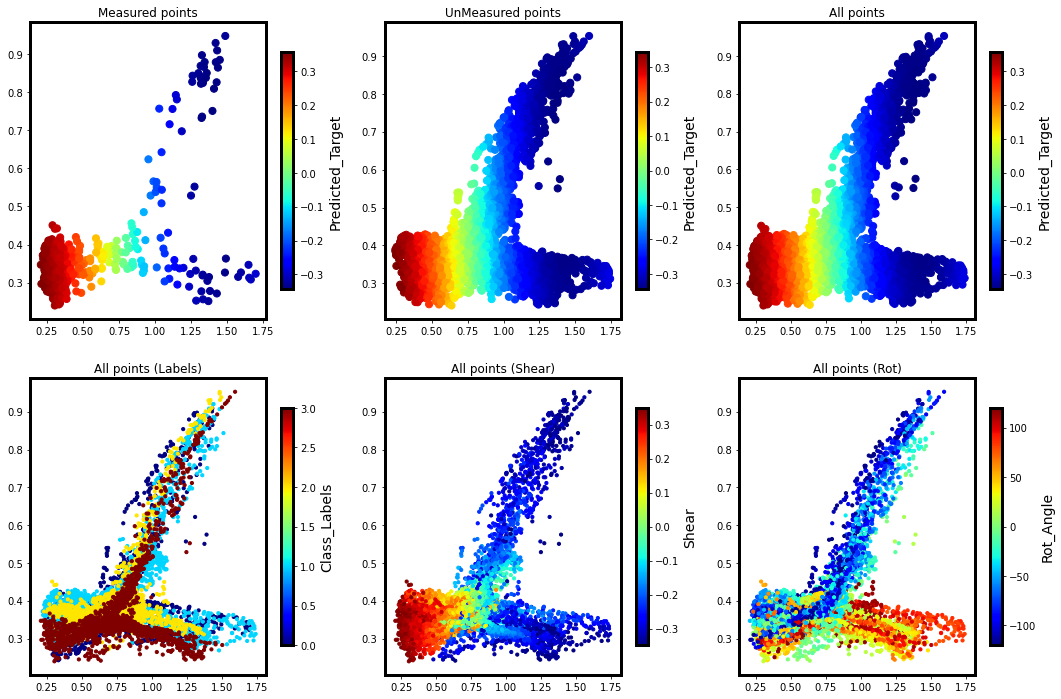

In [43]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=50, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=50,
                c = predmean_unmeas5, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=50, c = predmean15, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Case-6, Continuous targets
Target Function: Rotations

In [44]:
# First we will run the DKL on the whole dataset in one go
X6 = np.copy(X)   # Copying the entire input dataset
targets6 = np.copy(angles_all) # Preparing the targets/outputs

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

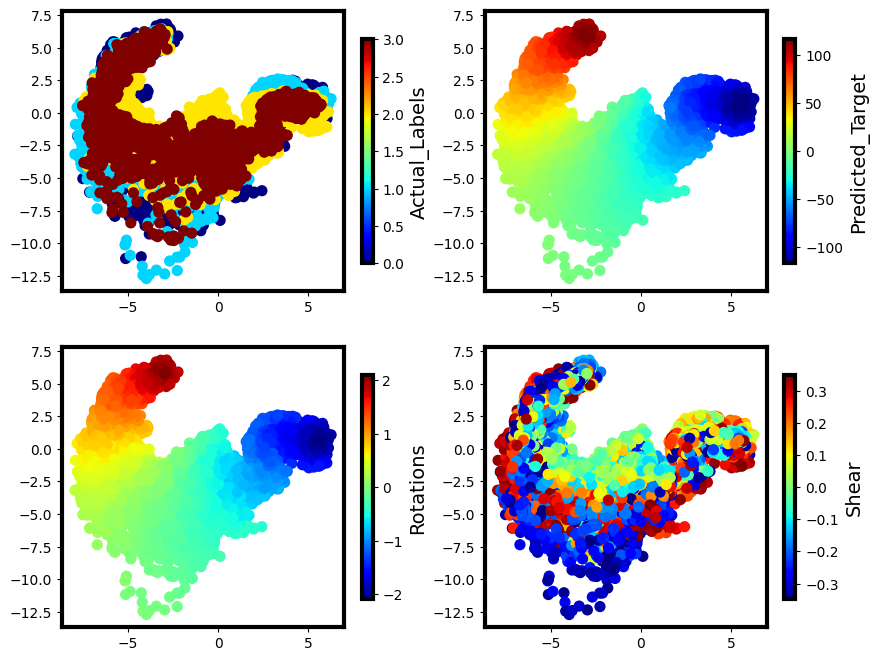

In [ ]:
# Running the DKL on the whole dataset
rng_key_6, rng_key_predict_6 = gpax.utils.get_keys()
dkl_6 = gpax.viDKL(900, 2, 'RBF')
dkl_6.fit(rng_key_6, X, targets6)

# Latent space Embedding and prediction on the whole input dataset
embeded_6 = dkl_6.embed(X)
pred_mean6, pred_var6 = dkl_6.predict_in_batches(rng_key_predict_6, X, batch_size=250)
pred_std6 = jnp.sqrt(pred_var6)

# Visualization of latent space distributions
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = pred_mean6, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO
X6 = np.copy(X)
np.random.seed(0)
idx6 = np.random.choice(np.arange(len(X6)), size = 100, replace = False)
X6_train = X6[idx6]
X6_unmeasured = np.delete(X6, idx6, axis=0)

indices_total_6 = np.arange(len(X))
indices_train_6 = indices_total_6[idx6]
y6_train = targets6[idx6]
indices_unmeasured_6 = np.delete(indices_total_6, idx6)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean6, exp_std6 = [], []
dkl_mean6, dkl_std6 = [], []
embed_traj6 = []
traj_mean6, traj_std6 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key16, rng_key_predict16 = gpax.utils.get_keys()
    dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_6.fit(rng_key16, X6_train, y6_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean6.append(y_mean[id_next])
    exp_std6.append(y_std[id_next])
    
    x_next = X6_unmeasured[id_next]
    ind_next = indices_unmeasured_6[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean6.append(pred_mean6[ind_next])
    dkl_std6.append(pred_std6[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets6[ind_next]
    
    # Update training arrays
    X6_train = np.append(X6_train, x_next[None], axis=0)
    y6_train = np.append(y6_train, y_measured)
    X6_unmeasured = np.delete(X6_unmeasured, id_next, axis=0)
    indices_unmeasured_6 = np.delete(indices_unmeasured_6, id_next)
    
    embed_traj = dkl_BO_6.embed(X6_train)
    traj_m, traj_s = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_train, batch_size=100)
    
    embed_traj6.append(embed_traj)
    traj_mean6.append(traj_m)

# Saving the results
rot_results = {}
rot_results['X_train'] = X6_train
rot_results['y_train'] = y6_train
rot_results['X_unmeasured'] = X6_unmeasured
rot_results['indices_unmeasured'] = indices_unmeasured_6
rot_results['dkl_mean'] = dkl_mean6
rot_results['dkl_std'] = dkl_std6
rot_results['exp_mean'] = exp_mean6
rot_results['exp_std'] = exp_std6
rot_results['traj_mean'] = traj_mean6
rot_results['traj_std'] = traj_std6
rot_results['embed_traj'] = embed_traj6

with open('rot_results.pickle', 'wb') as handle:
    pickle.dump(rot_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 417.27it/s, init loss: 212154.1570, avg. loss [9



Inferred GP kernel parameters
k_length         [2.5559 1.6546]
k_scale          5.9321
noise            2.5378000000000003

Step 2


100%|█| 1000/1000 [00:02<00:00, 417.36it/s, init loss: 216205.7133, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1178 1.5481]
k_scale          6.5071
noise            2.6845000000000003

Step 3


100%|█| 1000/1000 [00:02<00:00, 411.67it/s, init loss: 219384.5792, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3653 1.5902]
k_scale          6.343100000000001
noise            2.853

Step 4


100%|█| 1000/1000 [00:02<00:00, 397.95it/s, init loss: 220844.6065, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2887 1.5441]
k_scale          8.0162
noise            4.4023

Step 5


100%|█| 1000/1000 [00:02<00:00, 404.73it/s, init loss: 221424.9857, avg. loss [9



Inferred GP kernel parameters
k_length         [2.362  1.5738]
k_scale          5.3993
noise            3.0701

Step 6


100%|█| 1000/1000 [00:02<00:00, 406.71it/s, init loss: 223512.1364, avg. loss [9



Inferred GP kernel parameters
k_length         [2.4177 1.702 ]
k_scale          6.699000000000001
noise            3.1281000000000003

Step 7


100%|█| 1000/1000 [00:02<00:00, 405.90it/s, init loss: 226566.9726, avg. loss [9



Inferred GP kernel parameters
k_length         [2.4105 1.6445]
k_scale          6.0213
noise            2.791

Step 8


100%|█| 1000/1000 [00:02<00:00, 349.56it/s, init loss: 228021.7903, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2493 1.4934]
k_scale          6.6874
noise            2.8431

Step 9


100%|█| 1000/1000 [00:02<00:00, 403.56it/s, init loss: 228231.0906, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3983 1.5826]
k_scale          5.4583
noise            2.8954

Step 10


100%|█| 1000/1000 [00:02<00:00, 405.04it/s, init loss: 233505.8362, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3618 1.6848]
k_scale          6.5869
noise            2.9735

Step 11


100%|█| 1000/1000 [00:02<00:00, 405.69it/s, init loss: 236603.2894, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2194 1.6089]
k_scale          6.2138
noise            2.8799

Step 12


100%|█| 1000/1000 [00:02<00:00, 345.08it/s, init loss: 237333.0477, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3545 1.6021]
k_scale          5.2927
noise            2.5257

Step 13


100%|█| 1000/1000 [00:02<00:00, 404.83it/s, init loss: 238395.9419, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3107 1.5698]
k_scale          6.8091
noise            2.8462

Step 14


100%|█| 1000/1000 [00:02<00:00, 403.91it/s, init loss: 242233.5786, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1085 1.4323]
k_scale          6.855300000000001
noise            4.2064

Step 15


100%|█| 1000/1000 [00:02<00:00, 403.65it/s, init loss: 242913.6818, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3958 1.5193]
k_scale          7.870900000000001
noise            3.0153000000000003

Step 16


100%|█| 1000/1000 [00:02<00:00, 383.47it/s, init loss: 244178.8021, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2908 1.5468]
k_scale          6.0391
noise            2.6405000000000003

Step 17


100%|█| 1000/1000 [00:02<00:00, 401.03it/s, init loss: 247940.6136, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2002 1.6871]
k_scale          5.146100000000001
noise            2.7493000000000003

Step 18


100%|█| 1000/1000 [00:02<00:00, 404.31it/s, init loss: 253078.5720, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1663 1.5867]
k_scale          5.8856
noise            2.5903

Step 19


100%|█| 1000/1000 [00:02<00:00, 410.00it/s, init loss: 256698.1517, avg. loss [9



Inferred GP kernel parameters
k_length         [2.007  1.6374]
k_scale          5.0776
noise            2.6002

Step 20


100%|█| 1000/1000 [00:03<00:00, 332.35it/s, init loss: 261576.9544, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8795 1.4075]
k_scale          7.9264
noise            4.095400000000001

Step 21


100%|█| 1000/1000 [00:02<00:00, 407.18it/s, init loss: 264223.5970, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9964 1.3697]
k_scale          7.2157
noise            3.3954

Step 22


100%|█| 1000/1000 [00:02<00:00, 406.22it/s, init loss: 266974.5297, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9562 1.3808]
k_scale          6.1906
noise            3.7149

Step 23


100%|█| 1000/1000 [00:02<00:00, 405.65it/s, init loss: 267468.8867, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1675 1.526 ]
k_scale          4.8293
noise            2.3732

Step 24


100%|█| 1000/1000 [00:02<00:00, 335.61it/s, init loss: 269021.5804, avg. loss [9



Inferred GP kernel parameters
k_length         [2.279  1.4258]
k_scale          5.980700000000001
noise            3.1727000000000003

Step 25


100%|█| 1000/1000 [00:02<00:00, 409.21it/s, init loss: 269772.7492, avg. loss [9



Inferred GP kernel parameters
k_length         [2.163  1.4209]
k_scale          4.9632000000000005
noise            3.1844

Step 26


100%|█| 1000/1000 [00:02<00:00, 406.17it/s, init loss: 270182.4092, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0364 1.4447]
k_scale          7.3342
noise            4.1408000000000005

Step 27


100%|█| 1000/1000 [00:02<00:00, 405.48it/s, init loss: 272396.4328, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2187 1.3556]
k_scale          5.093
noise            3.0856000000000003

Step 28


100%|█| 1000/1000 [00:02<00:00, 341.53it/s, init loss: 272879.1745, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2846 1.4365]
k_scale          4.6601
noise            2.7103

Step 29


100%|█| 1000/1000 [00:02<00:00, 406.16it/s, init loss: 278818.4663, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1305 1.4492]
k_scale          5.0787
noise            2.5796

Step 30


100%|█| 1000/1000 [00:02<00:00, 394.81it/s, init loss: 281300.0430, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9816 1.4305]
k_scale          6.105300000000001
noise            3.3617000000000004

Step 31


100%|█| 1000/1000 [00:02<00:00, 400.53it/s, init loss: 281974.0129, avg. loss [9



Inferred GP kernel parameters
k_length         [1.936  1.4309]
k_scale          6.5252
noise            3.2470000000000003

Step 32


100%|█| 1000/1000 [00:03<00:00, 320.46it/s, init loss: 282033.5438, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1137 1.443 ]
k_scale          5.5157
noise            2.8126

Step 33


100%|█| 1000/1000 [00:02<00:00, 393.80it/s, init loss: 285368.4471, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8958 1.3368]
k_scale          6.6302
noise            3.5928

Step 34


100%|█| 1000/1000 [00:02<00:00, 392.74it/s, init loss: 286208.1932, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0754 1.3382]
k_scale          6.2095
noise            3.101

Step 35


100%|█| 1000/1000 [00:02<00:00, 388.97it/s, init loss: 287979.3771, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9966 1.3581]
k_scale          6.249700000000001
noise            3.1739

Step 36


100%|█| 1000/1000 [00:03<00:00, 327.98it/s, init loss: 288925.8963, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0975 1.5259]
k_scale          4.1226
noise            2.3018

Step 37


100%|█| 1000/1000 [00:02<00:00, 392.24it/s, init loss: 290098.3650, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0974 1.4112]
k_scale          4.5622
noise            2.6544000000000003

Step 38


100%|█| 1000/1000 [00:02<00:00, 389.94it/s, init loss: 290776.1339, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9632 1.347 ]
k_scale          5.919700000000001
noise            3.4645

Step 39


100%|█| 1000/1000 [00:02<00:00, 391.27it/s, init loss: 291011.9789, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1579 1.3641]
k_scale          6.1025
noise            3.1347

Step 40


100%|█| 1000/1000 [00:02<00:00, 390.10it/s, init loss: 292955.9757, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0791 1.3811]
k_scale          5.6862
noise            3.1179

Step 41


100%|█| 1000/1000 [00:02<00:00, 386.19it/s, init loss: 293247.2497, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0172 1.3481]
k_scale          6.4105
noise            3.8995

Step 42


100%|█| 1000/1000 [00:02<00:00, 390.55it/s, init loss: 293480.0721, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9539 1.5225]
k_scale          5.8951
noise            3.0314

Step 43


100%|█| 1000/1000 [00:02<00:00, 390.09it/s, init loss: 293815.9852, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0593 1.4277]
k_scale          5.5324
noise            2.9181000000000004

Step 44


100%|█| 1000/1000 [00:02<00:00, 407.31it/s, init loss: 294167.8273, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0421 1.465 ]
k_scale          5.4350000000000005
noise            3.0719000000000003

Step 45


100%|█| 1000/1000 [00:02<00:00, 392.01it/s, init loss: 296984.1904, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1177 1.5262]
k_scale          4.7095
noise            2.9439

Step 46


100%|█| 1000/1000 [00:02<00:00, 394.87it/s, init loss: 296987.7188, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9219 1.4695]
k_scale          6.3986
noise            4.1591000000000005

Step 47


100%|█| 1000/1000 [00:02<00:00, 394.55it/s, init loss: 297518.8997, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1249 1.3885]
k_scale          6.5840000000000005
noise            3.113

Step 48


100%|█| 1000/1000 [00:02<00:00, 395.50it/s, init loss: 298131.0329, avg. loss [9



Inferred GP kernel parameters
k_length         [2.331  1.4808]
k_scale          4.8259
noise            2.7336

Step 49


100%|█| 1000/1000 [00:02<00:00, 389.72it/s, init loss: 299404.5768, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9839 1.4066]
k_scale          6.3993
noise            3.0671

Step 50


100%|█| 1000/1000 [00:02<00:00, 401.82it/s, init loss: 300190.1635, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9151 1.3597]
k_scale          5.7415
noise            3.0595000000000003

Step 51


100%|█| 1000/1000 [00:02<00:00, 399.66it/s, init loss: 302025.4605, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9022 1.364 ]
k_scale          6.1921
noise            3.2418

Step 52


100%|█| 1000/1000 [00:02<00:00, 394.88it/s, init loss: 305177.1018, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9163 1.4489]
k_scale          5.1447
noise            2.6327000000000003

Step 53


100%|█| 1000/1000 [00:02<00:00, 389.09it/s, init loss: 307508.5128, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9519 1.5634]
k_scale          5.4669
noise            3.0177

Step 54


100%|█| 1000/1000 [00:02<00:00, 395.09it/s, init loss: 308070.5739, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8873 1.2799]
k_scale          6.2574000000000005
noise            3.3731

Step 55


100%|█| 1000/1000 [00:02<00:00, 397.99it/s, init loss: 309820.9120, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9383 1.4274]
k_scale          5.9945
noise            3.1357

Step 56


100%|█| 1000/1000 [00:02<00:00, 397.57it/s, init loss: 310494.3344, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0128 1.4078]
k_scale          6.1399
noise            3.3982

Step 57


100%|█| 1000/1000 [00:02<00:00, 378.11it/s, init loss: 310690.5463, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9815 1.5025]
k_scale          5.945200000000001
noise            3.1765000000000003

Step 58


100%|█| 1000/1000 [00:02<00:00, 394.45it/s, init loss: 311570.6455, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1512 1.4908]
k_scale          4.8226
noise            2.7076000000000002

Step 59


100%|█| 1000/1000 [00:02<00:00, 393.84it/s, init loss: 313059.1876, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8111 1.3587]
k_scale          6.347
noise            4.072

Step 60


100%|█| 1000/1000 [00:02<00:00, 394.97it/s, init loss: 313332.0917, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9305 1.4433]
k_scale          5.165
noise            2.9665000000000004

Step 61


100%|█| 1000/1000 [00:02<00:00, 335.58it/s, init loss: 314514.6695, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9023 1.4103]
k_scale          5.5063
noise            2.9351000000000003

Step 62


100%|█| 1000/1000 [00:02<00:00, 393.37it/s, init loss: 317686.1219, avg. loss [9



Inferred GP kernel parameters
k_length         [1.902  1.3093]
k_scale          6.575
noise            4.1044

Step 63


100%|█| 1000/1000 [00:02<00:00, 399.22it/s, init loss: 320023.9897, avg. loss [9



Inferred GP kernel parameters
k_length         [1.97   1.3464]
k_scale          4.638
noise            2.5739

Step 64


100%|█| 1000/1000 [00:02<00:00, 395.74it/s, init loss: 322220.4958, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0258 1.5834]
k_scale          4.222700000000001
noise            2.2954000000000003

Step 65


100%|█| 1000/1000 [00:02<00:00, 394.14it/s, init loss: 323896.2539, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9102 1.4985]
k_scale          4.6702
noise            2.6372

Step 66


100%|█| 1000/1000 [00:02<00:00, 389.87it/s, init loss: 324497.0802, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0371 1.4535]
k_scale          4.6696
noise            2.1755

Step 67


100%|█| 1000/1000 [00:02<00:00, 393.59it/s, init loss: 325939.2350, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9751 1.3825]
k_scale          5.683
noise            2.7459000000000002

Step 68


100%|█| 1000/1000 [00:02<00:00, 396.86it/s, init loss: 326701.2076, avg. loss [9



Inferred GP kernel parameters
k_length         [1.917  1.3314]
k_scale          6.2674
noise            3.2786

Step 69


100%|█| 1000/1000 [00:02<00:00, 395.50it/s, init loss: 327979.8408, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9911 1.3377]
k_scale          6.0242
noise            3.0807

Step 70


100%|█| 1000/1000 [00:02<00:00, 391.59it/s, init loss: 329343.9554, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8248 1.3816]
k_scale          6.2415
noise            3.6458000000000004

Step 71


100%|█| 1000/1000 [00:02<00:00, 391.00it/s, init loss: 330055.9030, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1644 1.4893]
k_scale          4.8662
noise            2.5846

Step 72


100%|█| 1000/1000 [00:02<00:00, 386.88it/s, init loss: 330336.7005, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0662 1.3732]
k_scale          4.6931
noise            2.6857

Step 73


100%|█| 1000/1000 [00:02<00:00, 400.65it/s, init loss: 332296.2022, avg. loss [9



Inferred GP kernel parameters
k_length         [1.933  1.3018]
k_scale          6.3377
noise            3.3419000000000003

Step 74


100%|█| 1000/1000 [00:03<00:00, 324.25it/s, init loss: 333805.4549, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9072 1.3592]
k_scale          5.8264000000000005
noise            3.5592

Step 75


100%|█| 1000/1000 [00:02<00:00, 396.53it/s, init loss: 333987.6944, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1615 1.3568]
k_scale          4.2549
noise            2.5606

Step 76


100%|█| 1000/1000 [00:02<00:00, 394.44it/s, init loss: 334608.0004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9263 1.3493]
k_scale          5.2507
noise            3.4789000000000003

Step 77


100%|█| 1000/1000 [00:02<00:00, 399.23it/s, init loss: 334854.9146, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8313 1.3998]
k_scale          5.8790000000000004
noise            3.313

Step 78


100%|█| 1000/1000 [00:03<00:00, 330.69it/s, init loss: 336682.8041, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8756 1.4799]
k_scale          4.5241
noise            2.8954

Step 79


100%|█| 1000/1000 [00:02<00:00, 392.21it/s, init loss: 336920.5914, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9176 1.3378]
k_scale          6.090800000000001
noise            3.4235

Step 80


100%|█| 1000/1000 [00:02<00:00, 396.38it/s, init loss: 337596.8691, avg. loss [9



Inferred GP kernel parameters
k_length         [1.879  1.3336]
k_scale          5.8266
noise            3.5016000000000003

Step 81


100%|█| 1000/1000 [00:02<00:00, 396.57it/s, init loss: 338153.4558, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9839 1.3373]
k_scale          5.792800000000001
noise            2.7499000000000002

Step 82


100%|█| 1000/1000 [00:02<00:00, 396.68it/s, init loss: 338897.8317, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0495 1.363 ]
k_scale          5.7865
noise            3.117

Step 83


100%|█| 1000/1000 [00:02<00:00, 391.52it/s, init loss: 339348.1597, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9145 1.3781]
k_scale          5.7953
noise            3.3928000000000003

Step 84


100%|█| 1000/1000 [00:02<00:00, 396.78it/s, init loss: 339400.6634, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9833 1.3498]
k_scale          5.6557
noise            3.3702

Step 85


100%|█| 1000/1000 [00:02<00:00, 397.75it/s, init loss: 340295.6111, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9123 1.3342]
k_scale          5.7876
noise            3.226

Step 86


100%|█| 1000/1000 [00:02<00:00, 393.90it/s, init loss: 342279.6526, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7972 1.3058]
k_scale          6.7414000000000005
noise            3.8759

Step 87


100%|█| 1000/1000 [00:02<00:00, 387.59it/s, init loss: 342830.0928, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9092 1.2896]
k_scale          6.306900000000001
noise            3.7852

Step 88


100%|█| 1000/1000 [00:02<00:00, 392.28it/s, init loss: 344777.8903, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0016 1.4422]
k_scale          5.0098
noise            2.729

Step 89


100%|█| 1000/1000 [00:02<00:00, 392.38it/s, init loss: 345136.9770, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9735 1.3496]
k_scale          5.4874
noise            3.0501

Step 90


100%|█| 1000/1000 [00:02<00:00, 392.09it/s, init loss: 346617.7825, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9726 1.3792]
k_scale          4.8862000000000005
noise            3.0115000000000003

Step 91


100%|█| 1000/1000 [00:02<00:00, 334.48it/s, init loss: 348921.2528, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8739 1.4312]
k_scale          5.929200000000001
noise            3.2334

Step 92


100%|█| 1000/1000 [00:02<00:00, 394.59it/s, init loss: 352821.7948, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8672 1.3031]
k_scale          6.479100000000001
noise            3.8729

Step 93


100%|█| 1000/1000 [00:02<00:00, 393.61it/s, init loss: 352952.1352, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9627 1.3804]
k_scale          6.0731
noise            3.5404

Step 94


100%|█| 1000/1000 [00:02<00:00, 389.72it/s, init loss: 353066.7147, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9619 1.3392]
k_scale          5.9996
noise            3.3078000000000003

Step 95


100%|█| 1000/1000 [00:03<00:00, 330.98it/s, init loss: 354000.4198, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8895 1.3567]
k_scale          6.4382
noise            3.3718000000000004

Step 96


100%|█| 1000/1000 [00:02<00:00, 391.82it/s, init loss: 355214.9010, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8999 1.3115]
k_scale          5.8494
noise            3.4642

Step 97


100%|█| 1000/1000 [00:02<00:00, 391.83it/s, init loss: 357461.3768, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9194 1.338 ]
k_scale          6.037
noise            3.4322000000000004

Step 98


100%|█| 1000/1000 [00:02<00:00, 391.32it/s, init loss: 360086.3086, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9196 1.3923]
k_scale          6.1763
noise            2.6104000000000003

Step 99


100%|█| 1000/1000 [00:02<00:00, 390.56it/s, init loss: 364638.7171, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9445 1.3532]
k_scale          5.6988
noise            2.7302

Step 100


100%|█| 1000/1000 [00:02<00:00, 385.44it/s, init loss: 364728.7134, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9352 1.4543]
k_scale          5.3221
noise            2.4747

Step 101


100%|█| 1000/1000 [00:02<00:00, 391.41it/s, init loss: 365259.4332, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8152 1.4383]
k_scale          4.7064
noise            2.4889

Step 102


100%|█| 1000/1000 [00:02<00:00, 389.09it/s, init loss: 370267.8336, avg. loss [9



Inferred GP kernel parameters
k_length         [1.928  1.3408]
k_scale          5.9468000000000005
noise            3.0057

Step 103


100%|█| 1000/1000 [00:02<00:00, 390.25it/s, init loss: 370887.3222, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9197 1.3896]
k_scale          6.3159
noise            3.0466

Step 104


100%|█| 1000/1000 [00:02<00:00, 333.42it/s, init loss: 371763.5948, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9324 1.3988]
k_scale          5.4938
noise            2.8561

Step 105


100%|█| 1000/1000 [00:02<00:00, 390.34it/s, init loss: 372615.2439, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9536 1.3982]
k_scale          5.923100000000001
noise            2.9582

Step 106


100%|█| 1000/1000 [00:02<00:00, 391.11it/s, init loss: 372674.0789, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7986 1.3687]
k_scale          6.309200000000001
noise            3.5604

Step 107


100%|█| 1000/1000 [00:02<00:00, 390.32it/s, init loss: 373192.8567, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7651 1.2605]
k_scale          6.7079
noise            3.9567

Step 108


100%|█| 1000/1000 [00:02<00:00, 389.82it/s, init loss: 374356.0103, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8326 1.3005]
k_scale          6.3199000000000005
noise            3.5668

Step 109


100%|█| 1000/1000 [00:02<00:00, 384.77it/s, init loss: 375068.5022, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9978 1.394 ]
k_scale          5.9912
noise            3.4437

Step 110


100%|█| 1000/1000 [00:02<00:00, 386.54it/s, init loss: 375524.7695, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0309 1.2832]
k_scale          6.2653
noise            3.3535000000000004

Step 111


100%|█| 1000/1000 [00:02<00:00, 384.55it/s, init loss: 379163.7514, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8318 1.3454]
k_scale          6.7446
noise            3.7731000000000003

Step 112


100%|█| 1000/1000 [00:02<00:00, 387.36it/s, init loss: 379218.8673, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9893 1.4033]
k_scale          5.5128
noise            3.1083000000000003

Step 113


100%|█| 1000/1000 [00:03<00:00, 329.19it/s, init loss: 380036.7807, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0023 1.3785]
k_scale          6.435700000000001
noise            3.2781000000000002

Step 114


100%|█| 1000/1000 [00:02<00:00, 390.14it/s, init loss: 381398.8981, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9494 1.3554]
k_scale          6.0347
noise            3.2968

Step 115


100%|█| 1000/1000 [00:02<00:00, 392.34it/s, init loss: 382957.0081, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8109 1.3854]
k_scale          6.341200000000001
noise            3.7067

Step 116


100%|█| 1000/1000 [00:02<00:00, 391.72it/s, init loss: 384600.1819, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9176 1.3051]
k_scale          6.1315
noise            3.1479000000000004

Step 117


100%|█| 1000/1000 [00:03<00:00, 328.46it/s, init loss: 384678.5537, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9209 1.386 ]
k_scale          5.649900000000001
noise            3.2190000000000003

Step 118


100%|█| 1000/1000 [00:02<00:00, 390.59it/s, init loss: 387715.7872, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8528 1.4415]
k_scale          5.5427
noise            2.8228

Step 119


100%|█| 1000/1000 [00:02<00:00, 385.65it/s, init loss: 388463.1315, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8813 1.3525]
k_scale          6.0484
noise            2.95

Step 120


100%|█| 1000/1000 [00:02<00:00, 386.94it/s, init loss: 389886.7622, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8265 1.3887]
k_scale          6.5797
noise            3.6043000000000003

Step 121


100%|█| 1000/1000 [00:02<00:00, 386.92it/s, init loss: 390817.8306, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8764 1.4459]
k_scale          5.6942
noise            3.2233

Step 122


100%|█| 1000/1000 [00:02<00:00, 377.48it/s, init loss: 391270.0922, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8888 1.4852]
k_scale          6.092300000000001
noise            3.1871

Step 123


100%|█| 1000/1000 [00:02<00:00, 383.03it/s, init loss: 391482.6318, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8965 1.3929]
k_scale          6.255
noise            3.0451

Step 124


100%|█| 1000/1000 [00:02<00:00, 384.78it/s, init loss: 392052.7647, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8982 1.3762]
k_scale          6.0697
noise            3.2574

Step 125


100%|█| 1000/1000 [00:02<00:00, 383.97it/s, init loss: 392167.0608, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8199 1.3368]
k_scale          6.1822
noise            3.5401000000000002

Step 126


100%|█| 1000/1000 [00:03<00:00, 329.61it/s, init loss: 395152.5680, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8241 1.3418]
k_scale          6.4297
noise            3.8041

Step 127


100%|█| 1000/1000 [00:02<00:00, 383.75it/s, init loss: 395827.3256, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9041 1.4974]
k_scale          5.5537
noise            2.6571000000000002

Step 128


100%|█| 1000/1000 [00:02<00:00, 383.77it/s, init loss: 399185.5668, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8355 1.3769]
k_scale          5.5
noise            2.9107000000000003

Step 129


100%|█| 1000/1000 [00:02<00:00, 384.16it/s, init loss: 399464.8618, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8308 1.3734]
k_scale          6.2203
noise            3.4736000000000002

Step 130


100%|█| 1000/1000 [00:03<00:00, 325.57it/s, init loss: 400558.2094, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9179 1.3756]
k_scale          5.6807
noise            3.2052

Step 131


100%|█| 1000/1000 [00:02<00:00, 385.32it/s, init loss: 401887.2114, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8784 1.351 ]
k_scale          5.733700000000001
noise            3.7630000000000003

Step 132


100%|█| 1000/1000 [00:02<00:00, 385.08it/s, init loss: 403262.9040, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9349 1.4602]
k_scale          4.8809000000000005
noise            2.6541

Step 133


100%|█| 1000/1000 [00:02<00:00, 386.63it/s, init loss: 405432.6159, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9227 1.3871]
k_scale          5.4769000000000005
noise            3.5709

Step 134


100%|█| 1000/1000 [00:02<00:00, 387.07it/s, init loss: 407829.3725, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9635 1.3689]
k_scale          6.0045
noise            3.1012

Step 135


100%|█| 1000/1000 [00:02<00:00, 372.91it/s, init loss: 408832.9046, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9721 1.4466]
k_scale          4.9964
noise            2.8032

Step 136


100%|█| 1000/1000 [00:02<00:00, 381.52it/s, init loss: 411340.0206, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8514 1.4389]
k_scale          5.858700000000001
noise            2.7219

Step 137


100%|█| 1000/1000 [00:02<00:00, 390.20it/s, init loss: 413934.6761, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9588 1.4802]
k_scale          5.0715
noise            3.0257

Step 138


100%|█| 1000/1000 [00:02<00:00, 388.77it/s, init loss: 414663.6651, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8931 1.4722]
k_scale          5.1805
noise            3.6411000000000002

Step 139


100%|█| 1000/1000 [00:03<00:00, 318.57it/s, init loss: 416251.2540, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0208 1.4289]
k_scale          5.6099000000000006
noise            3.0012000000000003

Step 140


100%|█| 1000/1000 [00:02<00:00, 385.91it/s, init loss: 417379.4020, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9174 1.5493]
k_scale          4.53
noise            2.7645

Step 141


100%|█| 1000/1000 [00:02<00:00, 386.97it/s, init loss: 417401.4754, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8622 1.4671]
k_scale          4.776
noise            3.2335000000000003

Step 142


100%|█| 1000/1000 [00:02<00:00, 386.39it/s, init loss: 417820.6677, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9135 1.3648]
k_scale          5.6401
noise            3.0928

Step 143


100%|█| 1000/1000 [00:02<00:00, 383.15it/s, init loss: 418024.7273, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9342 1.4714]
k_scale          4.4941
noise            2.5277000000000003

Step 144


100%|█| 1000/1000 [00:02<00:00, 382.69it/s, init loss: 418340.0189, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9597 1.3679]
k_scale          5.842300000000001
noise            3.3258

Step 145


100%|█| 1000/1000 [00:02<00:00, 386.14it/s, init loss: 421470.8041, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8577 1.3824]
k_scale          6.0353
noise            3.2744

Step 146


100%|█| 1000/1000 [00:02<00:00, 384.26it/s, init loss: 422211.2167, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9669 1.363 ]
k_scale          5.3346
noise            2.8364000000000003

Step 147


100%|█| 1000/1000 [00:02<00:00, 386.19it/s, init loss: 422217.4216, avg. loss [9



Inferred GP kernel parameters
k_length         [1.942  1.3532]
k_scale          5.868600000000001
noise            3.3065

Step 148


100%|█| 1000/1000 [00:02<00:00, 379.53it/s, init loss: 423386.2737, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8354 1.4077]
k_scale          5.1405
noise            3.2829

Step 149


100%|█| 1000/1000 [00:02<00:00, 384.49it/s, init loss: 425578.5512, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7813 1.3721]
k_scale          6.4051
noise            3.9653

Step 150


100%|█| 1000/1000 [00:02<00:00, 383.69it/s, init loss: 426491.4994, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8985 1.464 ]
k_scale          5.3452
noise            3.0752

Step 151


100%|█| 1000/1000 [00:02<00:00, 383.52it/s, init loss: 427155.5616, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9596 1.3583]
k_scale          5.1115
noise            2.8586

Step 152


100%|█| 1000/1000 [00:03<00:00, 319.08it/s, init loss: 429809.6278, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0659 1.4057]
k_scale          4.6872
noise            2.3462

Step 153


100%|█| 1000/1000 [00:02<00:00, 384.71it/s, init loss: 430462.9158, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8951 1.3887]
k_scale          5.7301
noise            2.9619

Step 154


100%|█| 1000/1000 [00:02<00:00, 387.49it/s, init loss: 433164.6970, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8798 1.3345]
k_scale          5.7834
noise            3.0529

Step 155


100%|█| 1000/1000 [00:02<00:00, 378.77it/s, init loss: 433427.7579, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7894 1.2901]
k_scale          6.0046
noise            3.8743000000000003

Step 156


100%|█| 1000/1000 [00:02<00:00, 384.33it/s, init loss: 434565.2343, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9181 1.4394]
k_scale          5.077500000000001
noise            2.6779

Step 157


100%|█| 1000/1000 [00:03<00:00, 310.60it/s, init loss: 436377.3529, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7518 1.3801]
k_scale          5.6985
noise            3.4917000000000002

Step 158


100%|█| 1000/1000 [00:02<00:00, 373.63it/s, init loss: 436924.3061, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8401 1.4108]
k_scale          5.5257000000000005
noise            3.0265

Step 159


100%|█| 1000/1000 [00:02<00:00, 379.18it/s, init loss: 437594.9839, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9174 1.4008]
k_scale          5.6346
noise            3.1714

Step 160


100%|█| 1000/1000 [00:02<00:00, 379.02it/s, init loss: 437792.1563, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9294 1.368 ]
k_scale          5.7611
noise            3.4071000000000002

Step 161


100%|█| 1000/1000 [00:02<00:00, 381.48it/s, init loss: 438628.3373, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7928 1.3116]
k_scale          6.074400000000001
noise            4.498200000000001

Step 162


100%|█| 1000/1000 [00:02<00:00, 379.12it/s, init loss: 439257.2125, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8731 1.3511]
k_scale          5.8786000000000005
noise            3.3118000000000003

Step 163


100%|█| 1000/1000 [00:02<00:00, 383.27it/s, init loss: 441001.1952, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3197 1.6116]
k_scale          4.9002
noise            3.0896000000000003

Step 164


100%|█| 1000/1000 [00:02<00:00, 382.11it/s, init loss: 441504.0605, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9091 1.4971]
k_scale          4.7493
noise            2.9002000000000003

Step 165


100%|█| 1000/1000 [00:02<00:00, 379.69it/s, init loss: 442795.6775, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8374 1.4319]
k_scale          5.782100000000001
noise            3.4907000000000004

Step 166


100%|█| 1000/1000 [00:02<00:00, 367.16it/s, init loss: 447737.4946, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8642 1.4615]
k_scale          5.4626
noise            2.9892000000000003

Step 167


100%|█| 1000/1000 [00:02<00:00, 379.19it/s, init loss: 449534.0567, avg. loss [9



Inferred GP kernel parameters
k_length         [1.941  1.5054]
k_scale          4.6203
noise            2.6426000000000003

Step 168


100%|█| 1000/1000 [00:02<00:00, 379.00it/s, init loss: 450369.6343, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9914 1.4367]
k_scale          5.7228
noise            3.0100000000000002

Step 169


100%|█| 1000/1000 [00:02<00:00, 378.66it/s, init loss: 451281.5567, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1223 1.4509]
k_scale          5.586
noise            2.6205000000000003

Step 170


100%|█| 1000/1000 [00:03<00:00, 322.90it/s, init loss: 453591.7004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9932 1.5203]
k_scale          5.3519000000000005
noise            2.8157

Step 171


100%|█| 1000/1000 [00:02<00:00, 377.92it/s, init loss: 455405.5599, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8989 1.4249]
k_scale          6.1067
noise            3.4287

Step 172


100%|█| 1000/1000 [00:02<00:00, 378.56it/s, init loss: 456048.6482, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9136 1.4081]
k_scale          6.6028
noise            3.3862

Step 173


100%|█| 1000/1000 [00:02<00:00, 377.97it/s, init loss: 457517.8046, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0227 1.3779]
k_scale          5.4932
noise            2.8675

Step 174


100%|█| 1000/1000 [00:02<00:00, 376.15it/s, init loss: 457529.5082, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1065 1.4481]
k_scale          5.364
noise            2.8175000000000003

Step 175


100%|█| 1000/1000 [00:02<00:00, 368.25it/s, init loss: 457803.6481, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0448 1.3941]
k_scale          5.9667
noise            2.943

Step 176


100%|█| 1000/1000 [00:02<00:00, 376.83it/s, init loss: 458382.8458, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0643 1.3951]
k_scale          6.1021
noise            2.8262

Step 177


100%|█| 1000/1000 [00:02<00:00, 377.67it/s, init loss: 461265.2152, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8845 1.439 ]
k_scale          5.5966000000000005
noise            2.983

Step 178


100%|█| 1000/1000 [00:02<00:00, 376.63it/s, init loss: 462330.9452, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9397 1.3408]
k_scale          6.130400000000001
noise            3.9474

Step 179


100%|█| 1000/1000 [00:03<00:00, 318.20it/s, init loss: 462392.5426, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0061 1.4671]
k_scale          5.4007000000000005
noise            2.7426

Step 180


100%|█| 1000/1000 [00:02<00:00, 373.91it/s, init loss: 462902.4742, avg. loss [9



Inferred GP kernel parameters
k_length         [1.99   1.5036]
k_scale          5.1846000000000005
noise            2.66

Step 181


100%|█| 1000/1000 [00:02<00:00, 377.90it/s, init loss: 463925.9447, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9245 1.3707]
k_scale          5.4168
noise            3.4056

Step 182


100%|█| 1000/1000 [00:02<00:00, 374.91it/s, init loss: 465642.5366, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8102 1.3473]
k_scale          5.6962
noise            3.0382000000000002

Step 183


100%|█| 1000/1000 [00:02<00:00, 373.90it/s, init loss: 470654.5366, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8584 1.3449]
k_scale          6.0257000000000005
noise            3.5688

Step 184


100%|█| 1000/1000 [00:03<00:00, 310.73it/s, init loss: 472452.7288, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8971 1.425 ]
k_scale          5.2911
noise            3.0326

Step 185


100%|█| 1000/1000 [00:02<00:00, 371.35it/s, init loss: 474424.3934, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9622 1.4591]
k_scale          4.844
noise            2.4584

Step 186


100%|█| 1000/1000 [00:02<00:00, 371.36it/s, init loss: 475167.2155, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9506 1.482 ]
k_scale          4.599600000000001
noise            2.4289

Step 187


100%|█| 1000/1000 [00:02<00:00, 372.18it/s, init loss: 475371.2202, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8968 1.4019]
k_scale          5.8053
noise            2.8866

Step 188


100%|█| 1000/1000 [00:02<00:00, 372.77it/s, init loss: 477891.4124, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9448 1.4299]
k_scale          5.7975
noise            2.7453000000000003

Step 189


100%|█| 1000/1000 [00:03<00:00, 306.15it/s, init loss: 481840.4112, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0618 1.5184]
k_scale          4.484500000000001
noise            2.2156000000000002

Step 190


100%|█| 1000/1000 [00:02<00:00, 370.31it/s, init loss: 482182.2685, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0181 1.4434]
k_scale          5.481800000000001
noise            2.6300000000000003

Step 191


100%|█| 1000/1000 [00:02<00:00, 371.19it/s, init loss: 482386.9987, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9742 1.401 ]
k_scale          4.5497000000000005
noise            2.4185000000000003

Step 192


100%|█| 1000/1000 [00:02<00:00, 373.52it/s, init loss: 495841.9466, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9751 1.4318]
k_scale          4.8142000000000005
noise            2.3139000000000003

Step 193


100%|█| 1000/1000 [00:02<00:00, 374.74it/s, init loss: 496161.9024, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1078 1.4708]
k_scale          4.7874
noise            2.3513

Step 194


100%|█| 1000/1000 [00:02<00:00, 355.39it/s, init loss: 496176.7855, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0294 1.4388]
k_scale          5.5715
noise            2.5556

Step 195


100%|█| 1000/1000 [00:02<00:00, 374.82it/s, init loss: 497205.7611, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9137 1.3959]
k_scale          4.964700000000001
noise            2.3704

Step 196


100%|█| 1000/1000 [00:02<00:00, 376.86it/s, init loss: 497309.0358, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8231 1.4855]
k_scale          5.5008
noise            2.6393

Step 197


100%|█| 1000/1000 [00:02<00:00, 374.16it/s, init loss: 497723.7037, avg. loss [9



Inferred GP kernel parameters
k_length         [2.068  1.4591]
k_scale          4.9407000000000005
noise            2.7155

Step 198


100%|█| 1000/1000 [00:03<00:00, 315.25it/s, init loss: 498748.4191, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9516 1.4141]
k_scale          4.7788
noise            2.2817000000000003

Step 199


100%|█| 1000/1000 [00:02<00:00, 374.19it/s, init loss: 500040.2409, avg. loss [9



Inferred GP kernel parameters
k_length         [1.893  1.4304]
k_scale          5.2957
noise            3.1345

Step 200


100%|█| 1000/1000 [00:02<00:00, 370.42it/s, init loss: 501455.3243, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9024 1.4822]
k_scale          4.6147
noise            2.4615

Step 201


100%|█| 1000/1000 [00:02<00:00, 372.64it/s, init loss: 501869.1077, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9214 1.4438]
k_scale          5.123600000000001
noise            2.6741

Step 202


100%|█| 1000/1000 [00:02<00:00, 375.67it/s, init loss: 502990.0889, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9461 1.4716]
k_scale          4.6695
noise            2.585

Step 203


100%|█| 1000/1000 [00:02<00:00, 364.74it/s, init loss: 503576.3452, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0221 1.4089]
k_scale          5.546200000000001
noise            2.8271

Step 204


100%|█| 1000/1000 [00:02<00:00, 371.94it/s, init loss: 504273.8205, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9786 1.3894]
k_scale          6.2437000000000005
noise            3.1866000000000003

Step 205


100%|█| 1000/1000 [00:02<00:00, 373.04it/s, init loss: 504327.4257, avg. loss [9



Inferred GP kernel parameters
k_length         [1.904  1.3932]
k_scale          5.969
noise            3.2553

Step 206


100%|█| 1000/1000 [00:02<00:00, 373.12it/s, init loss: 505077.3763, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9285 1.3855]
k_scale          6.0254
noise            3.0449

Step 207


100%|█| 1000/1000 [00:03<00:00, 287.99it/s, init loss: 505519.2352, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9246 1.393 ]
k_scale          5.524900000000001
noise            2.8931

Step 208


100%|█| 1000/1000 [00:02<00:00, 363.23it/s, init loss: 506173.9712, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9176 1.4454]
k_scale          5.9089
noise            2.9851

Step 209


100%|█| 1000/1000 [00:02<00:00, 369.34it/s, init loss: 506856.4297, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9648 1.5197]
k_scale          4.5922
noise            2.3733

Step 210


100%|█| 1000/1000 [00:02<00:00, 372.25it/s, init loss: 509088.5895, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8917 1.4513]
k_scale          5.3078
noise            2.8915

Step 211


100%|█| 1000/1000 [00:02<00:00, 370.79it/s, init loss: 509976.8933, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8601 1.4079]
k_scale          5.9627
noise            3.0246

Step 212


100%|█| 1000/1000 [00:03<00:00, 296.04it/s, init loss: 510089.4288, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0386 1.518 ]
k_scale          4.2655
noise            2.4343

Step 213


100%|█| 1000/1000 [00:02<00:00, 362.67it/s, init loss: 511174.4029, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9204 1.3497]
k_scale          5.9257
noise            3.4324000000000003

Step 214


100%|█| 1000/1000 [00:02<00:00, 363.26it/s, init loss: 511808.4440, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8943 1.4688]
k_scale          3.9282000000000004
noise            2.4335

Step 215


100%|█| 1000/1000 [00:02<00:00, 369.24it/s, init loss: 514498.6482, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8816 1.4574]
k_scale          4.3465
noise            2.6249000000000002

Step 216


100%|█| 1000/1000 [00:02<00:00, 372.55it/s, init loss: 514568.1597, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9266 1.4471]
k_scale          4.2638
noise            2.6513

Step 217


100%|█| 1000/1000 [00:02<00:00, 361.72it/s, init loss: 516890.7337, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8595 1.3316]
k_scale          5.0722000000000005
noise            3.0784000000000002

Step 218


100%|█| 1000/1000 [00:02<00:00, 367.48it/s, init loss: 517029.2002, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9205 1.4425]
k_scale          3.9974000000000003
noise            2.7189

Step 219


100%|█| 1000/1000 [00:02<00:00, 368.39it/s, init loss: 517697.1974, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9949 1.4215]
k_scale          3.9627000000000003
noise            2.3022

Step 220


100%|█| 1000/1000 [00:02<00:00, 371.31it/s, init loss: 518003.3949, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9148 1.4083]
k_scale          4.649900000000001
noise            2.4092000000000002

Step 221


100%|█| 1000/1000 [00:03<00:00, 295.85it/s, init loss: 520871.1778, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8872 1.4078]
k_scale          5.1854000000000005
noise            2.9036

Step 222


100%|█| 1000/1000 [00:02<00:00, 356.72it/s, init loss: 522307.7307, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0131 1.4137]
k_scale          5.1567
noise            2.4121

Step 223


100%|█| 1000/1000 [00:02<00:00, 362.51it/s, init loss: 522827.5727, avg. loss [9



Inferred GP kernel parameters
k_length         [1.995  1.3832]
k_scale          4.5577000000000005
noise            2.4358

Step 224


100%|█| 1000/1000 [00:02<00:00, 364.36it/s, init loss: 523111.1805, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9163 1.363 ]
k_scale          4.8895
noise            2.7979000000000003

Step 225


100%|█| 1000/1000 [00:02<00:00, 365.25it/s, init loss: 525025.7075, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8812 1.4165]
k_scale          4.246700000000001
noise            2.4222

Step 226


100%|█| 1000/1000 [00:04<00:00, 237.94it/s, init loss: 526528.5799, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8124 1.3798]
k_scale          4.6553
noise            2.4757000000000002

Step 227


100%|█| 1000/1000 [00:02<00:00, 356.99it/s, init loss: 529426.6022, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8605 1.412 ]
k_scale          4.6916
noise            2.4887

Step 228


100%|█| 1000/1000 [00:02<00:00, 364.30it/s, init loss: 531252.4320, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7962 1.4073]
k_scale          5.6182
noise            3.1609000000000003

Step 229


100%|█| 1000/1000 [00:02<00:00, 363.22it/s, init loss: 534032.7264, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9013 1.3779]
k_scale          5.320600000000001
noise            2.6271

Step 230


100%|█| 1000/1000 [00:02<00:00, 364.94it/s, init loss: 534364.1195, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0178 1.5536]
k_scale          4.6925
noise            2.3966000000000003

Step 231


100%|█| 1000/1000 [00:02<00:00, 345.73it/s, init loss: 538091.4950, avg. loss [9



Inferred GP kernel parameters
k_length         [1.993  1.4091]
k_scale          4.1455
noise            2.1259

Step 232


100%|█| 1000/1000 [00:02<00:00, 358.79it/s, init loss: 538305.6603, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0328 1.4708]
k_scale          5.8664000000000005
noise            2.8579000000000003

Step 233


100%|█| 1000/1000 [00:02<00:00, 361.74it/s, init loss: 538373.7313, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9776 1.4011]
k_scale          4.774500000000001
noise            2.6731000000000003

Step 234


100%|█| 1000/1000 [00:02<00:00, 361.65it/s, init loss: 538858.6464, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9982 1.4261]
k_scale          3.9458
noise            2.5568

Step 235


100%|█| 1000/1000 [00:03<00:00, 292.76it/s, init loss: 539487.7401, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9966 1.4228]
k_scale          4.7734000000000005
noise            2.5142

Step 236


100%|█| 1000/1000 [00:02<00:00, 357.15it/s, init loss: 540162.0288, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9397 1.4354]
k_scale          3.8202000000000003
noise            2.2159

Step 237


100%|█| 1000/1000 [00:02<00:00, 361.34it/s, init loss: 541553.8067, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8834 1.3659]
k_scale          4.3507
noise            2.5228

Step 238


100%|█| 1000/1000 [00:02<00:00, 356.17it/s, init loss: 543736.0621, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8505 1.3909]
k_scale          4.2934
noise            2.4355

Step 239


100%|█| 1000/1000 [00:02<00:00, 362.64it/s, init loss: 543808.3297, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8789 1.4319]
k_scale          3.7389
noise            2.1798

Step 240


100%|█| 1000/1000 [00:03<00:00, 296.20it/s, init loss: 543900.2421, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8944 1.3839]
k_scale          4.2556
noise            2.5534000000000003

Step 241


100%|█| 1000/1000 [00:02<00:00, 342.26it/s, init loss: 544122.9573, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0161 1.4558]
k_scale          4.3425
noise            2.6347

Step 242


100%|█| 1000/1000 [00:02<00:00, 349.46it/s, init loss: 546817.5833, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0164 1.4507]
k_scale          5.060700000000001
noise            2.657

Step 243


100%|█| 1000/1000 [00:02<00:00, 355.60it/s, init loss: 548006.6795, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9834 1.4381]
k_scale          4.784
noise            2.8153

Step 244


100%|█| 1000/1000 [00:02<00:00, 358.88it/s, init loss: 548881.7173, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0045 1.4562]
k_scale          4.9590000000000005
noise            2.4341

Step 245


100%|█| 1000/1000 [00:02<00:00, 337.03it/s, init loss: 548902.8670, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9499 1.5345]
k_scale          4.3824000000000005
noise            2.2971

Step 246


100%|█| 1000/1000 [00:02<00:00, 346.62it/s, init loss: 549089.6603, avg. loss [9



Inferred GP kernel parameters
k_length         [2.163  1.5416]
k_scale          4.6886
noise            2.7445

Step 247


100%|█| 1000/1000 [00:02<00:00, 351.05it/s, init loss: 549491.1884, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0127 1.5093]
k_scale          4.7963000000000005
noise            2.3832

Step 248


100%|█| 1000/1000 [00:02<00:00, 355.01it/s, init loss: 558720.7078, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9512 1.4732]
k_scale          3.8133000000000004
noise            2.5291

Step 249


100%|█| 1000/1000 [00:02<00:00, 357.18it/s, init loss: 560260.9699, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9901 1.4024]
k_scale          4.9872000000000005
noise            2.7824

Step 250


100%|█| 1000/1000 [00:02<00:00, 340.42it/s, init loss: 562080.0050, avg. loss [9



Inferred GP kernel parameters
k_length         [1.969  1.5238]
k_scale          4.1944
noise            2.2048

Step 251


100%|█| 1000/1000 [00:02<00:00, 344.95it/s, init loss: 562200.4454, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0853 1.5075]
k_scale          4.4916
noise            2.4161

Step 252


100%|█| 1000/1000 [00:02<00:00, 352.46it/s, init loss: 562485.6649, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0738 1.3554]
k_scale          4.5238000000000005
noise            2.5101

Step 253


100%|█| 1000/1000 [00:02<00:00, 354.26it/s, init loss: 562755.9288, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9932 1.5093]
k_scale          4.2497
noise            2.2255000000000003

Step 254


100%|█| 1000/1000 [00:03<00:00, 295.33it/s, init loss: 565553.6186, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0231 1.394 ]
k_scale          3.7548000000000004
noise            2.1350000000000002

Step 255


100%|█| 1000/1000 [00:02<00:00, 342.05it/s, init loss: 565571.3418, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9514 1.4224]
k_scale          4.289000000000001
noise            2.2893

Step 256


100%|█| 1000/1000 [00:02<00:00, 352.16it/s, init loss: 568017.6890, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9946 1.3589]
k_scale          3.3539000000000003
noise            2.0867

Step 257


100%|█| 1000/1000 [00:02<00:00, 352.64it/s, init loss: 569390.0241, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8141 1.3529]
k_scale          4.4061
noise            2.3248

Step 258


100%|█| 1000/1000 [00:02<00:00, 353.56it/s, init loss: 572461.2723, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8815 1.3982]
k_scale          3.8367
noise            2.1516

Step 259


100%|█| 1000/1000 [00:03<00:00, 290.63it/s, init loss: 572578.7147, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8793 1.4164]
k_scale          4.3001000000000005
noise            2.1448

Step 260


100%|█| 1000/1000 [00:02<00:00, 342.02it/s, init loss: 573333.7327, avg. loss [9



Inferred GP kernel parameters
k_length         [1.88   1.3206]
k_scale          4.5838
noise            2.2998000000000003

Step 261


100%|█| 1000/1000 [00:02<00:00, 350.67it/s, init loss: 575074.5064, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8314 1.3785]
k_scale          4.3444
noise            2.658

Step 262


100%|█| 1000/1000 [00:02<00:00, 348.09it/s, init loss: 575215.4658, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9999 1.3844]
k_scale          4.3142000000000005
noise            2.5823

Step 263


100%|█| 1000/1000 [00:02<00:00, 350.63it/s, init loss: 575823.5995, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9316 1.4664]
k_scale          4.6014
noise            2.4466

Step 264


100%|█| 1000/1000 [00:03<00:00, 278.45it/s, init loss: 575909.5464, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9562 1.5307]
k_scale          3.9843
noise            2.0605

Step 265


100%|█| 1000/1000 [00:03<00:00, 331.79it/s, init loss: 578332.2278, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0083 1.454 ]
k_scale          4.022
noise            2.089

Step 266


100%|█| 1000/1000 [00:02<00:00, 340.15it/s, init loss: 579584.3618, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9709 1.5015]
k_scale          4.1535
noise            2.1855

Step 267


100%|█| 1000/1000 [00:02<00:00, 348.78it/s, init loss: 581879.3527, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9461 1.4258]
k_scale          3.7479
noise            2.2048

Step 268


100%|█| 1000/1000 [00:02<00:00, 355.04it/s, init loss: 583056.1061, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9585 1.4798]
k_scale          3.9201
noise            2.2677

Step 269


100%|█| 1000/1000 [00:03<00:00, 325.29it/s, init loss: 583539.8547, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9144 1.3645]
k_scale          4.5242
noise            2.769

Step 270


100%|█| 1000/1000 [00:02<00:00, 336.03it/s, init loss: 586018.0815, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9664 1.4037]
k_scale          4.6362000000000005
noise            2.4922

Step 271


100%|█| 1000/1000 [00:02<00:00, 345.62it/s, init loss: 588015.2665, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0015 1.4076]
k_scale          4.567
noise            2.4733

Step 272


100%|█| 1000/1000 [00:02<00:00, 352.67it/s, init loss: 588143.3249, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9271 1.3912]
k_scale          3.91
noise            2.2133000000000003

Step 273


100%|█| 1000/1000 [00:03<00:00, 281.08it/s, init loss: 588420.8741, avg. loss [9



Inferred GP kernel parameters
k_length         [1.951  1.3582]
k_scale          3.8376
noise            2.426

Step 274


100%|█| 1000/1000 [00:02<00:00, 334.13it/s, init loss: 589806.1410, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9172 1.4379]
k_scale          4.3943
noise            2.3106

Step 275


100%|█| 1000/1000 [00:02<00:00, 343.16it/s, init loss: 591495.3978, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9222 1.3962]
k_scale          4.2658000000000005
noise            2.3798

Step 276


100%|█| 1000/1000 [00:02<00:00, 349.48it/s, init loss: 594915.7420, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9799 1.4158]
k_scale          3.8879
noise            2.0625

Step 277


100%|█| 1000/1000 [00:02<00:00, 350.64it/s, init loss: 595076.6820, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0508 1.3998]
k_scale          4.4706
noise            2.3815

Step 278


100%|█| 1000/1000 [00:03<00:00, 283.37it/s, init loss: 602819.1317, avg. loss [9



Inferred GP kernel parameters
k_length         [2.034  1.4416]
k_scale          4.1242
noise            2.1888

Step 279


100%|█| 1000/1000 [00:03<00:00, 331.73it/s, init loss: 603970.4551, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8246 1.3783]
k_scale          4.9776
noise            3.0472

Step 280


100%|█| 1000/1000 [00:02<00:00, 339.91it/s, init loss: 607711.2449, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9724 1.391 ]
k_scale          4.0131000000000006
noise            2.4090000000000003

Step 281


100%|█| 1000/1000 [00:02<00:00, 347.46it/s, init loss: 607798.7342, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0394 1.3852]
k_scale          4.0246
noise            2.3514

Step 282


100%|█| 1000/1000 [00:02<00:00, 342.90it/s, init loss: 608951.0620, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0129 1.4946]
k_scale          4.7812
noise            2.5671

Step 283


100%|█| 1000/1000 [00:03<00:00, 320.69it/s, init loss: 611409.9241, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7962 1.3357]
k_scale          4.4755
noise            2.6713

Step 284


100%|█| 1000/1000 [00:03<00:00, 333.18it/s, init loss: 612092.1682, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8246 1.438 ]
k_scale          3.6195000000000004
noise            2.6354

Step 285


100%|█| 1000/1000 [00:02<00:00, 342.79it/s, init loss: 612104.0511, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9069 1.2789]
k_scale          5.2095
noise            2.9284000000000003

Step 286


100%|█| 1000/1000 [00:02<00:00, 344.66it/s, init loss: 613104.2742, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9515 1.3232]
k_scale          4.268400000000001
noise            2.5344

Step 287


100%|█| 1000/1000 [00:02<00:00, 344.52it/s, init loss: 613115.7004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8922 1.3581]
k_scale          4.314900000000001
noise            2.4489

Step 288


100%|█| 1000/1000 [00:03<00:00, 325.30it/s, init loss: 613419.2686, avg. loss [9



Inferred GP kernel parameters
k_length         [2.054  1.4775]
k_scale          4.6204
noise            2.5373

Step 289


100%|█| 1000/1000 [00:03<00:00, 331.96it/s, init loss: 614775.7779, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8426 1.3513]
k_scale          3.7984
noise            2.2653000000000003

Step 290


100%|█| 1000/1000 [00:02<00:00, 344.36it/s, init loss: 614800.0171, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9465 1.4364]
k_scale          3.2891000000000004
noise            2.0992

Step 291


100%|█| 1000/1000 [00:02<00:00, 343.30it/s, init loss: 617325.0817, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0287 1.3881]
k_scale          4.7122
noise            2.9011

Step 292


100%|█| 1000/1000 [00:03<00:00, 286.08it/s, init loss: 618345.9017, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8338 1.3918]
k_scale          4.1074
noise            2.6805000000000003

Step 293


100%|█| 1000/1000 [00:03<00:00, 332.99it/s, init loss: 618609.2288, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9551 1.4264]
k_scale          5.005
noise            2.5134000000000003

Step 294


100%|█| 1000/1000 [00:02<00:00, 343.62it/s, init loss: 619804.9011, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0482 1.3333]
k_scale          4.974600000000001
noise            2.6708000000000003

Step 295


100%|█| 1000/1000 [00:02<00:00, 340.26it/s, init loss: 620315.3972, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9248 1.5245]
k_scale          4.3998
noise            2.8512

Step 296


100%|█| 1000/1000 [00:02<00:00, 347.04it/s, init loss: 620347.4995, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9885 1.5281]
k_scale          4.0129
noise            2.2944

Step 297


100%|█| 1000/1000 [00:03<00:00, 279.20it/s, init loss: 622802.3092, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9483 1.4825]
k_scale          4.8211
noise            2.2985

Step 298


100%|█| 1000/1000 [00:02<00:00, 334.08it/s, init loss: 623777.2238, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9644 1.4372]
k_scale          3.4848000000000003
noise            2.1609000000000003

Step 299


100%|█| 1000/1000 [00:02<00:00, 338.55it/s, init loss: 627814.9625, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8694 1.4262]
k_scale          3.3985000000000003
noise            2.0238

Step 300


100%|█| 1000/1000 [00:02<00:00, 343.00it/s, init loss: 628823.0853, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9752 1.4432]
k_scale          4.7319
noise            2.4602

Step 301


100%|█| 1000/1000 [00:02<00:00, 342.87it/s, init loss: 631405.8612, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9083 1.4149]
k_scale          4.1961
noise            2.5715000000000003

Step 302


100%|█| 1000/1000 [00:03<00:00, 279.72it/s, init loss: 632973.0791, avg. loss [9



Inferred GP kernel parameters
k_length         [1.786  1.4525]
k_scale          3.8392000000000004
noise            2.4916

Step 303


100%|█| 1000/1000 [00:03<00:00, 329.57it/s, init loss: 633281.6854, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8976 1.3823]
k_scale          4.1654
noise            2.5424

Step 304


100%|█| 1000/1000 [00:02<00:00, 336.90it/s, init loss: 633285.8281, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9111 1.436 ]
k_scale          4.4952000000000005
noise            2.3186

Step 305


100%|█| 1000/1000 [00:02<00:00, 342.35it/s, init loss: 634921.3036, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9354 1.389 ]
k_scale          3.7131000000000003
noise            2.6214

Step 306


100%|█| 1000/1000 [00:02<00:00, 345.98it/s, init loss: 636258.6751, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9842 1.3717]
k_scale          4.3455
noise            2.7723

Step 307


100%|█| 1000/1000 [00:03<00:00, 322.42it/s, init loss: 636299.0121, avg. loss [9



Inferred GP kernel parameters
k_length         [1.856  1.3146]
k_scale          4.0051000000000005
noise            2.4212000000000002

Step 308


100%|█| 1000/1000 [00:03<00:00, 332.57it/s, init loss: 636344.4351, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9877 1.3677]
k_scale          3.3555
noise            2.1613

Step 309


100%|█| 1000/1000 [00:02<00:00, 339.98it/s, init loss: 637544.3454, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0121 1.3642]
k_scale          3.7214
noise            2.3608000000000002

Step 310


100%|█| 1000/1000 [00:02<00:00, 345.28it/s, init loss: 638854.7719, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9277 1.3099]
k_scale          4.1383
noise            2.5855

Step 311


100%|█| 1000/1000 [00:02<00:00, 343.60it/s, init loss: 638871.1380, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9674 1.3686]
k_scale          3.5684
noise            2.2899000000000003

Step 312


100%|█| 1000/1000 [00:03<00:00, 324.62it/s, init loss: 639328.2737, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9237 1.367 ]
k_scale          3.1534
noise            2.1075

Step 313


100%|█| 1000/1000 [00:03<00:00, 332.28it/s, init loss: 639396.7181, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9768 1.3058]
k_scale          4.464300000000001
noise            2.9043

Step 314


100%|█| 1000/1000 [00:02<00:00, 341.76it/s, init loss: 640955.9460, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0098 1.3616]
k_scale          3.1259
noise            1.9366

Step 315


100%|█| 1000/1000 [00:02<00:00, 344.13it/s, init loss: 642070.4390, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0048 1.4803]
k_scale          3.988
noise            2.0872

Step 316


100%|█| 1000/1000 [00:03<00:00, 283.07it/s, init loss: 645235.5669, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0129 1.3935]
k_scale          4.2285
noise            2.4806

Step 317


100%|█| 1000/1000 [00:03<00:00, 332.10it/s, init loss: 646817.1334, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9384 1.4277]
k_scale          4.591600000000001
noise            2.4421

Step 318


100%|█| 1000/1000 [00:02<00:00, 339.72it/s, init loss: 647222.0077, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0199 1.3889]
k_scale          3.5164
noise            2.4382

Step 319


100%|█| 1000/1000 [00:02<00:00, 344.99it/s, init loss: 647317.6144, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9547 1.4828]
k_scale          3.8885
noise            2.2832

Step 320


100%|█| 1000/1000 [00:02<00:00, 346.82it/s, init loss: 648390.8644, avg. loss [9



Inferred GP kernel parameters
k_length         [1.881  1.3707]
k_scale          4.7323
noise            2.573

Step 321


100%|█| 1000/1000 [00:03<00:00, 281.23it/s, init loss: 650035.8010, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0596 1.3519]
k_scale          3.5788
noise            2.3662

Step 322


100%|█| 1000/1000 [00:03<00:00, 331.26it/s, init loss: 650529.3486, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9389 1.3826]
k_scale          4.4264
noise            2.5090000000000003

Step 323


100%|█| 1000/1000 [00:02<00:00, 338.17it/s, init loss: 651397.2011, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9177 1.4269]
k_scale          3.6043000000000003
noise            2.2003

Step 324


100%|█| 1000/1000 [00:02<00:00, 346.48it/s, init loss: 654204.0646, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9678 1.4481]
k_scale          3.4994
noise            2.1558

Step 325


100%|█| 1000/1000 [00:02<00:00, 338.71it/s, init loss: 655760.2292, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9799 1.3791]
k_scale          4.0547
noise            2.4067000000000003

Step 326


100%|█| 1000/1000 [00:03<00:00, 278.64it/s, init loss: 656286.5037, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9292 1.3955]
k_scale          3.7829
noise            2.3167

Step 327


100%|█| 1000/1000 [00:03<00:00, 328.55it/s, init loss: 656680.2344, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9822 1.5372]
k_scale          3.9219000000000004
noise            2.1206

Step 328


100%|█| 1000/1000 [00:02<00:00, 338.66it/s, init loss: 656746.2137, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9107 1.4507]
k_scale          3.4743000000000004
noise            2.0483000000000002

Step 329


100%|█| 1000/1000 [00:02<00:00, 335.85it/s, init loss: 661640.0880, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9582 1.4481]
k_scale          3.9209
noise            2.1561

Step 330


100%|█| 1000/1000 [00:02<00:00, 342.38it/s, init loss: 663358.4394, avg. loss [9



Inferred GP kernel parameters
k_length         [1.971  1.5962]
k_scale          3.6348000000000003
noise            2.0792

Step 331


100%|█| 1000/1000 [00:03<00:00, 321.65it/s, init loss: 664595.2759, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0722 1.4838]
k_scale          3.9581000000000004
noise            2.2889

Step 332


100%|█| 1000/1000 [00:03<00:00, 332.73it/s, init loss: 666924.5402, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0552 1.4748]
k_scale          3.3840000000000003
noise            2.1611000000000002

Step 333


100%|█| 1000/1000 [00:02<00:00, 339.11it/s, init loss: 667597.1273, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0066 1.5747]
k_scale          3.7483
noise            2.1422

Step 334


100%|█| 1000/1000 [00:02<00:00, 341.03it/s, init loss: 672808.4199, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0622 1.4121]
k_scale          3.862
noise            2.3760000000000003

Step 335


100%|█| 1000/1000 [00:02<00:00, 338.74it/s, init loss: 672982.8271, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9995 1.486 ]
k_scale          3.7809000000000004
noise            2.4028

Step 336


100%|█| 1000/1000 [00:03<00:00, 321.24it/s, init loss: 674162.9790, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1327 1.4396]
k_scale          3.4692000000000003
noise            2.221

Step 337


100%|█| 1000/1000 [00:03<00:00, 328.73it/s, init loss: 675480.4630, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0329 1.4119]
k_scale          3.7781000000000002
noise            2.3249

Step 338


100%|█| 1000/1000 [00:02<00:00, 333.36it/s, init loss: 676211.6369, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9136 1.3551]
k_scale          3.1216
noise            2.0626

Step 339


100%|█| 1000/1000 [00:02<00:00, 337.32it/s, init loss: 676380.9618, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9446 1.3576]
k_scale          2.9401
noise            1.8963

Step 340


100%|█| 1000/1000 [00:03<00:00, 281.28it/s, init loss: 677000.3531, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9018 1.4181]
k_scale          4.0087
noise            2.4418

Step 341


100%|█| 1000/1000 [00:03<00:00, 327.35it/s, init loss: 677163.2303, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1158 1.3728]
k_scale          3.8065
noise            2.3737

Step 342


100%|█| 1000/1000 [00:02<00:00, 335.59it/s, init loss: 677661.6049, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9161 1.402 ]
k_scale          3.5397000000000003
noise            2.2385

Step 343


100%|█| 1000/1000 [00:02<00:00, 338.54it/s, init loss: 677669.2150, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0878 1.3545]
k_scale          3.0777
noise            1.9056000000000002

Step 344


100%|█| 1000/1000 [00:02<00:00, 341.62it/s, init loss: 679152.5325, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9198 1.4   ]
k_scale          3.3996
noise            2.1208

Step 345


100%|█| 1000/1000 [00:03<00:00, 277.56it/s, init loss: 679346.5994, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9697 1.4218]
k_scale          3.5623
noise            2.0307

Step 346


100%|█| 1000/1000 [00:03<00:00, 326.97it/s, init loss: 679434.9062, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0318 1.3329]
k_scale          4.2581
noise            2.6036

Step 347


100%|█| 1000/1000 [00:02<00:00, 335.70it/s, init loss: 680748.8694, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9536 1.3923]
k_scale          4.5835
noise            2.7529000000000003

Step 348


100%|█| 1000/1000 [00:02<00:00, 338.68it/s, init loss: 680765.6665, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0188 1.3584]
k_scale          4.7706
noise            2.6489000000000003

Step 349


100%|█| 1000/1000 [00:02<00:00, 339.63it/s, init loss: 681256.5155, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9701 1.4327]
k_scale          3.6425
noise            2.4511000000000003

Step 350


100%|█| 1000/1000 [00:03<00:00, 267.28it/s, init loss: 682134.0855, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0567 1.4349]
k_scale          3.5329
noise            2.1221

Step 351


100%|█| 1000/1000 [00:03<00:00, 325.15it/s, init loss: 682177.6880, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9438 1.4526]
k_scale          3.4382
noise            1.9937

Step 352


100%|█| 1000/1000 [00:03<00:00, 333.24it/s, init loss: 682621.8796, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0356 1.3699]
k_scale          4.2826
noise            2.7189

Step 353


100%|█| 1000/1000 [00:02<00:00, 336.14it/s, init loss: 683249.5417, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8937 1.4294]
k_scale          3.2092
noise            2.2745

Step 354


100%|█| 1000/1000 [00:02<00:00, 338.82it/s, init loss: 685350.3404, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0289 1.4357]
k_scale          3.4169
noise            2.0766

Step 355


100%|█| 1000/1000 [00:03<00:00, 318.29it/s, init loss: 686711.9873, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0167 1.3651]
k_scale          4.8451
noise            3.0023

Step 356


100%|█| 1000/1000 [00:03<00:00, 325.02it/s, init loss: 687682.7822, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1818 1.4367]
k_scale          3.4806000000000004
noise            2.0646

Step 357


100%|█| 1000/1000 [00:03<00:00, 329.87it/s, init loss: 688188.7141, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0765 1.4351]
k_scale          3.4134
noise            1.9771

Step 358


100%|█| 1000/1000 [00:02<00:00, 334.92it/s, init loss: 689755.5364, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9761 1.5207]
k_scale          4.2976
noise            2.5241000000000002

Step 359


100%|█| 1000/1000 [00:02<00:00, 338.10it/s, init loss: 689760.1373, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9679 1.5487]
k_scale          4.6006
noise            2.3131

Step 360


100%|█| 1000/1000 [00:03<00:00, 320.37it/s, init loss: 692062.9803, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1263 1.4137]
k_scale          3.4723
noise            2.0871

Step 361


100%|█| 1000/1000 [00:03<00:00, 324.85it/s, init loss: 692080.6254, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2038 1.4254]
k_scale          4.0105
noise            2.3677

Step 362


100%|█| 1000/1000 [00:03<00:00, 332.19it/s, init loss: 695136.0004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9967 1.4666]
k_scale          3.3516000000000004
noise            2.1047000000000002

Step 363


100%|█| 1000/1000 [00:02<00:00, 338.06it/s, init loss: 695850.9795, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9243 1.5016]
k_scale          4.3571
noise            2.3092

Step 364


100%|█| 1000/1000 [00:02<00:00, 339.32it/s, init loss: 696313.9338, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0508 1.4436]
k_scale          3.7887000000000004
noise            2.1863

Step 365


100%|█| 1000/1000 [00:03<00:00, 325.00it/s, init loss: 696459.8550, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1643 1.4015]
k_scale          3.3278000000000003
noise            2.0408

Step 366


100%|█| 1000/1000 [00:03<00:00, 331.14it/s, init loss: 697752.3723, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0759 1.4646]
k_scale          3.3071
noise            2.0181

Step 367


100%|█| 1000/1000 [00:02<00:00, 334.79it/s, init loss: 698616.3846, avg. loss [9



Inferred GP kernel parameters
k_length         [1.938  1.4667]
k_scale          3.9391000000000003
noise            2.369

Step 368


100%|█| 1000/1000 [00:02<00:00, 337.46it/s, init loss: 698765.9982, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0301 1.4015]
k_scale          3.6803000000000003
noise            2.2888

Step 369


100%|█| 1000/1000 [00:03<00:00, 279.39it/s, init loss: 698958.9012, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0507 1.4356]
k_scale          3.8369
noise            2.1757

Step 370


100%|█| 1000/1000 [00:03<00:00, 327.17it/s, init loss: 699669.0226, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0379 1.4486]
k_scale          3.5141
noise            2.1332

Step 371


100%|█| 1000/1000 [00:03<00:00, 332.07it/s, init loss: 700635.6186, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9431 1.4527]
k_scale          3.2279
noise            2.0145

Step 372


100%|█| 1000/1000 [00:02<00:00, 336.44it/s, init loss: 700677.3113, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9265 1.4133]
k_scale          3.972
noise            2.3978

Step 373


100%|█| 1000/1000 [00:02<00:00, 337.36it/s, init loss: 701795.3180, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9939 1.5349]
k_scale          3.3563
noise            2.0967000000000002

Step 374


100%|█| 1000/1000 [00:03<00:00, 274.65it/s, init loss: 702974.6754, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9177 1.3294]
k_scale          3.4785000000000004
noise            2.1054

Step 375


100%|█| 1000/1000 [00:03<00:00, 324.36it/s, init loss: 703001.2286, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9104 1.4037]
k_scale          3.0722
noise            2.1549

Step 376


100%|█| 1000/1000 [00:03<00:00, 329.38it/s, init loss: 703717.3687, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9753 1.4385]
k_scale          3.4749000000000003
noise            2.3063000000000002

Step 377


100%|█| 1000/1000 [00:03<00:00, 332.13it/s, init loss: 703984.2780, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9202 1.5566]
k_scale          3.5142
noise            2.2854

Step 378


100%|█| 1000/1000 [00:02<00:00, 335.36it/s, init loss: 704096.2146, avg. loss [9



Inferred GP kernel parameters
k_length         [2.023  1.3473]
k_scale          3.186
noise            2.0697

Step 379


100%|█| 1000/1000 [00:03<00:00, 313.15it/s, init loss: 704477.7417, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1184 1.4134]
k_scale          3.6133
noise            2.3718

Step 380


100%|█| 1000/1000 [00:03<00:00, 323.99it/s, init loss: 707918.4467, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0043 1.5926]
k_scale          4.1808000000000005
noise            2.3499000000000003

Step 381


100%|█| 1000/1000 [00:02<00:00, 334.57it/s, init loss: 708240.5068, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0779 1.499 ]
k_scale          4.7854
noise            2.6139

Step 382


100%|█| 1000/1000 [00:03<00:00, 331.74it/s, init loss: 709105.1970, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1344 1.3806]
k_scale          3.726
noise            2.1327000000000003

Step 383


100%|█| 1000/1000 [00:02<00:00, 334.56it/s, init loss: 709199.6721, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0993 1.3892]
k_scale          3.8524000000000003
noise            2.1095

Step 384


100%|█| 1000/1000 [00:03<00:00, 314.30it/s, init loss: 713228.1638, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9871 1.4927]
k_scale          4.7495
noise            2.5568

Step 385


100%|█| 1000/1000 [00:03<00:00, 321.05it/s, init loss: 716315.9318, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1443 1.4212]
k_scale          3.7173000000000003
noise            2.1592000000000002

Step 386


100%|█| 1000/1000 [00:03<00:00, 324.70it/s, init loss: 716735.5663, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1116 1.6509]
k_scale          4.3841
noise            2.2242

Step 387


100%|█| 1000/1000 [00:03<00:00, 331.23it/s, init loss: 717800.5968, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0453 1.5126]
k_scale          4.6163
noise            2.4614000000000003

Step 388


100%|█| 1000/1000 [00:03<00:00, 274.43it/s, init loss: 717869.0306, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0169 1.6391]
k_scale          4.2606
noise            2.3449

Step 389


100%|█| 1000/1000 [00:03<00:00, 321.90it/s, init loss: 719554.5561, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1109 1.5105]
k_scale          4.815300000000001
noise            2.3901000000000003

Step 390


100%|█| 1000/1000 [00:03<00:00, 321.19it/s, init loss: 720280.9372, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1672 1.5288]
k_scale          3.8199
noise            2.2038

Step 391


100%|█| 1000/1000 [00:03<00:00, 330.08it/s, init loss: 723298.0634, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0018 1.5862]
k_scale          4.0280000000000005
noise            2.1118

Step 392


100%|█| 1000/1000 [00:03<00:00, 330.28it/s, init loss: 723695.4474, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0086 1.6169]
k_scale          4.3745
noise            2.1087000000000002

Step 393


100%|█| 1000/1000 [00:03<00:00, 272.40it/s, init loss: 723707.2872, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0522 1.5106]
k_scale          4.5332
noise            2.3243

Step 394


100%|█| 1000/1000 [00:03<00:00, 317.69it/s, init loss: 723814.6852, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0256 1.5446]
k_scale          3.3624
noise            1.9488

Step 395


100%|█| 1000/1000 [00:03<00:00, 321.39it/s, init loss: 726023.3359, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0042 1.6098]
k_scale          4.290500000000001
noise            2.3394

Step 396


100%|█| 1000/1000 [00:03<00:00, 326.42it/s, init loss: 726111.7765, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0327 1.5498]
k_scale          4.0545
noise            2.2889

Step 397


100%|█| 1000/1000 [00:02<00:00, 335.06it/s, init loss: 727568.6462, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0077 1.4878]
k_scale          3.354
noise            2.1239

Step 398


100%|█| 1000/1000 [00:03<00:00, 265.86it/s, init loss: 730756.6010, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0492 1.5916]
k_scale          3.6074
noise            2.0846

Step 399


100%|█| 1000/1000 [00:03<00:00, 313.55it/s, init loss: 730827.8019, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0375 1.5943]
k_scale          4.0144
noise            2.1944

Step 400


100%|█| 1000/1000 [00:03<00:00, 317.45it/s, init loss: 732355.7687, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0742 1.4534]
k_scale          4.7891
noise            2.5127

Step 401


100%|█| 1000/1000 [00:03<00:00, 324.46it/s, init loss: 732999.0822, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0863 1.5144]
k_scale          4.0359
noise            2.2615000000000003

Step 402


100%|█| 1000/1000 [00:03<00:00, 326.21it/s, init loss: 733668.3110, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0222 1.5042]
k_scale          4.2170000000000005
noise            2.3131

Step 403


100%|█| 1000/1000 [00:03<00:00, 265.55it/s, init loss: 734144.3745, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0851 1.572 ]
k_scale          4.221
noise            2.371

Step 404


100%|█| 1000/1000 [00:03<00:00, 309.78it/s, init loss: 734146.8450, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0594 1.4997]
k_scale          4.790500000000001
noise            2.6023

Step 405


100%|█| 1000/1000 [00:03<00:00, 319.68it/s, init loss: 734190.3009, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0938 1.5394]
k_scale          3.9251
noise            2.1919

Step 406


100%|█| 1000/1000 [00:03<00:00, 319.79it/s, init loss: 734308.2354, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9541 1.396 ]
k_scale          4.2142
noise            2.4396

Step 407


100%|█| 1000/1000 [00:03<00:00, 324.47it/s, init loss: 735601.3759, avg. loss [9



Inferred GP kernel parameters
k_length         [2.098  1.4706]
k_scale          4.722700000000001
noise            2.4926

Step 408


100%|█| 1000/1000 [00:03<00:00, 298.05it/s, init loss: 735607.8976, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0433 1.4887]
k_scale          3.6763000000000003
noise            2.2052

Step 409


100%|█| 1000/1000 [00:03<00:00, 311.11it/s, init loss: 735842.8539, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2439 1.5715]
k_scale          3.9623000000000004
noise            2.4402

Step 410


100%|█| 1000/1000 [00:03<00:00, 311.54it/s, init loss: 737347.5047, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0795 1.4689]
k_scale          4.9149
noise            2.4090000000000003

Step 411


100%|█| 1000/1000 [00:03<00:00, 315.38it/s, init loss: 737593.0861, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0243 1.523 ]
k_scale          3.458
noise            2.205

Step 412


100%|█| 1000/1000 [00:03<00:00, 318.72it/s, init loss: 738235.7432, avg. loss [9



Inferred GP kernel parameters
k_length         [2.4739 1.7104]
k_scale          3.3825000000000003
noise            2.1604

Step 413


100%|█| 1000/1000 [00:03<00:00, 302.15it/s, init loss: 740020.1205, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1657 1.5527]
k_scale          3.6834000000000002
noise            2.2424

Step 414


100%|█| 1000/1000 [00:03<00:00, 296.02it/s, init loss: 740468.3010, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9692 1.573 ]
k_scale          3.8885
noise            2.3465000000000003

Step 415


100%|█| 1000/1000 [00:03<00:00, 303.21it/s, init loss: 740710.1942, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0048 1.6061]
k_scale          3.7208
noise            2.1679

Step 416


100%|█| 1000/1000 [00:03<00:00, 306.76it/s, init loss: 740733.6848, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0047 1.5337]
k_scale          4.1172
noise            2.3566000000000003

Step 417


100%|█| 1000/1000 [00:03<00:00, 261.33it/s, init loss: 740740.8736, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0271 1.6291]
k_scale          4.1187000000000005
noise            2.3257000000000003

Step 418


100%|█| 1000/1000 [00:03<00:00, 301.23it/s, init loss: 745481.8826, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0598 1.5107]
k_scale          3.3389
noise            2.0925000000000002

Step 419


100%|█| 1000/1000 [00:03<00:00, 304.27it/s, init loss: 745505.5694, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0036 1.5259]
k_scale          3.7013000000000003
noise            2.4303

Step 420


100%|█| 1000/1000 [00:03<00:00, 306.48it/s, init loss: 745508.7115, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1423 1.4685]
k_scale          3.7869
noise            2.3237

Step 421


100%|█| 1000/1000 [00:03<00:00, 310.45it/s, init loss: 745814.8782, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9336 1.5353]
k_scale          3.6951
noise            2.5476

Step 422


100%|█| 1000/1000 [00:03<00:00, 257.02it/s, init loss: 746009.6201, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0422 1.4418]
k_scale          3.5895
noise            2.3043

Step 423


100%|█| 1000/1000 [00:03<00:00, 301.98it/s, init loss: 747403.4322, avg. loss [9



Inferred GP kernel parameters
k_length         [1.922  1.4853]
k_scale          3.974
noise            2.2078

Step 424


100%|█| 1000/1000 [00:03<00:00, 302.60it/s, init loss: 749505.1355, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9723 1.4298]
k_scale          4.4009
noise            2.6156

Step 425


100%|█| 1000/1000 [00:03<00:00, 305.92it/s, init loss: 750862.6226, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9086 1.4858]
k_scale          4.0559
noise            2.3266

Step 426


100%|█| 1000/1000 [00:03<00:00, 306.51it/s, init loss: 751602.6421, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0095 1.489 ]
k_scale          3.9591000000000003
noise            2.248

Step 427


100%|█| 1000/1000 [00:03<00:00, 256.29it/s, init loss: 751903.3314, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0605 1.5177]
k_scale          3.5994
noise            2.2336

Step 428


100%|█| 1000/1000 [00:03<00:00, 298.95it/s, init loss: 751954.2353, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0378 1.5598]
k_scale          3.8295000000000003
noise            2.3258

Step 429


100%|█| 1000/1000 [00:03<00:00, 306.39it/s, init loss: 752095.4449, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9794 1.5645]
k_scale          3.3973
noise            2.0686

Step 430


100%|█| 1000/1000 [00:03<00:00, 300.48it/s, init loss: 752740.0845, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0274 1.5123]
k_scale          3.9992
noise            2.4163

Step 431


100%|█| 1000/1000 [00:03<00:00, 301.97it/s, init loss: 753174.6247, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9041 1.6396]
k_scale          3.601
noise            2.0532

Step 432


100%|█| 1000/1000 [00:03<00:00, 291.43it/s, init loss: 756829.9843, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0008 1.4444]
k_scale          4.6295
noise            2.374

Step 433


100%|█| 1000/1000 [00:03<00:00, 297.05it/s, init loss: 757311.2727, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0569 1.4972]
k_scale          3.8727
noise            2.2358000000000002

Step 434


100%|█| 1000/1000 [00:03<00:00, 296.14it/s, init loss: 758509.0884, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9925 1.6992]
k_scale          3.7029
noise            2.2265

Step 435


100%|█| 1000/1000 [00:03<00:00, 299.81it/s, init loss: 758638.7190, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0143 1.6332]
k_scale          4.07
noise            2.4136

Step 436


100%|█| 1000/1000 [00:03<00:00, 300.47it/s, init loss: 758648.4894, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0224 1.5792]
k_scale          4.1186
noise            2.6398

Step 437


100%|█| 1000/1000 [00:03<00:00, 295.73it/s, init loss: 762309.0160, avg. loss [9



Inferred GP kernel parameters
k_length         [2.038  1.5254]
k_scale          3.5834
noise            2.1809000000000003

Step 438


100%|█| 1000/1000 [00:03<00:00, 294.73it/s, init loss: 763025.8727, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0268 1.5837]
k_scale          3.6945
noise            2.2609

Step 439


100%|█| 1000/1000 [00:03<00:00, 297.38it/s, init loss: 764033.8471, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9881 1.373 ]
k_scale          4.9167000000000005
noise            2.4526000000000003

Step 440


100%|█| 1000/1000 [00:03<00:00, 297.27it/s, init loss: 764281.9221, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9453 1.5978]
k_scale          3.8181000000000003
noise            2.3265000000000002

Step 441


100%|█| 1000/1000 [00:03<00:00, 301.08it/s, init loss: 764312.2523, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0555 1.4932]
k_scale          4.6403
noise            2.3321

Step 442


100%|█| 1000/1000 [00:03<00:00, 290.40it/s, init loss: 764327.9580, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9576 1.5362]
k_scale          3.7007000000000003
noise            2.1752000000000002

Step 443


100%|█| 1000/1000 [00:03<00:00, 295.83it/s, init loss: 764464.1205, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0941 1.4925]
k_scale          4.183800000000001
noise            2.3192

Step 444


100%|█| 1000/1000 [00:03<00:00, 294.06it/s, init loss: 765189.0162, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0831 1.5513]
k_scale          4.488700000000001
noise            2.391

Step 445


100%|█| 1000/1000 [00:03<00:00, 307.80it/s, init loss: 766065.1569, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0969 1.5925]
k_scale          4.294700000000001
noise            2.3695

Step 446


100%|█| 1000/1000 [00:03<00:00, 250.53it/s, init loss: 766778.7726, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0804 1.5759]
k_scale          3.5978000000000003
noise            2.1433

Step 447


100%|█| 1000/1000 [00:03<00:00, 288.64it/s, init loss: 767078.1393, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1891 1.5619]
k_scale          3.7594000000000003
noise            2.2722

Step 448


100%|█| 1000/1000 [00:03<00:00, 288.52it/s, init loss: 767209.1627, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0145 1.5758]
k_scale          3.9907000000000004
noise            2.3039

Step 449


100%|█| 1000/1000 [00:03<00:00, 292.93it/s, init loss: 769401.5481, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0714 1.5512]
k_scale          4.7067000000000005
noise            2.3601

Step 450


100%|█| 1000/1000 [00:03<00:00, 285.85it/s, init loss: 770479.2468, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1163 1.5494]
k_scale          3.4638
noise            2.2079

Step 451


100%|█| 1000/1000 [00:04<00:00, 248.90it/s, init loss: 771791.4782, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0082 1.4463]
k_scale          5.2606
noise            2.7864

Step 452


100%|█| 1000/1000 [00:03<00:00, 285.43it/s, init loss: 772288.0784, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3181 1.6116]
k_scale          4.605
noise            2.5773

Step 453


100%|█| 1000/1000 [00:03<00:00, 292.18it/s, init loss: 772317.9624, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0328 1.4326]
k_scale          4.4306
noise            2.4025000000000003

Step 454


100%|█| 1000/1000 [00:03<00:00, 289.77it/s, init loss: 775163.2772, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9835 1.4623]
k_scale          3.5837000000000003
noise            2.2635

Step 455


100%|█| 1000/1000 [00:03<00:00, 292.61it/s, init loss: 776353.1399, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0078 1.4544]
k_scale          3.556
noise            2.3306

Step 456


100%|█| 1000/1000 [00:04<00:00, 246.20it/s, init loss: 778137.6241, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0141 1.4929]
k_scale          3.4777
noise            2.1699

Step 457


100%|█| 1000/1000 [00:03<00:00, 287.57it/s, init loss: 778761.2903, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9427 1.5188]
k_scale          4.6302
noise            2.7469

Step 458


100%|█| 1000/1000 [00:03<00:00, 287.47it/s, init loss: 779427.3624, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0057 1.5779]
k_scale          3.5406
noise            2.0346

Step 459


100%|█| 1000/1000 [00:03<00:00, 289.42it/s, init loss: 779482.4220, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9114 1.6279]
k_scale          3.6339
noise            2.3239

Step 460


100%|█| 1000/1000 [00:03<00:00, 288.48it/s, init loss: 781176.5263, avg. loss [9



Inferred GP kernel parameters
k_length         [2.079  1.6975]
k_scale          3.8118000000000003
noise            2.2602

Step 461


100%|█| 1000/1000 [00:04<00:00, 249.08it/s, init loss: 794790.2863, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0355 1.4893]
k_scale          3.5413
noise            2.0067

Step 462


100%|█| 1000/1000 [00:03<00:00, 280.29it/s, init loss: 796501.9017, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0897 1.4757]
k_scale          3.4770000000000003
noise            2.0567

Step 463


100%|█| 1000/1000 [00:03<00:00, 283.22it/s, init loss: 796883.4993, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0286 1.4797]
k_scale          3.204
noise            2.2041

Step 464


100%|█| 1000/1000 [00:03<00:00, 286.55it/s, init loss: 798817.9034, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0935 1.4345]
k_scale          4.7603
noise            2.5164

Step 465


100%|█| 1000/1000 [00:03<00:00, 288.60it/s, init loss: 800381.6204, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0878 1.5956]
k_scale          4.3279000000000005
noise            2.3598

Step 466


100%|█| 1000/1000 [00:03<00:00, 278.73it/s, init loss: 800833.2804, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9142 1.4884]
k_scale          3.7412
noise            2.3274

Step 467


100%|█| 1000/1000 [00:03<00:00, 283.48it/s, init loss: 801437.4198, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9983 1.5526]
k_scale          4.0021
noise            2.507

Step 468


100%|█| 1000/1000 [00:03<00:00, 283.89it/s, init loss: 801841.9890, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9602 1.4142]
k_scale          3.9136
noise            2.3127

Step 469


100%|█| 1000/1000 [00:03<00:00, 288.49it/s, init loss: 802226.9868, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9352 1.4033]
k_scale          3.3219000000000003
noise            1.8800000000000001

Step 470


100%|█| 1000/1000 [00:03<00:00, 286.59it/s, init loss: 805065.3974, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1033 1.4786]
k_scale          3.6799000000000004
noise            2.4115

Step 471


100%|█| 1000/1000 [00:03<00:00, 280.84it/s, init loss: 807006.5825, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1602 1.4371]
k_scale          3.8047
noise            2.3200000000000003

Step 472


100%|█| 1000/1000 [00:03<00:00, 282.51it/s, init loss: 807834.2505, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0001 1.6012]
k_scale          3.5846
noise            2.29

Step 473


100%|█| 1000/1000 [00:03<00:00, 282.54it/s, init loss: 808117.1043, avg. loss [9



Inferred GP kernel parameters
k_length         [2.202  1.5421]
k_scale          3.8255000000000003
noise            2.3097000000000003

Step 474


100%|█| 1000/1000 [00:03<00:00, 282.00it/s, init loss: 808225.4713, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0574 1.4638]
k_scale          3.7186000000000003
noise            2.3797

Step 475


100%|█| 1000/1000 [00:04<00:00, 239.50it/s, init loss: 809022.1774, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0055 1.4898]
k_scale          3.6146000000000003
noise            2.3908

Step 476


100%|█| 1000/1000 [00:03<00:00, 278.31it/s, init loss: 810974.7755, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9462 1.4329]
k_scale          3.4283
noise            2.4326000000000003

Step 477


100%|█| 1000/1000 [00:03<00:00, 297.71it/s, init loss: 811224.3403, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8908 1.4852]
k_scale          3.087
noise            1.9518000000000002

Step 478


100%|█| 1000/1000 [00:03<00:00, 276.02it/s, init loss: 812202.6353, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8933 1.427 ]
k_scale          2.8242000000000003
noise            1.8163

Step 479


100%|█| 1000/1000 [00:03<00:00, 278.98it/s, init loss: 812568.0015, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9031 1.4927]
k_scale          4.8025
noise            2.4356

Step 480


100%|█| 1000/1000 [00:04<00:00, 236.38it/s, init loss: 813130.5280, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9865 1.4891]
k_scale          3.5413
noise            2.1277

Step 481


100%|█| 1000/1000 [00:03<00:00, 275.31it/s, init loss: 813576.8095, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8924 1.419 ]
k_scale          3.5099
noise            2.2706

Step 482


100%|█| 1000/1000 [00:03<00:00, 274.33it/s, init loss: 815142.8091, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9823 1.4783]
k_scale          3.6072
noise            2.0441000000000003

Step 483


100%|█| 1000/1000 [00:03<00:00, 278.20it/s, init loss: 815400.7114, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0172 1.536 ]
k_scale          4.271
noise            2.391

Step 484


100%|█| 1000/1000 [00:03<00:00, 276.73it/s, init loss: 816117.8201, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9113 1.4682]
k_scale          3.5155000000000003
noise            2.0558

Step 485


100%|█| 1000/1000 [00:04<00:00, 229.71it/s, init loss: 816799.6499, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9611 1.4766]
k_scale          3.4442000000000004
noise            2.165

Step 486


100%|█| 1000/1000 [00:03<00:00, 272.73it/s, init loss: 818843.3386, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1226 1.4895]
k_scale          3.5765000000000002
noise            2.2721

Step 487


100%|█| 1000/1000 [00:03<00:00, 274.67it/s, init loss: 819595.5789, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9695 1.5473]
k_scale          3.9779
noise            2.2920000000000003

Step 488


100%|█| 1000/1000 [00:03<00:00, 275.57it/s, init loss: 820328.9163, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8922 1.4029]
k_scale          4.265000000000001
noise            2.5599000000000003

Step 489


100%|█| 1000/1000 [00:03<00:00, 278.19it/s, init loss: 820966.0526, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9798 1.455 ]
k_scale          4.3359000000000005
noise            2.9386

Step 490


100%|█| 1000/1000 [00:04<00:00, 231.75it/s, init loss: 821582.0856, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0312 1.4975]
k_scale          4.073300000000001
noise            2.3891

Step 491


100%|█| 1000/1000 [00:03<00:00, 274.57it/s, init loss: 822279.7925, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7191 1.381 ]
k_scale          3.8827000000000003
noise            2.492

Step 492


100%|█| 1000/1000 [00:03<00:00, 273.49it/s, init loss: 823273.9499, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9255 1.4963]
k_scale          2.8982
noise            2.0367

Step 493


100%|█| 1000/1000 [00:03<00:00, 293.88it/s, init loss: 824782.9601, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8932 1.4197]
k_scale          3.2353
noise            1.8916000000000002

Step 494


100%|█| 1000/1000 [00:03<00:00, 272.06it/s, init loss: 824944.2600, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7897 1.4252]
k_scale          3.8055000000000003
noise            2.5796

Step 495


100%|█| 1000/1000 [00:04<00:00, 233.19it/s, init loss: 825405.1653, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8524 1.5365]
k_scale          2.7666
noise            1.8205

Step 496


100%|█| 1000/1000 [00:03<00:00, 268.68it/s, init loss: 825734.8714, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9563 1.5066]
k_scale          3.1460000000000004
noise            2.0368

Step 497


100%|█| 1000/1000 [00:03<00:00, 273.12it/s, init loss: 827002.3092, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7928 1.4796]
k_scale          3.2364
noise            2.4324

Step 498


100%|█| 1000/1000 [00:03<00:00, 272.34it/s, init loss: 827057.3594, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9114 1.388 ]
k_scale          2.8074000000000003
noise            2.0285

Step 499


100%|█| 1000/1000 [00:03<00:00, 273.25it/s, init loss: 827214.8443, avg. loss [9



Inferred GP kernel parameters
k_length         [1.887  1.5273]
k_scale          3.2798000000000003
noise            2.084

Step 500


100%|█| 1000/1000 [00:04<00:00, 232.18it/s, init loss: 827215.9553, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9804 1.4769]
k_scale          3.3686000000000003
noise            2.1264000000000003


In [45]:
# Downloading the results
!gdown 1f6d8aoLDmOL1qwFtUyKkFO1FwpYvLuDu

# Reading the results
with open('rot_results.pickle', 'rb') as f:
    rot_results = pickle.load(f)

X6_train = rot_results['X_train']
y6_train = rot_results['y_train']
X6_unmeasured = rot_results['X_unmeasured']
indices_unmeasured_6 = rot_results['indices_unmeasured']
# dkl_mean6 = rot_results['dkl_mean']
# dkl_std6 = rot_results['dkl_std'] 
# exp_mean6 = rot_results['exp_mean'] 
# exp_std6 = rot_results['exp_std'] 
# traj_mean6 = rot_results['traj_mean'] 
# traj_std6 = rot_results['traj_std'] 
# embed_traj6 = rot_results['embed_traj']

f.close()

Downloading...
From: https://drive.google.com/uc?id=1f6d8aoLDmOL1qwFtUyKkFO1FwpYvLuDu
To: /content/rot_results.pickle
100% 33.2M/33.2M [00:00<00:00, 122MB/s]


In [46]:
# Re creating the DKL at the end of the exploration steps
rng_key16, rng_key_predict16 = gpax.utils.get_keys()
dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_6.fit(rng_key16, X6_train, y6_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train6, predstd_train6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_train, batch_size=250)
predmean_unmeas6, predstd_unmeas6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_unmeasured, batch_size=250)
predmean16, predstd16 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6, batch_size=250)

# Latent space embeddings of the explored, unexplored and the enitre dataset 
embeded_train6 = dkl_BO_6.embed(X6_train)  # Measured points
embeded_unmeasured6 = dkl_BO_6.embed(X6_unmeasured)  # Unmeasured points
embeded16 = dkl_BO_6.embed(X6)   # All points

100%|██████████| 1000/1000 [00:15<00:00, 65.81it/s, init loss: 827293.3256, avg. loss [951-1000]: 66630.9139]



Inferred GP kernel parameters
k_length         [1.9751 1.4857]
k_scale          2.9348
noise            1.9961


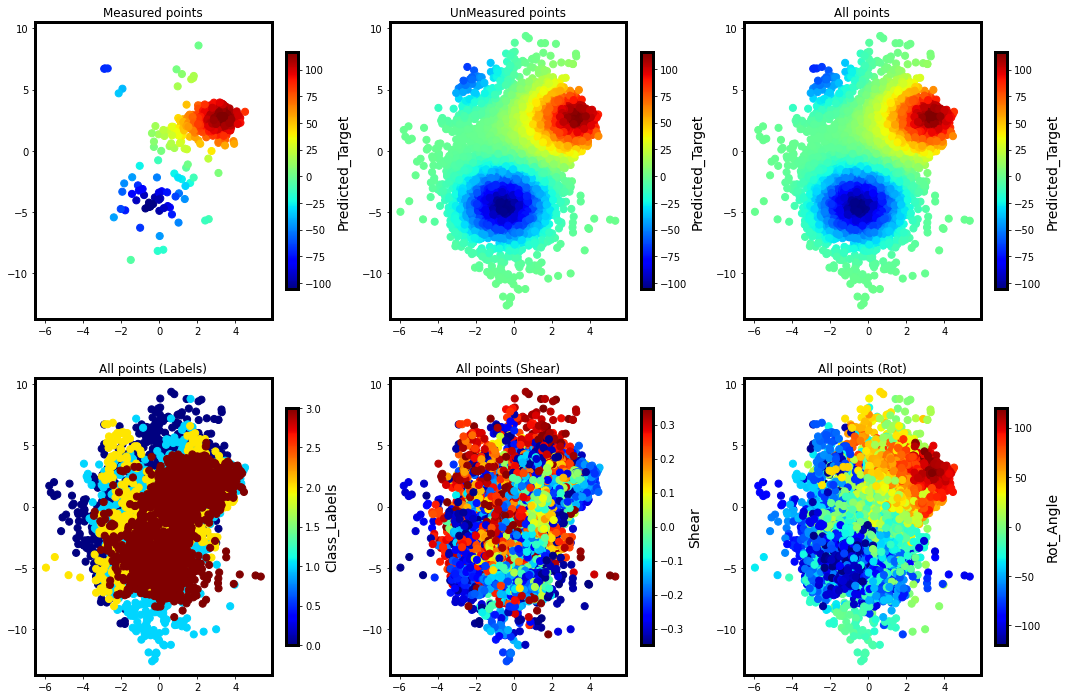

In [47]:
# Latent space visualization of the DKL at the end of the exploration colored
# using predicted targets and various ground truths
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))



im = ax[0,1].scatter(embeded_unmeasured6[:, 1], embeded_unmeasured6[:, 0], s=50,
                c = predmean_unmeas6, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded16[:, 1], embeded16[:, 0], s=50, c = predmean16, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded16[:, 1], embeded16[:, 0], s=50, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded16[:, 1], embeded16[:, 0], s=50, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded16[:, 1], embeded16[:, 0], s=50, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,0].scatter(embeded_train6[:, 1], embeded_train6[:, 0], s=50, c = predmean_train6, cmap = 'jet')
ax[0,0].set_title('Measured points')
ax[0,0].set_xlim(ax[1,2].get_xlim())
ax[0,0].set_ylim(ax[1,2].get_ylim())
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)